In [156]:
import pandas as pd
import numpy as np
import casadi as ca
import casadi.tools

import matplotlib.pyplot as plt

In [2]:
u = ca.MX.sym("u") # Social distancing control

x = ca.tools.struct_symMX(["s", "e", "i", "r"])

p = ca.tools.struct_symMX(["alpha", "beta", "gamma"])

dxdt = ca.tools.struct_MX(x)
dxdt["s"] = -(1 - u) * p["beta"] * x["s"] * x["i"]
dxdt["e"] = (1 - u) * p["beta"] * x["s"] * x["i"] - p["alpha"] * x["e"]
dxdt["i"] = p["alpha"] * x["e"] - p["gamma"] * x["i"]
dxdt["r"] = p["gamma"] * x["i"]

f = ca.Function("f", [x, u, p], [dxdt.cat], ["x", "u", "p"], ["dx/dt"])

In [3]:
f

Function(f:(x[4],u,p[3])->(dx/dt[4]) MXFunction)

In [4]:
dt = 1

# RK4
k1 = f(x, u, p)
k2 = f(x + dt / 2.0 * k1, u, p)
k3 = f(x + dt / 2.0 * k2, u, p)
k4 = f(x + dt * k3, u, p)
xf = x + dt / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)

# Single step time propagation
F_RK4 = ca.Function("F_RK4", [x, u, p], [xf], ['x[k]', 'u[k]', "p"], ['x[k+1]'])

In [5]:
simulator = F_RK4.mapaccum(200)

In [6]:
t_incubation = 5.1
t_infective = 3.3
R0 = 2.4
N = 100000

# Initial number of infected and recovered individuals
e0 = 1/N
i0 = 0
r0 = 0
s0 = 1 - e0 - i0 - r0
x0 = [s0, e0, i0, r0]

p0 = [1/t_incubation, R0/t_infective, 1/t_infective]

In [7]:
sim_no_control = pd.DataFrame(simulator(x0, 0, p0).toarray().T, columns=x.keys())

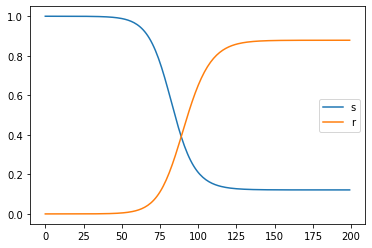

In [8]:
sim_no_control[["s", "r"]].plot()

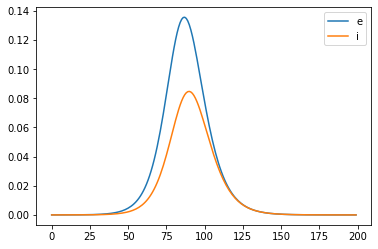

In [9]:
sim_no_control[["e", "i"]].plot()

In [148]:
# Control!
N = 365

opti = ca.Opti()

U = opti.variable(1, N)
X = opti.variable(x.size, N+1)

# Parameter
P = opti.parameter(p.size)
X0 = opti.parameter(x.size)

In [149]:
# Initial conditions
opti.subject_to(X[:,0] == X0)

# Gap-closing shooting constraints
for k in range(N):
   opti.subject_to(X[:,k+1] == F_RK4(X[:,k], U[:,k], P))

In [150]:
# Capacity limit
opti.subject_to(opti.bounded(0, X[2,:], 0.02))
#opti.subject_to(opti.bounded(0, X[1,:], ca.inf))
#opti.subject_to(opti.bounded(0, X[2,:], ca.inf))
#opti.subject_to(opti.bounded(0, X[3,:], ca.inf))

In [151]:
opti.subject_to(opti.bounded(0, U, 0.8))

In [152]:
opti.minimize(ca.sumsqr(U))

In [135]:
#opti.set_value(P, p0)
#opti.set_value(X0, x0)

In [153]:
opti.solver('ipopt')

In [154]:
MPC = opti.to_function("MPC", [X0, P], [U[0]], ["x[k]", "p"], ["u[k]"])

In [161]:
X_sim = np.zeros((x.size, N))
U_sim = np.zeros((1, N))
X_sim[:,0] = x0 # Initialize simulation

In [178]:
# Simulate
for k in range(N-1):
    U_sim[:,k] = MPC(X_sim[:,k], p0)
    X_sim[:,k+1] = F_RK4(X_sim[:,k], U_sim[:,k], p0).toarray().flatten()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7669
Number of nonzeros in inequality constraint Jacobian.:      731
Number of nonzeros in Lagrangian Hessian.............:     3650

Total number of variables............................:     1829
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1464
Total number of inequality constraints...............:      731
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      731
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  84  3.8912266e+01 3.26e-04 1.03e+05  -1.7 2.34e-14  18.6 1.00e+00 1.00e+00h  1
  85  3.8912266e+01 3.26e-04 1.03e+05  -1.7 7.02e-14  18.2 1.00e+00 1.00e+00h  1
  86  3.8912266e+01 3.26e-04 1.09e+05  -1.7 2.24e-13  17.7 1.00e+00 1.00e+00h  1
  87  3.8912266e+01 3.26e-04 1.45e+05  -1.7 8.94e-13  17.2 1.00e+00 1.00e+00h  1
  88  3.4711267e+01 2.51e-05 5.86e+17  -1.7 4.29e-02  16.7 1.00e+00 1.00e+00f  1
  89r 3.4711267e+01 2.51e-05 9.99e+02  -1.7 0.00e+00  19.9 0.00e+00 0.00e+00R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 4.7912938e+01 1.00e-04 4.57e+01  -1.7 9.67e-02    -  9.55e-01 1.00e+00f  1
  91r 6.3314089e+01 1.35e-03 5.38e+02  -1.7 3.20e-01    -  5.44e-01 9.67e-01f  1
  92r 5.8688189e+01 3.55e-04 7.35e+01  -1.7 1.20e-01   0.0 7.78e-01 1.00e+00f  1
  93r 5.2532483e+01 3.17e-04 8.16e+01  -1.7 2.22e-01    -  6.59e-01 1.00e+00f  1
  94r 5.2204326e+01 1.83e-04 1.17e+00  -1.7 2.86e-02   0.4 1.00e+00 1.00e+00f  1
  95r 5.2878073e+01 2.39e-04

  14  9.1602536e+00 3.03e-03 1.97e+07  -1.7 2.33e+00   3.1 6.75e-01 3.48e-02h  1
  15  9.7657479e+00 2.87e-03 2.27e+07  -1.7 2.76e+00   2.6 4.24e-01 5.35e-02h  1
  16  9.9278898e+00 2.83e-03 2.25e+07  -1.7 3.46e+00   3.0 5.79e-01 1.39e-02h  1
  17  1.0756045e+01 2.66e-03 3.36e+07  -1.7 3.53e+00   2.5 2.48e-01 5.92e-02h  1
  18  1.0947274e+01 2.63e-03 3.64e+07  -1.7 3.22e+00   3.0 9.53e-01 1.37e-02h  1
  19  1.1682416e+01 2.51e-03 4.29e+07  -1.7 4.29e+00   2.5 3.19e-01 4.30e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.2125711e+01 2.45e-03 6.98e+07  -1.7 5.02e+00   2.9 1.47e-01 2.43e-02h  1
  21  1.2201559e+01 2.44e-03 6.98e+07  -1.7 6.35e+00   3.3 3.37e-01 4.07e-03h  1
  22  1.2850022e+01 2.37e-03 1.22e+08  -1.7 5.56e+00   2.9 1.26e-01 3.00e-02h  1
  23  1.3170512e+01 2.33e-03 1.85e+08  -1.7 7.06e+00   3.3 1.99e-01 1.41e-02h  1
  24  1.3759721e+01 2.28e-03 1.96e+08  -1.7 7.55e+00   2.8 3.84e-01 2.26e-02h  1
  25  1.4041481e+01 2.26e-03

 108r 7.8589916e+01 8.46e-05 1.07e-01  -2.5 2.43e-02    -  1.00e+00 1.00e+00h  1
 109r 8.2625636e+01 6.61e-05 1.93e+01  -3.8 1.75e-01    -  6.32e-01 4.85e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r 8.3222521e+01 7.83e-05 8.27e+00  -3.8 1.05e-01    -  8.55e-01 9.72e-01f  1
 111r 8.4353395e+01 4.93e-05 1.11e+02  -3.8 1.76e-01    -  1.00e+00 5.27e-01f  1
 112r 8.6010436e+01 4.64e-05 5.16e+00  -3.8 1.36e-01    -  1.00e+00 1.00e+00f  1
 113r 8.6200165e+01 3.43e-05 2.24e+00  -3.8 5.60e-02    -  1.00e+00 1.00e+00h  1
 114  8.2542884e+01 3.72e-05 3.21e+03  -1.7 6.06e-01    -  3.80e-01 7.39e-02f  4
 115  7.9925990e+01 5.56e-05 5.01e+03  -1.7 6.70e-01    -  3.16e-01 4.85e-02f  4
 116  7.5519966e+01 9.80e-05 5.53e+03  -1.7 7.95e-01    -  2.23e-01 6.52e-02f  3
 117  7.3444417e+01 1.02e-04 6.78e+03  -1.7 6.24e-01    -  3.64e-01 3.74e-02f  4
 118  5.5157858e+01 6.04e-04 5.02e+03  -1.7 5.44e-01    -  6.11e-01 3.70e-01f  1
 119r 5.5157858e+01 6.04e-04

  13  8.5203837e+00 3.13e-03 1.59e+07  -1.7 2.25e+00   2.6 4.11e-01 6.18e-02h  1
  14  8.6050098e+00 3.10e-03 1.57e+07  -1.7 2.74e+00   3.1 4.20e-01 8.87e-03h  1
  15  9.2230286e+00 2.92e-03 1.79e+07  -1.7 2.53e+00   2.6 2.59e-01 5.69e-02h  1
  16  9.5426665e+00 2.84e-03 2.48e+07  -1.7 3.09e+00   3.0 5.76e-01 2.80e-02h  1
  17  1.0259897e+01 2.69e-03 2.92e+07  -1.7 3.52e+00   2.5 2.35e-01 5.29e-02h  1
  18  1.0324806e+01 2.68e-03 2.91e+07  -1.7 4.19e+00   3.0 3.23e-01 4.80e-03h  1
  19  1.0815601e+01 2.59e-03 1.16e+08  -1.7 4.35e+00   3.4 1.00e+00 3.28e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1462669e+01 2.49e-03 1.31e+08  -1.7 4.93e+00   2.9 1.13e-01 3.70e-02h  1
  21  1.2185917e+01 2.41e-03 1.26e+08  -1.7 5.10e+00   2.4 1.55e-01 3.52e-02h  1
  22  1.2264615e+01 2.40e-03 1.26e+08  -1.7 6.25e+00   2.9 4.26e-01 3.88e-03h  1
  23  1.2707208e+01 2.35e-03 1.71e+08  -1.7 6.08e+00   3.3 1.22e-01 2.00e-02h  1
  24  1.3309207e+01 2.29e-03

 107  1.2021840e+01 2.91e-14 6.41e+04  -2.5 1.11e-06   9.8 1.00e+00 1.00e+00h  1
 108  1.2021840e+01 1.11e-16 5.29e-02  -2.5 2.52e-11   9.3 1.00e+00 1.00e+00h  1
 109  1.1632381e+01 4.59e-06 1.69e+01  -2.5 5.34e-02    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.1708296e+01 4.88e-07 2.51e+00  -2.5 1.15e-02    -  1.00e+00 1.00e+00h  1
 111  1.1705598e+01 7.29e-10 1.54e-02  -2.5 7.44e-04    -  1.00e+00 1.00e+00h  1
 112  1.1331786e+01 2.74e-05 3.71e+02  -3.8 7.80e-02    -  8.63e-01 4.99e-01f  1
 113  1.1156882e+01 2.97e-05 3.01e+02  -3.8 6.74e-02    -  8.05e-01 5.02e-01f  1
 114  1.1035727e+01 2.32e-05 2.14e+02  -3.8 4.45e-02    -  9.30e-01 7.46e-01f  1
 115  1.0982955e+01 4.19e-06 4.49e+00  -3.8 1.68e-02    -  9.71e-01 1.00e+00f  1
 116  1.0977128e+01 9.31e-08 1.17e-01  -3.8 4.51e-03    -  1.00e+00 1.00e+00h  1
 117  1.0977005e+01 2.95e-09 1.70e-03  -3.8 1.34e-03    -  1.00e+00 1.00e+00h  1
 118  1.0976992e+01 1.05e-11

  45  2.2835583e+01 1.98e-03 2.46e+09  -1.7 5.28e+01   2.7 5.32e-02 3.52e-03h  1
  46  2.3237492e+01 1.98e-03 4.19e+09  -1.7 5.18e+01   3.2 1.21e-02 2.08e-03h  1
  47  2.3883626e+01 1.98e-03 4.53e+09  -1.7 6.58e+01   2.7 1.66e-02 2.85e-03h  1
  48  2.4026465e+01 1.97e-03 4.54e+09  -1.7 7.92e+01   3.1 3.41e-02 6.33e-04h  1
  49  2.4985337e+01 1.97e-03 6.06e+09  -1.7 8.09e+01   2.6 6.79e-03 3.34e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.5146785e+01 1.97e-03 6.35e+09  -1.7 6.72e+01   3.1 5.07e-02 5.94e-04h  1
  51  2.5924571e+01 1.96e-03 6.99e+09  -1.7 9.38e+01   2.6 6.75e-03 2.25e-03h  1
  52  2.6233492e+01 1.96e-03 8.13e+09  -1.7 1.08e+02   3.0 1.93e-02 8.85e-04h  1
  53  2.7028130e+01 1.96e-03 8.97e+09  -1.7 1.24e+02   2.5 5.71e-03 1.84e-03h  1
  54  2.7126692e+01 1.96e-03 8.99e+09  -1.7 1.38e+02   3.0 1.39e-02 2.39e-04h  1
  55  2.7952361e+01 1.95e-03 9.63e+09  -1.7 1.44e+02   2.5 1.29e-02 1.59e-03h  1
  56  2.8296842e+01 1.95e-03

 144  1.0947141e+01 2.88e-07 3.04e-02  -5.7 4.41e-03    -  1.00e+00 1.00e+00f  1
 145  1.0946566e+01 1.59e-08 2.48e-03  -5.7 1.01e-03    -  1.00e+00 1.00e+00h  1
 146  1.0946487e+01 6.51e-10 2.61e-05  -5.7 2.07e-04    -  1.00e+00 1.00e+00h  1
 147  1.0946482e+01 2.32e-12 1.80e-07  -5.7 1.30e-05    -  1.00e+00 1.00e+00h  1
 148  1.0946210e+01 1.11e-08 2.78e-01  -8.6 9.34e-04    -  9.99e-01 9.27e-01f  1
 149  1.0946153e+01 2.86e-09 3.15e-01  -8.6 3.57e-04    -  1.00e+00 8.76e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.0946135e+01 3.20e-10 4.57e-05  -8.6 1.49e-04    -  1.00e+00 1.00e+00f  1
 151  1.0946132e+01 1.67e-11 3.51e-06  -8.6 6.32e-05    -  1.00e+00 1.00e+00h  1
 152  1.0946132e+01 1.20e-12 1.20e-07  -8.6 2.76e-05    -  1.00e+00 1.00e+00h  1
 153  1.0946131e+01 1.65e-13 1.26e-11  -8.6 8.47e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 153

                                   (scaled)                 (unscaled)
Object

  54  2.6705199e+01 1.97e-03 6.30e+09  -1.7 1.25e+02   3.0 2.31e-02 6.11e-04h  1
  55  2.7570857e+01 1.97e-03 8.11e+09  -1.7 1.43e+02   2.5 4.72e-03 1.74e-03h  1
  56  2.7662145e+01 1.96e-03 8.13e+09  -1.7 1.54e+02   2.9 9.70e-03 1.96e-04h  1
  57  2.8409552e+01 1.96e-03 8.81e+09  -1.7 1.61e+02   2.4 1.58e-02 1.28e-03h  1
  58  2.8836628e+01 1.96e-03 1.28e+10  -1.7 1.59e+02   2.9 4.83e-03 7.11e-04h  1
  59  2.9519719e+01 1.96e-03 1.28e+10  -1.7 1.92e+02   2.4 4.74e-03 9.44e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.9730961e+01 1.96e-03 1.28e+10  -1.7 2.36e+02   2.8 9.92e-03 2.97e-04h  1
  61  3.0117248e+01 1.96e-03 2.65e+10  -1.7 1.85e+02   3.2 4.39e-03 5.35e-04h  1
  62  3.0739829e+01 1.96e-03 3.58e+10  -1.7 2.53e+02   2.7 4.54e-03 6.97e-04h  1
  63  3.0967724e+01 1.96e-03 3.70e+10  -1.7 2.99e+02   3.2 3.12e-03 2.64e-04h  1
  64  3.1566749e+01 1.95e-03 4.31e+10  -1.7 2.98e+02   2.7 3.18e-03 5.71e-04h  1
  65  3.1963787e+01 1.95e-03

 148  1.0946152e+01 2.66e-09 3.14e-01  -8.6 3.42e-04    -  1.00e+00 8.77e-01f  1
 149  1.0946135e+01 2.86e-10 4.06e-05  -8.6 1.49e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.0946132e+01 1.39e-11 3.10e-06  -8.6 6.31e-05    -  1.00e+00 1.00e+00h  1
 151  1.0946132e+01 1.29e-12 1.03e-07  -8.6 2.75e-05    -  1.00e+00 1.00e+00h  1
 152  1.0946131e+01 1.67e-13 6.83e-11  -8.6 8.45e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 152

                                   (scaled)                 (unscaled)
Objective...............:   1.0946131442173440e+01    1.0946131442173440e+01
Dual infeasibility......:   6.8327151120199658e-11    6.8327151120199658e-11
Constraint violation....:   1.6686652060116103e-13    1.6686652060116103e-13
Complementarity.........:   2.6487750418890029e-09    2.6487750418890029e-09
Overall NLP error.......:   2.6487750418890029e-09    2.6487750418890029e-09


Number of objective func

  58  2.8883853e+01 1.97e-03 1.07e+10  -1.7 2.09e+02   2.9 8.75e-03 1.24e-04h  1
  59  2.9389699e+01 1.97e-03 3.42e+10  -1.7 1.96e+02   3.3 4.78e-03 8.13e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.0036835e+01 1.97e-03 3.66e+10  -1.7 2.49e+02   2.8 4.29e-03 8.20e-04h  1
  61  3.0096679e+01 1.97e-03 3.66e+10  -1.7 2.56e+02   3.2 7.74e-03 8.48e-05h  1
  62  3.0795084e+01 1.96e-03 3.87e+10  -1.7 2.48e+02   2.7 2.35e-03 7.58e-04h  1
  63  3.1019960e+01 1.96e-03 3.88e+10  -1.7 2.92e+02   3.2 8.32e-03 2.57e-04h  1
  64  3.1944551e+01 1.96e-03 5.31e+10  -1.7 3.37e+02   2.7 2.10e-03 7.93e-04h  1
  65  3.1993991e+01 1.96e-03 5.32e+10  -1.7 3.57e+02   3.1 5.27e-03 4.75e-05h  1
  66  3.2696210e+01 1.96e-03 5.57e+10  -1.7 3.63e+02   2.6 6.57e-03 5.20e-04h  1
  67  3.3202580e+01 1.96e-03 9.11e+10  -1.7 4.11e+02   3.1 1.90e-03 3.73e-04h  1
  68  3.3876268e+01 1.96e-03 9.11e+10  -1.7 4.99e+02   2.6 2.19e-03 3.95e-04h  1
  69  3.3981509e+01 1.96e-03

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 809.00us (  2.95us) 787.11us (  2.87us)       274
       nlp_g  | 565.67ms (  2.06ms) 564.93ms (  2.06ms)       274
    nlp_grad  |  13.84ms ( 13.84ms)  13.83ms ( 13.83ms)         1
  nlp_grad_f  |   1.39ms ( 10.21us)   1.38ms ( 10.12us)       136
  nlp_hess_l  |   5.98 s ( 41.26ms)   5.98 s ( 41.22ms)       145
   nlp_jac_g  |   3.05 s ( 19.70ms)   3.05 s ( 19.68ms)       155
       total  |  12.93 s ( 12.93 s)  12.91 s ( 12.91 s)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7669
Number of nonzeros in inequality constraint Jacobian.:      731
Number of nonzeros in Lagrangian Hessian.............:     3650

Total number of variables............................:     1829
                     variables with only lower bounds:        0
        

  77  3.8239263e+01 1.96e-03 1.61e+11  -1.7 9.68e+02   2.8 1.70e-03 1.07e-04h  1
  78  3.8926542e+01 1.96e-03 1.61e+11  -1.7 1.30e+03   2.3 4.62e-04 1.47e-04h  1
  79  3.9039655e+01 1.96e-03 1.61e+11  -1.7 1.30e+03   2.8 1.11e-03 3.00e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  3.9479053e+01 1.96e-03 4.37e+11  -1.7 6.42e+02   3.2 3.31e-03 2.08e-04h  1
  81  3.9479056e+01 1.96e-03 4.37e+11  -1.7 5.10e-02  13.0 2.66e-01 1.53e-05h 17
  82  3.9479258e+01 1.96e-03 4.40e+11  -1.7 2.34e-01  12.6 6.67e-01 7.59e-05h  1
  83r 3.9479258e+01 1.96e-03 1.00e+03  -1.7 0.00e+00  14.8 0.00e+00 4.77e-07R 22
  84r 3.9520159e+01 9.58e-06 3.02e+02  -1.7 1.90e-01    -  8.42e-01 1.03e-02f  1
  85  3.9496116e+01 1.85e-04 5.16e+03  -1.7 8.06e-01    -  4.60e-02 5.16e-02f  2
  86  3.9474900e+01 2.24e-04 1.35e+04  -1.7 4.99e-01    -  4.38e-01 4.29e-02f  2
  87  3.4716592e+01 2.15e-04 6.98e+05  -1.7 1.43e+00    -  2.64e-01 2.26e-01f  1
  88  3.6827550e+01 1.57e-04

   1  2.6410336e-01 9.95e-03 2.02e+02  -1.7 1.00e+00    -  1.00e+00 9.90e-01h  1
   2  5.1279181e+00 4.75e-03 4.08e+05  -1.7 1.46e+00    -  1.11e-02 5.22e-01f  1
   3  5.1833714e+00 4.71e-03 4.06e+05  -1.7 8.85e-01   2.0 1.94e-01 9.20e-03h  1
   4  5.5385056e+00 4.44e-03 3.83e+05  -1.7 1.06e+00   1.5 1.20e-01 5.60e-02h  1
   5  5.5622849e+00 4.43e-03 3.81e+05  -1.7 1.28e+00   1.9 7.31e-02 3.78e-03h  1
   6  5.8405278e+00 4.24e-03 4.74e+05  -1.7 1.33e+00   2.4 4.89e-02 4.31e-02f  1
   7  5.9944469e+00 4.14e-03 6.18e+05  -1.7 1.26e+00   2.8 1.18e-01 2.39e-02f  1
   8  6.0005129e+00 4.13e-03 6.17e+05  -1.7 1.49e+00   3.2 5.33e-01 9.42e-04h  1
   9  6.4954746e+00 3.84e-03 2.62e+06  -1.7 1.59e+00   2.7 4.67e-01 7.09e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5232512e+00 3.82e-03 2.61e+06  -1.7 1.78e+00   3.2 5.59e-01 3.95e-03h  1
  11  7.0689700e+00 3.55e-03 4.70e+06  -1.7 1.75e+00   2.7 4.24e-01 7.04e-02h  1
  12  7.1922545e+00 3.50e-03

  98  2.4303535e+01 4.36e-04 1.57e+03  -1.7 2.51e-01    -  8.20e-01 8.99e-01f  1
  99  2.2005908e+01 9.40e-04 6.79e+02  -1.7 5.27e-01    -  2.82e-01 3.44e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 2.2005908e+01 9.40e-04 9.99e+02  -1.7 0.00e+00  16.0 0.00e+00 4.77e-07R 22
 101r 2.1299657e+01 2.52e-04 9.34e+02  -1.7 2.54e+00    -  7.44e-02 2.11e-02f  1
 102  2.3031221e+01 9.98e-05 1.81e+02  -1.7 1.34e-01    -  7.76e-01 8.22e-01H  1
 103  2.1998519e+01 2.84e-04 3.08e+03  -1.7 9.79e-02    -  4.26e-01 1.00e+00f  1
 104  1.9340014e+01 5.33e-05 3.54e+01  -1.7 7.05e-02    -  1.00e+00 1.00e+00f  1
 105  1.8891854e+01 4.06e-05 1.21e+01  -1.7 7.78e-02    -  1.00e+00 1.00e+00f  1
 106  1.9136779e+01 6.01e-07 1.00e-01  -1.7 9.65e-03    -  1.00e+00 1.00e+00f  1
 107  1.6251194e+01 3.74e-05 9.55e+02  -2.5 1.17e-01    -  8.64e-01 5.05e-01f  1
 108  1.3883266e+01 1.28e-04 9.13e+02  -2.5 8.37e-02    -  1.00e+00 7.90e-01f  1
 109  1.2708522e+01 5.94e-05

  31  1.5586672e+01 2.17e-03 1.74e+08  -1.7 1.45e+01   3.1 1.46e-01 1.32e-03h  1
  32  1.6305220e+01 2.14e-03 1.88e+08  -1.7 1.46e+01   2.6 7.23e-02 1.32e-02h  1
  33  1.6755774e+01 2.12e-03 2.89e+08  -1.7 1.72e+01   3.0 5.36e-02 7.82e-03h  1
  34  1.7420621e+01 2.10e-03 2.86e+08  -1.7 2.00e+01   2.6 5.34e-02 9.81e-03h  1
  35  1.7492357e+01 2.10e-03 2.86e+08  -1.7 2.30e+01   3.0 1.15e-01 1.08e-03h  1
  36  1.8311278e+01 2.08e-03 2.83e+08  -1.7 2.25e+01   2.5 2.47e-02 9.99e-03h  1
  37  1.8660834e+01 2.07e-03 3.66e+08  -1.7 2.37e+01   2.9 2.10e-01 4.22e-03h  1
  38  1.9422518e+01 2.05e-03 3.82e+08  -1.7 2.74e+01   2.5 2.39e-02 7.45e-03h  1
  39  1.9655912e+01 2.05e-03 3.96e+08  -1.7 3.28e+01   2.9 4.01e-02 2.27e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.0564246e+01 2.03e-03 4.92e+08  -1.7 3.59e+01   2.4 2.52e-02 7.10e-03h  1
  41  2.0636539e+01 2.03e-03 4.93e+08  -1.7 4.23e+01   2.8 5.10e-02 5.87e-04h  1
  42  2.1459800e+01 2.02e-03

 126  1.2799107e+01 1.34e-04 2.36e+03  -3.8 8.33e-02    -  2.65e-01 3.66e-01f  1
 127  1.2156816e+01 9.06e-05 5.96e+04  -3.8 8.43e-02    -  9.04e-01 3.88e-01f  1
 128  1.1656972e+01 6.12e-05 6.02e+04  -3.8 9.38e-02    -  6.89e-01 4.13e-01f  1
 129  1.1407346e+01 4.71e-05 5.67e+04  -3.8 1.01e-01    -  4.29e-01 2.88e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.1254140e+01 3.88e-05 4.71e+04  -3.8 1.06e-01    -  3.31e-01 2.33e-01f  1
 131  1.1140382e+01 3.20e-05 2.30e+04  -3.8 1.09e-01    -  8.75e-01 2.33e-01f  1
 132  1.1051909e+01 2.67e-05 3.76e+04  -3.8 1.14e-01    -  3.51e-01 2.90e-01f  1
 133  1.1022718e+01 2.36e-05 9.57e+04  -3.8 1.16e-01    -  7.34e-02 2.16e-01f  1
 134  1.1016041e+01 2.05e-05 8.08e+04  -3.8 6.71e-02    -  4.72e-02 1.65e-01h  1
 135  1.0980852e+01 7.96e-07 3.63e+04  -3.8 1.54e-02    -  1.23e-01 1.00e+00f  1
 136  1.0976553e+01 2.06e-06 4.29e+01  -3.8 1.34e-02    -  1.00e+00 1.00e+00f  1
 137  1.0976983e+01 3.56e-08

  42  2.1470799e+01 2.02e-03 4.85e+08  -1.7 4.29e+01   2.4 1.35e-02 5.39e-03h  1
  43  2.1813679e+01 2.02e-03 6.31e+08  -1.7 4.38e+01   2.8 4.70e-02 2.21e-03h  1
  44  2.1893413e+01 2.02e-03 6.31e+08  -1.7 5.12e+01   2.3 5.10e-03 4.67e-04f  4
  45  2.2477974e+01 2.01e-03 1.03e+09  -1.7 5.21e+01   2.7 4.23e-02 3.22e-03h  1
  46  2.2869495e+01 2.01e-03 1.91e+09  -1.7 6.34e+01   3.2 1.57e-02 2.06e-03h  1
  47  2.3479051e+01 2.00e-03 2.05e+09  -1.7 6.71e+01   2.7 1.30e-02 2.74e-03h  1
  48  2.3731399e+01 2.00e-03 2.24e+09  -1.7 5.62e+01   3.1 5.71e-02 1.16e-03h  1
  49  2.4477617e+01 1.99e-03 2.44e+09  -1.7 7.38e+01   2.6 6.79e-03 2.73e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.4686869e+01 1.99e-03 2.45e+09  -1.7 8.82e+01   3.1 2.98e-02 7.76e-04h  1
  51  2.5600149e+01 1.99e-03 3.35e+09  -1.7 1.00e+02   2.6 8.34e-03 2.63e-03h  1
  52  2.5679691e+01 1.99e-03 3.36e+09  -1.7 1.09e+02   3.0 1.00e-02 2.45e-04h  1
  53  2.6356374e+01 1.98e-03

 138  1.0946131e+01 1.83e-13 2.69e-11  -8.6 8.68e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 138

                                   (scaled)                 (unscaled)
Objective...............:   1.0946131278955956e+01    1.0946131278955956e+01
Dual infeasibility......:   2.6854867288261808e-11    2.6854867288261808e-11
Constraint violation....:   1.8296475445822580e-13    1.8296475445822580e-13
Complementarity.........:   2.6564895499869877e-09    2.6564895499869877e-09
Overall NLP error.......:   2.6564895499869877e-09    2.6564895499869877e-09


Number of objective function evaluations             = 237
Number of objective gradient evaluations             = 125
Number of equality constraint evaluations            = 237
Number of inequality constraint evaluations          = 237
Number of equality constraint Jacobian evaluations   = 142
Number of inequality constraint Jacobian evaluations = 142
Number of Lagrangian Hessian evaluations             = 138
Total CPU secs i

  65  3.2150502e+01 1.97e-03 2.84e+10  -1.7 3.79e+02   3.1 6.18e-03 1.46e-04h  1
  66  3.3173550e+01 1.96e-03 3.74e+10  -1.7 4.30e+02   2.6 1.52e-03 6.69e-04h  1
  67  3.3226045e+01 1.96e-03 3.74e+10  -1.7 4.56e+02   3.1 4.42e-03 3.89e-05h  1
  68  3.3955247e+01 1.96e-03 3.96e+10  -1.7 4.83e+02   2.6 2.17e-03 4.11e-04h  1
  69  3.3955248e+01 1.96e-03 3.96e+10  -1.7 1.50e-02  12.4 2.73e-01 3.05e-05h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.3955396e+01 1.96e-03 2.86e+11  -1.7 2.45e-01  12.0 1.00e+00 1.89e-05h  1
  71  3.3956378e+01 1.96e-03 4.13e+11  -1.7 7.99e-01  11.5 4.24e-01 1.06e-04h  1
  72  3.3956814e+01 1.96e-03 5.51e+10  -1.7 1.32e-04  14.6 9.90e-01 9.90e-01s 22
  73r 3.3956814e+01 1.96e-03 1.00e+03  -1.7 0.00e+00  15.0 0.00e+00 0.00e+00R  1
  74r 3.3996838e+01 4.68e-05 5.42e+02  -1.7 1.91e-01    -  7.17e-01 1.02e-02f  1
  75r 3.4934174e+01 6.64e-05 4.11e+02  -1.7 1.74e-01    -  1.57e-01 9.76e-02f  1
  76  3.4893614e+01 6.44e-05

Total number of variables............................:     1829
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1464
Total number of inequality constraints...............:      731
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      731
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 9.95e-03 2.02e+02  -1.7 1.00e+00    -  1.00e+00 9.90e-01h  1
   2  5.1142656e+00 4.76e-03 2.40e+05  -1.7 1.47e+00    -  1.11e-02 5.22e-01f  1
   3  5.1694106e+00 4.71e-03 2.39e+05  -1.7 8.86e-01   2.0 1.94e-01 9.17e-03h  1
   4  5.5299359e+0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  5.8725921e+01 1.64e-04 1.99e+01  -1.7 3.40e-01    -  6.25e-01 4.19e-01f  1
  91  3.6892477e+01 4.56e-04 3.64e+01  -1.7 2.56e-01    -  7.72e-01 1.00e+00f  1
  92  3.3092021e+01 4.67e-05 2.29e+15  -1.7 3.91e-02  14.5 1.00e+00 1.00e+00f  1
  93  3.1967886e+01 3.00e-05 3.92e+15  -1.7 3.00e-02  14.0 1.00e+00 1.00e+00f  1
  94  3.1759164e+01 1.87e-07 3.19e+15  -1.7 8.33e-03  13.6 1.00e+00 1.00e+00f  1
  95  3.1763611e+01 5.32e-10 5.28e+12  -1.7 1.21e-04  13.1 1.00e+00 1.00e+00h  1
  96  3.1763608e+01 2.22e-16 9.92e+06  -1.7 5.29e-08  12.6 1.00e+00 1.00e+00h  1
  97  3.1763608e+01 1.11e-16 1.89e-01  -1.7 1.39e-13  12.1 1.00e+00 1.00e+00h  1
  98  2.4183334e+01 3.77e-04 1.23e+02  -2.5 2.90e-01    -  3.75e-01 3.65e-01f  1
  99  2.1813690e+01 3.01e-04 6.33e+02  -2.5 1.80e-01    -  8.50e-01 2.16e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7808856e+01 2.03e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.5530239e+01 2.17e-03 1.02e+08  -1.7 1.34e+01   2.7 4.39e-02 1.78e-02h  1
  31  1.5592322e+01 2.17e-03 1.02e+08  -1.7 1.46e+01   3.1 1.49e-01 1.39e-03h  1
  32  1.6320384e+01 2.14e-03 1.10e+08  -1.7 1.47e+01   2.6 7.45e-02 1.33e-02h  1
  33  1.6759091e+01 2.12e-03 1.67e+08  -1.7 1.70e+01   3.0 5.34e-02 7.62e-03h  1
  34  1.7420768e+01 2.10e-03 1.65e+08  -1.7 1.99e+01   2.6 5.19e-02 9.75e-03h  1
  35  1.7496698e+01 2.10e-03 1.65e+08  -1.7 2.31e+01   3.0 1.13e-01 1.14e-03h  1
  36  1.8319903e+01 2.08e-03 1.65e+08  -1.7 2.26e+01   2.5 2.48e-02 1.00e-02h  1
  37  1.8659793e+01 2.07e-03 2.13e+08  -1.7 2.36e+01   2.9 2.24e-01 4.10e-03h  1
  38  1.9432049e+01 2.05e-03 2.26e+08  -1.7 2.76e+01   2.5 2.40e-02 7.53e-03h  1
  39  1.9685909e+01 2.05e-03 2.43e+08  -1.7 3.26e+01   2.9 4.01e-02 2.46e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.0560974e+01 2.03e-03

 124r 5.7788976e+01 3.18e-04 9.99e+02  -1.7 0.00e+00  17.8 0.00e+00 4.77e-07R 22
 125r 5.6995325e+01 1.41e-04 9.79e+02  -1.7 2.17e-01    -  1.62e-02 6.42e-02f  1
 126  4.9827344e+01 4.15e-04 4.15e+02  -1.7 3.42e-01    -  8.05e-01 4.62e-01f  1
 127  3.7547807e+01 8.58e-04 1.53e+03  -1.7 2.17e-01    -  2.70e-01 8.65e-01f  1
 128r 3.7547807e+01 8.58e-04 9.99e+02  -1.7 0.00e+00  17.3 0.00e+00 4.77e-07R 22
 129r 3.6249847e+01 2.63e-04 9.67e+02  -1.7 1.94e+00    -  3.42e-02 2.34e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  3.1492891e+01 5.77e-04 3.70e+02  -1.7 1.32e-01    -  7.69e-01 8.10e-01f  1
 131r 3.1492891e+01 5.77e-04 9.99e+02  -1.7 0.00e+00  16.9 0.00e+00 4.77e-07R 22
 132r 3.1047539e+01 1.59e-04 9.53e+02  -1.7 9.05e-01    -  4.78e-02 3.44e-02f  1
 133  3.0261736e+01 2.74e-04 5.81e+02  -1.7 1.14e-01    -  7.77e-01 1.00e+00f  1
 134  2.7436293e+01 1.20e-03 3.12e+03  -1.7 6.58e-01    -  1.26e-01 2.29e-01f  1
 135  2.6435663e+01 7.09e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0728527e+01 2.58e-03 1.07e+07  -1.7 5.32e+00   2.9 3.86e-01 6.61e-03h  1
  21  1.1535803e+01 2.47e-03 1.21e+07  -1.7 5.34e+00   2.4 3.31e-01 4.01e-02h  1
  22  1.1833128e+01 2.44e-03 1.48e+07  -1.7 4.98e+00   2.9 1.28e-01 1.45e-02h  1
  23  1.2041287e+01 2.41e-03 2.05e+07  -1.7 7.37e+00   3.3 2.80e-01 9.47e-03h  1
  24  1.2693899e+01 2.35e-03 3.40e+07  -1.7 7.13e+00   2.8 2.43e-01 2.57e-02h  1
  25  1.3031387e+01 2.32e-03 5.02e+07  -1.7 7.08e+00   3.2 1.01e-01 1.28e-02h  1
  26  1.3663729e+01 2.27e-03 5.59e+07  -1.7 9.16e+00   2.8 1.53e-01 2.03e-02h  1
  27  1.3771575e+01 2.27e-03 5.59e+07  -1.7 1.09e+01   3.2 9.11e-02 3.45e-03h  1
  28  1.4387350e+01 2.23e-03 5.84e+07  -1.7 9.38e+00   2.7 1.03e-01 1.71e-02h  1
  29  1.4703816e+01 2.21e-03 7.27e+07  -1.7 1.21e+01   3.1 2.91e-01 8.36e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.5531148e+01 2.17e-03

 113r 7.9166945e+01 6.09e-05 3.09e-01  -2.5 3.75e-02    -  1.00e+00 1.00e+00h  1
 114r 7.9073805e+01 6.08e-05 4.69e-03  -2.5 5.64e-03    -  1.00e+00 1.00e+00h  1
 115r 8.3882602e+01 8.88e-05 4.42e+00  -5.7 2.42e-01    -  5.48e-01 5.18e-01f  1
 116r 8.2555011e+01 4.40e-05 5.02e+02  -5.7 4.79e-02  -0.1 4.77e-03 4.91e-01f  1
 117r 8.2026782e+01 3.44e-05 3.93e+02  -5.7 2.91e-02  -0.5 3.98e-02 2.15e-01f  1
 118r 8.1048059e+01 2.36e-05 2.69e+02  -5.7 5.63e-02  -1.0 1.78e-01 3.16e-01f  1
 119  7.7066838e+01 5.70e-05 3.33e+02  -1.7 5.75e-01    -  3.20e-01 8.53e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  6.1342643e+01 2.92e-04 2.52e+02  -1.7 5.38e-01    -  2.45e-01 3.92e-01F  1
 121  5.8595851e+01 2.61e-04 2.70e+02  -1.7 3.35e-01    -  4.06e-01 1.07e-01f  1
 122  4.5991690e+01 1.40e-03 2.94e+03  -1.7 4.87e-01    -  1.68e-01 4.74e-01f  1
 123r 4.5991690e+01 1.40e-03 9.99e+02  -1.7 0.00e+00  18.3 0.00e+00 4.77e-07R 22
 124r 4.4034311e+01 6.98e-04

  22  1.1833944e+01 2.44e-03 1.30e+07  -1.7 4.99e+00   2.9 1.28e-01 1.44e-02h  1
  23  1.2043858e+01 2.41e-03 1.81e+07  -1.7 7.37e+00   3.3 2.80e-01 9.55e-03h  1
  24  1.2696971e+01 2.35e-03 2.99e+07  -1.7 7.14e+00   2.8 2.42e-01 2.57e-02h  1
  25  1.3032216e+01 2.32e-03 4.39e+07  -1.7 7.06e+00   3.2 1.01e-01 1.27e-02h  1
  26  1.3664315e+01 2.27e-03 4.89e+07  -1.7 9.16e+00   2.8 1.53e-01 2.03e-02h  1
  27  1.3773263e+01 2.27e-03 4.89e+07  -1.7 1.09e+01   3.2 9.11e-02 3.49e-03h  1
  28  1.4388654e+01 2.23e-03 5.11e+07  -1.7 9.38e+00   2.7 1.03e-01 1.71e-02h  1
  29  1.4708081e+01 2.21e-03 6.41e+07  -1.7 1.21e+01   3.1 2.93e-01 8.44e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.5532118e+01 2.17e-03 7.85e+07  -1.7 1.34e+01   2.7 4.37e-02 1.77e-02h  1
  31  1.5595428e+01 2.17e-03 7.86e+07  -1.7 1.46e+01   3.1 1.51e-01 1.42e-03h  1
  32  1.6328088e+01 2.14e-03 8.49e+07  -1.7 1.48e+01   2.6 7.53e-02 1.34e-02h  1
  33  1.6760965e+01 2.12e-03

 118r 8.6902825e+01 1.13e-05 1.04e+02  -3.8 4.13e-02    -  1.00e+00 5.00e-01h  2
 119r 8.5983737e+01 4.68e-06 3.05e-01  -3.8 2.39e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  8.4542650e+01 1.79e-05 6.53e+02  -1.7 9.01e-01    -  1.34e-01 3.30e-02f  4
 121  8.3144512e+01 3.00e-05 1.33e+03  -1.7 7.76e-01    -  4.79e-01 3.38e-02f  4
 122  8.2917923e+01 3.01e-05 7.42e+02  -1.7 8.02e-01    -  2.82e-01 4.61e-03f  7
 123  8.2786391e+01 3.01e-05 1.17e+03  -1.7 8.25e-01    -  6.59e-01 2.51e-03f  8
 124  5.4054100e+01 2.96e-04 1.37e+04  -1.7 8.01e-01    -  4.35e-01 6.48e-01F  1
 125  5.4054100e+01 2.96e-04 7.87e+04  -1.7 9.44e-13  16.9 1.00e+00 1.00e+00h  1
 126  5.4054100e+01 2.96e-04 1.57e+05  -1.7 5.67e-12  16.4 1.00e+00 1.00e+00h  1
 127  5.3974840e+01 1.45e-05 2.08e+16  -1.7 1.25e-02  16.0 5.60e-02 1.00e+00f  1
 128  5.3947323e+01 1.17e-03 2.32e+16  -1.7 1.83e-03  19.1 1.00e+00 1.00e+00h  1
 129  5.3933025e+01 1.63e-03

 217  3.3272350e+01 6.30e-02 4.11e+04  -1.7 3.09e-01    -  4.57e-01 9.99e-04f  1
 218  3.3266349e+01 6.30e-02 2.91e+07  -1.7 5.78e-01    -  2.32e-01 3.51e-04h  1
 219  3.3265821e+01 6.30e-02 3.95e+11  -1.7 5.24e-01    -  3.53e-01 2.58e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  3.0245073e+01 5.41e-02 3.30e+11  -1.7 6.42e-01    -  1.65e-01 1.41e-01f  1
 221  2.8630975e+01 4.94e-02 6.83e+10  -1.7 5.05e-01    -  7.93e-01 8.65e-02f  1
 222  2.2733576e+01 3.08e-02 6.98e+09  -1.7 4.87e-01    -  8.98e-01 3.78e-01f  1
 223  2.2404300e+01 2.90e-02 7.64e+08  -1.7 3.02e-01    -  8.90e-01 5.77e-02h  1
 224r 2.2404300e+01 2.90e-02 1.00e+03  -1.5 0.00e+00    -  0.00e+00 3.00e-07R  3
 225r 2.2207930e+01 2.05e-02 9.95e+02  -1.5 1.62e+01    -  1.41e-02 1.98e-03f  1
 226  2.2203943e+01 2.04e-02 4.55e+04  -1.7 1.43e+00    -  1.52e-01 2.62e-03f  1
 227  2.0545491e+01 6.64e-03 5.00e+06  -1.7 1.38e-01    -  6.15e-03 6.75e-01h  1
 228  2.0751470e+01 5.69e-03

   1  2.6410336e-01 9.95e-03 2.02e+02  -1.7 1.00e+00    -  1.00e+00 9.90e-01h  1
   2  5.1153116e+00 4.76e-03 1.42e+05  -1.7 1.47e+00    -  1.11e-02 5.22e-01f  1
   3  5.1704535e+00 4.71e-03 1.41e+05  -1.7 8.86e-01   2.0 1.94e-01 9.17e-03h  1
   4  5.5313662e+00 4.45e-03 1.33e+05  -1.7 1.07e+00   1.5 1.20e-01 5.69e-02h  1
   5  5.5545602e+00 4.43e-03 1.32e+05  -1.7 1.28e+00   1.9 7.37e-02 3.70e-03h  1
   6  5.8331497e+00 4.24e-03 1.66e+05  -1.7 1.34e+00   2.4 4.93e-02 4.32e-02f  1
   7  5.9896305e+00 4.13e-03 2.18e+05  -1.7 1.27e+00   2.8 1.19e-01 2.43e-02f  1
   8  5.9956170e+00 4.13e-03 2.18e+05  -1.7 1.48e+00   3.2 5.35e-01 9.30e-04h  1
   9  6.4917457e+00 3.84e-03 9.21e+05  -1.7 1.59e+00   2.7 4.68e-01 7.10e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5193375e+00 3.82e-03 9.18e+05  -1.7 1.79e+00   3.2 5.58e-01 3.93e-03h  1
  11  7.0655416e+00 3.55e-03 1.65e+06  -1.7 1.75e+00   2.7 4.26e-01 7.04e-02h  1
  12  7.1880686e+00 3.50e-03

  99r 1.0588182e+02 7.27e-05 5.65e+01  -1.7 3.00e-02   2.0 6.87e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 1.0544817e+02 7.58e-05 4.49e-01  -1.7 9.68e-03   1.5 1.00e+00 1.00e+00f  1
 101r 1.0575114e+02 2.10e-05 1.52e+00  -2.5 1.34e-02   1.0 9.88e-01 9.97e-01f  1
 102r 1.0630928e+02 2.34e-05 4.65e-01  -2.5 2.58e-02   0.6 1.00e+00 1.00e+00f  1
 103r 1.1335299e+02 1.98e-04 1.50e+02  -2.5 7.64e-02   0.1 4.95e-01 1.00e+00f  1
 104r 1.0603395e+02 1.30e-04 9.12e+01  -2.5 4.34e-02  -0.4 7.52e-01 1.00e+00f  1
 105r 8.0829024e+01 2.80e-04 3.62e+02  -2.5 3.86e-01    -  2.60e-01 7.10e-01f  1
 106r 7.9154628e+01 5.06e-05 3.92e+01  -2.5 4.29e-02   0.9 1.00e+00 9.26e-01h  1
 107r 7.8850560e+01 2.95e-06 1.55e+00  -2.5 1.82e-02   0.5 1.00e+00 1.00e+00f  1
 108  7.6943996e+01 1.42e-05 4.57e+02  -1.7 6.59e-01    -  4.69e-01 6.28e-02f  3
 109  5.8509278e+01 2.44e-04 8.15e+02  -1.7 5.72e-01    -  4.94e-01 5.25e-01F  1
iter    objective    inf_pr 

   1  2.6410336e-01 9.95e-03 2.02e+02  -1.7 1.00e+00    -  1.00e+00 9.90e-01h  1
   2  5.1156716e+00 4.76e-03 1.24e+05  -1.7 1.47e+00    -  1.11e-02 5.22e-01f  1
   3  5.1708154e+00 4.71e-03 1.24e+05  -1.7 8.86e-01   2.0 1.94e-01 9.17e-03h  1
   4  5.5317878e+00 4.44e-03 1.17e+05  -1.7 1.07e+00   1.5 1.20e-01 5.70e-02h  1
   5  5.5549804e+00 4.43e-03 1.16e+05  -1.7 1.28e+00   1.9 7.37e-02 3.70e-03h  1
   6  5.8335730e+00 4.24e-03 1.45e+05  -1.7 1.34e+00   2.4 4.93e-02 4.32e-02f  1
   7  5.9900841e+00 4.13e-03 1.91e+05  -1.7 1.27e+00   2.8 1.19e-01 2.43e-02f  1
   8  5.9960697e+00 4.13e-03 1.91e+05  -1.7 1.48e+00   3.2 5.35e-01 9.30e-04h  1
   9  6.4922160e+00 3.84e-03 8.07e+05  -1.7 1.59e+00   2.7 4.68e-01 7.10e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5198107e+00 3.82e-03 8.05e+05  -1.7 1.79e+00   3.2 5.58e-01 3.93e-03h  1
  11  7.0660331e+00 3.55e-03 1.44e+06  -1.7 1.75e+00   2.7 4.26e-01 7.04e-02h  1
  12  7.1886082e+00 3.50e-03

  97r 9.0325535e+01 2.01e-04 1.45e+02  -1.7 1.24e-01    -  6.07e-01 1.00e+00f  1
  98r 1.3417070e+02 1.93e-04 1.93e+02  -1.7 2.01e-01    -  4.50e-01 1.00e+00f  1
  99r 1.0470957e+02 2.50e-04 1.30e+02  -1.7 3.61e-01    -  6.38e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 1.1967674e+02 1.10e-03 6.29e+01  -1.7 3.47e-01    -  5.53e-01 1.00e+00f  1
 101r 1.0158001e+02 2.05e-04 5.94e+00  -1.7 2.17e-01    -  9.62e-01 1.00e+00f  1
 102r 7.8612467e+01 1.44e-04 3.43e+02  -1.7 1.15e+00    -  7.37e-02 3.19e-01f  1
 103r 7.3662221e+01 1.61e-04 2.04e+02  -1.7 8.05e-01    -  4.28e-01 4.74e-01f  1
 104r 7.3108877e+01 3.59e-04 1.35e+02  -1.7 1.25e+00    -  3.45e-01 3.68e-01f  1
 105r 7.3943355e+01 1.19e-04 7.13e+00  -1.7 2.11e-01   0.0 1.00e+00 1.00e+00f  1
 106  6.0533010e+01 1.62e-04 4.11e+01  -1.7 3.75e-01    -  6.87e-01 3.94e-01f  1
 107  3.7084780e+01 4.23e-04 8.17e+01  -1.7 2.54e-01    -  7.65e-01 1.00e+00f  1
 108  3.2865555e+01 3.15e-05

  23  1.2051735e+01 2.41e-03 1.24e+07  -1.7 7.37e+00   3.3 2.81e-01 9.78e-03h  1
  24  1.2706508e+01 2.35e-03 2.04e+07  -1.7 7.17e+00   2.8 2.40e-01 2.57e-02h  1
  25  1.3034752e+01 2.32e-03 2.93e+07  -1.7 7.00e+00   3.2 1.02e-01 1.24e-02h  1
  26  1.3666135e+01 2.27e-03 3.28e+07  -1.7 9.14e+00   2.8 1.55e-01 2.03e-02h  1
  27  1.3778547e+01 2.27e-03 3.27e+07  -1.7 1.09e+01   3.2 9.08e-02 3.59e-03h  1
  28  1.4392685e+01 2.23e-03 3.43e+07  -1.7 9.40e+00   2.7 1.03e-01 1.71e-02h  1
  29  1.4721458e+01 2.21e-03 4.39e+07  -1.7 1.21e+01   3.1 2.96e-01 8.66e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.5535395e+01 2.17e-03 5.28e+07  -1.7 1.34e+01   2.7 4.35e-02 1.75e-02h  1
  31  1.5600478e+01 2.17e-03 5.28e+07  -1.7 1.46e+01   3.1 1.53e-01 1.46e-03h  1
  32  1.6339798e+01 2.14e-03 5.71e+07  -1.7 1.48e+01   2.6 7.66e-02 1.35e-02h  1
  33  1.6764222e+01 2.12e-03 8.40e+07  -1.7 1.68e+01   3.0 5.32e-02 7.38e-03h  1
  34  1.7424229e+01 2.10e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  3.1998827e+01 1.11e-16 1.83e-01  -2.5 5.55e-13  11.5 1.00e+00 1.00e+00h  1
 121  2.6741113e+01 2.33e-04 1.09e+02  -2.5 1.25e+00    -  1.05e-01 5.98e-02f  1
 122  2.4663161e+01 2.32e-04 1.12e+02  -2.5 5.52e-01    -  7.68e-01 5.72e-02f  1
 123  1.9368644e+01 2.65e-04 8.98e+01  -2.5 2.25e-01    -  5.51e-01 3.83e-01f  1
 124  1.7223419e+01 2.10e-04 7.21e+01  -2.5 1.75e-01    -  4.88e-01 3.01e-01f  1
 125  1.5329857e+01 1.28e-04 9.57e+01  -2.5 1.06e-01    -  6.47e-01 5.37e-01f  1
 126  1.3940004e+01 7.09e-05 1.00e+02  -2.5 7.79e-02    -  5.91e-01 5.08e-01f  1
 127  1.2368655e+01 3.76e-05 2.11e+04  -2.5 6.75e-02    -  4.25e-02 1.00e+00f  1
 128  1.1742087e+01 2.85e-05 7.87e+03  -2.5 9.37e-02    -  1.00e+00 6.37e-01f  1
 129  1.1650304e+01 1.63e-05 9.28e+02  -2.5 4.37e-02    -  5.84e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.1738654e+01 5.18e-06

  38  1.9404461e+01 2.05e-03 9.90e+07  -1.7 2.72e+01   2.5 2.65e-02 7.29e-03h  1
  39  1.9631519e+01 2.05e-03 1.02e+08  -1.7 3.31e+01   2.9 5.54e-02 2.22e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.0552749e+01 2.03e-03 1.34e+08  -1.7 3.65e+01   2.4 1.81e-02 7.14e-03h  1
  41  2.0621688e+01 2.03e-03 1.34e+08  -1.7 4.06e+01   2.8 5.62e-02 5.65e-04h  1
  42  2.1440700e+01 2.02e-03 1.50e+08  -1.7 4.27e+01   2.4 1.40e-02 5.29e-03h  1
  43  2.1799424e+01 2.02e-03 1.97e+08  -1.7 4.43e+01   2.8 4.53e-02 2.31e-03h  1
  44  2.1957284e+01 2.02e-03 1.97e+08  -1.7 5.17e+01   2.3 1.35e-02 9.28e-04h  3
  45  2.2540269e+01 2.01e-03 3.00e+08  -1.7 4.81e+01   2.7 5.62e-02 3.17e-03h  1
  46  2.3053388e+01 2.00e-03 7.60e+08  -1.7 5.94e+01   3.2 1.42e-02 2.61e-03h  1
  47  2.3713384e+01 2.00e-03 7.80e+08  -1.7 7.09e+01   2.7 1.82e-02 2.81e-03h  1
  48  2.3836246e+01 2.00e-03 7.82e+08  -1.7 8.05e+01   3.1 1.07e-02 5.42e-04h  1
  49  2.4474407e+01 1.99e-03

 132  1.6589726e+01 3.31e-05 1.83e+04  -3.8 9.02e-02    -  8.44e-01 2.72e-02f  1
 133  1.3810478e+01 1.69e-04 6.79e+03  -3.8 1.12e-01    -  1.00e+00 7.33e-01f  1
 134  1.3091888e+01 1.20e-04 4.36e+04  -3.8 7.94e-02    -  7.92e-01 3.19e-01f  1
 135  1.2261804e+01 7.24e-05 5.54e+04  -3.8 8.29e-02    -  8.61e-01 4.79e-01f  1
 136  1.1731727e+01 4.58e-05 1.10e+05  -3.8 8.76e-02    -  9.46e-01 4.36e-01f  1
 137  1.1441566e+01 3.38e-05 9.22e+04  -3.8 9.67e-02    -  4.66e-01 3.32e-01f  1
 138  1.1272050e+01 2.65e-05 1.00e+05  -3.8 1.00e-01    -  5.15e-01 2.56e-01f  1
 139  1.1145152e+01 2.15e-05 7.60e+04  -3.8 1.04e-01    -  2.25e-01 2.56e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  1.1076217e+01 1.83e-05 3.30e+04  -3.8 1.08e-01    -  4.64e-01 1.92e-01f  1
 141  1.1025891e+01 1.57e-05 7.50e+04  -3.8 1.11e-01    -  2.77e-01 2.12e-01f  1
 142  1.1001677e+01 1.38e-05 1.26e+05  -3.8 1.10e-01    -  5.37e-02 2.21e-01f  1
 143  1.0997847e+01 1.19e-05

  39  1.9619639e+01 2.05e-03 8.76e+07  -1.7 3.32e+01   2.9 6.24e-02 2.16e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.0549802e+01 2.03e-03 1.19e+08  -1.7 3.67e+01   2.4 1.72e-02 7.18e-03h  1
  41  2.0620631e+01 2.03e-03 1.19e+08  -1.7 4.02e+01   2.8 5.80e-02 5.81e-04h  1
  42  2.1450628e+01 2.02e-03 1.34e+08  -1.7 4.30e+01   2.4 1.40e-02 5.33e-03h  1
  43  2.1797974e+01 2.02e-03 1.73e+08  -1.7 4.39e+01   2.8 4.25e-02 2.23e-03h  1
  44  2.1955086e+01 2.02e-03 1.72e+08  -1.7 5.17e+01   2.3 1.46e-02 9.23e-04h  3
  45  2.2544573e+01 2.01e-03 2.65e+08  -1.7 4.84e+01   2.7 6.18e-02 3.19e-03h  1
  46  2.3055465e+01 2.00e-03 6.63e+08  -1.7 5.86e+01   3.2 1.33e-02 2.59e-03h  1
  47  2.3712987e+01 2.00e-03 6.85e+08  -1.7 7.05e+01   2.7 1.81e-02 2.79e-03h  1
  48  2.3846014e+01 2.00e-03 6.86e+08  -1.7 8.04e+01   3.1 1.09e-02 5.85e-04h  1
  49  2.4485873e+01 1.99e-03 6.85e+08  -1.7 7.39e+01   2.6 1.46e-02 2.35e-03h  1
iter    objective    inf_pr 

 134  1.1764013e+01 1.55e-09 2.42e-02  -2.5 8.74e-04    -  1.00e+00 1.00e+00h  1
 135  1.1298166e+01 2.26e-05 4.59e+02  -3.8 8.04e-02    -  8.98e-01 5.50e-01f  1
 136  1.1093410e+01 2.50e-05 6.20e+02  -3.8 5.50e-02    -  5.33e-01 6.60e-01f  1
 137  1.1030620e+01 1.34e-05 8.36e+02  -3.8 2.45e-02    -  1.00e+00 5.77e-01f  1
 138  1.0981186e+01 2.57e-06 9.32e-01  -3.8 1.35e-02    -  1.00e+00 1.00e+00f  1
 139  1.0977226e+01 1.61e-08 7.51e-04  -3.8 1.30e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  1.0959595e+01 6.98e-07 2.21e+02  -5.7 1.11e-02    -  9.86e-01 6.38e-01f  1
 141  1.0950460e+01 5.15e-07 6.63e+01  -5.7 6.60e-03    -  1.00e+00 7.60e-01f  1
 142  1.0946999e+01 1.14e-07 2.20e-02  -5.7 3.03e-03    -  1.00e+00 1.00e+00f  1
 143  1.0946556e+01 3.42e-09 7.48e-05  -5.7 6.29e-04    -  1.00e+00 1.00e+00h  1
 144  1.0946488e+01 9.35e-11 3.31e-06  -5.7 1.54e-04    -  1.00e+00 1.00e+00h  1
 145  1.0946204e+01 3.18e-09

  52  2.5766798e+01 1.98e-03 8.38e+08  -1.7 1.14e+02   3.0 2.60e-02 3.41e-04h  1
  53  2.6795176e+01 1.98e-03 1.04e+09  -1.7 1.23e+02   2.5 7.51e-03 2.34e-03h  1
  54  2.6913684e+01 1.98e-03 1.06e+09  -1.7 1.15e+02   3.0 9.23e-03 2.91e-04h  1
  55  2.7590398e+01 1.98e-03 1.09e+09  -1.7 1.36e+02   2.5 8.85e-03 1.33e-03h  1
  56  2.7944736e+01 1.98e-03 1.35e+09  -1.7 1.64e+02   2.9 5.71e-03 6.91e-04h  1
  57  2.8142922e+01 1.97e-03 1.65e+09  -1.7 1.24e+02   3.3 1.62e-02 4.15e-04h  1
  58  2.8801082e+01 1.97e-03 2.74e+09  -1.7 1.76e+02   2.9 6.43e-03 1.05e-03h  1
  59  2.9086399e+01 1.97e-03 3.52e+09  -1.7 2.07e+02   3.3 4.49e-03 4.69e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.9635980e+01 1.97e-03 3.93e+09  -1.7 2.14e+02   2.8 4.39e-03 7.47e-04h  1
  61  3.0012870e+01 1.97e-03 5.09e+09  -1.7 2.14e+02   3.2 1.16e-02 5.18e-04h  1
  62  3.0700409e+01 1.97e-03 5.13e+09  -1.7 2.65e+02   2.7 2.26e-03 7.47e-04h  1
  63  3.0798134e+01 1.97e-03

 147  1.6673216e+01 3.23e-05 1.86e+04  -3.8 8.72e-02    -  8.52e-01 2.71e-02f  1
 148  1.3843363e+01 1.64e-04 6.60e+03  -3.8 1.09e-01    -  1.00e+00 7.41e-01f  1
 149  1.3145968e+01 1.17e-04 1.20e+04  -3.8 7.88e-02    -  3.96e-01 3.09e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.2300228e+01 6.84e-05 6.92e+04  -3.8 7.97e-02    -  1.00e+00 4.86e-01f  1
 151  1.1773181e+01 4.36e-05 1.25e+05  -3.8 8.80e-02    -  1.00e+00 4.28e-01f  1
 152  1.1459467e+01 3.15e-05 1.30e+05  -3.8 9.52e-02    -  6.95e-01 3.51e-01f  1
 153  1.1264178e+01 2.41e-05 8.17e+04  -3.8 9.90e-02    -  1.97e-01 2.95e-01f  1
 154  1.1151437e+01 1.99e-05 6.24e+04  -3.8 1.03e-01    -  1.32e-01 2.28e-01f  1
 155  1.1083154e+01 1.71e-05 3.68e+04  -3.8 1.06e-01    -  2.37e-01 1.84e-01f  1
 156  1.1028867e+01 1.46e-05 7.82e+04  -3.8 1.10e-01    -  1.42e-01 2.11e-01f  1
 157  1.0998219e+01 1.31e-05 2.82e+05  -3.8 1.15e-01    -  9.89e-02 2.41e-01f  1
 158  1.0995499e+01 1.20e-05

  41  2.0619476e+01 2.03e-03 9.20e+07  -1.7 3.98e+01   2.8 5.84e-02 5.91e-04h  1
  42  2.1451797e+01 2.02e-03 1.04e+08  -1.7 4.31e+01   2.4 1.44e-02 5.34e-03h  1
  43  2.1796398e+01 2.02e-03 1.33e+08  -1.7 4.37e+01   2.8 4.04e-02 2.21e-03h  1
  44  2.1952998e+01 2.02e-03 1.33e+08  -1.7 5.18e+01   2.3 1.53e-02 9.19e-04h  3
  45  2.2545903e+01 2.01e-03 2.05e+08  -1.7 4.86e+01   2.7 6.10e-02 3.21e-03h  1
  46  2.3053899e+01 2.00e-03 5.06e+08  -1.7 5.84e+01   3.2 1.30e-02 2.58e-03h  1
  47  2.3710212e+01 2.00e-03 5.24e+08  -1.7 7.05e+01   2.7 1.78e-02 2.79e-03h  1
  48  2.3841383e+01 2.00e-03 5.25e+08  -1.7 8.03e+01   3.1 1.19e-02 5.78e-04h  1
  49  2.4493503e+01 1.99e-03 5.24e+08  -1.7 7.45e+01   2.6 1.29e-02 2.38e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.4948058e+01 1.99e-03 7.40e+08  -1.7 8.57e+01   3.1 3.43e-02 1.61e-03h  1
  51  2.5651602e+01 1.99e-03 7.39e+08  -1.7 9.80e+01   2.6 6.31e-03 2.03e-03h  1
  52  2.5760828e+01 1.98e-03

 135r 2.4720613e+01 4.99e-04 9.61e+02  -1.7 0.00e+00  17.1 0.00e+00 4.77e-07R 22
 136r 2.4468197e+01 1.28e-04 6.19e+02  -1.7 8.32e-01    -  3.65e-01 4.03e-02f  1
 137  2.2397566e+01 4.13e-04 2.48e+02  -1.7 9.04e-02    -  5.59e-01 1.00e+00f  1
 138  2.2027448e+01 5.76e-06 3.33e+15  -1.7 9.16e-03  16.7 9.63e-01 1.00e+00f  1
 139  2.2025862e+01 6.23e-04 4.80e+15  -1.7 6.23e-04  18.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  2.2025335e+01 8.92e-04 5.52e+15  -1.7 2.69e-04  19.3 1.00e+00 1.00e+00h  1
 141  2.2024677e+01 2.47e-03 1.08e+16  -1.7 1.57e-03  18.8 1.00e+00 1.00e+00h  1
 142  2.2024580e+01 3.19e-03 1.33e+16  -1.7 7.27e-04  19.3 1.00e+00 1.00e+00h  1
 143  2.2026878e+01 8.60e-03 3.28e+16  -1.7 5.41e-03  18.8 1.00e+00 1.00e+00h  1
 144r 2.2026878e+01 8.60e-03 9.98e+02  -1.7 0.00e+00  19.2 0.00e+00 4.77e-07R 22
 145r 2.2043036e+01 3.56e-03 9.51e+02  -1.7 6.58e+00    -  1.14e-01 2.78e-03f  1
 146r 2.2439074e+01 2.44e-04

  18  9.9438155e+00 2.70e-03 3.23e+06  -1.7 3.86e+00   3.0 9.55e-01 3.16e-02h  1
  19  1.0624355e+01 2.59e-03 3.27e+06  -1.7 4.25e+00   2.5 1.25e-01 4.13e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0736433e+01 2.57e-03 3.26e+06  -1.7 5.31e+00   2.9 3.92e-01 6.75e-03h  1
  21  1.1554676e+01 2.47e-03 3.75e+06  -1.7 5.36e+00   2.4 3.35e-01 4.05e-02h  1
  22  1.1840850e+01 2.44e-03 4.50e+06  -1.7 5.01e+00   2.9 1.27e-01 1.39e-02h  1
  23  1.2066925e+01 2.41e-03 6.68e+06  -1.7 7.35e+00   3.3 2.82e-01 1.02e-02h  1
  24  1.2725230e+01 2.35e-03 1.08e+07  -1.7 7.22e+00   2.8 2.37e-01 2.57e-02h  1
  25  1.3039302e+01 2.32e-03 1.50e+07  -1.7 6.88e+00   3.2 1.03e-01 1.19e-02h  1
  26  1.3669353e+01 2.27e-03 1.68e+07  -1.7 9.10e+00   2.8 1.57e-01 2.03e-02h  1
  27  1.3788954e+01 2.26e-03 1.68e+07  -1.7 1.09e+01   3.2 9.03e-02 3.81e-03h  1
  28  1.4400495e+01 2.23e-03 1.77e+07  -1.7 9.43e+00   2.7 1.03e-01 1.70e-02h  1
  29  1.4748460e+01 2.21e-03

 112  8.0167731e+01 1.61e-05 1.52e+07  -1.7 7.24e-01   0.5 1.00e+00 1.81e-01H  1
 113  8.0560727e+01 1.59e-05 1.47e+07  -1.7 1.24e+00    -  3.54e-01 3.07e-02h  4
 114  8.1752473e+01 1.37e-05 2.74e+07  -1.7 7.24e-01   0.9 1.00e+00 1.41e-01h  1
 115  8.1810428e+01 1.37e-05 2.73e+07  -1.7 1.34e+00    -  1.19e-01 2.17e-03h  8
 116  8.2925386e+01 1.19e-05 6.89e+07  -1.7 7.98e-01   1.4 7.76e-01 1.31e-01h  1
 117  8.4887544e+01 9.70e-06 8.55e+07  -1.7 1.04e+00   0.9 1.00e+00 1.91e-01h  1
 118  8.7347634e+01 8.40e-06 6.55e+07  -1.7 1.11e+00   0.4 7.56e-01 2.11e-01h  1
 119  8.7648997e+01 9.20e-06 6.50e+07  -1.7 2.07e+00  -0.1 1.73e-02 7.40e-03f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  8.9102281e+01 9.32e-06 5.95e+07  -1.7 1.92e+00   0.3 8.28e-02 8.47e-02f  1
 121  8.9275461e+01 9.11e-06 5.81e+07  -1.7 5.65e-01   0.8 1.00e+00 2.27e-02h  1
 122  9.0503186e+01 8.88e-06 5.20e+07  -1.7 1.08e+00   0.3 7.76e-01 1.06e-01h  2
 123  9.2997229e+01 7.53e-06

   2  5.1174650e+00 4.76e-03 4.95e+04  -1.7 1.47e+00    -  1.11e-02 5.22e-01f  1
   3  5.1726169e+00 4.71e-03 4.93e+04  -1.7 8.86e-01   2.0 1.94e-01 9.17e-03h  1
   4  5.5342895e+00 4.44e-03 4.64e+04  -1.7 1.07e+00   1.5 1.20e-01 5.71e-02h  1
   5  5.5574550e+00 4.43e-03 4.63e+04  -1.7 1.28e+00   1.9 7.37e-02 3.69e-03h  1
   6  5.8361809e+00 4.24e-03 5.78e+04  -1.7 1.34e+00   2.4 4.93e-02 4.32e-02f  1
   7  5.9929531e+00 4.13e-03 7.61e+04  -1.7 1.26e+00   2.8 1.19e-01 2.43e-02f  1
   8  5.9989331e+00 4.13e-03 7.60e+04  -1.7 1.48e+00   3.2 5.35e-01 9.29e-04h  1
   9  6.4952683e+00 3.84e-03 3.21e+05  -1.7 1.59e+00   2.7 4.68e-01 7.11e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5228846e+00 3.82e-03 3.20e+05  -1.7 1.78e+00   3.2 5.58e-01 3.93e-03h  1
  11  7.0692699e+00 3.55e-03 5.74e+05  -1.7 1.75e+00   2.7 4.26e-01 7.04e-02h  1
  12  7.1922061e+00 3.50e-03 5.68e+05  -1.7 2.18e+00   3.1 4.54e-01 1.54e-02h  1
  13  7.7532481e+00 3.28e-03

  99r 8.5216536e+01 2.73e-04 2.11e+02  -1.7 1.60e-01    -  4.91e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 1.1408716e+02 2.39e-04 1.74e+02  -1.7 2.01e-01    -  5.05e-01 1.00e+00f  1
 101r 1.2587773e+02 2.99e-03 2.01e+02  -1.7 4.78e-01    -  4.66e-01 1.00e+00f  1
 102r 1.1448365e+02 4.66e-04 2.24e+01  -1.7 1.45e-01   0.0 9.23e-01 1.00e+00f  1
 103r 1.0181639e+02 5.43e-04 1.52e+02  -1.7 2.06e-01    -  4.42e-01 1.00e+00f  1
 104r 9.5023968e+01 8.58e-05 4.26e+00  -1.7 5.20e-02   0.4 1.00e+00 1.00e+00f  1
 105r 7.7836716e+01 1.13e-04 1.06e+02  -1.7 2.10e-01    -  5.70e-01 1.00e+00f  1
 106r 7.3613205e+01 2.44e-04 1.10e+02  -1.7 7.82e-01    -  4.13e-01 5.41e-01h  1
 107  5.9765575e+01 1.54e-04 1.53e+01  -1.7 3.68e-01    -  6.45e-01 4.17e-01f  1
 108  3.8451550e+01 4.84e-04 1.13e+02  -1.7 2.65e-01    -  6.45e-01 1.00e+00f  1
 109  3.5166701e+01 4.22e-05 1.71e+13  -1.7 4.12e-02  13.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  27  1.3794199e+01 2.26e-03 1.28e+07  -1.7 1.09e+01   3.2 9.01e-02 3.93e-03h  1
  28  1.4404335e+01 2.23e-03 1.36e+07  -1.7 9.44e+00   2.7 1.03e-01 1.69e-02h  1
  29  1.4762427e+01 2.21e-03 1.84e+07  -1.7 1.20e+01   3.1 2.94e-01 9.38e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.5545885e+01 2.17e-03 2.09e+07  -1.7 1.34e+01   2.7 4.34e-02 1.68e-02h  1
  31  1.5614560e+01 2.16e-03 2.09e+07  -1.7 1.48e+01   3.1 1.56e-01 1.53e-03h  1
  32  1.6365367e+01 2.14e-03 2.26e+07  -1.7 1.49e+01   2.6 8.00e-02 1.36e-02h  1
  33  1.6773710e+01 2.12e-03 3.24e+07  -1.7 1.65e+01   3.0 5.28e-02 7.12e-03h  1
  34  1.7431682e+01 2.10e-03 3.21e+07  -1.7 1.96e+01   2.6 5.17e-02 9.71e-03h  1
  35  1.7521082e+01 2.10e-03 3.21e+07  -1.7 2.32e+01   3.0 1.13e-01 1.34e-03h  1
  36  1.8376407e+01 2.08e-03 3.42e+07  -1.7 2.30e+01   2.5 2.46e-02 1.03e-02h  1
  37  1.8671449e+01 2.07e-03 4.19e+07  -1.7 2.27e+01   2.9 1.50e-01 3.58e-03h  1
  38  1.9401697e+01 2.05e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  7.9578488e+01 1.11e-16 5.12e-01  -3.8 9.91e-11   9.7 1.00e+00 1.00e+00h  1
 121  7.9578488e+01 1.11e-16 5.12e-01  -3.8 2.97e-10   9.2 1.00e+00 1.00e+00h  1
 122  7.9578488e+01 1.11e-16 5.12e-01  -3.8 8.92e-10   8.8 1.00e+00 1.00e+00h  1
 123  7.9578488e+01 1.11e-16 5.12e-01  -3.8 2.68e-09   8.3 1.00e+00 1.00e+00h  1
 124  7.9578487e+01 1.11e-16 5.12e-01  -3.8 8.03e-09   7.8 1.00e+00 1.00e+00f  1
 125  7.9578486e+01 1.11e-16 5.12e-01  -3.8 2.41e-08   7.3 1.00e+00 1.00e+00f  1
 126  7.9578481e+01 1.11e-16 5.12e-01  -3.8 7.22e-08   6.9 1.00e+00 1.00e+00f  1
 127  7.9578466e+01 2.22e-16 5.12e-01  -3.8 2.17e-07   6.4 1.00e+00 1.00e+00f  1
 128  7.9578422e+01 1.22e-15 5.12e-01  -3.8 6.50e-07   5.9 1.00e+00 1.00e+00f  1
 129  7.9578288e+01 1.05e-14 5.12e-01  -3.8 1.95e-06   5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  7.9577889e+01 9.41e-14

 214  1.1046135e+01 4.95e-05 1.15e+04  -3.8 5.25e-02    -  1.73e-01 9.24e-02f  1
 215  1.0987027e+01 1.77e-05 1.33e+03  -3.8 3.52e-02    -  5.08e-01 1.00e+00f  1
 216  1.0978339e+01 5.18e-07 1.46e+00  -3.8 1.12e-02    -  1.00e+00 1.00e+00h  1
 217  1.0977324e+01 6.68e-08 1.32e-02  -3.8 3.40e-03    -  1.00e+00 1.00e+00h  1
 218  1.0977208e+01 2.17e-09 1.97e-04  -3.8 9.00e-04    -  1.00e+00 1.00e+00h  1
 219  1.0959038e+01 5.69e-07 2.75e+02  -5.7 9.92e-03    -  9.89e-01 6.56e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.0950377e+01 3.77e-07 8.76e+01  -5.7 6.07e-03    -  1.00e+00 7.46e-01f  1
 221  1.0946967e+01 7.50e-08 2.95e-02  -5.7 3.01e-03    -  1.00e+00 1.00e+00f  1
 222  1.0946554e+01 1.46e-09 9.08e-05  -5.7 6.28e-04    -  1.00e+00 1.00e+00h  1
 223  1.0946488e+01 3.36e-11 1.99e-06  -5.7 1.52e-04    -  1.00e+00 1.00e+00h  1
 224  1.0946201e+01 1.69e-09 8.04e-01  -8.6 6.26e-04    -  1.00e+00 9.33e-01f  1
 225  1.0946148e+01 2.67e-10

  51  2.5090437e+01 1.99e-03 3.16e+08  -1.7 8.32e+01   2.6 1.04e-02 2.37e-03h  1
  52  2.5382744e+01 1.99e-03 3.59e+08  -1.7 1.00e+02   3.0 1.31e-02 9.37e-04h  1
  53  2.6243437e+01 1.98e-03 4.22e+08  -1.7 1.11e+02   2.5 6.44e-03 2.22e-03h  1
  54  2.6301146e+01 1.98e-03 4.23e+08  -1.7 1.26e+02   3.0 1.64e-02 1.58e-04h  1
  55  2.7051143e+01 1.98e-03 4.51e+08  -1.7 1.25e+02   2.5 6.11e-03 1.64e-03h  1
  56  2.7430528e+01 1.98e-03 6.01e+08  -1.7 1.40e+02   2.9 1.14e-02 8.19e-04h  1
  57  2.7470478e+01 1.98e-03 6.01e+08  -1.7 1.65e+02   2.4 1.99e-03 7.95e-05f  5
  58  2.8120406e+01 1.97e-03 1.10e+09  -1.7 1.63e+02   2.9 1.48e-02 1.20e-03h  1
  59  2.8341741e+01 1.97e-03 1.20e+09  -1.7 1.85e+02   3.3 4.64e-03 4.26e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.8920533e+01 1.97e-03 1.51e+09  -1.7 1.77e+02   2.8 9.08e-03 9.08e-04h  1
  61  2.9381480e+01 1.97e-03 2.48e+09  -1.7 1.95e+02   3.2 5.63e-03 7.14e-04h  1
  62  3.0049070e+01 1.97e-03

Total number of variables............................:     1829
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1464
Total number of inequality constraints...............:      731
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      731
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 9.95e-03 2.02e+02  -1.7 1.00e+00    -  1.00e+00 9.90e-01h  1
   2  5.1177089e+00 4.76e-03 3.34e+04  -1.7 1.47e+00    -  1.11e-02 5.22e-01f  1
   3  5.1728601e+00 4.71e-03 3.33e+04  -1.7 8.86e-01   2.0 1.94e-01 9.17e-03h  1
   4  5.5351000e+0

  91  4.3741001e+01 9.53e-05 6.67e+05  -1.7 3.76e+00    -  5.58e-02 4.19e-02f  2
  92  4.4300383e+01 1.08e-04 7.09e+05  -1.7 2.69e+00    -  9.06e-02 3.00e-02h  3
  93  4.5850455e+01 1.37e-04 8.76e+05  -1.7 2.13e+00    -  1.13e-01 7.65e-02h  2
  94  4.9596219e+01 1.53e-04 1.34e+06  -1.7 1.56e+00    -  1.71e-01 1.80e-01h  1
  95  5.4776937e+01 1.03e-04 1.97e+06  -1.7 1.09e+00    -  2.71e-01 3.20e-01h  1
  96  5.8212451e+01 7.25e-05 1.98e+06  -1.7 9.55e-01    -  3.49e-01 3.04e-01h  1
  97  6.1531746e+01 5.08e-05 2.24e+06  -1.7 9.32e-01    -  4.33e-01 3.01e-01h  1
  98  6.4891672e+01 3.59e-05 2.68e+06  -1.7 9.09e-01    -  6.11e-01 2.94e-01h  1
  99  6.8482640e+01 2.54e-05 3.31e+06  -1.7 9.00e-01    -  6.22e-01 2.95e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.8627449e+01 2.52e-05 3.29e+06  -1.7 9.22e-01    -  2.02e-01 7.75e-03h  6
 101  6.9096313e+01 2.27e-05 3.19e+06  -1.7 5.48e-02   2.5 1.00e+00 9.81e-02h  1
 102  7.2310128e+01 1.92e-05

 187  4.3805654e+01 2.38e-04 4.36e+02  -2.5 2.46e-01    -  3.20e-02 1.59e-01f  1
 188  3.9379497e+01 6.44e-05 1.48e+01  -2.5 4.37e-02   0.8 4.68e-01 1.00e+00f  1
 189  3.5072845e+01 1.00e-04 1.67e+01  -2.5 7.50e-01    -  1.24e-01 7.20e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  3.1837548e+01 1.41e-04 2.54e+01  -2.5 8.05e-01    -  2.97e-02 5.88e-02f  1
 191  2.9336517e+01 1.64e-04 3.04e+01  -2.5 8.37e-01    -  3.30e-02 4.76e-02f  1
 192  2.6705432e+01 1.82e-04 3.57e+01  -2.5 8.04e-01    -  1.48e-02 5.50e-02f  1
 193  2.4790011e+01 1.84e-04 3.76e+01  -2.5 7.22e-01    -  8.73e-03 4.64e-02f  1
 194  2.0809371e+01 1.61e-04 1.28e+02  -2.5 2.65e-01    -  1.58e-01 4.30e-01f  1
 195  1.8046298e+01 7.59e-05 5.65e+01  -2.5 9.21e-02   0.3 5.85e-01 5.35e-01f  1
 196  1.5713911e+01 1.27e-04 8.50e+01  -2.5 1.24e-01    -  4.16e-01 5.23e-01f  1
 197  1.4920149e+01 1.02e-04 1.91e+02  -2.5 1.03e-01    -  4.16e-01 2.15e-01f  1
 198  1.3288064e+01 7.41e-05

  35  1.7533481e+01 2.10e-03 2.12e+07  -1.7 2.32e+01   3.0 1.14e-01 1.44e-03h  1
  36  1.8407755e+01 2.07e-03 2.36e+07  -1.7 2.32e+01   2.5 2.45e-02 1.05e-02h  1
  37  1.8678489e+01 2.07e-03 2.78e+07  -1.7 2.22e+01   2.9 1.41e-01 3.29e-03h  1
  38  1.9405327e+01 2.05e-03 2.95e+07  -1.7 2.70e+01   2.5 2.45e-02 7.18e-03h  1
  39  1.9613115e+01 2.05e-03 2.96e+07  -1.7 3.32e+01   2.9 6.30e-02 2.05e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.0554986e+01 2.03e-03 4.12e+07  -1.7 3.65e+01   2.4 1.98e-02 7.31e-03h  1
  41  2.0624915e+01 2.03e-03 4.13e+07  -1.7 4.07e+01   2.8 3.71e-02 5.73e-04h  1
  42  2.1353575e+01 2.02e-03 4.43e+07  -1.7 4.09e+01   2.4 2.20e-02 4.84e-03h  1
  43  2.1779809e+01 2.02e-03 6.37e+07  -1.7 4.65e+01   2.8 2.28e-02 2.73e-03h  1
  44  2.1873752e+01 2.02e-03 6.46e+07  -1.7 5.22e+01   3.2 5.03e-02 6.17e-04h  1
  45  2.2587541e+01 2.01e-03 1.19e+08  -1.7 5.22e+01   2.7 1.66e-02 3.76e-03h  1
  46  2.3041437e+01 2.00e-03

 129  9.5409139e+01 6.53e-06 6.07e+07  -1.7 1.05e+00   0.2 4.93e-01 2.53e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  9.6051749e+01 6.39e-06 5.76e+07  -1.7 8.79e-01   0.6 1.00e+00 6.05e-02h  3
 131  9.8759840e+01 4.75e-06 2.96e+08  -1.7 7.30e-01   1.0 6.93e-01 2.90e-01h  1
 132  9.9753558e+01 4.68e-06 2.68e+08  -1.7 1.01e+00   0.6 1.00e+00 9.11e-02h  2
 133  1.0124237e+02 4.35e-06 2.36e+08  -1.7 7.93e-01   1.0 1.00e+00 1.52e-01h  1
 134  1.0134642e+02 4.34e-06 2.35e+08  -1.7 1.01e+00   0.5 4.25e-01 7.23e-03h  6
 135  1.0152651e+02 4.31e-06 2.31e+08  -1.7 8.87e-01   0.9 1.00e+00 1.50e-02h  5
 136  1.0154227e+02 4.31e-06 2.31e+08  -1.7 1.09e+00   0.5 1.44e-01 6.39e-04h 10
 137  1.0161973e+02 4.30e-06 2.30e+08  -1.7 9.67e-01   0.9 6.67e-01 5.00e-03h  7
 138  1.0255330e+02 4.15e-06 2.38e+08  -1.7 8.12e-01   1.3 1.00e+00 8.93e-02h  3
 139  1.0260287e+02 4.14e-06 2.37e+08  -1.7 1.07e+00   0.8 2.71e-01 2.59e-03h  8
iter    objective    inf_pr 

   2  5.1176431e+00 4.76e-03 2.57e+04  -1.7 1.47e+00    -  1.11e-02 5.22e-01f  1
   3  5.1727920e+00 4.71e-03 2.56e+04  -1.7 8.86e-01   2.0 1.94e-01 9.17e-03h  1
   4  5.5355546e+00 4.44e-03 2.41e+04  -1.7 1.07e+00   1.5 1.20e-01 5.72e-02h  1
   5  5.5586662e+00 4.43e-03 2.40e+04  -1.7 1.28e+00   1.9 7.38e-02 3.68e-03h  1
   6  5.8376744e+00 4.23e-03 3.00e+04  -1.7 1.34e+00   2.4 4.94e-02 4.33e-02f  1
   7  5.9947704e+00 4.13e-03 3.95e+04  -1.7 1.26e+00   2.8 1.19e-01 2.44e-02f  1
   8  6.0007452e+00 4.13e-03 3.95e+04  -1.7 1.48e+00   3.2 5.36e-01 9.28e-04h  1
   9  6.4973430e+00 3.83e-03 1.66e+05  -1.7 1.59e+00   2.7 4.68e-01 7.11e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5249797e+00 3.82e-03 1.66e+05  -1.7 1.78e+00   3.2 5.58e-01 3.93e-03h  1
  11  7.0715517e+00 3.55e-03 2.97e+05  -1.7 1.75e+00   2.7 4.27e-01 7.04e-02h  1
  12  7.1948596e+00 3.50e-03 2.94e+05  -1.7 2.18e+00   3.1 4.54e-01 1.54e-02h  1
  13  7.7562683e+00 3.27e-03

  96  4.6435348e+01 1.96e-03 1.00e+11  -1.7 3.59e+03   2.8 3.74e-04 3.25e-05h  1
  97  4.6528548e+01 1.96e-03 1.01e+11  -1.7 1.76e+03   3.2 8.60e-04 1.94e-05h  1
  98  4.7152625e+01 1.96e-03 1.84e+11  -1.7 4.11e+03   2.7 1.51e-04 4.07e-05h  1
  99  4.7382663e+01 1.96e-03 2.24e+11  -1.7 2.66e+03   3.2 6.27e-04 2.98e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.8041853e+01 1.96e-03 2.74e+11  -1.7 6.37e+03   2.7 9.02e-05 3.05e-05h  1
 101  4.8342549e+01 1.96e-03 3.54e+11  -1.7 3.22e+03   3.1 5.15e-04 2.71e-05h  1
 102  4.9007056e+01 1.96e-03 3.75e+11  -1.7 8.81e+03   2.6 6.59e-05 2.27e-05h  1
 103r 4.9007056e+01 1.96e-03 1.00e+03  -1.7 0.00e+00   3.1 0.00e+00 3.60e-07R  5
 104r 4.9051608e+01 1.62e-05 3.86e+02  -1.7 5.24e-01    -  8.88e-01 1.03e-02f  1
 105  4.9475466e+01 7.83e-05 3.29e+05  -1.7 3.02e+00    -  4.56e-02 3.26e-02f  1
 106  5.0103358e+01 1.61e-04 5.63e+05  -1.7 2.22e+00    -  1.10e-01 4.97e-02f  2
 107  5.0850965e+01 1.74e-04

 191  9.6110040e+01 4.57e-05 2.42e+04  -1.7 1.01e-01   1.4 4.38e-01 2.50e-01f  3
 192  9.5767197e+01 1.08e-05 2.72e+03  -1.7 1.57e-02   1.8 1.00e+00 1.00e+00f  1
 193  9.3979605e+01 1.16e-05 1.36e+03  -1.7 2.58e-02   1.3 1.00e+00 1.00e+00f  1
 194  8.7817624e+01 4.05e-04 8.70e+02  -1.7 1.01e-01   0.8 3.08e-01 1.00e+00f  1
 195  8.6944730e+01 5.25e-05 1.77e+02  -1.7 3.94e-02   1.3 8.77e-01 1.00e+00f  1
 196  6.4903579e+01 2.03e-03 3.56e+03  -1.7 4.61e-01    -  3.75e-01 9.11e-01f  1
 197  6.3320206e+01 5.07e-04 9.55e+02  -1.7 1.14e-01   1.7 4.26e-01 1.00e+00f  1
 198  6.3800514e+01 5.23e-05 9.12e+00  -1.7 2.95e-02   2.1 1.00e+00 1.00e+00h  1
 199  6.3279252e+01 2.23e-06 3.00e+01  -1.7 8.36e-03   1.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.2904437e+01 1.51e-03 5.15e+02  -1.7 6.21e-01    -  9.60e-02 3.70e-01f  1
 201  4.9085720e+01 3.55e-04 1.29e+04  -1.7 8.73e-02   2.1 1.00e+00 1.00e+00f  1
 202  4.8996144e+01 2.14e-05

  19  1.0628907e+01 2.59e-03 1.30e+06  -1.7 4.24e+00   2.5 1.24e-01 4.14e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0743808e+01 2.57e-03 1.29e+06  -1.7 5.30e+00   2.9 4.01e-01 6.91e-03h  1
  21  1.1577595e+01 2.47e-03 1.52e+06  -1.7 5.38e+00   2.4 3.40e-01 4.11e-02h  1
  22  1.1848807e+01 2.43e-03 1.78e+06  -1.7 5.07e+00   2.9 1.26e-01 1.32e-02h  1
  23  1.2101654e+01 2.41e-03 2.93e+06  -1.7 7.33e+00   3.3 2.87e-01 1.14e-02h  1
  24  1.2769549e+01 2.34e-03 4.60e+06  -1.7 7.36e+00   2.8 2.26e-01 2.59e-02h  1
  25  1.3047801e+01 2.32e-03 5.82e+06  -1.7 6.57e+00   3.2 1.06e-01 1.06e-02h  1
  26  1.3674937e+01 2.27e-03 6.57e+06  -1.7 9.02e+00   2.8 1.65e-01 2.02e-02h  1
  27  1.3813791e+01 2.26e-03 6.56e+06  -1.7 1.09e+01   3.2 8.91e-02 4.40e-03h  1
  28  1.4418156e+01 2.22e-03 7.02e+06  -1.7 9.51e+00   2.7 1.03e-01 1.68e-02h  1
  29  1.4815988e+01 2.20e-03 1.03e+07  -1.7 1.19e+01   3.1 2.91e-01 1.03e-02h  1
iter    objective    inf_pr 

 111  6.5605214e+01 5.32e-05 2.31e+06  -1.7 8.94e-01    -  4.50e-01 3.14e-01h  1
 112  6.8922665e+01 3.75e-05 2.80e+06  -1.7 8.98e-01    -  6.28e-01 2.97e-01h  1
 113  7.2526225e+01 2.65e-05 3.43e+06  -1.7 8.98e-01    -  6.14e-01 2.93e-01H  1
 114  7.2600412e+01 2.65e-05 3.43e+06  -1.7 3.22e+01    -  2.36e-03 1.08e-04f  7
 115  7.3050322e+01 2.39e-05 3.29e+06  -1.7 4.69e-02   2.6 1.00e+00 9.57e-02h  1
 116  7.6024328e+01 2.07e-05 2.65e+06  -1.7 1.25e+00    -  3.48e-01 2.40e-01h  1
 117  7.7685079e+01 2.05e-05 2.28e+06  -1.7 1.14e+00    -  7.61e-01 1.41e-01h  1
 118  7.8039483e+01 1.90e-05 2.45e+06  -1.7 1.60e-01   2.1 1.00e+00 6.98e-02h  1
 119  8.0611332e+01 1.82e-05 2.60e+06  -1.7 1.47e+00    -  2.85e-01 1.97e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  8.1760161e+01 1.76e-05 3.58e+06  -1.7 2.43e+00    -  4.84e-02 6.61e-02h  1
 121  8.1913170e+01 1.72e-05 3.59e+06  -1.7 4.39e-01   1.6 1.00e+00 2.52e-02h  1
 122  8.3971861e+01 1.65e-05

 204  1.0976868e+01 3.88e-07 2.42e+01  -3.8 6.24e-03    -  1.00e+00 1.00e+00h  1
 205  1.0977295e+01 4.90e-09 6.08e-02  -3.8 2.70e-03    -  1.00e+00 1.00e+00h  1
 206  1.0977268e+01 3.32e-11 1.65e-05  -3.8 2.33e-04    -  1.00e+00 1.00e+00h  1
 207  1.0958470e+01 4.58e-07 3.36e+02  -5.7 9.95e-03    -  9.92e-01 6.77e-01f  1
 208  1.0950320e+01 2.66e-07 1.15e+02  -5.7 5.90e-03    -  1.00e+00 7.30e-01f  1
 209  1.0946939e+01 4.50e-08 3.94e-02  -5.7 3.00e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.0946548e+01 5.06e-10 5.67e-05  -5.7 6.28e-04    -  1.00e+00 1.00e+00h  1
 211  1.0946483e+01 4.38e-11 6.60e-07  -5.7 1.50e-04    -  1.00e+00 1.00e+00h  1
 212  1.0946194e+01 7.53e-10 1.03e+00  -8.6 6.27e-04    -  9.98e-01 9.32e-01f  1
 213  1.0946140e+01 1.26e-10 3.36e-01  -8.6 2.78e-04    -  1.00e+00 8.70e-01f  1
 214  1.0946123e+01 5.49e-11 3.01e-06  -8.6 1.52e-04    -  1.00e+00 1.00e+00f  1
 215  1.0946120e+01 1.03e-11

  53  2.6342606e+01 1.98e-03 2.12e+08  -1.7 1.06e+02   2.5 1.91e-02 1.74e-03h  1
  54  2.6849910e+01 1.98e-03 3.57e+08  -1.7 1.28e+02   3.0 5.88e-03 1.21e-03h  1
  55  2.7523800e+01 1.97e-03 3.57e+08  -1.7 1.46e+02   2.5 7.10e-03 1.35e-03h  1
  56  2.7611926e+01 1.97e-03 3.57e+08  -1.7 1.67e+02   2.9 1.25e-02 1.85e-04h  1
  57  2.8447463e+01 1.97e-03 3.56e+08  -1.7 1.68e+02   2.4 3.59e-03 1.39e-03h  1
  58  2.8768263e+01 1.97e-03 3.94e+08  -1.7 1.65e+02   2.9 1.53e-02 5.43e-04h  1
  59  2.9483635e+01 1.97e-03 3.97e+08  -1.7 1.96e+02   2.4 3.27e-03 9.74e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.9657988e+01 1.97e-03 3.99e+08  -1.7 2.38e+02   2.8 8.94e-03 2.46e-04h  1
  61  3.0654801e+01 1.97e-03 5.50e+08  -1.7 2.64e+02   2.3 3.79e-03 1.06e-03h  1
  62  3.0737707e+01 1.97e-03 5.51e+08  -1.7 2.96e+02   2.7 3.55e-03 9.59e-05h  1
  63  3.1242573e+01 1.96e-03 1.85e+09  -1.7 2.80e+02   3.2 5.94e-03 5.70e-04h  1
  64  3.1904365e+01 1.96e-03

 147  1.0627002e+02 4.06e-06 6.29e+08  -1.7 8.30e-01   1.5 6.90e-01 3.84e-02h  4
 148  1.0628881e+02 4.06e-06 6.28e+08  -1.7 7.92e-01   1.0 2.05e-01 8.20e-04h 10
 149  1.0642314e+02 4.04e-06 6.22e+08  -1.7 8.53e-01   1.4 1.00e+00 1.06e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.0644610e+02 4.04e-06 6.21e+08  -1.7 8.01e-01   1.0 1.37e-01 9.43e-04h 10
 151  1.0653392e+02 4.03e-06 6.17e+08  -1.7 8.73e-01   1.4 1.00e+00 6.06e-03h  7
 152  1.0656193e+02 4.04e-06 6.17e+08  -1.7 9.99e-01   0.9 4.87e-02 5.52e-04f 10
 153  1.1571619e+02 1.65e-04 3.70e+09  -1.7 8.68e-01   1.3 1.00e+00 4.38e-01w  1
 154  1.1860488e+02 8.22e-05 1.34e+10  -1.7 6.78e-01   0.9 1.97e-01 8.48e-01w  1
 155  1.1839025e+02 7.96e-05 1.29e+10  -1.7 2.64e-01   2.2 1.10e-01 3.26e-02w  1
 156  1.0661937e+02 4.03e-06 6.15e+08  -1.7 4.04e-02   2.6 1.00e+00 3.42e-03h  7
 157  1.0719008e+02 4.01e-06 6.57e+08  -1.7 6.03e-01   2.1 8.79e-01 5.47e-02h  3
 158  1.0725147e+02 4.01e-06

 242  1.0946546e+01 4.98e-10 4.92e-05  -5.7 6.28e-04    -  1.00e+00 1.00e+00h  1
 243  1.0946480e+01 4.64e-11 4.80e-07  -5.7 1.50e-04    -  1.00e+00 1.00e+00h  1
 244  1.0946191e+01 6.30e-10 1.08e+00  -8.6 6.27e-04    -  9.98e-01 9.31e-01f  1
 245  1.0946137e+01 1.31e-10 3.35e-01  -8.6 2.78e-04    -  1.00e+00 8.70e-01f  1
 246  1.0946120e+01 5.55e-11 3.18e-06  -8.6 1.52e-04    -  1.00e+00 1.00e+00f  1
 247  1.0946117e+01 1.03e-11 5.74e-08  -8.6 6.40e-05    -  1.00e+00 1.00e+00h  1
 248  1.0946116e+01 1.94e-12 1.04e-09  -8.6 2.80e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 248

                                   (scaled)                 (unscaled)
Objective...............:   1.0946116153844500e+01    1.0946116153844500e+01
Dual infeasibility......:   1.0360965418954038e-09    1.0360965418954038e-09
Constraint violation....:   1.9383938898442921e-12    1.9383938898442921e-12
Complementarity.........:   4.0759327423664510e-09    4.0759327423664510e-09
Overall NLP error.....

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.9632323e+01 1.97e-03 3.48e+08  -1.7 2.39e+02   2.8 9.47e-03 2.28e-04h  1
  61  3.0652923e+01 1.97e-03 4.89e+08  -1.7 2.64e+02   2.3 3.69e-03 1.09e-03h  1
  62  3.0732504e+01 1.97e-03 4.90e+08  -1.7 2.97e+02   2.7 3.57e-03 9.18e-05h  1
  63  3.1240703e+01 1.96e-03 1.66e+09  -1.7 2.84e+02   3.2 5.66e-03 5.68e-04h  1
  64  3.1902544e+01 1.96e-03 1.79e+09  -1.7 3.65e+02   2.7 1.81e-03 5.71e-04h  1
  65  3.1953753e+01 1.96e-03 1.79e+09  -1.7 3.69e+02   3.1 4.95e-03 4.96e-05h  1
  66  3.2640072e+01 1.96e-03 1.87e+09  -1.7 3.59e+02   2.6 2.61e-03 5.10e-04h  1
  67  3.2930062e+01 1.96e-03 2.06e+09  -1.7 4.27e+02   3.1 3.41e-03 2.24e-04h  1
  68  3.3715021e+01 1.96e-03 2.29e+09  -1.7 4.84e+02   2.6 3.98e-03 4.72e-04h  1
  69  3.3899438e+01 1.96e-03 2.41e+09  -1.7 4.35e+02   3.0 1.73e-03 1.21e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.4548969e+01 1.96e-03

   2  5.1167873e+00 4.76e-03 1.53e+04  -1.7 1.47e+00    -  1.11e-02 5.22e-01f  1
   3  5.1719269e+00 4.71e-03 1.52e+04  -1.7 8.86e-01   2.0 1.94e-01 9.17e-03h  1
   4  5.5362441e+00 4.44e-03 1.43e+04  -1.7 1.07e+00   1.5 1.20e-01 5.74e-02h  1
   5  5.5592761e+00 4.43e-03 1.43e+04  -1.7 1.28e+00   1.9 7.40e-02 3.67e-03h  1
   6  5.8387116e+00 4.23e-03 1.78e+04  -1.7 1.34e+00   2.4 4.95e-02 4.33e-02f  1
   7  5.9962385e+00 4.13e-03 2.35e+04  -1.7 1.26e+00   2.8 1.19e-01 2.44e-02f  1
   8  6.0022071e+00 4.13e-03 2.34e+04  -1.7 1.48e+00   3.2 5.37e-01 9.26e-04h  1
   9  6.4991636e+00 3.83e-03 9.84e+04  -1.7 1.59e+00   2.7 4.68e-01 7.11e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5268257e+00 3.82e-03 9.82e+04  -1.7 1.78e+00   3.2 5.59e-01 3.93e-03h  1
  11  7.0736363e+00 3.55e-03 1.76e+05  -1.7 1.75e+00   2.7 4.27e-01 7.04e-02h  1
  12  7.1974196e+00 3.49e-03 1.74e+05  -1.7 2.18e+00   3.1 4.55e-01 1.55e-02h  1
  13  7.7592880e+00 3.27e-03

  95  4.5477846e+01 6.11e-05 1.20e+06  -1.7 7.47e+00    -  2.45e-02 3.30e-02f  2
  96  4.6247311e+01 7.30e-05 1.26e+06  -1.7 4.08e+00    -  6.20e-02 2.23e-02h  3
  97  4.7236268e+01 8.22e-05 1.28e+06  -1.7 3.33e+00    -  7.27e-02 3.05e-02h  3
  98  4.9886300e+01 1.08e-04 1.33e+06  -1.7 2.75e+00    -  8.93e-02 7.86e-02h  2
  99  5.4988386e+01 1.23e-04 1.74e+06  -1.7 1.95e+00    -  1.42e-01 1.74e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.9165532e+01 9.40e-05 1.79e+06  -1.7 1.34e+00    -  2.23e-01 2.37e-01h  1
 101  6.2630933e+01 7.00e-05 1.84e+06  -1.7 1.17e+00    -  2.76e-01 2.58e-01h  1
 102  6.5976958e+01 5.08e-05 2.05e+06  -1.7 1.06e+00    -  3.42e-01 2.75e-01h  1
 103  6.9299130e+01 3.66e-05 2.38e+06  -1.7 9.84e-01    -  4.46e-01 2.81e-01h  1
 104  7.2710079e+01 2.63e-05 2.84e+06  -1.7 9.35e-01    -  6.72e-01 2.83e-01h  1
 105  7.3568183e+01 2.44e-05 2.66e+06  -1.7 9.11e-01    -  5.37e-01 7.12e-02h  3
 106  7.4076403e+01 2.19e-05

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.47ms (  3.47us)   1.41ms (  3.32us)       424
       nlp_g  |   1.01 s (  2.38ms)   1.01 s (  2.38ms)       425
    nlp_grad  |  17.92ms ( 17.92ms)  17.89ms ( 17.89ms)         1
  nlp_grad_f  |   1.86ms ( 10.56us)   1.81ms ( 10.31us)       176
  nlp_hess_l  |   8.29 s ( 44.35ms)   8.29 s ( 44.32ms)       187
   nlp_jac_g  |   4.09 s ( 21.20ms)   4.09 s ( 21.19ms)       193
       total  |  18.54 s ( 18.54 s)  18.54 s ( 18.54 s)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7669
Number of nonzeros in inequality constraint Jacobian.:      731
Number of nonzeros in Lagrangian Hessian.............:     3650

Total number of variables............................:     1829
                     variables with only lower bounds:        0
        

  76  3.6936044e+01 1.96e-03 1.06e+10  -1.7 7.86e+02   3.3 1.88e-03 2.21e-04h  1
  77  3.7518003e+01 1.96e-03 1.06e+10  -1.7 1.10e+03   2.8 6.77e-04 1.72e-04h  1
  78  3.7635652e+01 1.96e-03 1.06e+10  -1.7 7.79e+02   3.2 2.28e-03 4.05e-05h  1
  79  3.8308646e+01 1.96e-03 1.08e+10  -1.7 1.12e+03   2.8 5.33e-04 1.69e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  3.8444587e+01 1.96e-03 1.08e+10  -1.7 1.20e+03   3.2 1.50e-03 3.97e-05h  1
  81  3.9154377e+01 1.96e-03 1.13e+10  -1.7 1.33e+03   2.7 5.64e-04 1.50e-04h  1
  82  3.9512329e+01 1.96e-03 1.45e+10  -1.7 1.27e+03   3.1 1.55e-03 8.28e-05h  1
  83  4.0188393e+01 1.96e-03 1.45e+10  -1.7 1.70e+03   2.7 5.35e-04 1.16e-04h  1
  84  4.0299038e+01 1.96e-03 1.45e+10  -1.7 1.72e+03   3.1 9.96e-04 2.27e-05h  1
  85  4.1050032e+01 1.95e-03 1.50e+10  -1.7 1.93e+03   2.6 3.35e-04 1.09e-04h  1
  86  4.1409892e+01 1.95e-03 1.98e+10  -1.7 1.80e+03   3.0 9.61e-04 5.84e-05h  1
  87  4.2084438e+01 1.95e-03

 169  1.1253665e+02 7.13e-06 6.07e+06  -1.7 2.25e-02   1.5 6.76e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.0810641e+02 5.40e-04 2.46e+07  -1.7 4.76e-01   1.0 9.76e-02 3.00e-01f  1
 171  1.0901211e+02 6.38e-05 8.12e+05  -1.7 3.06e-02   2.4 2.97e-02 1.00e+00f  1
 172  1.0675591e+02 1.55e-06 1.48e+05  -1.7 9.83e-03   1.9 9.38e-01 1.00e+00f  1
 173  1.0122911e+02 3.65e-04 4.03e+05  -1.7 4.28e-01    -  2.95e-01 3.05e-01f  1
 174  1.0043189e+02 3.49e-05 2.60e+03  -1.7 2.51e-02   1.4 9.39e-01 1.00e+00f  1
 175  9.6195165e+01 6.66e-05 1.12e+05  -1.7 6.69e-02   0.9 5.22e-01 1.00e+00f  1
 176  9.5439020e+01 3.81e-06 2.34e+04  -1.7 1.06e-02   2.3 9.78e-01 1.00e+00f  1
 177  9.5073631e+01 4.13e-06 6.21e+03  -1.7 1.04e-02   1.8 1.00e+00 1.00e+00f  1
 178  9.2812244e+01 3.73e-05 3.98e+02  -1.7 2.82e-02   1.3 1.00e+00 1.00e+00f  1
 179  8.8418461e+01 2.96e-04 1.47e+04  -1.7 1.18e-01   0.8 2.74e-01 1.00e+00f  1
iter    objective    inf_pr 

   1  2.6410336e-01 9.94e-03 2.01e+02  -1.7 9.99e-01    -  1.00e+00 9.90e-01h  1
   2  5.1158818e+00 4.76e-03 1.18e+04  -1.7 1.47e+00    -  1.11e-02 5.21e-01f  1
   3  5.1710137e+00 4.71e-03 1.17e+04  -1.7 8.86e-01   2.0 1.95e-01 9.17e-03h  1
   4  5.5364648e+00 4.44e-03 1.11e+04  -1.7 1.07e+00   1.5 1.20e-01 5.76e-02h  1
   5  5.5594386e+00 4.42e-03 1.10e+04  -1.7 1.28e+00   1.9 7.41e-02 3.66e-03h  1
   6  5.8391917e+00 4.23e-03 1.38e+04  -1.7 1.34e+00   2.4 4.96e-02 4.34e-02f  1
   7  5.9970246e+00 4.13e-03 1.81e+04  -1.7 1.26e+00   2.8 1.19e-01 2.45e-02f  1
   8  6.0029891e+00 4.13e-03 1.81e+04  -1.7 1.48e+00   3.2 5.37e-01 9.26e-04h  1
   9  6.5002035e+00 3.83e-03 7.58e+04  -1.7 1.59e+00   2.7 4.68e-01 7.11e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5278835e+00 3.82e-03 7.56e+04  -1.7 1.78e+00   3.2 5.59e-01 3.94e-03h  1
  11  7.0748621e+00 3.55e-03 1.35e+05  -1.7 1.75e+00   2.7 4.27e-01 7.04e-02h  1
  12  7.1989836e+00 3.49e-03

 100  6.4774194e+01 6.84e-05 1.81e+06  -1.7 1.20e+00    -  2.69e-01 2.54e-01h  1
 101  6.8124599e+01 4.98e-05 2.02e+06  -1.7 1.06e+00    -  3.37e-01 2.73e-01h  1
 102  7.1473465e+01 3.57e-05 2.35e+06  -1.7 9.81e-01    -  4.42e-01 2.83e-01h  1
 103  7.4887934e+01 2.56e-05 2.82e+06  -1.7 9.35e-01    -  6.65e-01 2.84e-01h  1
 104  7.5734511e+01 2.38e-05 2.63e+06  -1.7 9.06e-01    -  5.40e-01 7.12e-02h  3
 105  7.6219358e+01 2.15e-05 2.65e+06  -1.7 7.24e-02   2.5 1.00e+00 9.66e-02h  1
 106  7.9799414e+01 1.69e-05 2.84e+06  -1.7 1.55e+00    -  2.39e-01 2.43e-01h  1
 107  8.1238781e+01 1.59e-05 2.55e+06  -1.7 1.24e+00    -  6.48e-01 1.21e-01h  1
 108  8.1477347e+01 1.74e-05 2.55e+06  -1.7 3.75e+00    -  5.17e-02 6.94e-03f  3
 109  8.1703717e+01 1.67e-05 2.61e+06  -1.7 2.56e-01   2.0 1.00e+00 3.88e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.2615932e+01 1.44e-05 5.03e+06  -1.7 5.16e-01   1.5 1.00e+00 1.37e-01h  1
 111  8.6115251e+01 1.48e-05

 198  1.1086744e+02 4.67e-06 3.38e+08  -1.7 2.93e-01   2.5 1.00e+00 7.05e-03h  8
 199  1.1088911e+02 4.67e-06 3.38e+08  -1.7 3.97e-01   2.0 9.94e-02 9.80e-04f 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.1093548e+02 4.66e-06 3.36e+08  -1.7 2.62e-01   2.4 1.00e+00 3.91e-03h  9
 201  1.1095422e+02 4.67e-06 3.36e+08  -1.7 9.16e-01   2.0 6.44e-02 6.28e-04f 10
 202  1.1100122e+02 4.66e-06 3.35e+08  -1.7 2.29e-01   2.4 1.00e+00 3.91e-03h  9
 203  1.2414954e+02 1.34e-03 1.86e+10  -1.7 4.07e+00   1.9 2.12e-02 1.05e-01w  1
 204  1.2002560e+02 8.21e-04 1.01e+10  -1.7 1.52e-01   3.2 1.93e-02 4.80e-01w  1
 205  1.1995614e+02 8.11e-04 1.00e+10  -1.7 7.60e-02   3.7 7.74e-02 1.13e-02w  1
 206  1.1101666e+02 4.66e-06 3.35e+08  -1.7 7.05e-02   4.1 2.12e-02 2.05e-04f  9
 207  1.1134976e+02 4.53e-06 5.65e+08  -1.7 2.24e-01   3.6 1.00e+00 4.91e-02h  1
 208  1.1147561e+02 4.51e-06 5.65e+08  -1.7 2.82e-01   3.1 4.87e-01 1.37e-02h  6
 209  1.1152276e+02 4.50e-06

   1  2.6410336e-01 9.94e-03 2.01e+02  -1.7 9.99e-01    -  1.00e+00 9.90e-01h  1
   2  5.1152759e+00 4.76e-03 1.04e+04  -1.7 1.47e+00    -  1.11e-02 5.21e-01f  1
   3  5.1704031e+00 4.71e-03 1.03e+04  -1.7 8.86e-01   2.0 1.95e-01 9.17e-03h  1
   4  5.5365393e+00 4.44e-03 9.72e+03  -1.7 1.07e+00   1.5 1.20e-01 5.77e-02h  1
   5  5.5594782e+00 4.42e-03 9.68e+03  -1.7 1.28e+00   1.9 7.42e-02 3.65e-03h  1
   6  5.8394245e+00 4.23e-03 1.21e+04  -1.7 1.34e+00   2.4 4.97e-02 4.34e-02f  1
   7  5.9974404e+00 4.13e-03 1.59e+04  -1.7 1.26e+00   2.8 1.19e-01 2.45e-02f  1
   8  6.0034024e+00 4.13e-03 1.67e+04  -1.7 1.48e+00   3.2 5.38e-01 9.25e-04h  1
   9  6.5007719e+00 3.83e-03 6.65e+04  -1.7 1.59e+00   2.7 4.68e-01 7.11e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5284627e+00 3.82e-03 6.63e+04  -1.7 1.78e+00   3.2 5.60e-01 3.94e-03h  1
  11  7.0755418e+00 3.55e-03 1.19e+05  -1.7 1.75e+00   2.7 4.27e-01 7.04e-02h  1
  12  7.1998666e+00 3.49e-03

  94  6.1078529e+01 7.79e-05 1.73e+06  -1.7 1.62e+00    -  1.90e-01 1.88e-01h  1
  95  6.4635193e+01 5.96e-05 1.74e+06  -1.7 1.33e+00    -  2.40e-01 2.33e-01h  1
  96  6.8044980e+01 4.41e-05 1.91e+06  -1.7 1.14e+00    -  3.05e-01 2.60e-01h  1
  97  7.1410819e+01 3.19e-05 2.19e+06  -1.7 1.02e+00    -  3.94e-01 2.76e-01h  1
  98  7.4821902e+01 2.28e-05 2.60e+06  -1.7 9.46e-01    -  5.61e-01 2.84e-01h  1
  99  7.8393008e+01 1.84e-05 3.19e+06  -1.7 9.05e-01    -  7.22e-01 2.93e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.8489220e+01 1.85e-05 3.17e+06  -1.7 9.15e-01    -  1.30e-01 4.07e-03h  7
 101  7.8625667e+01 1.79e-05 1.58e+13  -1.7 2.72e-02  12.5 1.00e+00 2.95e-02h  1
 102  7.8625667e+01 1.79e-05 1.58e+13  -1.7 5.68e-05  17.4 1.00e+00 9.77e-04h 11
 103r 7.8625667e+01 1.79e-05 1.00e+03  -1.7 0.00e+00  17.0 0.00e+00 4.77e-07R 22
 104r 8.4438540e+01 1.64e-04 1.69e+02  -1.7 1.14e-01    -  8.35e-01 1.00e+00f  1
 105r 9.7875735e+01 6.37e-04

   1  2.6410336e-01 9.93e-03 2.01e+02  -1.7 9.98e-01    -  1.00e+00 9.90e-01h  1
   2  5.1145518e+00 4.76e-03 9.13e+03  -1.7 1.47e+00    -  1.11e-02 5.21e-01f  1
   3  5.1696734e+00 4.71e-03 9.08e+03  -1.7 8.86e-01   2.0 1.95e-01 9.16e-03h  1
   4  5.5365875e+00 4.44e-03 8.54e+03  -1.7 1.07e+00   1.5 1.20e-01 5.78e-02h  1
   5  5.5594870e+00 4.42e-03 8.51e+03  -1.7 1.28e+00   1.9 7.43e-02 3.65e-03h  1
   6  5.8396537e+00 4.23e-03 1.06e+04  -1.7 1.34e+00   2.4 4.98e-02 4.34e-02f  1
   7  5.9978758e+00 4.13e-03 1.40e+04  -1.7 1.26e+00   2.8 1.19e-01 2.45e-02f  1
   8  6.0038351e+00 4.12e-03 1.67e+04  -1.7 1.48e+00   3.2 5.38e-01 9.25e-04h  1
   9  6.5013801e+00 3.83e-03 5.84e+04  -1.7 1.59e+00   2.7 4.67e-01 7.12e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5290831e+00 3.82e-03 5.82e+04  -1.7 1.78e+00   3.2 5.60e-01 3.94e-03h  1
  11  7.0762759e+00 3.55e-03 1.04e+05  -1.7 1.75e+00   2.7 4.27e-01 7.04e-02h  1
  12  7.2008312e+00 3.49e-03

  94  5.0205780e+01 6.01e-05 9.09e+05  -1.7 4.19e+00    -  5.83e-02 5.32e-02h  2
  95  5.6767233e+01 1.18e-04 2.07e+06  -1.7 2.94e+00    -  9.33e-02 1.32e-01h  1
  96  6.0411660e+01 1.05e-04 1.77e+06  -1.7 1.82e+00    -  1.67e-01 1.65e-01h  1
  97  6.3993182e+01 8.19e-05 1.70e+06  -1.7 1.47e+00    -  2.11e-01 2.15e-01h  1
  98  6.7395518e+01 6.18e-05 1.83e+06  -1.7 1.23e+00    -  2.67e-01 2.46e-01h  1
  99  7.0736524e+01 4.54e-05 2.06e+06  -1.7 1.08e+00    -  3.37e-01 2.67e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.4089379e+01 3.27e-05 2.40e+06  -1.7 9.88e-01    -  4.50e-01 2.79e-01h  1
 101  7.7555638e+01 2.34e-05 2.90e+06  -1.7 9.37e-01    -  6.90e-01 2.84e-01h  1
 102  7.8442184e+01 2.18e-05 2.71e+06  -1.7 9.02e-01    -  5.19e-01 7.13e-02h  3
 103  7.8898140e+01 1.98e-05 2.70e+06  -1.7 6.37e-02   2.6 1.00e+00 9.16e-02h  1
 104  8.2462881e+01 1.71e-05 3.53e+06  -1.7 1.68e+00    -  2.13e-01 2.30e-01h  1
 105  8.3580316e+01 1.62e-05

 188  1.1200017e+02 4.33e-06 2.79e+08  -1.7 2.57e-01   1.8 4.01e-01 1.86e-03h 10
 189  1.1200017e+02 4.33e-06 2.79e+08  -1.7 5.73e-04  11.7 9.93e-01 2.89e-06h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  1.1200159e+02 6.38e-04 2.80e+08  -1.7 1.72e-03  11.2 1.00e+00 1.00e+00w  1
 191  1.1200181e+02 4.84e-04 1.90e+08  -1.7 1.72e-03  10.7 1.00e+00 2.41e-01w  1
 192  1.1200182e+02 4.79e-04 8.49e+08  -1.7 1.31e-03  10.3 1.00e+00 9.29e-03w  1
 193r 1.1200017e+02 4.33e-06 9.99e+02  -1.7 0.00e+00   9.8 0.00e+00 4.55e-13R 41
 194r 1.1941195e+02 1.39e-04 1.08e+02  -1.7 9.80e-02    -  8.95e-01 1.00e+00f  1
 195r 1.3204702e+02 9.51e-04 3.33e+02  -1.7 2.01e-01    -  3.60e-01 1.00e+00f  1
 196r 1.3378145e+02 3.65e-04 2.04e+02  -1.7 1.54e-01   0.0 4.40e-01 1.00e+00f  1
 197r 1.3423779e+02 1.21e-03 6.77e+01  -1.7 3.31e-01  -0.5 6.31e-01 1.00e+00f  1
 198r 1.3401030e+02 5.60e-04 1.69e+01  -1.7 2.47e-01  -0.1 7.98e-01 7.77e-01f  1
 199r 1.4500600e+02 6.26e-04

  14  8.1765939e+00 3.13e-03 2.35e+05  -1.7 2.42e+00   3.1 4.12e-01 4.31e-02h  1
  15  8.7782546e+00 2.96e-03 2.50e+05  -1.7 2.87e+00   2.6 4.64e-01 5.46e-02h  1
  16  8.8711299e+00 2.93e-03 2.49e+05  -1.7 3.46e+00   3.0 3.94e-01 8.27e-03h  1
  17  9.5200670e+00 2.79e-03 2.69e+05  -1.7 3.17e+00   2.5 3.38e-01 5.01e-02h  1
  18  9.9506295e+00 2.70e-03 4.40e+05  -1.7 3.82e+00   3.0 1.00e+00 3.10e-02h  1
  19  1.0636761e+01 2.59e-03 4.51e+05  -1.7 4.19e+00   2.5 1.22e-01 4.16e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0759055e+01 2.57e-03 4.49e+05  -1.7 5.29e+00   2.9 4.25e-01 7.33e-03h  1
  21  1.1637206e+01 2.46e-03 5.67e+05  -1.7 5.45e+00   2.4 3.54e-01 4.28e-02h  1
  22  1.1866540e+01 2.43e-03 6.23e+05  -1.7 5.29e+00   2.9 1.22e-01 1.11e-02h  1
  23  1.2210003e+01 2.39e-03 1.41e+06  -1.7 7.26e+00   3.3 3.09e-01 1.51e-02h  1
  24  1.2932510e+01 2.33e-03 2.05e+06  -1.7 7.79e+00   2.8 1.80e-01 2.70e-02h  1
  25  1.3069839e+01 2.32e-03

 108  7.9538522e+01 2.26e-05 3.07e+06  -1.7 9.31e-01    -  7.90e-01 2.81e-01h  1
 109  7.9825550e+01 2.22e-05 3.01e+06  -1.7 9.12e-01    -  2.80e-01 1.77e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.0308135e+01 2.01e-05 3.04e+06  -1.7 8.30e-02   2.4 1.00e+00 9.55e-02h  1
 111  8.3938928e+01 1.87e-05 2.53e+06  -1.7 1.37e+00    -  2.77e-01 2.65e-01h  1
 112  8.5556803e+01 1.78e-05 2.16e+06  -1.7 1.12e+00    -  7.51e-01 1.43e-01h  1
 113  8.5840327e+01 1.69e-05 2.34e+06  -1.7 2.89e-01   1.9 1.00e+00 4.87e-02h  1
 114  8.8496729e+01 1.67e-05 2.45e+06  -1.7 1.45e+00    -  2.81e-01 2.00e-01h  1
 115  9.0195865e+01 1.68e-05 2.72e+06  -1.7 1.20e+00    -  7.68e-01 1.38e-01h  1
 116  9.0914049e+01 1.48e-05 3.61e+06  -1.7 3.97e-01   1.4 1.00e+00 1.20e-01h  1
 117  9.1212834e+01 1.41e-05 3.65e+06  -1.7 7.18e-01   0.9 1.00e+00 4.89e-02h  1
 118  9.1962793e+01 1.40e-05 3.40e+06  -1.7 1.47e+00    -  3.91e-01 5.72e-02h  3
 119  9.2411090e+01 1.32e-05

 203  1.0919140e+02 1.22e-06 3.00e+08  -1.7 7.05e-01   1.6 6.36e-02 1.62e-04h 12
 204  1.0920585e+02 1.22e-06 3.00e+08  -1.7 7.04e-01   2.0 1.00e+00 7.40e-04h 11
 205  1.0921270e+02 1.22e-06 3.00e+08  -1.7 8.30e-01   1.5 5.02e-02 1.38e-04f 12
 206  1.3212267e+02 9.74e-04 1.70e+10  -1.7 6.93e-01   2.0 4.00e-01 7.68e-01w  1
 207  1.3022502e+02 7.65e-04 1.30e+10  -1.7 2.77e-01   1.5 3.64e-01 2.35e-01w  1
 208  1.2395873e+02 3.06e-04 8.04e+08  -1.7 1.01e-01   1.9 6.28e-01 1.00e+00w  1
 209  1.0922819e+02 1.21e-06 2.99e+08  -1.7 6.51e-02   1.4 4.00e-01 7.50e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.0923711e+02 1.21e-06 2.99e+08  -1.7 7.04e-01   1.9 1.79e-01 3.75e-04h 12
 211  1.0926940e+02 1.21e-06 2.99e+08  -1.7 5.26e-01   2.3 1.00e+00 2.19e-03h  9
 212  1.0927798e+02 1.21e-06 2.99e+08  -1.7 7.44e-01   1.8 1.16e-01 3.20e-04h 12
 213  1.0930399e+02 1.21e-06 2.98e+08  -1.7 6.22e-01   2.2 8.08e-01 1.56e-03h 10
 214  1.0931188e+02 1.21e-06

 302  1.1642517e+02 7.82e-08 2.35e+06  -1.7 7.77e-03   2.2 1.00e+00 1.00e+00F  1
 303  1.1551416e+02 1.82e-06 3.67e+06  -1.7 2.03e-02   1.7 1.00e+00 1.00e+00F  1
 304  1.1511774e+02 2.21e-06 3.24e+06  -1.7 6.68e-02   1.3 6.01e-01 1.25e-01f  4
 305  1.1363064e+02 4.34e-06 1.59e+06  -1.7 2.40e-02   1.7 1.00e+00 1.00e+00F  1
 306  1.1266139e+02 1.37e-05 1.38e+06  -1.7 7.90e-02   1.2 3.77e-01 2.50e-01f  3
 307  1.1051590e+02 5.05e-05 3.44e+05  -1.7 3.17e-02   1.6 1.00e+00 1.00e+00f  1
 308  1.0450576e+02 5.11e-04 3.66e+05  -1.7 9.03e-01   1.2 3.55e-02 1.17e-01f  1
 309  1.0556866e+02 8.17e-05 4.01e+04  -1.7 3.58e-02   2.5 5.74e-02 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310  1.0559800e+02 1.49e-06 7.72e+03  -1.7 7.47e-03   2.0 8.58e-01 1.00e+00f  1
 311  1.0433307e+02 1.18e-05 2.57e+03  -1.7 1.80e-02   1.5 1.00e+00 1.00e+00f  1
 312  1.0138668e+02 7.26e-05 1.90e+04  -1.7 6.28e-02   1.1 6.91e-01 1.00e+00f  1
 313  8.9740965e+01 1.89e-03

   1  2.6410336e-01 9.93e-03 2.01e+02  -1.7 9.98e-01    -  1.00e+00 9.90e-01h  1
   2  5.1126913e+00 4.76e-03 7.07e+03  -1.7 1.47e+00    -  1.11e-02 5.21e-01f  1
   3  5.1677995e+00 4.71e-03 7.03e+03  -1.7 8.87e-01   2.0 1.95e-01 9.16e-03h  1
   4  5.5365968e+00 4.44e-03 6.61e+03  -1.7 1.07e+00   1.5 1.20e-01 5.81e-02h  1
   5  5.5594022e+00 4.42e-03 6.59e+03  -1.7 1.28e+00   1.9 7.45e-02 3.63e-03h  1
   6  5.8401055e+00 4.23e-03 8.23e+03  -1.7 1.34e+00   2.4 4.99e-02 4.35e-02f  1
   7  5.9988216e+00 4.13e-03 1.08e+04  -1.7 1.26e+00   2.8 1.19e-01 2.46e-02f  1
   8  6.0047745e+00 4.12e-03 1.67e+04  -1.7 1.48e+00   3.2 5.39e-01 9.23e-04h  1
   9  6.5027430e+00 3.83e-03 4.50e+04  -1.7 1.59e+00   2.7 4.67e-01 7.12e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5304756e+00 3.81e-03 4.49e+04  -1.7 1.78e+00   3.2 5.61e-01 3.94e-03h  1
  11  7.0779424e+00 3.55e-03 8.01e+04  -1.7 1.75e+00   2.7 4.27e-01 7.05e-02h  1
  12  7.2030567e+00 3.49e-03

  96  6.2296310e+01 7.93e-05 1.61e+06  -1.7 2.07e+00    -  1.49e-01 1.54e-01h  1
  97  6.5632813e+01 6.42e-05 1.68e+06  -1.7 1.64e+00    -  1.94e-01 1.90e-01h  1
  98  6.8946965e+01 4.99e-05 1.83e+06  -1.7 1.35e+00    -  2.44e-01 2.23e-01h  1
  99  7.2247376e+01 3.75e-05 2.05e+06  -1.7 1.16e+00    -  3.10e-01 2.49e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.5572939e+01 2.75e-05 2.37e+06  -1.7 1.04e+00    -  4.09e-01 2.66e-01h  1
 101  7.8997375e+01 1.99e-05 2.82e+06  -1.7 9.72e-01    -  6.05e-01 2.76e-01h  1
 102  8.0721084e+01 1.76e-05 2.52e+06  -1.7 9.25e-01    -  5.85e-01 1.40e-01h  2
 103  8.0845025e+01 1.72e-05 3.26e+12  -1.7 2.69e-02  12.0 1.00e+00 2.64e-02h  1
 104  8.0845027e+01 1.72e-05 3.27e+12  -1.7 7.13e-04  16.0 1.00e+00 2.44e-04h 13
 105r 8.0845027e+01 1.72e-05 1.00e+03  -1.7 0.00e+00  16.4 0.00e+00 4.77e-07R 22
 106r 8.6591504e+01 1.65e-04 1.68e+02  -1.7 1.15e-01    -  8.38e-01 1.00e+00f  1
 107r 1.0103018e+02 6.40e-04

  12  7.2043472e+00 3.49e-03 6.95e+04  -1.7 2.18e+00   3.1 4.56e-01 1.57e-02h  1
  13  7.7678260e+00 3.27e-03 9.64e+04  -1.7 2.03e+00   2.6 4.55e-01 6.33e-02h  1
  14  8.1782917e+00 3.13e-03 1.80e+05  -1.7 2.42e+00   3.1 4.13e-01 4.29e-02h  1
  15  8.7796961e+00 2.96e-03 1.92e+05  -1.7 2.86e+00   2.6 4.66e-01 5.46e-02h  1
  16  8.8742431e+00 2.93e-03 1.91e+05  -1.7 3.46e+00   3.0 3.94e-01 8.41e-03h  1
  17  9.5242780e+00 2.78e-03 2.07e+05  -1.7 3.17e+00   2.5 3.41e-01 5.02e-02h  1
  18  9.9518867e+00 2.70e-03 3.37e+05  -1.7 3.81e+00   3.0 1.00e+00 3.08e-02h  1
  19  1.0638858e+01 2.59e-03 3.46e+05  -1.7 4.17e+00   2.5 1.21e-01 4.16e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0763393e+01 2.57e-03 3.44e+05  -1.7 5.28e+00   2.9 4.34e-01 7.46e-03h  1
  21  1.1656865e+01 2.46e-03 4.45e+05  -1.7 5.47e+00   2.4 3.57e-01 4.34e-02h  1
  22  1.1871652e+01 2.43e-03 4.81e+05  -1.7 5.38e+00   2.9 1.20e-01 1.04e-02h  1
  23  1.2251160e+01 2.39e-03

 106  7.7746244e+01 2.69e-05 2.44e+06  -1.7 9.92e-01    -  4.67e-01 2.77e-01h  1
 107  8.1207159e+01 1.93e-05 2.94e+06  -1.7 9.32e-01    -  7.38e-01 2.81e-01h  1
 108  8.1678875e+01 1.87e-05 2.84e+06  -1.7 9.07e-01    -  4.86e-01 3.56e-02h  4
 109  8.2179213e+01 1.68e-05 2.87e+06  -1.7 7.60e-02   2.4 1.00e+00 9.89e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.5841099e+01 1.71e-05 2.69e+06  -1.7 1.47e+00    -  2.52e-01 2.56e-01h  1
 111  8.7354724e+01 1.63e-05 2.36e+06  -1.7 1.14e+00    -  7.15e-01 1.31e-01h  1
 112  8.7801390e+01 1.50e-05 2.81e+06  -1.7 2.72e-01   1.9 1.00e+00 7.58e-02h  1
 113  8.8565004e+01 1.33e-05 4.49e+06  -1.7 5.51e-01   1.5 1.00e+00 1.16e-01h  1
 114  9.2126903e+01 1.33e-05 2.32e+07  -1.7 4.47e+00    -  6.15e-02 1.10e-01h  1
 115  9.2522401e+01 1.26e-05 2.21e+07  -1.7 4.73e-01   1.0 1.00e+00 5.21e-02h  1
 116  9.4559346e+01 1.03e-05 1.88e+07  -1.7 7.13e-01   0.5 6.11e-01 2.22e-01h  1
 117  9.7325699e+01 1.17e-05

 203  1.0827970e+02 1.74e-03 6.89e+05  -1.7 2.29e+00    -  2.96e-02 1.29e-01f  1
 204  1.0757074e+02 3.80e-04 7.96e+04  -1.7 7.62e-02   2.4 3.46e-02 1.00e+00f  1
 205  1.0810833e+02 7.48e-05 1.58e+04  -1.7 3.02e-02   1.9 5.98e-01 1.00e+00f  1
 206  1.0599371e+02 7.54e-06 6.16e+04  -1.7 2.34e-02   1.4 1.00e+00 1.00e+00f  1
 207  9.9585978e+01 5.18e-04 3.84e+04  -1.7 1.17e-01   1.0 3.86e-01 1.00e+00f  1
 208  9.9635013e+01 2.29e-05 3.34e+03  -1.7 2.45e-02   2.3 1.00e+00 1.00e+00f  1
 209  9.8110661e+01 4.98e-07 7.99e+02  -1.7 9.29e-03   1.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  8.5413565e+01 1.70e-03 3.07e+04  -1.7 1.05e+00    -  5.53e-02 2.00e-01f  1
 211  8.3491306e+01 2.66e-04 4.01e+03  -1.7 6.68e-02   2.2 6.27e-01 1.00e+00f  1
 212  8.3073692e+01 5.00e-06 2.33e+02  -1.7 2.28e-02   1.8 1.00e+00 1.00e+00f  1
 213  8.1157021e+01 1.99e-05 1.67e+02  -1.7 2.62e-02   1.3 1.00e+00 1.00e+00f  1
 214  7.6220371e+01 2.47e-04

  11  7.0799434e+00 3.54e-03 6.17e+04  -1.7 1.74e+00   2.7 4.28e-01 7.05e-02h  1
  12  7.2057791e+00 3.49e-03 6.10e+04  -1.7 2.18e+00   3.1 4.57e-01 1.57e-02h  1
  13  7.7696327e+00 3.27e-03 8.46e+04  -1.7 2.03e+00   2.6 4.56e-01 6.33e-02h  1
  14  8.1792649e+00 3.13e-03 1.58e+05  -1.7 2.42e+00   3.1 4.14e-01 4.29e-02h  1
  15  8.7805152e+00 2.96e-03 1.68e+05  -1.7 2.86e+00   2.6 4.67e-01 5.46e-02h  1
  16  8.8760865e+00 2.93e-03 1.67e+05  -1.7 3.46e+00   3.0 3.95e-01 8.50e-03h  1
  17  9.5267923e+00 2.78e-03 1.82e+05  -1.7 3.18e+00   2.5 3.42e-01 5.02e-02h  1
  18  9.9525995e+00 2.70e-03 2.94e+05  -1.7 3.80e+00   3.0 1.00e+00 3.07e-02h  1
  19  1.0640091e+01 2.59e-03 3.03e+05  -1.7 4.17e+00   2.5 1.21e-01 4.17e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0766015e+01 2.57e-03 3.01e+05  -1.7 5.27e+00   2.9 4.39e-01 7.54e-03h  1
  21  1.1668662e+01 2.45e-03 3.95e+05  -1.7 5.48e+00   2.4 3.56e-01 4.37e-02h  1
  22  1.1874381e+01 2.43e-03

 107  8.3325930e+01 1.70e-05 3.02e+06  -1.7 8.32e-02   2.5 1.00e+00 7.58e-02h  1
 108  8.7042139e+01 1.78e-05 2.54e+06  -1.7 1.38e+00    -  2.69e-01 2.67e-01h  1
 109  8.8659618e+01 1.69e-05 2.16e+06  -1.7 1.12e+00    -  7.47e-01 1.43e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.8850277e+01 1.64e-05 2.25e+06  -1.7 2.99e-01   2.0 1.00e+00 3.21e-02h  1
 111  9.1520515e+01 1.62e-05 2.49e+06  -1.7 1.41e+00    -  2.89e-01 2.02e-01h  1
 112  9.3351632e+01 1.67e-05 2.81e+06  -1.7 1.08e+00    -  8.97e-01 1.54e-01h  1
 113  9.3867847e+01 1.53e-05 3.20e+06  -1.7 3.37e-01   1.5 1.00e+00 8.81e-02h  1
 114  9.6517125e+01 1.54e-05 4.30e+06  -1.7 1.49e+00    -  2.87e-01 1.92e-01h  1
 115  9.7314084e+01 1.55e-05 4.07e+06  -1.7 8.56e-01    -  7.58e-01 8.76e-02h  2
 116  9.8084410e+01 1.36e-05 5.20e+06  -1.7 4.21e-01   1.0 1.00e+00 1.21e-01h  1
 117  1.0099840e+02 1.42e-05 7.58e+06  -1.7 1.25e+00    -  3.92e-01 2.29e-01H  1
 118  1.0109725e+02 1.42e-05

 202  1.0977528e+01 1.73e-08 5.19e-03  -3.8 5.26e-03    -  1.00e+00 1.00e+00h  1
 203  1.0977425e+01 1.86e-09 3.78e-04  -3.8 2.05e-03    -  1.00e+00 1.00e+00h  1
 204  1.0957542e+01 2.25e-07 5.33e+02  -5.7 1.01e-02    -  9.95e-01 7.07e-01f  1
 205  1.0950165e+01 1.04e-07 2.04e+02  -5.7 5.72e-03    -  1.00e+00 7.02e-01f  1
 206  1.0946759e+01 8.28e-09 7.40e-02  -5.7 2.98e-03    -  1.00e+00 1.00e+00f  1
 207  1.0946386e+01 8.50e-10 1.94e-05  -5.7 6.27e-04    -  1.00e+00 1.00e+00h  1
 208  1.0946318e+01 5.31e-11 6.32e-07  -5.7 1.48e-04    -  1.00e+00 1.00e+00h  1
 209  1.0946023e+01 3.83e-10 1.73e+00  -8.6 6.30e-04    -  9.95e-01 9.30e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.0945967e+01 1.81e-10 3.31e-01  -8.6 2.79e-04    -  1.00e+00 8.71e-01f  1
 211  1.0945950e+01 5.70e-11 5.38e-06  -8.6 1.52e-04    -  1.00e+00 1.00e+00f  1
 212  1.0945946e+01 1.02e-11 5.77e-08  -8.6 6.41e-05    -  1.00e+00 1.00e+00h  1
 213  1.0945945e+01 1.94e-12

  57  2.8319999e+01 1.97e-03 7.77e+07  -1.7 1.60e+02   2.4 6.83e-03 1.29e-03h  1
  58  2.8766551e+01 1.97e-03 1.13e+08  -1.7 1.79e+02   2.9 5.16e-03 7.41e-04h  1
  59  2.8849089e+01 1.97e-03 1.13e+08  -1.7 2.13e+02   3.3 9.60e-03 1.43e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.9528071e+01 1.96e-03 1.92e+08  -1.7 1.97e+02   2.8 5.56e-03 9.39e-04h  1
  61  3.0009294e+01 1.96e-03 3.89e+08  -1.7 2.35e+02   3.2 4.48e-03 6.40e-04h  1
  62  3.0641682e+01 1.96e-03 3.90e+08  -1.7 2.82e+02   2.7 5.52e-03 7.03e-04h  1
  63  3.0757271e+01 1.96e-03 3.90e+08  -1.7 2.69e+02   3.2 3.11e-03 1.37e-04h  1
  64  3.1396688e+01 1.96e-03 3.89e+08  -1.7 2.73e+02   2.7 3.61e-03 6.17e-04h  1
  65  3.1650903e+01 1.96e-03 3.89e+08  -1.7 3.43e+02   3.1 5.97e-03 2.48e-04h  1
  66  3.2577503e+01 1.96e-03 4.85e+08  -1.7 3.76e+02   2.6 1.78e-03 7.02e-04h  1
  67  3.2625448e+01 1.96e-03 4.86e+08  -1.7 4.16e+02   3.1 4.44e-03 3.95e-05h  1
  68  3.3325819e+01 1.96e-03

 156  1.1517305e+02 5.88e-06 6.05e+04  -1.7 1.23e-02   1.8 1.00e+00 1.00e+00f  1
 157  1.1348947e+02 2.93e-05 3.29e+05  -1.7 3.59e-02   1.3 7.16e-01 1.00e+00F  1
 158  1.1252628e+02 1.05e-05 1.03e+05  -1.7 1.50e-02   1.8 1.00e+00 1.00e+00f  1
 159  1.1145393e+02 2.71e-05 8.47e+04  -1.7 4.91e-02   1.3 5.09e-01 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.1004730e+02 1.80e-05 1.15e+03  -1.7 2.05e-02   1.7 1.00e+00 1.00e+00f  1
 161  1.0785983e+02 5.70e-06 3.97e+04  -1.7 4.27e-02   1.2 4.93e-01 1.00e+00F  1
 162  1.0606093e+02 1.10e-04 2.40e+04  -1.7 1.06e-01   0.8 4.88e-01 1.00e+00F  1
 163  1.0265789e+02 2.07e-05 1.82e+04  -1.7 4.17e-02   1.2 5.39e-01 1.00e+00f  1
 164  9.9830506e+01 5.68e-05 2.14e+04  -1.7 5.14e-02   1.6 3.76e-01 1.00e+00f  1
 165  9.8444332e+01 3.03e-05 5.34e+04  -1.7 7.99e-02   2.0 8.69e-02 4.34e-01F  1
 166  9.7204693e+01 1.61e-06 8.58e+02  -1.7 9.18e-03   3.4 1.00e+00 1.00e+00f  1
 167  9.7232691e+01 1.34e-08

  13  7.7739221e+00 3.26e-03 6.52e+04  -1.7 2.03e+00   2.6 4.58e-01 6.34e-02h  1
  14  8.1815247e+00 3.12e-03 1.21e+05  -1.7 2.41e+00   3.1 4.15e-01 4.26e-02h  1
  15  8.7824059e+00 2.95e-03 1.29e+05  -1.7 2.85e+00   2.6 4.70e-01 5.45e-02h  1
  16  8.8805069e+00 2.93e-03 1.28e+05  -1.7 3.45e+00   3.0 3.96e-01 8.72e-03h  1
  17  9.5328682e+00 2.78e-03 1.40e+05  -1.7 3.18e+00   2.5 3.46e-01 5.03e-02h  1
  18  9.9542516e+00 2.70e-03 2.24e+05  -1.7 3.78e+00   3.0 1.00e+00 3.04e-02h  1
  19  1.0643048e+01 2.58e-03 2.32e+05  -1.7 4.14e+00   2.5 1.20e-01 4.17e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0772450e+01 2.56e-03 2.31e+05  -1.7 5.26e+00   2.9 4.50e-01 7.74e-03h  1
  21  1.1697036e+01 2.45e-03 3.13e+05  -1.7 5.51e+00   2.4 3.06e-01 4.45e-02h  1
  22  1.1870795e+01 2.43e-03 3.27e+05  -1.7 5.52e+00   2.9 1.23e-01 8.44e-03h  1
  23  1.2321182e+01 2.38e-03 1.04e+06  -1.7 7.23e+00   3.3 3.81e-01 1.94e-02h  1
  24  1.3019264e+01 2.32e-03

 108  6.0880723e+01 1.15e-04 1.92e+06  -1.7 3.58e+00    -  7.66e-02 1.08e-01h  1
 109  6.4259825e+01 1.08e-04 1.72e+06  -1.7 2.38e+00    -  1.29e-01 1.29e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  6.7658287e+01 8.97e-05 1.63e+06  -1.7 1.89e+00    -  1.64e-01 1.70e-01h  1
 111  7.0990691e+01 7.12e-05 1.71e+06  -1.7 1.51e+00    -  2.10e-01 2.06e-01h  1
 112  7.4294191e+01 5.44e-05 1.87e+06  -1.7 1.27e+00    -  2.65e-01 2.36e-01h  1
 113  7.7593966e+01 4.04e-05 2.12e+06  -1.7 1.11e+00    -  3.38e-01 2.58e-01h  1
 114  8.0923709e+01 2.94e-05 2.47e+06  -1.7 1.01e+00    -  4.53e-01 2.71e-01h  1
 115  8.4377064e+01 2.13e-05 2.97e+06  -1.7 9.48e-01    -  7.08e-01 2.78e-01h  1
 116  8.4838171e+01 2.05e-05 2.87e+06  -1.7 9.20e-01    -  4.95e-01 3.51e-02h  4
 117  8.5227676e+01 1.89e-05 2.87e+06  -1.7 6.67e-02   2.6 1.00e+00 7.75e-02h  1
 118  8.8937747e+01 1.67e-05 4.08e+06  -1.7 1.72e+00    -  1.98e-01 2.35e-01h  1
 119  9.0013017e+01 1.58e-05

 202  1.0957473e+01 1.89e-07 5.90e+02  -5.7 1.01e-02    -  9.96e-01 7.06e-01f  1
 203  1.0950048e+01 8.43e-08 2.24e+02  -5.7 5.68e-03    -  1.00e+00 7.02e-01f  1
 204  1.0946638e+01 7.33e-09 8.21e-02  -5.7 2.99e-03    -  1.00e+00 1.00e+00f  1
 205  1.0946263e+01 8.63e-10 2.17e-05  -5.7 6.31e-04    -  1.00e+00 1.00e+00h  1
 206  1.0946195e+01 5.32e-11 7.05e-07  -5.7 1.48e-04    -  1.00e+00 1.00e+00h  1
 207  1.0945898e+01 4.12e-10 1.89e+00  -8.6 6.30e-04    -  9.95e-01 9.30e-01f  1
 208  1.0945842e+01 1.86e-10 3.31e-01  -8.6 2.79e-04    -  1.00e+00 8.71e-01f  1
 209  1.0945825e+01 5.71e-11 5.95e-06  -8.6 1.52e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.0945821e+01 1.02e-11 5.76e-08  -8.6 6.41e-05    -  1.00e+00 1.00e+00h  1
 211  1.0945821e+01 1.94e-12 1.04e-09  -8.6 2.81e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 211

                                   (scaled)                 (unscaled)
Object

  54  2.6998999e+01 1.97e-03 4.88e+07  -1.7 1.46e+02   3.0 1.59e-02 2.34e-04h  1
  55  2.7886087e+01 1.97e-03 5.68e+07  -1.7 1.50e+02   2.5 3.89e-03 1.65e-03h  1
  56  2.8159491e+01 1.97e-03 6.66e+07  -1.7 1.40e+02   2.9 1.92e-02 5.23e-04h  1
  57  2.8890904e+01 1.97e-03 6.97e+07  -1.7 1.74e+02   2.4 5.63e-03 1.13e-03h  1
  58  2.9193239e+01 1.97e-03 7.96e+07  -1.7 2.09e+02   2.9 1.34e-02 4.61e-04h  1
  59  3.0059749e+01 1.96e-03 9.58e+07  -1.7 2.35e+02   2.4 2.21e-03 1.04e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.0168941e+01 1.96e-03 9.60e+07  -1.7 2.51e+02   2.8 1.01e-02 1.40e-04h  1
  61  3.0646520e+01 1.96e-03 2.74e+08  -1.7 2.40e+02   3.2 3.23e-03 5.65e-04h  1
  62  3.1282027e+01 1.96e-03 3.19e+08  -1.7 3.07e+02   2.7 3.06e-03 6.20e-04h  1
  63  3.1392920e+01 1.96e-03 3.20e+08  -1.7 3.45e+02   3.2 6.86e-03 1.15e-04h  1
  64  3.2198586e+01 1.96e-03 3.64e+08  -1.7 3.49e+02   2.7 1.75e-03 6.49e-04h  1
  65  3.2537782e+01 1.96e-03

 151  1.1035562e+02 2.06e-06 4.85e+07  -1.7 8.95e-01   1.1 8.38e-02 1.95e-04h 12
 152  1.1042701e+02 2.07e-06 4.84e+07  -1.7 9.02e-01   1.5 1.00e+00 4.18e-03h  8
 153  1.1043546e+02 2.07e-06 4.84e+07  -1.7 9.57e-01   1.0 7.28e-02 2.16e-04h 12
 154  1.1047578e+02 2.07e-06 4.83e+07  -1.7 9.12e-01   1.4 4.10e-01 2.13e-03h  9
 155  1.1048746e+02 2.07e-06 4.83e+07  -1.7 5.86e+00   1.0 8.55e-03 4.73e-05f 11
 156  1.1053267e+02 2.07e-06 4.82e+07  -1.7 9.12e-01   1.4 1.00e+00 2.14e-03h  9
 157  1.1053936e+02 2.07e-06 4.82e+07  -1.7 2.11e+00   0.9 2.26e-02 6.62e-05f 12
 158  1.1056629e+02 2.07e-06 4.82e+07  -1.7 8.75e-01   1.3 3.24e-01 1.16e-03h 10
 159  1.1954583e+02 7.45e-05 3.13e+09  -1.7 6.02e-01   1.8 1.00e+00 5.35e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.2269253e+02 1.62e-05 5.80e+09  -1.7 3.24e-01   1.3 4.34e-01 1.00e+00w  1
 161  1.2009641e+02 1.39e-05 4.15e+08  -1.7 6.30e-02   2.6 2.96e-01 1.00e+00w  1
 162  1.1068006e+02 2.07e-06

   2  5.1024896e+00 4.76e-03 5.09e+03  -1.7 1.47e+00    -  1.11e-02 5.20e-01f  1
   3  5.1575312e+00 4.71e-03 4.55e+03  -1.7 8.88e-01   2.0 1.95e-01 9.14e-03h  1
   4  5.5357624e+00 4.43e-03 4.47e+03  -1.7 1.07e+00   1.5 1.21e-01 5.95e-02h  1
   5  5.5581232e+00 4.42e-03 4.35e+03  -1.7 1.27e+00   1.9 7.55e-02 3.56e-03h  1
   6  5.8415698e+00 4.22e-03 4.17e+03  -1.7 1.34e+00   2.4 5.08e-02 4.39e-02f  1
   7  6.0026664e+00 4.12e-03 5.09e+03  -1.7 1.26e+00   2.8 1.19e-01 2.49e-02f  1
   8  6.0085915e+00 4.11e-03 1.69e+04  -1.7 1.47e+00   3.2 5.44e-01 9.17e-04h  1
   9  6.5086634e+00 3.82e-03 2.50e+04  -1.7 1.59e+00   2.7 4.66e-01 7.14e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5365481e+00 3.81e-03 3.90e+04  -1.7 1.78e+00   3.2 5.65e-01 3.96e-03h  1
  11  7.0853903e+00 3.54e-03 4.53e+04  -1.7 1.74e+00   2.7 4.29e-01 7.05e-02h  1
  12  7.2133589e+00 3.48e-03 5.65e+04  -1.7 2.17e+00   3.1 4.59e-01 1.60e-02h  1
  13  7.7793378e+00 3.26e-03

  99  6.5180570e+01 9.29e-05 2.36e+06  -1.7 2.87e+00    -  1.08e-01 1.14e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.8491408e+01 7.95e-05 2.01e+06  -1.7 2.17e+00    -  1.44e-01 1.47e-01h  1
 101  7.1805014e+01 6.49e-05 1.66e+06  -1.7 1.70e+00    -  1.86e-01 1.83e-01h  1
 102  7.5115968e+01 5.08e-05 1.81e+06  -1.7 1.39e+00    -  2.38e-01 2.18e-01h  1
 103  7.8440401e+01 3.83e-05 2.03e+06  -1.7 1.19e+00    -  3.03e-01 2.47e-01h  1
 104  8.1774563e+01 2.81e-05 2.33e+06  -1.7 1.05e+00    -  3.99e-01 2.65e-01h  1
 105  8.5174623e+01 2.04e-05 2.77e+06  -1.7 9.70e-01    -  5.83e-01 2.75e-01h  1
 106  8.8827660e+01 2.08e-05 3.37e+06  -1.7 9.20e-01    -  6.49e-01 2.86e-01H  1
 107  8.9089606e+01 1.97e-05 3.35e+06  -1.7 9.41e-02   2.5 1.00e+00 5.11e-02h  1
 108  9.2306924e+01 1.96e-05 2.50e+06  -1.7 1.20e+00    -  3.72e-01 2.57e-01h  1
 109  9.4103153e+01 2.01e-05 2.16e+06  -1.7 1.06e+00    -  8.74e-01 1.53e-01h  1
iter    objective    inf_pr 

 193  1.0949982e+01 6.98e-08 2.59e+02  -5.7 5.73e-03    -  1.00e+00 6.90e-01f  1
 194  1.0946438e+01 7.61e-09 9.86e-02  -5.7 3.07e-03    -  1.00e+00 1.00e+00f  1
 195  1.0946057e+01 8.90e-10 2.60e-05  -5.7 6.42e-04    -  1.00e+00 1.00e+00h  1
 196  1.0945987e+01 5.54e-11 8.15e-07  -5.7 1.51e-04    -  1.00e+00 1.00e+00h  1
 197  1.0945689e+01 4.35e-10 2.07e+00  -8.6 6.31e-04    -  9.95e-01 9.30e-01f  1
 198  1.0945633e+01 1.90e-10 3.30e-01  -8.6 2.79e-04    -  1.00e+00 8.71e-01f  1
 199  1.0945615e+01 5.71e-11 6.58e-06  -8.6 1.52e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0945612e+01 1.03e-11 5.76e-08  -8.6 6.42e-05    -  1.00e+00 1.00e+00h  1
 201  1.0945611e+01 1.95e-12 1.05e-09  -8.6 2.81e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 201

                                   (scaled)                 (unscaled)
Objective...............:   1.0945610909078827e+01    1.0945610909078827e+01
Dual infea

  56  2.8361694e+01 1.97e-03 4.91e+07  -1.7 1.86e+02   2.9 1.23e-02 2.94e-04h  1
  57  2.9386154e+01 1.97e-03 6.83e+07  -1.7 2.02e+02   2.4 4.12e-03 1.42e-03h  1
  58  2.9453930e+01 1.97e-03 6.85e+07  -1.7 2.30e+02   2.9 5.55e-03 1.01e-04h  1
  59  3.0162465e+01 1.97e-03 7.20e+07  -1.7 2.26e+02   2.4 4.81e-03 8.50e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.0603952e+01 1.96e-03 1.04e+08  -1.7 2.59e+02   2.8 3.63e-03 5.17e-04h  1
  61  3.1302626e+01 1.96e-03 1.05e+08  -1.7 3.02e+02   2.3 3.63e-03 6.73e-04h  1
  62  3.1401572e+01 1.96e-03 1.05e+08  -1.7 3.42e+02   2.7 5.12e-03 1.01e-04h  1
  63  3.1888698e+01 1.96e-03 2.95e+08  -1.7 3.05e+02   3.2 3.15e-03 4.89e-04h  1
  64  3.2534183e+01 1.96e-03 3.27e+08  -1.7 3.98e+02   2.7 3.06e-03 5.03e-04h  1
  65  3.2622899e+01 1.96e-03 3.28e+08  -1.7 4.13e+02   3.1 3.59e-03 7.78e-05h  1
  66  3.3311088e+01 1.96e-03 3.47e+08  -1.7 4.08e+02   2.6 1.65e-03 4.58e-04h  1
  67  3.3609266e+01 1.96e-03

 154  1.1663234e+02 7.28e-08 6.53e+03  -1.7 2.15e-03   2.8 1.00e+00 1.00e+00f  1
 155  1.1412930e+02 2.41e-05 1.82e+06  -1.7 5.80e-01    -  2.14e-01 2.48e-01F  1
 156  1.1379099e+02 7.94e-07 3.47e+04  -1.7 5.39e-03   2.3 1.00e+00 1.00e+00f  1
 157  1.1314577e+02 5.08e-06 9.03e+03  -1.7 1.24e-02   1.9 1.00e+00 1.00e+00f  1
 158  1.1209991e+02 1.56e-05 5.26e+04  -1.7 8.33e-01    -  5.89e-02 3.41e-02f  5
 159  1.0975380e+02 1.91e-05 2.48e+04  -1.7 3.76e-02   1.4 5.87e-01 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.0765691e+02 4.08e-05 2.28e+04  -1.7 6.28e-01   0.9 5.30e-02 6.22e-02f  4
 161  1.0702058e+02 4.87e-05 2.20e+04  -1.7 4.68e-01   1.3 8.05e-02 3.55e-02f  5
 162  1.0617999e+02 2.35e-05 8.23e+03  -1.7 2.34e-02   1.8 1.00e+00 1.00e+00f  1
 163  1.0326489e+02 3.79e-05 2.15e+04  -1.7 6.28e-02   1.3 4.09e-01 1.00e+00f  1
 164  1.0165591e+02 1.58e-06 1.79e+03  -1.7 1.12e-02   2.6 1.00e+00 1.00e+00f  1
 165  1.0179068e+02 3.16e-07

  14  8.1877845e+00 3.12e-03 7.20e+04  -1.7 2.39e+00   3.1 4.19e-01 4.20e-02h  1
  15  8.7876283e+00 2.95e-03 8.08e+04  -1.7 2.83e+00   2.6 4.79e-01 5.44e-02h  1
  16  8.8935662e+00 2.92e-03 9.22e+04  -1.7 3.44e+00   3.0 3.98e-01 9.39e-03h  1
  17  9.5510507e+00 2.77e-03 9.64e+04  -1.7 3.20e+00   2.5 3.35e-01 5.05e-02h  1
  18  9.9579840e+00 2.69e-03 1.29e+05  -1.7 3.73e+00   3.0 1.00e+00 2.94e-02h  1
  19  1.0647913e+01 2.58e-03 1.36e+05  -1.7 4.10e+00   2.5 1.20e-01 4.18e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0784675e+01 2.56e-03 1.38e+05  -1.7 5.24e+00   2.9 4.63e-01 8.17e-03h  1
  21  1.1744716e+01 2.44e-03 1.94e+05  -1.7 5.54e+00   2.4 2.58e-01 4.58e-02h  1
  22  1.1869564e+01 2.43e-03 1.97e+05  -1.7 5.88e+00   2.9 1.23e-01 6.05e-03h  1
  23  1.2368994e+01 2.37e-03 7.14e+05  -1.7 7.21e+00   3.3 5.35e-01 2.13e-02h  1
  24  1.3030482e+01 2.32e-03 7.82e+05  -1.7 8.13e+00   2.8 9.06e-02 2.42e-02h  1
  25  1.3788814e+01 2.26e-03

 108  8.3512057e+01 3.41e-05 2.30e+06  -1.7 1.07e+00    -  3.85e-01 2.63e-01h  1
 109  8.6916745e+01 2.47e-05 2.73e+06  -1.7 9.72e-01    -  5.56e-01 2.75e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  9.0536694e+01 1.93e-05 3.30e+06  -1.7 9.22e-01    -  6.92e-01 2.87e-01H  1
 111  9.0802995e+01 1.83e-05 3.30e+06  -1.7 1.12e-01   2.4 1.00e+00 5.08e-02h  1
 112  9.4119955e+01 1.88e-05 2.45e+06  -1.7 1.19e+00    -  3.72e-01 2.63e-01h  1
 113  9.5939910e+01 1.95e-05 2.24e+06  -1.7 1.05e+00    -  8.80e-01 1.56e-01h  1
 114  9.6297522e+01 1.82e-05 2.53e+06  -1.7 2.62e-01   1.9 1.00e+00 6.32e-02h  1
 115  9.9254011e+01 1.83e-05 2.83e+06  -1.7 1.30e+00    -  3.19e-01 2.33e-01h  1
 116  1.0105391e+02 1.90e-05 3.23e+06  -1.7 1.13e+00    -  8.18e-01 1.49e-01h  1
 117  1.0151532e+02 1.75e-05 3.75e+06  -1.7 4.28e-01   1.4 1.00e+00 7.64e-02h  1
 118  1.0447564e+02 1.86e-05 5.70e+06  -1.7 1.26e+00    -  3.32e-01 2.30e-01h  1
 119  1.0497314e+02 1.85e-05

   1  2.6410336e-01 9.88e-03 2.00e+02  -1.7 9.93e-01    -  1.00e+00 9.90e-01h  1
   2  5.0936597e+00 4.76e-03 5.07e+03  -1.7 1.48e+00    -  1.11e-02 5.19e-01f  1
   3  5.1486488e+00 4.71e-03 4.55e+03  -1.7 8.89e-01   2.0 1.95e-01 9.13e-03h  1
   4  5.5347780e+00 4.43e-03 4.46e+03  -1.7 1.08e+00   1.5 1.22e-01 6.07e-02h  1
   5  5.5568006e+00 4.41e-03 4.33e+03  -1.7 1.27e+00   1.9 7.63e-02 3.50e-03h  1
   6  5.8426061e+00 4.22e-03 4.15e+03  -1.7 1.33e+00   2.4 5.16e-02 4.42e-02f  1
   7  6.0055872e+00 4.11e-03 4.00e+03  -1.7 1.26e+00   2.8 1.19e-01 2.52e-02f  1
   8  6.0114934e+00 4.11e-03 1.70e+04  -1.7 1.47e+00   3.2 5.48e-01 9.13e-04h  1
   9  6.5133108e+00 3.81e-03 2.50e+04  -1.7 1.58e+00   2.7 4.65e-01 7.15e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5413287e+00 3.80e-03 3.92e+04  -1.7 1.77e+00   3.2 5.69e-01 3.97e-03h  1
  11  7.0913405e+00 3.53e-03 4.55e+04  -1.7 1.73e+00   2.7 4.29e-01 7.05e-02h  1
  12  7.2217902e+00 3.47e-03

  95r 4.5850380e+01 1.74e-04 7.85e+02  -1.7 4.93e-01    -  2.29e-01 1.03e-02f  1
  96  4.5866265e+01 1.74e-04 1.60e+03  -1.7 5.67e+00    -  4.92e-02 5.52e-04f  1
  97  4.6851525e+01 1.73e-04 8.61e+05  -1.7 3.29e+01    -  6.61e-03 5.31e-03h  1
  98  5.0569762e+01 1.71e-04 2.81e+06  -1.7 2.76e+01    -  8.69e-03 1.50e-02h  1
  99  5.3193453e+01 1.67e-04 2.77e+06  -1.7 1.36e+01    -  2.32e-02 1.98e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.6623288e+01 1.62e-04 2.67e+06  -1.7 9.79e+00    -  3.10e-02 3.45e-02h  1
 101  5.9881189e+01 1.54e-04 2.54e+06  -1.7 6.69e+00    -  4.72e-02 4.86e-02h  1
 102  6.3187759e+01 1.43e-04 2.37e+06  -1.7 4.78e+00    -  6.58e-02 6.88e-02h  1
 103  6.6498020e+01 1.30e-04 2.14e+06  -1.7 3.46e+00    -  9.05e-02 9.44e-02h  1
 104  6.9800619e+01 1.13e-04 1.87e+06  -1.7 2.56e+00    -  1.22e-01 1.25e-01h  1
 105  7.3112302e+01 9.51e-05 1.60e+06  -1.7 1.95e+00    -  1.61e-01 1.61e-01h  1
 106  7.6432025e+01 7.63e-05

 189  2.2349765e+01 2.30e-05 8.16e+00  -1.7 5.73e-02    -  9.61e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  2.1469534e+01 7.10e-06 1.31e+00  -1.7 4.39e-02    -  1.00e+00 1.00e+00f  1
 191  2.1211219e+01 2.66e-07 7.10e-02  -1.7 5.97e-03    -  1.00e+00 1.00e+00f  1
 192  1.7842936e+01 1.91e-05 7.08e+01  -2.5 1.13e-01    -  8.97e-01 5.25e-01f  1
 193  1.4568290e+01 4.06e-05 3.27e+01  -2.5 5.87e-02    -  1.00e+00 1.00e+00f  1
 194  1.3629863e+01 2.67e-05 5.32e+03  -2.5 9.31e-02    -  1.00e+00 3.47e-01f  1
 195  1.2384875e+01 2.18e-05 1.64e+05  -2.5 6.15e-02    -  6.90e-02 1.00e+00f  1
 196  1.1744858e+01 1.92e-05 7.65e+02  -2.5 5.88e-02    -  1.00e+00 1.00e+00h  1
 197  1.1899076e+01 2.92e-06 9.76e+04  -2.5 2.47e-02    -  3.08e-01 1.00e+00f  1
 198  1.1887931e+01 1.67e-07 5.66e+00  -2.5 7.55e-03    -  1.00e+00 1.00e+00f  1
 199  1.1889808e+01 3.31e-10 1.81e-02  -2.5 2.35e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

  41  2.1222495e+01 2.02e-03 3.09e+06  -1.7 3.25e+01   2.8 6.56e-02 1.53e-03h  1
  42  2.1950418e+01 2.01e-03 3.32e+06  -1.7 4.42e+01   2.4 2.25e-02 4.41e-03h  1
  43  2.2284438e+01 2.00e-03 4.15e+06  -1.7 5.31e+01   2.8 3.50e-02 1.97e-03h  1
  44  2.2533793e+01 2.00e-03 5.53e+06  -1.7 4.84e+01   3.2 1.76e-02 1.45e-03h  1
  45  2.3137534e+01 1.99e-03 8.77e+06  -1.7 5.46e+01   2.7 3.02e-02 2.96e-03h  1
  46  2.3579004e+01 1.99e-03 1.65e+07  -1.7 7.07e+01   3.2 1.12e-02 2.03e-03h  1
  47  2.4085043e+01 1.99e-03 1.69e+07  -1.7 7.49e+01   2.7 1.44e-02 2.07e-03h  1
  48  2.4375762e+01 1.98e-03 1.74e+07  -1.7 6.38e+01   3.1 3.35e-02 1.19e-03h  1
  49  2.5083238e+01 1.98e-03 1.73e+07  -1.7 7.95e+01   2.6 6.78e-03 2.36e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.5245767e+01 1.98e-03 1.73e+07  -1.7 9.90e+01   3.1 2.30e-02 5.49e-04h  1
  51  2.6204125e+01 1.97e-03 2.27e+07  -1.7 1.06e+02   2.6 7.13e-03 2.55e-03h  1
  52  2.6294068e+01 1.97e-03

 136  1.1562846e+02 1.52e-05 8.05e+07  -1.7 5.00e-02   3.3 4.63e-01 3.78e-02h  3
 137  1.1677605e+02 1.49e-05 3.66e+08  -1.7 3.22e-01   2.8 1.00e+00 1.43e-01h  1
 138  1.1694295e+02 1.49e-05 3.60e+08  -1.7 1.49e-01   2.3 2.34e-01 1.50e-02f  7
 139  1.2176851e+02 5.64e-06 6.31e+08  -1.7 2.68e-01   2.7 1.00e+00 9.72e-01F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  1.2151006e+02 2.19e-06 2.69e+08  -1.7 2.22e-02   2.3 9.65e-01 1.00e+00f  1
 141  1.2122808e+02 1.88e-07 8.08e+06  -1.7 1.13e-02   1.8 7.32e-01 1.00e+00f  1
 142  1.1945268e+02 1.68e-05 2.01e+06  -1.7 1.23e-01   1.3 6.71e-01 8.61e-01F  1
 143  1.1868743e+02 1.92e-05 2.33e+06  -1.7 7.46e+00   0.8 2.84e-03 3.49e-03f  2
 144  1.1802501e+02 2.61e-06 2.48e+06  -1.7 1.04e-01   1.3 1.32e-01 9.39e-02F  1
 145  1.1606598e+02 2.50e-05 3.57e+05  -1.7 2.29e-02   1.7 9.44e-01 1.00e+00f  1
 146  1.1311281e+02 1.28e-05 2.65e+05  -1.7 5.79e-02   1.2 5.17e-01 1.00e+00F  1
 147  1.1221465e+02 4.89e-05

   2  5.0859286e+00 4.76e-03 5.07e+03  -1.7 1.48e+00    -  1.11e-02 5.18e-01f  1
   3  5.1408749e+00 4.71e-03 4.54e+03  -1.7 8.89e-01   2.0 1.96e-01 9.12e-03h  1
   4  5.5339316e+00 4.42e-03 4.44e+03  -1.7 1.08e+00   1.5 1.23e-01 6.17e-02h  1
   5  5.5556808e+00 4.41e-03 4.31e+03  -1.7 1.27e+00   1.9 7.71e-02 3.45e-03h  1
   6  5.8436289e+00 4.21e-03 4.14e+03  -1.7 1.33e+00   2.4 5.23e-02 4.45e-02f  1
   7  6.0081581e+00 4.10e-03 4.01e+03  -1.7 1.26e+00   2.8 1.19e-01 2.54e-02f  1
   8  6.0140518e+00 4.10e-03 1.71e+04  -1.7 1.46e+00   3.2 5.51e-01 9.10e-04h  1
   9  6.5173899e+00 3.81e-03 2.51e+04  -1.7 1.58e+00   2.7 4.64e-01 7.16e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5455321e+00 3.79e-03 3.93e+04  -1.7 1.77e+00   3.2 5.72e-01 3.98e-03h  1
  11  7.0965891e+00 3.52e-03 4.56e+04  -1.7 1.72e+00   2.7 4.30e-01 7.06e-02h  1
  12  7.2293002e+00 3.47e-03 5.68e+04  -1.7 2.16e+00   3.1 4.63e-01 1.65e-02h  1
  13  7.8002704e+00 3.25e-03

  97  5.7782459e+01 2.00e-04 2.72e+06  -1.7 1.04e+01    -  3.01e-02 3.09e-02h  1
  98  6.1075188e+01 1.91e-04 2.60e+06  -1.7 7.36e+00    -  4.28e-02 4.45e-02h  1
  99  6.4376391e+01 1.79e-04 2.43e+06  -1.7 5.22e+00    -  6.06e-02 6.27e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.7700913e+01 1.64e-04 2.22e+06  -1.7 3.76e+00    -  8.37e-02 8.69e-02h  1
 101  7.1022288e+01 1.45e-04 1.96e+06  -1.7 2.76e+00    -  1.13e-01 1.17e-01h  1
 102  7.4345474e+01 1.23e-04 1.66e+06  -1.7 2.08e+00    -  1.51e-01 1.52e-01h  1
 103  7.7682531e+01 9.93e-05 1.69e+06  -1.7 1.62e+00    -  1.96e-01 1.90e-01h  1
 104  8.1019629e+01 7.69e-05 1.85e+06  -1.7 1.33e+00    -  2.51e-01 2.25e-01h  1
 105  8.4371897e+01 5.74e-05 2.10e+06  -1.7 1.13e+00    -  3.24e-01 2.54e-01h  1
 106  8.7769717e+01 4.17e-05 2.44e+06  -1.7 1.01e+00    -  4.40e-01 2.73e-01h  1
 107  9.1297384e+01 2.99e-05 2.93e+06  -1.7 9.39e-01    -  6.84e-01 2.83e-01h  1
 108  9.2265072e+01 2.77e-05

 193  1.0975872e+01 6.13e-06 3.33e+05  -3.8 1.16e-01    -  1.03e-01 2.23e-01f  1
 194  1.0976052e+01 5.59e-06 3.09e+05  -3.8 8.77e-02    -  5.27e-02 1.04e-01h  1
 195  1.0978798e+01 2.87e-06 2.14e+05  -3.8 2.16e-02    -  7.28e-02 4.99e-01f  1
 196  1.0977015e+01 1.54e-06 1.16e+05  -3.8 3.63e-02    -  7.22e-02 4.65e-01f  1
 197  1.0977092e+01 2.61e-07 1.48e+03  -3.8 1.60e-02    -  3.10e-01 1.00e+00f  1
 198  1.0976263e+01 7.07e-08 5.71e-01  -3.8 1.02e-02    -  1.00e+00 1.00e+00h  1
 199  1.0976221e+01 4.56e-10 4.05e-04  -3.8 1.27e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0956260e+01 9.47e-08 8.48e+02  -5.7 1.02e-02    -  9.98e-01 6.95e-01f  1
 201  1.0948711e+01 4.16e-08 3.32e+02  -5.7 5.76e-03    -  1.00e+00 6.87e-01f  1
 202  1.0945075e+01 7.62e-09 1.32e-01  -5.7 3.11e-03    -  1.00e+00 1.00e+00f  1
 203  1.0944686e+01 8.97e-10 3.51e-05  -5.7 6.48e-04    -  1.00e+00 1.00e+00h  1
 204  1.0944614e+01 5.68e-11

  51  2.5732872e+01 1.98e-03 1.61e+07  -1.7 9.43e+01   2.6 1.19e-02 2.07e-03h  1
  52  2.6183799e+01 1.97e-03 2.33e+07  -1.7 1.08e+02   3.0 8.53e-03 1.26e-03h  1
  53  2.6869385e+01 1.97e-03 2.33e+07  -1.7 1.27e+02   2.5 9.29e-03 1.58e-03h  1
  54  2.6961784e+01 1.97e-03 2.33e+07  -1.7 1.42e+02   3.0 1.50e-02 2.27e-04h  1
  55  2.7802794e+01 1.97e-03 2.33e+07  -1.7 1.46e+02   2.5 3.98e-03 1.60e-03h  1
  56  2.8116434e+01 1.97e-03 2.70e+07  -1.7 1.41e+02   2.9 1.59e-02 6.20e-04h  1
  57  2.8818165e+01 1.96e-03 2.72e+07  -1.7 1.71e+02   2.4 3.67e-03 1.10e-03h  1
  58  2.8968993e+01 1.96e-03 2.73e+07  -1.7 2.01e+02   2.9 1.03e-02 2.53e-04h  1
  59  2.9955630e+01 1.96e-03 3.65e+07  -1.7 2.23e+02   2.4 4.95e-03 1.23e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.0074744e+01 1.96e-03 3.71e+07  -1.7 2.13e+02   2.8 5.16e-03 1.65e-04h  1
  61  3.0593025e+01 1.96e-03 1.35e+08  -1.7 2.22e+02   3.2 6.25e-03 7.48e-04h  1
  62  3.1189314e+01 1.96e-03

 146  1.2285124e+02 1.24e-04 4.60e+08  -1.7 2.94e-01   2.1 1.00e+00 5.33e-01w  1
 147  1.2259303e+02 6.32e-05 3.19e+08  -1.7 6.52e-02   1.6 5.59e-01 1.00e+00w  1
 148  1.2173801e+02 5.45e-07 2.82e+07  -1.7 2.35e-02   2.0 6.55e-01 1.00e+00h  1
 149  1.2103547e+02 1.57e-05 3.34e+07  -1.7 4.00e-01    -  7.63e-02 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.2055268e+02 1.74e-06 1.53e+06  -1.7 1.69e-02   1.5 6.66e-01 1.00e+00f  1
 151  1.2007141e+02 2.67e-05 1.12e+06  -1.7 7.20e-01    -  4.35e-02 1.25e-01f  4
 152  1.1985069e+02 2.77e-05 1.07e+06  -1.7 1.05e+00    -  8.92e-02 4.13e-02f  5
 153  1.1969370e+02 2.81e-05 1.04e+06  -1.7 1.23e+00    -  7.21e-02 1.88e-02f  6
 154  1.1951389e+02 2.89e-05 1.03e+06  -1.7 1.60e+00    -  4.25e-02 1.22e-02f  6
 155  1.1933444e+02 2.99e-05 1.02e+06  -1.7 3.07e+00    -  1.58e-02 4.98e-03f  6
 156  1.1509826e+02 2.32e-04 2.62e+05  -1.7 1.17e-01   1.1 4.76e-01 1.00e+00f  1
 157  1.1466513e+02 1.00e-04

   9  6.5225141e+00 3.80e-03 2.52e+04  -1.7 1.58e+00   2.7 4.62e-01 7.18e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5508311e+00 3.78e-03 3.95e+04  -1.7 1.76e+00   3.2 5.77e-01 4.00e-03h  1
  11  7.1032081e+00 3.52e-03 4.58e+04  -1.7 1.72e+00   2.7 4.31e-01 7.06e-02h  1
  12  7.2388565e+00 3.46e-03 5.71e+04  -1.7 2.15e+00   3.1 4.66e-01 1.68e-02h  1
  13  7.8130791e+00 3.24e-03 6.46e+04  -1.7 2.04e+00   2.6 4.75e-01 6.39e-02h  1
  14  8.2010118e+00 3.11e-03 7.31e+04  -1.7 2.34e+00   3.1 4.28e-01 4.05e-02h  1
  15  8.7988891e+00 2.94e-03 8.24e+04  -1.7 2.79e+00   2.6 4.98e-01 5.41e-02h  1
  16  8.9242952e+00 2.90e-03 9.36e+04  -1.7 3.42e+00   3.0 4.00e-01 1.10e-02h  1
  17  9.5941081e+00 2.76e-03 9.69e+04  -1.7 3.23e+00   2.5 3.10e-01 5.11e-02h  1
  18  9.9662533e+00 2.68e-03 1.26e+05  -1.7 3.62e+00   3.0 1.00e+00 2.69e-02h  1
  19  1.0658950e+01 2.57e-03 1.24e+05  -1.7 4.06e+00   2.5 1.22e-01 4.19e-02h  1
iter    objective    inf_pr 

 102  6.7038091e+01 2.20e-04 2.81e+06  -1.7 4.86e+00    -  6.51e-02 6.73e-02h  1
 103  7.0371336e+01 1.99e-04 2.55e+06  -1.7 3.49e+00    -  8.99e-02 9.29e-02h  1
 104  7.3701459e+01 1.75e-04 2.23e+06  -1.7 2.56e+00    -  1.22e-01 1.25e-01h  1
 105  7.7048752e+01 1.46e-04 1.87e+06  -1.7 1.94e+00    -  1.62e-01 1.62e-01h  1
 106  8.0400857e+01 1.17e-04 1.69e+06  -1.7 1.53e+00    -  2.12e-01 2.00e-01h  1
 107  8.3768109e+01 8.94e-05 1.87e+06  -1.7 1.26e+00    -  2.73e-01 2.36e-01h  1
 108  8.7155359e+01 6.59e-05 2.14e+06  -1.7 1.08e+00    -  3.58e-01 2.63e-01h  1
 109  9.0599167e+01 4.75e-05 2.52e+06  -1.7 9.70e-01    -  5.04e-01 2.79e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  9.4255541e+01 3.38e-05 3.07e+06  -1.7 9.08e-01    -  8.66e-01 2.88e-01h  1
 111  9.4521705e+01 3.21e-05 3.10e+06  -1.7 1.15e-01   2.4 1.00e+00 5.01e-02h  1
 112  9.8036821e+01 2.33e-05 2.27e+06  -1.7 1.20e+00    -  3.43e-01 2.75e-01h  1
 113  9.9896017e+01 2.05e-05

 196  1.0943933e+01 1.14e-08 6.17e-02  -5.7 3.80e-03    -  1.00e+00 1.00e+00f  1
 197  1.0943431e+01 1.57e-09 5.82e-05  -5.7 8.65e-04    -  1.00e+00 1.00e+00h  1
 198  1.0943331e+01 1.48e-10 4.94e-06  -5.7 2.47e-04    -  1.00e+00 1.00e+00h  1
 199  1.0943025e+01 5.15e-10 2.67e+00  -8.6 6.42e-04    -  9.94e-01 9.33e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0942967e+01 2.05e-10 3.91e-01  -8.6 2.83e-04    -  1.00e+00 8.70e-01f  1
 201  1.0942949e+01 5.92e-11 9.29e-06  -8.6 1.55e-04    -  1.00e+00 1.00e+00f  1
 202  1.0942945e+01 1.06e-11 5.39e-08  -8.6 6.55e-05    -  1.00e+00 1.00e+00h  1
 203  1.0942944e+01 2.04e-12 9.23e-10  -8.6 2.88e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 203

                                   (scaled)                 (unscaled)
Objective...............:   1.0942944280550613e+01    1.0942944280550613e+01
Dual infeasibility......:   9.2285024066995902e-10    9.2285024066995902e-10
Constraint vio

  56  2.7818323e+01 1.96e-03 1.75e+07  -1.7 1.60e+02   2.9 6.04e-03 5.08e-04h  1
  57  2.8589410e+01 1.95e-03 1.92e+07  -1.7 1.69e+02   2.4 5.02e-03 1.29e-03h  1
  58  2.8793128e+01 1.95e-03 2.05e+07  -1.7 1.43e+02   2.9 1.34e-02 3.57e-04h  1
  59  2.9529056e+01 1.95e-03 2.17e+07  -1.7 1.95e+02   2.4 2.88e-03 1.02e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.9768408e+01 1.95e-03 2.34e+07  -1.7 2.24e+02   2.8 1.02e-02 3.40e-04h  1
  61  3.0640265e+01 1.95e-03 3.00e+07  -1.7 2.60e+02   2.3 2.98e-03 9.57e-04h  1
  62  3.0735771e+01 1.95e-03 3.01e+07  -1.7 2.77e+02   2.7 7.74e-03 1.14e-04h  1
  63  3.1233293e+01 1.95e-03 1.01e+08  -1.7 2.56e+02   3.2 5.80e-03 5.78e-04h  1
  64  3.1895433e+01 1.95e-03 1.16e+08  -1.7 3.36e+02   2.7 1.92e-03 5.88e-04h  1
  65  3.1989681e+01 1.95e-03 1.16e+08  -1.7 3.56e+02   3.1 6.05e-03 9.40e-05h  1
  66  3.2751007e+01 1.95e-03 1.27e+08  -1.7 3.73e+02   2.6 2.09e-03 5.67e-04h  1
  67  3.3141778e+01 1.94e-03

 151  1.1484841e+02 3.49e-07 3.05e+04  -3.8 5.14e-03   2.1 8.98e-02 1.00e+00h  1
 152  1.1389595e+02 9.55e-06 2.63e+04  -3.8 3.69e-01    -  1.63e-01 9.85e-02f  1
 153  1.0874477e+02 2.50e-04 3.18e+05  -3.8 3.01e-01    -  1.36e-01 6.93e-01f  1
 154  1.0802814e+02 2.80e-06 1.72e+04  -3.8 2.72e-02   1.6 1.15e-02 1.00e+00f  1
 155  1.0638665e+02 1.04e-05 1.52e+04  -3.8 3.65e-01    -  1.76e-01 2.62e-01f  1
 156  1.0332785e+02 1.03e-04 1.51e+04  -3.8 9.27e-01    -  5.19e-02 2.92e-01f  1
 157  9.9596979e+01 3.80e-04 1.48e+04  -3.8 3.28e+00    -  3.52e-02 6.88e-02f  1
 158  9.5700255e+01 4.87e-05 5.67e+03  -3.8 4.03e-02   1.2 2.02e-01 1.00e+00f  1
 159  9.1835860e+01 1.21e-04 5.86e+03  -3.8 4.84e-01    -  6.97e-02 1.61e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  8.7790651e+01 1.95e-04 6.28e+03  -3.8 5.80e-01    -  9.38e-03 1.12e-01f  1
 161  8.2651461e+01 3.11e-04 5.95e+03  -3.8 7.49e-01    -  7.05e-02 9.92e-02f  1
 162  7.7186121e+01 4.17e-04

 247  1.1050953e+01 9.25e-06 4.83e+05  -3.8 1.04e-01    -  8.72e-02 2.53e-01f  1
 248  1.0977337e+01 9.56e-06 2.70e+05  -3.8 1.16e-01    -  4.63e-02 4.22e-01f  1
 249  1.0976444e+01 8.26e-06 2.32e+05  -3.8 1.22e-01    -  1.05e-01 1.41e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  1.0971837e+01 5.85e-06 1.69e+05  -3.8 4.08e-02    -  7.29e-02 2.92e-01f  1
 251  1.0971250e+01 4.11e-06 1.19e+05  -3.8 3.32e-02    -  3.12e-01 2.97e-01f  1
 252  1.0974809e+01 6.35e-07 3.75e+03  -3.8 1.25e-02    -  1.86e-01 1.00e+00f  1
 253  1.0973654e+01 1.01e-07 6.70e-01  -3.8 1.30e-02    -  1.00e+00 1.00e+00h  1
 254  1.0974365e+01 1.69e-08 1.20e+01  -3.8 5.26e-03    -  8.41e-01 1.00e+00f  1
 255  1.0974212e+01 1.47e-09 2.23e-04  -3.8 1.34e-03    -  1.00e+00 1.00e+00h  1
 256  1.0953882e+01 7.46e-08 9.39e+02  -5.7 1.03e-02    -  9.99e-01 7.04e-01f  1
 257  1.0946937e+01 3.79e-08 4.32e+02  -5.7 5.68e-03    -  1.00e+00 6.33e-01f  1
 258  1.0942869e+01 8.84e-09

  48  2.3901608e+01 1.98e-03 6.74e+06  -1.7 7.74e+01   3.1 3.56e-02 7.56e-04h  1
  49  2.4887106e+01 1.97e-03 1.05e+07  -1.7 8.27e+01   2.6 7.61e-03 3.38e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.4992932e+01 1.97e-03 1.07e+07  -1.7 7.28e+01   3.1 3.19e-02 3.92e-04h  1
  51  2.5726989e+01 1.96e-03 1.15e+07  -1.7 9.19e+01   2.6 9.22e-03 2.15e-03h  1
  52  2.6058135e+01 1.96e-03 1.35e+07  -1.7 1.08e+02   3.0 1.61e-02 9.60e-04h  1
  53  2.6865656e+01 1.96e-03 1.47e+07  -1.7 1.24e+02   2.5 6.15e-03 1.88e-03h  1
  54  2.6947068e+01 1.96e-03 1.47e+07  -1.7 1.36e+02   3.0 1.67e-02 2.02e-04h  1
  55  2.7776608e+01 1.96e-03 1.58e+07  -1.7 1.43e+02   2.5 4.54e-03 1.60e-03h  1
  56  2.8111390e+01 1.95e-03 1.97e+07  -1.7 1.42e+02   2.9 1.64e-02 6.60e-04h  1
  57  2.8820791e+01 1.95e-03 1.98e+07  -1.7 1.68e+02   2.4 6.18e-03 1.13e-03h  1
  58  2.9064622e+01 1.95e-03 2.02e+07  -1.7 2.02e+02   2.9 6.53e-03 3.96e-04h  1
  59  3.0007240e+01 1.95e-03

 143  1.1940770e+02 1.09e-05 9.86e+07  -1.7 1.86e-01   2.1 8.57e-01 4.54e-02h  4
 144  1.1947301e+02 1.09e-05 9.79e+07  -1.7 3.10e-01   1.6 2.52e-01 7.81e-03f  8
 145  1.1975022e+02 1.09e-05 9.37e+07  -1.7 1.11e-01   2.0 1.00e+00 4.30e-02f  5
 146  1.1986563e+02 1.11e-05 9.22e+07  -1.7 4.99e-01   1.5 1.24e-01 1.56e-02f  7
 147  1.2003460e+02 1.09e-05 8.93e+07  -1.7 8.52e-02   2.0 3.41e-01 3.12e-02f  6
 148  1.1993270e+02 6.80e-06 8.90e+07  -1.7 1.69e+00   1.5 1.89e-01 4.32e-03H  1
 149  1.2069276e+02 1.06e-05 7.56e+07  -1.7 7.91e-02   1.9 2.88e-01 1.49e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.2586924e+02 6.75e-04 1.70e+09  -1.7 5.90e-01   1.4 3.94e-02 1.00e+00f  1
 151  1.1707869e+02 1.80e-04 3.90e+07  -1.7 6.14e-02   3.7 9.13e-03 1.00e+00f  1
 152  1.1953202e+02 7.12e-06 8.73e+06  -1.7 1.49e-02   3.2 9.24e-01 1.00e+00h  1
 153  1.2020350e+02 2.03e-06 3.86e+06  -1.7 7.58e-03   2.7 1.00e+00 1.00e+00h  1
 154  1.1966483e+02 2.65e-06

   2  5.0591438e+00 4.75e-03 5.03e+03  -1.7 1.49e+00    -  1.11e-02 5.14e-01f  1
   3  5.1139635e+00 4.71e-03 4.52e+03  -1.7 8.92e-01   2.0 1.97e-01 9.07e-03h  1
   4  5.5317934e+00 4.40e-03 4.38e+03  -1.7 1.08e+00   1.5 1.25e-01 6.53e-02h  1
   5  5.5527224e+00 4.39e-03 4.26e+03  -1.7 1.26e+00   1.9 8.00e-02 3.31e-03h  1
   6  5.8489610e+00 4.19e-03 4.08e+03  -1.7 1.33e+00   2.4 5.49e-02 4.55e-02f  1
   7  6.0181762e+00 4.08e-03 4.09e+03  -1.7 1.26e+00   2.8 1.20e-01 2.60e-02f  1
   8  6.0240610e+00 4.07e-03 1.74e+04  -1.7 1.45e+00   3.2 5.64e-01 9.04e-04h  1
   9  6.5327627e+00 3.78e-03 2.53e+04  -1.7 1.57e+00   2.7 4.59e-01 7.20e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5614359e+00 3.77e-03 3.98e+04  -1.7 1.75e+00   3.2 5.86e-01 4.03e-03h  1
  11  7.1164240e+00 3.50e-03 4.61e+04  -1.7 1.70e+00   2.7 4.31e-01 7.07e-02h  1
  12  7.2580505e+00 3.44e-03 5.75e+04  -1.7 2.13e+00   3.1 4.72e-01 1.75e-02h  1
  13  7.8393349e+00 3.22e-03

 102  5.1483266e+01 3.80e-04 4.13e+06  -1.7 6.75e+01    -  2.68e-03 7.03e-03h  1
 103  5.3619902e+01 3.77e-04 4.12e+06  -1.7 2.77e+01    -  1.13e-02 8.07e-03h  1
 104  5.7053939e+01 3.71e-04 4.05e+06  -1.7 2.08e+01    -  1.40e-02 1.63e-02h  1
 105  6.0326627e+01 3.62e-04 3.96e+06  -1.7 1.34e+01    -  2.34e-02 2.39e-02h  1
 106  6.3652561e+01 3.49e-04 3.82e+06  -1.7 9.34e+00    -  3.38e-02 3.52e-02h  1
 107  6.6993678e+01 3.32e-04 3.62e+06  -1.7 6.49e+00    -  4.88e-02 5.06e-02h  1
 108  7.0351237e+01 3.08e-04 3.36e+06  -1.7 4.56e+00    -  6.89e-02 7.17e-02h  1
 109  7.3702693e+01 2.77e-04 3.03e+06  -1.7 3.24e+00    -  9.61e-02 9.90e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  7.7077729e+01 2.40e-04 2.63e+06  -1.7 2.39e+00    -  1.31e-01 1.34e-01h  1
 111  8.0469284e+01 1.99e-04 2.17e+06  -1.7 1.81e+00    -  1.74e-01 1.74e-01h  1
 112  8.3880463e+01 1.56e-04 1.73e+06  -1.7 1.43e+00    -  2.27e-01 2.15e-01h  1
 113  8.7300108e+01 1.17e-04

 196  1.0940003e+01 9.20e-09 1.47e-02  -5.7 2.84e-03    -  1.00e+00 1.00e+00f  1
 197  1.0939654e+01 7.55e-10 2.25e-05  -5.7 5.78e-04    -  1.00e+00 1.00e+00h  1
 198  1.0939593e+01 4.42e-11 1.58e-06  -5.7 1.41e-04    -  1.00e+00 1.00e+00h  1
 199  1.0939286e+01 5.10e-10 2.59e+00  -8.6 6.33e-04    -  9.94e-01 9.42e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0939231e+01 1.95e-10 3.84e-01  -8.6 2.73e-04    -  1.00e+00 8.70e-01f  1
 201  1.0939213e+01 5.59e-11 8.80e-06  -8.6 1.50e-04    -  1.00e+00 1.00e+00f  1
 202  1.0939209e+01 1.00e-11 4.58e-08  -8.6 6.36e-05    -  1.00e+00 1.00e+00h  1
 203  1.0939208e+01 1.90e-12 6.85e-10  -8.6 2.78e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 203

                                   (scaled)                 (unscaled)
Objective...............:   1.0939208488208642e+01    1.0939208488208642e+01
Dual infeasibility......:   6.8514349749193570e-10    6.8514349749193570e-10
Constraint vio

  55  2.8107380e+01 1.95e-03 1.60e+07  -1.7 1.55e+02   2.5 7.26e-03 1.22e-03h  1
  56  2.8260505e+01 1.95e-03 1.60e+07  -1.7 1.76e+02   2.9 1.30e-02 2.97e-04h  1
  57  2.9304252e+01 1.95e-03 2.02e+07  -1.7 1.94e+02   2.4 2.84e-03 1.49e-03h  1
  58  2.9378305e+01 1.95e-03 2.03e+07  -1.7 1.86e+02   2.9 1.19e-02 1.18e-04h  1
  59  3.0144210e+01 1.94e-03 2.19e+07  -1.7 2.24e+02   2.4 3.35e-03 9.31e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.0522847e+01 1.94e-03 2.82e+07  -1.7 2.38e+02   2.8 8.40e-03 4.75e-04h  1
  61  3.1266612e+01 1.94e-03 2.84e+07  -1.7 2.86e+02   2.3 3.15e-03 7.25e-04h  1
  62  3.1421850e+01 1.94e-03 2.85e+07  -1.7 3.11e+02   2.7 6.83e-03 1.67e-04h  1
  63  3.1900611e+01 1.94e-03 2.85e+07  -1.7 3.62e+02   2.3 1.71e-03 4.04e-04h  2
  64  3.2474713e+01 1.94e-03 4.52e+07  -1.7 2.97e+02   2.7 8.00e-03 4.98e-04h  1
  65  3.2813351e+01 1.94e-03 7.97e+07  -1.7 3.27e+02   3.1 2.32e-03 3.40e-04h  1
  66  3.3380773e+01 1.94e-03

 151  1.0604003e+02 6.16e-06 3.42e+03  -1.7 1.89e-02   1.5 1.00e+00 1.00e+00f  1
 152  1.0091318e+02 8.31e-05 2.43e+03  -1.7 5.54e-02   1.1 6.21e-01 1.00e+00f  1
 153  1.0104081e+02 7.24e-05 2.41e+03  -1.7 4.73e-01   0.6 1.31e-01 6.68e-02H  1
 154  1.0307847e+02 4.64e-05 1.68e+04  -1.7 4.92e-02   1.0 2.93e-02 1.00e+00f  1
 155  9.5295663e+01 4.63e-06 1.71e+03  -1.7 5.70e-02   1.4 1.00e+00 1.00e+00f  1
 156  9.3099339e+01 3.72e-05 7.94e+02  -1.7 4.58e-02   1.0 8.23e-01 1.00e+00f  1
 157  8.9776497e+01 7.15e-06 8.54e+02  -1.7 2.49e-02   1.4 1.00e+00 1.00e+00f  1
 158  8.6892067e+01 3.18e-05 6.68e+02  -1.7 1.77e-01   0.9 2.19e-01 2.50e-01f  3
 159  8.4485703e+01 2.72e-05 7.28e+01  -1.7 3.46e-02   1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  7.7868592e+01 3.24e-05 1.29e+02  -1.7 5.48e-02   0.9 5.90e-01 1.00e+00f  1
 161  7.5255195e+01 6.18e-06 1.17e+01  -1.7 2.13e-02   1.3 1.00e+00 1.00e+00f  1
 162  5.3262961e+01 4.07e-04

  17  9.6856365e+00 2.72e-03 9.79e+04  -1.7 3.30e+00   2.5 2.81e-01 5.21e-02h  1
  18  9.9850485e+00 2.66e-03 1.28e+05  -1.7 3.36e+00   3.0 1.00e+00 2.18e-02h  1
  19  1.0689464e+01 2.55e-03 1.25e+05  -1.7 4.08e+00   2.5 1.24e-01 4.24e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0888860e+01 2.52e-03 1.43e+05  -1.7 5.06e+00   2.9 5.78e-01 1.17e-02h  1
  21  1.1773581e+01 2.41e-03 1.41e+05  -1.7 5.67e+00   2.4 1.55e-01 4.16e-02h  1
  22  1.1866832e+01 2.40e-03 1.46e+05  -1.7 6.47e+00   2.9 1.45e-01 4.47e-03h  1
  23  1.2520105e+01 2.34e-03 1.48e+05  -1.7 6.30e+00   2.4 1.97e-01 2.63e-02h  1
  24  1.2980655e+01 2.30e-03 1.49e+05  -1.7 7.48e+00   2.8 1.23e-01 1.75e-02h  1
  25  1.3054451e+01 2.29e-03 1.56e+05  -1.7 9.05e+00   3.2 2.09e-01 2.80e-03h  1
  26  1.3697440e+01 2.25e-03 1.64e+05  -1.7 8.06e+00   2.8 3.17e-01 2.05e-02h  1
  27  1.4212904e+01 2.21e-03 3.73e+05  -1.7 1.02e+01   3.2 6.48e-02 1.51e-02h  1
  28  1.4839592e+01 2.18e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.3277652e+01 2.28e-04 1.85e+06  -1.7 1.63e+00    -  1.93e-01 1.91e-01h  1
 111  8.6715516e+01 1.75e-04 1.79e+06  -1.7 1.30e+00    -  2.53e-01 2.32e-01h  1
 112  9.0176475e+01 1.28e-04 2.03e+06  -1.7 1.09e+00    -  3.32e-01 2.66e-01h  1
 113  9.3689236e+01 9.13e-05 2.38e+06  -1.7 9.59e-01    -  4.56e-01 2.88e-01h  1
 114  9.7367563e+01 6.41e-05 2.89e+06  -1.7 8.83e-01    -  7.29e-01 2.98e-01h  1
 115  1.0228089e+02 4.44e-05 3.62e+06  -1.7 8.49e-01    -  2.39e-01 3.07e-01H  1
 116  1.0248990e+02 4.26e-05 3.57e+06  -1.7 1.07e-01   2.3 1.00e+00 4.06e-02h  1
 117  1.0537444e+02 3.15e-05 2.62e+06  -1.7 1.01e+00    -  4.69e-01 2.60e-01h  1
 118  1.0741382e+02 2.61e-05 2.76e+06  -1.7 9.65e-01    -  8.33e-01 1.72e-01h  1
 119  1.0784971e+02 2.41e-05 3.24e+06  -1.7 2.26e-01   1.8 1.00e+00 7.87e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.1094933e+02 1.80e-05

   2  5.0382880e+00 4.74e-03 5.01e+03  -1.7 1.50e+00    -  1.11e-02 5.12e-01f  1
   3  5.0930385e+00 4.70e-03 4.50e+03  -1.7 8.94e-01   2.0 1.98e-01 9.04e-03h  1
   4  5.5315984e+00 4.38e-03 4.33e+03  -1.7 1.09e+00   1.5 1.27e-01 6.82e-02h  1
   5  5.5520163e+00 4.37e-03 4.21e+03  -1.7 1.25e+00   1.9 8.24e-02 3.22e-03h  1
   6  5.8556721e+00 4.16e-03 4.03e+03  -1.7 1.33e+00   2.4 5.71e-02 4.65e-02f  1
   7  6.0280729e+00 4.05e-03 4.15e+03  -1.7 1.25e+00   2.8 1.19e-01 2.63e-02f  1
   8  6.0339703e+00 4.05e-03 1.77e+04  -1.7 1.44e+00   3.2 5.74e-01 9.02e-04h  1
   9  6.5470731e+00 3.76e-03 2.54e+04  -1.7 1.56e+00   2.7 4.54e-01 7.23e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5762486e+00 3.74e-03 4.03e+04  -1.7 1.74e+00   3.2 6.00e-01 4.08e-03h  1
  11  7.1347877e+00 3.48e-03 4.65e+04  -1.7 1.68e+00   2.7 4.32e-01 7.09e-02h  1
  12  7.2848952e+00 3.41e-03 5.81e+04  -1.7 2.11e+00   3.1 4.81e-01 1.84e-02h  1
  13  7.8772009e+00 3.19e-03

  98r 4.8234933e+01 1.93e-03 1.00e+03  -1.7 0.00e+00   2.7 0.00e+00 2.55e-07R  6
  99r 4.8278646e+01 5.33e-04 9.38e+02  -1.7 4.92e-01    -  7.82e-02 1.04e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.8307453e+01 5.32e-04 1.25e+03  -1.7 3.57e+00    -  4.06e-02 2.28e-03f  1
 101  4.8447101e+01 5.30e-04 8.91e+03  -1.7 6.67e+00    -  4.31e-02 2.52e-03h  1
 102  5.1530704e+01 5.27e-04 3.45e+06  -1.7 8.24e+01    -  2.12e-03 5.21e-03h  1
 103  5.4026683e+01 5.24e-04 3.52e+06  -1.7 3.62e+01    -  8.43e-03 6.68e-03h  1
 104  5.7414342e+01 5.17e-04 3.48e+06  -1.7 2.66e+01    -  1.10e-02 1.25e-02h  1
 105  6.0720664e+01 5.08e-04 3.41e+06  -1.7 1.71e+01    -  1.82e-02 1.87e-02h  1
 106  6.4091332e+01 4.94e-04 3.32e+06  -1.7 1.17e+01    -  2.68e-02 2.79e-02h  1
 107  6.7451076e+01 4.73e-04 3.18e+06  -1.7 8.03e+00    -  3.95e-02 4.06e-02h  1
 108  7.0845046e+01 4.46e-04 2.99e+06  -1.7 5.56e+00    -  5.68e-02 5.88e-02h  1
 109  7.4248646e+01 4.08e-04

 193  1.0961299e+01 5.03e-06 8.88e+05  -3.8 7.83e-02    -  3.79e-02 4.61e-02f  1
 194  1.0960502e+01 3.83e-06 8.12e+05  -3.8 2.25e-02    -  9.01e-02 2.38e-01f  1
 195  1.0965922e+01 1.56e-07 3.89e+04  -3.8 3.31e-02    -  3.76e-01 1.00e+00f  1
 196  1.0964410e+01 7.94e-08 2.44e+02  -3.8 1.66e-02    -  9.41e-01 1.00e+00f  1
 197  1.0963743e+01 7.09e-09 9.77e-03  -3.8 3.14e-03    -  1.00e+00 1.00e+00h  1
 198  1.0963730e+01 4.49e-10 1.60e-04  -3.8 1.33e-03    -  1.00e+00 1.00e+00h  1
 199  1.0943799e+01 6.96e-08 1.26e+03  -5.7 1.04e-02    -  9.99e-01 6.79e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0935888e+01 3.59e-08 4.92e+02  -5.7 5.94e-03    -  1.00e+00 6.80e-01f  1
 201  1.0932019e+01 9.07e-09 2.13e-01  -5.7 3.22e-03    -  1.00e+00 1.00e+00f  1
 202  1.0931611e+01 9.19e-10 5.75e-05  -5.7 6.65e-04    -  1.00e+00 1.00e+00h  1
 203  1.0931536e+01 6.07e-11 1.68e-06  -5.7 1.59e-04    -  1.00e+00 1.00e+00h  1
 204  1.0931229e+01 5.13e-10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.5668553e+01 1.95e-03 3.02e+06  -1.7 9.89e+01   3.1 1.15e-02 5.47e-04h  1
  51  2.6311200e+01 1.95e-03 4.95e+06  -1.7 1.02e+02   2.6 2.11e-02 1.73e-03h  1
  52  2.6776853e+01 1.94e-03 9.71e+06  -1.7 1.05e+02   3.0 6.77e-03 1.27e-03h  1
  53  2.7439013e+01 1.94e-03 1.00e+07  -1.7 1.37e+02   2.5 7.26e-03 1.41e-03h  1
  54  2.7552821e+01 1.94e-03 1.00e+07  -1.7 1.45e+02   3.0 1.62e-02 2.73e-04h  1
  55  2.8446075e+01 1.94e-03 1.14e+07  -1.7 1.60e+02   2.5 3.63e-03 1.55e-03h  1
  56  2.8701316e+01 1.94e-03 1.30e+07  -1.7 1.38e+02   2.9 1.50e-02 4.82e-04h  1
  57  2.9409712e+01 1.94e-03 1.34e+07  -1.7 1.82e+02   2.4 3.91e-03 1.03e-03h  1
  58  2.9618872e+01 1.93e-03 1.34e+07  -1.7 2.07e+02   2.9 1.16e-02 3.31e-04h  1
  59  3.0570133e+01 1.93e-03 1.83e+07  -1.7 2.49e+02   2.4 2.57e-03 1.08e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.0648000e+01 1.93e-03

 148  9.3691317e+01 1.54e-05 1.37e+03  -1.7 7.00e-02   2.1 1.00e+00 1.00e+00f  1
 149  9.4308998e+01 2.79e-06 7.92e+02  -1.7 1.35e-02   1.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  8.9806194e+01 1.02e-05 2.05e+03  -1.7 2.98e-02   1.1 1.00e+00 1.00e+00f  1
 151  8.8132592e+01 2.41e-06 2.41e+02  -1.7 1.50e-02   1.5 1.00e+00 1.00e+00f  1
 152  8.3643042e+01 1.07e-05 4.79e+02  -1.7 3.50e-02   1.1 1.00e+00 1.00e+00f  1
 153  7.0923238e+01 2.11e-04 1.23e+02  -1.7 1.25e-01   0.6 5.49e-01 1.00e+00f  1
 154  6.8577815e+01 4.00e-05 6.75e+01  -1.7 4.89e-02   1.0 6.24e-01 1.00e+00f  1
 155  5.8233132e+01 6.60e-05 7.16e+01  -1.7 7.70e-02   0.5 1.00e+00 1.00e+00f  1
 156  4.2230472e+01 1.72e-04 1.73e+01  -1.7 1.52e-01   0.1 6.23e-01 8.45e-01f  1
 157  3.8557813e+01 1.56e-04 2.64e+02  -1.7 4.73e-01    -  4.66e-01 8.46e-02f  1
 158  2.6575295e+01 2.01e-04 2.05e+02  -1.7 2.77e-01    -  1.00e+00 5.01e-01f  1
 159  2.1694265e+01 4.52e-05

  29  1.4995482e+01 2.15e-03 2.23e+05  -1.7 1.34e+01   3.1 2.43e-01 3.18e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.5967921e+01 2.11e-03 3.11e+05  -1.7 1.37e+01   2.7 3.88e-02 1.94e-02h  1
  31  1.6896511e+01 2.08e-03 2.96e+05  -1.7 1.49e+01   2.2 3.91e-02 1.51e-02h  1
  32  1.6949053e+01 2.08e-03 2.96e+05  -1.7 1.73e+01   2.6 1.40e-01 9.11e-04h  1
  33  1.7386639e+01 2.06e-03 3.64e+05  -1.7 1.78e+01   3.0 5.39e-02 6.92e-03h  1
  34  1.8005565e+01 2.05e-03 3.95e+05  -1.7 2.11e+01   2.6 4.37e-02 8.34e-03h  1
  35  1.8122443e+01 2.04e-03 3.96e+05  -1.7 2.54e+01   3.0 1.12e-01 1.60e-03h  1
  36  1.9054040e+01 2.02e-03 5.68e+05  -1.7 2.60e+01   2.5 2.17e-02 1.00e-02h  1
  37  1.9261731e+01 2.02e-03 6.19e+05  -1.7 2.24e+01   2.9 1.23e-01 2.33e-03h  1
  38  2.0003006e+01 2.00e-03 6.76e+05  -1.7 2.95e+01   2.5 2.56e-02 6.67e-03h  1
  39  2.0275578e+01 2.00e-03 7.41e+05  -1.7 3.54e+01   2.9 6.99e-02 2.43e-03h  1
iter    objective    inf_pr 

 122  1.1647595e+02 2.31e-05 4.28e+06  -1.7 2.33e-01   0.9 5.18e-01 1.51e-02f  6
 123  1.1697917e+02 2.25e-05 4.48e+06  -1.7 2.38e-01   1.4 8.69e-01 6.48e-02h  3
 124  1.1728797e+02 2.34e-05 4.41e+06  -1.7 2.71e-01   0.9 1.93e-01 2.40e-02f  6
 125  1.1768669e+02 2.36e-05 4.23e+06  -1.7 1.26e-01   1.3 8.41e-01 5.04e-02f  5
 126  1.1806247e+02 2.79e-05 4.59e+06  -1.7 7.64e-01   0.8 2.15e-02 3.49e-02f  5
 127  1.1869180e+02 3.06e-05 3.97e+06  -1.7 1.37e-01   1.2 2.68e-01 1.25e-01f  4
 128  1.1873588e+02 3.32e-05 4.36e+06  -1.7 9.11e-01   0.8 3.36e-02 4.75e-02f  5
 129  1.1940792e+02 9.79e-04 9.99e+07  -1.7 8.91e+00   0.3 7.43e-03 8.69e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.1821697e+02 6.36e-04 6.37e+07  -1.7 7.89e-02   2.5 7.30e-02 3.62e-01f  1
 131  1.1667533e+02 3.84e-05 1.76e+06  -1.7 4.07e-02   2.0 1.11e-01 1.00e+00f  1
 132  1.1687266e+02 1.79e-06 8.44e+04  -1.7 1.56e-02   2.5 1.00e+00 1.00e+00f  1
 133  1.1587215e+02 1.91e-06

   2  5.0155543e+00 4.73e-03 4.97e+03  -1.7 1.51e+00    -  1.10e-02 5.08e-01f  1
   3  5.0702732e+00 4.69e-03 4.48e+03  -1.7 8.96e-01   2.0 2.00e-01 9.01e-03h  1
   4  5.5338026e+00 4.35e-03 4.27e+03  -1.7 1.09e+00   1.5 1.30e-01 7.17e-02h  1
   5  5.5537876e+00 4.34e-03 4.15e+03  -1.7 1.24e+00   1.9 8.54e-02 3.14e-03h  1
   6  5.8669372e+00 4.13e-03 3.98e+03  -1.7 1.33e+00   2.4 6.00e-02 4.77e-02f  1
   7  6.0423234e+00 4.02e-03 4.23e+03  -1.7 1.25e+00   2.8 1.18e-01 2.66e-02f  1
   8  6.0482540e+00 4.02e-03 1.81e+04  -1.7 1.43e+00   3.2 5.87e-01 9.01e-04h  1
   9  6.5665458e+00 3.72e-03 2.56e+04  -1.7 1.55e+00   2.7 4.48e-01 7.26e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.5964025e+00 3.71e-03 4.09e+04  -1.7 1.73e+00   3.2 6.18e-01 4.15e-03h  1
  11  7.1596214e+00 3.45e-03 4.71e+04  -1.7 1.65e+00   2.7 4.33e-01 7.10e-02h  1
  12  7.3214993e+00 3.38e-03 5.88e+04  -1.7 2.09e+00   3.1 4.92e-01 1.97e-02h  1
  13  7.9309847e+00 3.15e-03

  97  4.8878786e+01 1.91e-03 3.06e+09  -1.7 8.37e+03   2.3 6.24e-05 2.24e-05h  1
  98  4.8977191e+01 1.91e-03 3.07e+09  -1.7 2.49e+03   2.7 5.23e-04 1.36e-05h  1
  99  4.9436210e+01 1.91e-03 9.60e+09  -1.7 9.03e+02   3.2 2.12e-03 1.54e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.0093424e+01 1.91e-03 1.15e+10  -1.7 4.78e+03   2.7 1.17e-04 4.21e-05h  1
 101  5.0156735e+01 1.91e-03 1.15e+10  -1.7 1.37e+03   3.1 1.21e-03 1.64e-05h  1
 102  5.0833580e+01 1.91e-03 1.27e+10  -1.7 5.75e+03   2.6 8.58e-05 3.14e-05h  1
 103  5.1030449e+01 1.91e-03 1.27e+10  -1.7 1.81e+03   3.1 9.42e-04 3.62e-05h  1
 104  5.1785946e+01 1.91e-03 1.47e+10  -1.7 9.22e+03   2.6 5.68e-05 2.35e-05h  1
 105  5.2013417e+01 1.91e-03 1.66e+10  -1.7 2.24e+03   3.0 7.02e-04 2.68e-05h  1
 106  5.2681696e+01 1.91e-03 1.71e+10  -1.7 1.31e+04   2.5 3.92e-05 1.44e-05h  1
 107  5.2773755e+01 1.91e-03 1.72e+10  -1.7 2.36e+03   3.0 6.21e-04 1.35e-05h  1
 108  5.3467316e+01 1.91e-03

 193  1.0914276e+01 4.35e-11 1.33e-06  -5.7 1.34e-04    -  1.00e+00 1.00e+00h  1
 194  1.0913967e+01 5.18e-10 4.01e+00  -8.6 6.34e-04    -  9.94e-01 9.30e-01f  1
 195  1.0913908e+01 2.01e-10 5.80e-01  -8.6 2.79e-04    -  1.00e+00 8.71e-01f  1
 196  1.0913890e+01 5.66e-11 1.38e-05  -8.6 1.52e-04    -  1.00e+00 1.00e+00f  1
 197  1.0913886e+01 1.02e-11 5.75e-08  -8.6 6.40e-05    -  1.00e+00 1.00e+00h  1
 198  1.0913885e+01 1.93e-12 1.04e-09  -8.6 2.80e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 198

                                   (scaled)                 (unscaled)
Objective...............:   1.0913885095857170e+01    1.0913885095857170e+01
Dual infeasibility......:   1.0430802888095059e-09    1.0430802888095059e-09
Constraint violation....:   1.9332868639310163e-12    1.9332868639310163e-12
Complementarity.........:   4.0744832728241489e-09    4.0744832728241489e-09
Overall NLP error.......:   4.0744832728241489e-09    4.0744832728241489e-09


Number of objective func

  59  3.0640391e+01 1.91e-03 1.24e+07  -1.7 2.33e+02   2.4 4.36e-03 7.93e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.0828153e+01 1.91e-03 1.24e+07  -1.7 2.72e+02   2.8 5.96e-03 2.29e-04h  1
  61  3.1783487e+01 1.91e-03 1.58e+07  -1.7 2.98e+02   2.3 2.09e-03 8.86e-04h  1
  62  3.1895682e+01 1.91e-03 1.61e+07  -1.7 2.64e+02   2.7 6.83e-03 1.15e-04h  1
  63  3.2434895e+01 1.91e-03 6.29e+07  -1.7 3.07e+02   3.2 2.85e-03 5.55e-04h  1
  64  3.2877738e+01 1.91e-03 6.30e+07  -1.7 4.14e+02   2.7 2.48e-03 3.49e-04h  1
  65  3.3130255e+01 1.91e-03 6.30e+07  -1.7 2.84e+02   3.1 6.79e-03 2.20e-04h  1
  66  3.3832144e+01 1.91e-03 6.43e+07  -1.7 4.08e+02   2.6 1.29e-03 4.54e-04h  1
  67  3.3995089e+01 1.91e-03 6.45e+07  -1.7 4.57e+02   3.1 4.76e-03 1.19e-04h  1
  68  3.4898134e+01 1.91e-03 7.93e+07  -1.7 5.36e+02   2.6 1.28e-03 4.72e-04h  1
  69  3.5047192e+01 1.91e-03 8.25e+07  -1.7 4.23e+02   3.0 4.87e-03 8.90e-05h  1
iter    objective    inf_pr 

 151  6.4566222e+01 7.41e-04 4.99e+02  -1.7 1.84e+01    -  3.85e-03 1.13e-02f  1
 152  6.4792091e+01 4.09e-05 7.53e+01  -1.7 3.61e-02   2.0 1.00e+00 1.00e+00f  1
 153  6.3506112e+01 2.31e-06 2.32e+01  -1.7 1.50e-02   1.5 9.83e-01 1.00e+00f  1
 154  5.1426662e+01 1.32e-04 1.10e+02  -1.7 1.37e+00    -  5.24e-02 8.21e-02f  1
 155  4.7662740e+01 3.29e-05 2.55e+01  -1.7 4.57e-02   1.0 1.00e+00 1.00e+00f  1
 156  3.6121763e+01 1.68e-04 4.32e+01  -1.7 4.48e-01    -  2.51e-01 2.59e-01f  1
 157  3.2915023e+01 2.91e-04 8.95e+02  -1.7 8.10e-01    -  3.80e-01 1.58e-01f  1
 158  1.9674701e+01 4.80e-04 3.99e+02  -1.7 2.63e-01    -  7.20e-01 9.90e-01f  1
 159  2.2281816e+01 2.04e-04 8.36e+02  -1.7 1.70e-01    -  5.56e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  2.1943978e+01 3.32e-06 4.40e+00  -1.7 5.19e-02    -  1.00e+00 1.00e+00f  1
 161  2.1820817e+01 3.96e-07 1.71e-02  -1.7 8.06e-03    -  1.00e+00 1.00e+00h  1
 162  1.8262545e+01 1.76e-05

  31  1.6711828e+01 2.06e-03 3.51e+05  -1.7 1.68e+01   3.1 4.58e-02 9.48e-03h  1
  32  1.7262355e+01 2.05e-03 3.48e+05  -1.7 1.91e+01   2.6 5.74e-02 8.76e-03h  1
  33  1.7431724e+01 2.04e-03 3.47e+05  -1.7 1.61e+01   3.0 1.62e-01 2.77e-03h  1
  34  1.8208735e+01 2.02e-03 3.44e+05  -1.7 2.03e+01   2.6 2.59e-02 1.02e-02h  1
  35  1.8513559e+01 2.01e-03 3.93e+05  -1.7 2.29e+01   3.0 1.14e-01 3.94e-03h  1
  36  1.9282952e+01 2.00e-03 4.30e+05  -1.7 2.64e+01   2.5 2.85e-02 8.10e-03h  1
  37  1.9396856e+01 1.99e-03 4.30e+05  -1.7 3.02e+01   2.9 4.03e-02 1.24e-03h  1
  38  2.0114633e+01 1.98e-03 4.48e+05  -1.7 3.00e+01   2.5 8.49e-02 6.46e-03h  1
  39  2.0532624e+01 1.97e-03 6.33e+05  -1.7 2.98e+01   2.9 2.40e-02 3.62e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.1204685e+01 1.96e-03 6.30e+05  -1.7 3.55e+01   2.4 2.49e-02 4.91e-03h  1
  41  2.1401507e+01 1.96e-03 6.31e+05  -1.7 4.46e+01   2.8 5.77e-02 1.44e-03h  1
  42  2.2382240e+01 1.95e-03

 125  1.1432318e+02 3.73e-05 7.30e+06  -1.7 4.15e-01   1.2 1.00e+00 6.89e-02h  2
 126  1.1463656e+02 3.81e-05 7.21e+06  -1.7 4.58e-01   0.8 8.92e-02 1.42e-02f  6
 127  1.1491834e+02 3.80e-05 7.04e+06  -1.7 1.98e-01   1.2 3.93e-01 2.35e-02f  6
 128  1.1610413e+02 3.85e-05 9.34e+06  -1.7 2.46e-01   1.6 1.00e+00 1.51e-01h  2
 129  1.1619391e+02 3.83e-05 9.29e+06  -1.7 6.22e-01   1.1 1.59e-01 9.81e-03f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.1657523e+02 3.77e-05 8.68e+06  -1.7 9.57e-02   1.6 2.69e-01 6.25e-02f  5
 131  1.1663591e+02 3.82e-05 8.91e+06  -1.7 1.49e+00   1.1 4.72e-03 1.12e-02f  6
 132  1.1711862e+02 3.88e-05 8.00e+06  -1.7 1.64e-01   1.5 1.08e-01 1.25e-01f  4
 133  1.1918746e+02 8.26e-04 2.67e+08  -1.7 7.99e-01   1.0 5.15e-02 8.36e-01w  1
 134  1.1427201e+02 2.72e-04 4.71e+07  -1.7 5.67e-02   3.3 2.61e-02 8.39e-01w  1
 135  1.1428762e+02 1.17e-04 1.97e+07  -1.7 1.37e-02   2.8 3.41e-01 5.70e-01f  1
 136  1.1427361e+02 4.59e-06

   4  5.5397843e+00 4.31e-03 4.21e+03  -1.7 1.10e+00   1.5 1.33e-01 7.55e-02h  1
   5  5.5594808e+00 4.29e-03 4.10e+03  -1.7 1.23e+00   1.9 8.88e-02 3.07e-03h  1
   6  5.8842140e+00 4.08e-03 3.91e+03  -1.7 1.32e+00   2.4 6.33e-02 4.91e-02f  1
   7  6.0616703e+00 3.97e-03 4.32e+03  -1.7 1.24e+00   2.8 1.17e-01 2.68e-02f  1
   8  6.0676637e+00 3.97e-03 1.85e+04  -1.7 1.43e+00   3.2 6.01e-01 9.04e-04h  1
   9  6.5916200e+00 3.68e-03 2.57e+04  -1.7 1.54e+00   2.7 4.40e-01 7.28e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6223790e+00 3.66e-03 4.16e+04  -1.7 1.72e+00   3.2 6.42e-01 4.24e-03h  1
  11  7.1915221e+00 3.40e-03 4.77e+04  -1.7 1.62e+00   2.7 4.34e-01 7.12e-02h  1
  12  7.3692581e+00 3.33e-03 5.97e+04  -1.7 2.06e+00   3.1 5.06e-01 2.14e-02h  1
  13  8.0050702e+00 3.10e-03 6.83e+04  -1.7 2.07e+00   2.6 5.37e-01 6.81e-02h  1
  14  8.2937159e+00 3.01e-03 8.00e+04  -1.7 2.01e+00   3.1 5.04e-01 2.98e-02h  1
  15  8.8947871e+00 2.85e-03

  99  4.8531717e+01 9.20e-04 2.12e+04  -1.7 1.83e+01    -  1.59e-02 1.43e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.1986380e+01 9.17e-04 3.88e+06  -1.7 1.34e+02    -  1.33e-03 3.41e-03h  1
 101  5.4310909e+01 9.13e-04 3.90e+06  -1.7 5.52e+01    -  5.61e-03 4.15e-03h  1
 102  5.7879288e+01 9.05e-04 3.87e+06  -1.7 4.05e+01    -  7.20e-03 8.39e-03h  1
 103  6.1325403e+01 8.94e-04 3.82e+06  -1.7 2.50e+01    -  1.25e-02 1.29e-02h  1
 104  6.4861139e+01 8.76e-04 3.74e+06  -1.7 1.65e+01    -  1.91e-02 2.00e-02h  1
 105  6.8385817e+01 8.49e-04 3.63e+06  -1.7 1.09e+01    -  2.91e-02 3.03e-02h  1
 106  7.1937582e+01 8.10e-04 3.46e+06  -1.7 7.19e+00    -  4.39e-02 4.57e-02h  1
 107  7.5519996e+01 7.55e-04 3.22e+06  -1.7 4.80e+00    -  6.51e-02 6.84e-02h  1
 108  7.9104098e+01 6.80e-04 2.90e+06  -1.7 3.26e+00    -  9.55e-02 1.00e-01h  1
 109  8.2740625e+01 5.82e-04 2.49e+06  -1.7 2.24e+00    -  1.37e-01 1.43e-01h  1
iter    objective    inf_pr 

   2  4.9865461e+00 4.69e-03 4.92e+03  -1.7 1.52e+00    -  1.10e-02 5.03e-01f  1
   3  5.0413256e+00 4.64e-03 4.45e+03  -1.7 8.98e-01   2.0 2.03e-01 8.96e-03h  1
   4  5.5426524e+00 4.29e-03 4.19e+03  -1.7 1.10e+00   1.5 1.34e-01 7.68e-02h  1
   5  5.5622876e+00 4.27e-03 4.09e+03  -1.7 1.23e+00   1.9 9.00e-02 3.05e-03h  1
   6  5.8913052e+00 4.06e-03 3.89e+03  -1.7 1.32e+00   2.4 6.44e-02 4.96e-02f  1
   7  6.0691231e+00 3.95e-03 4.35e+03  -1.7 1.24e+00   2.8 1.16e-01 2.67e-02f  1
   8  6.0751470e+00 3.95e-03 1.86e+04  -1.7 1.42e+00   3.2 6.06e-01 9.06e-04h  1
   9  6.6010238e+00 3.66e-03 2.58e+04  -1.7 1.53e+00   2.7 4.38e-01 7.29e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6321451e+00 3.65e-03 4.19e+04  -1.7 1.71e+00   3.2 6.51e-01 4.28e-03h  1
  11  7.2035363e+00 3.39e-03 4.80e+04  -1.7 1.61e+00   2.7 4.34e-01 7.13e-02h  1
  12  7.3875739e+00 3.31e-03 6.00e+04  -1.7 2.05e+00   3.1 5.11e-01 2.21e-02h  1
  13  8.0347475e+00 3.08e-03

  99  5.4159628e+01 9.87e-04 3.63e+06  -1.7 5.99e+01    -  5.05e-03 3.97e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.7709710e+01 9.79e-04 3.61e+06  -1.7 4.32e+01    -  6.72e-03 7.71e-03h  1
 101  6.1206017e+01 9.67e-04 3.56e+06  -1.7 2.68e+01    -  1.17e-02 1.20e-02h  1
 102  6.4764401e+01 9.49e-04 3.49e+06  -1.7 1.74e+01    -  1.79e-02 1.88e-02h  1
 103  6.8326937e+01 9.22e-04 3.39e+06  -1.7 1.15e+01    -  2.76e-02 2.87e-02h  1
 104  7.1924030e+01 8.82e-04 3.25e+06  -1.7 7.50e+00    -  4.21e-02 4.38e-02h  1
 105  7.5542692e+01 8.23e-04 3.03e+06  -1.7 4.96e+00    -  6.30e-02 6.61e-02h  1
 106  7.9171413e+01 7.43e-04 2.73e+06  -1.7 3.33e+00    -  9.33e-02 9.79e-02h  1
 107  8.2846730e+01 6.37e-04 2.35e+06  -1.7 2.28e+00    -  1.35e-01 1.42e-01h  1
 108  8.6562737e+01 5.12e-04 1.88e+06  -1.7 1.61e+00    -  1.91e-01 1.97e-01h  1
 109  9.0308442e+01 3.81e-04 1.71e+06  -1.7 1.21e+00    -  2.64e-01 2.56e-01h  1
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.43e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 9.38e-03 1.90e+02  -1.7 9.43e-01    -  1.00e+00 9.90e-01h  1
   2  4.9798593e+00 4.67e-03 4.91e+03  -1.7 1.52e+00    -  1.10e-02 5.02e-01f  1
   3  5.0346685e+00 4.63e-03 4.44e+03  -1.7 8.99e-01   2.0 2.04e-01 8.95e-03h  1
   4  5.5458177e+00 4.27e-03 4.17e+03  -1.7 1.10e+00   1.5 1.36e-01 7.80e-02h  1
   5  5.5654095e+00 4.25e-03 4.08e+03  -1.7 1.22e+00   1.9 9.12e-02 3.04e-03h  1
   6  5.8987222e+00 4.04e-03 3.87e+03  -1.7 1.32e+00   2.4 6.55e-02 5.01e-02f  1
   7  6.0768780e+00 3.93e-03 4.39e+03  -1.7 1.24e+00   2.8 1.15e-01 2.67e-02f  1
   8  6.0829285e+00 3.93e-03 1.87e+04  -1.7 1.42e+00   3.2 6.11e-01 9.07e-04h  1
   9  6.6107160e+00 3.64e-03 2.58e+04  -1.7 1.53e+00   2.7 4.35e-01 7.29e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6422046e+00 3.63e-03

  93  4.7697131e+01 1.87e-03 1.76e+09  -1.7 5.62e+03   2.4 1.14e-04 3.39e-05h  1
  94r 4.7697131e+01 1.87e-03 1.00e+03  -1.7 0.00e+00   2.8 0.00e+00 4.51e-07R  5
  95r 4.7739591e+01 1.07e-03 9.69e+02  -1.7 5.94e-01    -  3.45e-02 1.05e-02f  1
  96  4.7746319e+01 1.07e-03 1.33e+03  -1.7 1.92e+00    -  4.14e-02 3.89e-04h  1
  97  4.7994893e+01 1.07e-03 5.90e+04  -1.7 4.92e+01    -  5.82e-03 8.93e-04h  1
  98  5.1748489e+01 1.06e-03 4.05e+06  -1.7 1.56e+02    -  1.18e-03 3.03e-03h  1
  99  5.3959526e+01 1.06e-03 4.04e+06  -1.7 6.47e+01    -  4.87e-03 3.50e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.7654618e+01 1.05e-03 4.01e+06  -1.7 4.63e+01    -  6.25e-03 7.41e-03h  1
 101  6.1171712e+01 1.04e-03 3.97e+06  -1.7 2.81e+01    -  1.12e-02 1.15e-02h  1
 102  6.4790767e+01 1.02e-03 3.90e+06  -1.7 1.82e+01    -  1.72e-02 1.81e-02h  1
 103  6.8402960e+01 9.92e-04 3.79e+06  -1.7 1.18e+01    -  2.68e-02 2.79e-02h  1
 104  7.2046440e+01 9.50e-04

   2  4.9732295e+00 4.65e-03 4.90e+03  -1.7 1.53e+00    -  1.10e-02 5.01e-01f  1
   3  5.0280662e+00 4.61e-03 4.44e+03  -1.7 8.99e-01   2.0 2.05e-01 8.93e-03h  1
   4  5.5490774e+00 4.25e-03 4.15e+03  -1.7 1.10e+00   1.5 1.37e-01 7.93e-02h  1
   5  5.5686399e+00 4.23e-03 4.07e+03  -1.7 1.22e+00   1.9 9.23e-02 3.03e-03h  1
   6  5.9061563e+00 4.02e-03 3.86e+03  -1.7 1.32e+00   2.4 6.65e-02 5.05e-02f  1
   7  6.0847045e+00 3.91e-03 4.41e+03  -1.7 1.24e+00   2.8 1.15e-01 2.67e-02f  1
   8  6.0907740e+00 3.91e-03 1.89e+04  -1.7 1.42e+00   3.2 6.16e-01 9.07e-04h  1
   9  6.6204511e+00 3.62e-03 2.59e+04  -1.7 1.53e+00   2.7 4.33e-01 7.30e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6522987e+00 3.61e-03 4.24e+04  -1.7 1.70e+00   3.2 6.69e-01 4.35e-03h  1
  11  7.2284085e+00 3.35e-03 4.85e+04  -1.7 1.58e+00   2.7 4.36e-01 7.15e-02h  1
  12  7.4260904e+00 3.27e-03 6.06e+04  -1.7 2.02e+00   3.1 5.20e-01 2.36e-02h  1
  13  8.0994345e+00 3.04e-03

  97  5.8294654e+01 1.12e-03 3.78e+06  -1.7 4.16e+01    -  7.52e-03 7.74e-03h  1
  98  6.1942723e+01 1.11e-03 3.74e+06  -1.7 2.68e+01    -  1.18e-02 1.23e-02h  1
  99  6.5615822e+01 1.09e-03 3.66e+06  -1.7 1.71e+01    -  1.86e-02 1.94e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.9297704e+01 1.05e-03 3.55e+06  -1.7 1.09e+01    -  2.89e-02 3.02e-02h  1
 101  7.2993477e+01 1.01e-03 3.39e+06  -1.7 7.03e+00    -  4.47e-02 4.68e-02h  1
 102  7.6713280e+01 9.33e-04 3.14e+06  -1.7 4.57e+00    -  6.83e-02 7.19e-02h  1
 103  8.0467721e+01 8.31e-04 2.80e+06  -1.7 3.01e+00    -  1.03e-01 1.09e-01h  1
 104  8.4271013e+01 6.98e-04 2.35e+06  -1.7 2.03e+00    -  1.51e-01 1.60e-01h  1
 105  8.8136276e+01 5.42e-04 1.82e+06  -1.7 1.42e+00    -  2.16e-01 2.24e-01h  1
 106  9.2041711e+01 3.85e-04 1.79e+06  -1.7 1.06e+00    -  3.01e-01 2.89e-01h  1
 107  9.6020474e+01 2.55e-04 2.12e+06  -1.7 8.64e-01    -  4.17e-01 3.37e-01h  1
 108  1.0019672e+02 1.64e-04

   2  4.9663718e+00 4.63e-03 4.88e+03  -1.7 1.53e+00    -  1.10e-02 4.99e-01f  1
   3  5.0212257e+00 4.59e-03 4.43e+03  -1.7 8.99e-01   2.0 2.06e-01 8.92e-03h  1
   4  5.5521204e+00 4.22e-03 4.13e+03  -1.7 1.10e+00   1.5 1.38e-01 8.05e-02h  1
   5  5.5716566e+00 4.21e-03 4.06e+03  -1.7 1.22e+00   1.9 9.34e-02 3.01e-03h  1
   6  5.9133591e+00 3.99e-03 3.85e+03  -1.7 1.32e+00   2.4 6.75e-02 5.10e-02f  1
   7  6.0922773e+00 3.89e-03 4.43e+03  -1.7 1.23e+00   2.8 1.13e-01 2.67e-02f  1
   8  6.0983588e+00 3.88e-03 1.90e+04  -1.7 1.41e+00   3.2 6.20e-01 9.05e-04h  1
   9  6.6298941e+00 3.60e-03 2.59e+04  -1.7 1.52e+00   2.7 4.31e-01 7.30e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6620889e+00 3.59e-03 4.27e+04  -1.7 1.70e+00   3.2 6.77e-01 4.38e-03h  1
  11  7.2405792e+00 3.33e-03 4.87e+04  -1.7 1.58e+00   2.7 4.37e-01 7.15e-02h  1
  12  7.4453732e+00 3.25e-03 6.09e+04  -1.7 2.01e+00   3.1 5.24e-01 2.43e-02h  1
  13  8.1330321e+00 3.01e-03

 100  7.6637064e+01 1.00e-03 2.81e+06  -1.7 4.64e+00    -  6.74e-02 7.06e-02h  1
 101  8.0450213e+01 8.95e-04 2.51e+06  -1.7 3.01e+00    -  1.03e-01 1.08e-01h  1
 102  8.4314211e+01 7.50e-04 2.10e+06  -1.7 2.00e+00    -  1.53e-01 1.61e-01h  1
 103  8.8248226e+01 5.79e-04 1.62e+06  -1.7 1.39e+00    -  2.21e-01 2.29e-01h  1
 104  9.2243896e+01 4.06e-04 1.77e+06  -1.7 1.03e+00    -  3.12e-01 2.99e-01h  1
 105  9.6308335e+01 2.65e-04 2.10e+06  -1.7 8.29e-01    -  4.42e-01 3.48e-01h  1
 106  1.0063733e+02 1.68e-04 2.62e+06  -1.7 7.35e-01    -  6.97e-01 3.67e-01h  1
 107  1.0085694e+02 1.61e-04 2.61e+06  -1.7 1.03e-01   2.5 6.58e-01 4.19e-02h  1
 108  1.0244945e+02 1.40e-04 2.27e+06  -1.7 9.08e-01    -  4.34e-01 1.28e-01h  1
 109  1.0290344e+02 1.30e-04 3.58e+06  -1.7 3.96e-01   2.0 1.00e+00 7.04e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.0411275e+02 1.09e-04 7.92e+06  -1.7 5.20e-01   1.6 1.00e+00 1.62e-01h  1
 111  1.0609645e+02 8.46e-05

   1  2.6410336e-01 9.19e-03 1.86e+02  -1.7 9.24e-01    -  1.00e+00 9.90e-01h  1
   2  4.9588422e+00 4.61e-03 4.87e+03  -1.7 1.54e+00    -  1.10e-02 4.98e-01f  1
   3  5.0136908e+00 4.57e-03 4.43e+03  -1.7 8.99e-01   2.0 2.07e-01 8.90e-03h  1
   4  5.5545090e+00 4.20e-03 4.11e+03  -1.7 1.11e+00   1.5 1.40e-01 8.18e-02h  1
   5  5.5740109e+00 4.19e-03 4.05e+03  -1.7 1.21e+00   1.9 9.45e-02 3.00e-03h  1
   6  5.9198394e+00 3.97e-03 3.84e+03  -1.7 1.32e+00   2.4 6.83e-02 5.14e-02f  1
   7  6.0991554e+00 3.86e-03 4.46e+03  -1.7 1.23e+00   2.8 1.12e-01 2.66e-02f  1
   8  6.1052471e+00 3.86e-03 1.91e+04  -1.7 1.41e+00   3.2 6.25e-01 9.04e-04h  1
   9  6.6386162e+00 3.58e-03 2.60e+04  -1.7 1.52e+00   2.7 4.29e-01 7.30e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6711625e+00 3.56e-03 4.29e+04  -1.7 1.69e+00   3.2 6.84e-01 4.42e-03h  1
  11  7.2519990e+00 3.31e-03 4.90e+04  -1.7 1.57e+00   2.7 4.39e-01 7.16e-02h  1
  12  7.4639972e+00 3.22e-03

  97r 4.8895579e+01 1.29e-03 9.72e+02  -1.7 9.82e-01    -  3.22e-02 1.04e-02f  1
  98  4.8912233e+01 1.29e-03 1.20e+03  -1.7 2.84e+00    -  3.85e-02 1.35e-03f  1
  99  4.9027381e+01 1.29e-03 5.38e+03  -1.7 8.09e+00    -  3.64e-02 1.62e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.2198635e+01 1.29e-03 3.45e+06  -1.7 1.50e+02    -  1.14e-03 2.80e-03h  1
 101  5.4874626e+01 1.28e-03 3.52e+06  -1.7 6.41e+01    -  4.67e-03 3.73e-03h  1
 102  5.8561006e+01 1.27e-03 3.49e+06  -1.7 4.50e+01    -  6.41e-03 7.35e-03h  1
 103  6.2232861e+01 1.26e-03 3.45e+06  -1.7 2.68e+01    -  1.16e-02 1.19e-02h  1
 104  6.5999853e+01 1.23e-03 3.38e+06  -1.7 1.69e+01    -  1.85e-02 1.94e-02h  1
 105  6.9779505e+01 1.19e-03 3.28e+06  -1.7 1.06e+01    -  2.97e-02 3.09e-02h  1
 106  7.3590859e+01 1.14e-03 3.12e+06  -1.7 6.67e+00    -  4.70e-02 4.92e-02h  1
 107  7.7432537e+01 1.05e-03 2.88e+06  -1.7 4.24e+00    -  7.35e-02 7.74e-02h  1
 108  8.1318262e+01 9.23e-04

   1  2.6410336e-01 9.36e-03 1.85e+02  -1.7 9.17e-01    -  1.00e+00 9.90e-01h  1
   2  4.9500226e+00 4.86e-03 4.86e+03  -1.7 1.54e+00    -  1.09e-02 4.97e-01f  1
   3  5.0048278e+00 4.81e-03 4.42e+03  -1.7 9.00e-01   2.0 2.08e-01 8.89e-03h  1
   4  5.5556716e+00 4.41e-03 4.09e+03  -1.7 1.11e+00   1.5 1.41e-01 8.31e-02h  1
   5  5.5751264e+00 4.40e-03 4.04e+03  -1.7 1.21e+00   1.9 9.54e-02 2.98e-03h  1
   6  5.9245826e+00 4.17e-03 3.83e+03  -1.7 1.32e+00   2.4 6.89e-02 5.18e-02f  1
   7  6.1047849e+00 4.06e-03 4.47e+03  -1.7 1.23e+00   2.8 1.11e-01 2.67e-02f  1
   8  6.1108619e+00 4.05e-03 1.92e+04  -1.7 1.41e+00   3.2 6.29e-01 8.99e-04h  1
   9  6.6460449e+00 3.76e-03 2.61e+04  -1.7 1.52e+00   2.7 4.29e-01 7.31e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6788671e+00 3.74e-03 4.31e+04  -1.7 1.69e+00   3.2 6.89e-01 4.44e-03h  1
  11  7.2618499e+00 3.47e-03 4.92e+04  -1.7 1.57e+00   2.7 4.42e-01 7.16e-02h  1
  12  7.4806032e+00 3.38e-03

  97  4.9808149e+01 1.93e-03 1.80e+09  -1.7 7.12e+03   2.3 7.54e-05 2.88e-05h  1
  98  5.0163099e+01 1.93e-03 2.34e+09  -1.7 2.60e+03   2.7 5.61e-04 3.79e-05h  1
  99  5.0847195e+01 1.93e-03 2.34e+09  -1.7 9.73e+03   2.3 5.36e-05 1.91e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.0942619e+01 1.93e-03 2.35e+09  -1.7 2.78e+03   2.7 4.53e-04 1.14e-05h  1
 101  5.1681037e+01 1.93e-03 2.44e+09  -1.7 1.06e+04   2.2 4.92e-05 1.87e-05h  1
 102  5.2043667e+01 1.93e-03 3.25e+09  -1.7 3.10e+03   2.6 4.14e-04 3.31e-05h  1
 103  5.2162629e+01 1.93e-03 3.31e+09  -1.7 1.01e+03   3.1 1.54e-03 3.99e-05h  1
 104  5.2817979e+01 1.93e-03 6.16e+09  -1.7 3.94e+03   2.6 1.38e-04 4.45e-05h  1
 105  5.3118895e+01 1.93e-03 9.06e+09  -1.7 1.59e+03   3.0 1.03e-03 5.96e-05h  1
 106  5.3952843e+01 1.93e-03 1.26e+10  -1.7 7.80e+03   2.5 6.97e-05 3.08e-05h  1
 107r 5.3952843e+01 1.93e-03 1.00e+03  -1.7 0.00e+00   3.0 0.00e+00 4.81e-07R  5
 108r 5.3989290e+01 1.36e-03

 190  1.0643762e+01 5.44e-10 5.42e+00  -8.6 6.38e-04    -  9.94e-01 9.30e-01f  1
 191  1.0643701e+01 2.05e-10 7.83e-01  -8.6 2.80e-04    -  1.00e+00 8.71e-01f  1
 192  1.0643681e+01 5.69e-11 2.00e-05  -8.6 1.52e-04    -  1.00e+00 1.00e+00f  1
 193  1.0643677e+01 1.02e-11 5.75e-08  -8.6 6.43e-05    -  1.00e+00 1.00e+00h  1
 194  1.0643676e+01 1.96e-12 1.05e-09  -8.6 2.82e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 194

                                   (scaled)                 (unscaled)
Objective...............:   1.0643676455189754e+01    1.0643676455189754e+01
Dual infeasibility......:   1.0460232680031822e-09    1.0460232680031822e-09
Constraint violation....:   1.9562129693895258e-12    1.9562129693895258e-12
Complementarity.........:   4.0950622085209070e-09    4.0950622085209070e-09
Overall NLP error.......:   4.0950622085209070e-09    4.0950622085209070e-09


Number of objective function evaluations             = 218
Number of objective gradient evaluations      

  64  3.3795413e+01 2.06e-03 2.72e+07  -1.7 3.24e+02   2.7 2.91e-03 4.95e-04h  1
  65  3.4085623e+01 2.06e-03 3.29e+07  -1.7 3.26e+02   3.1 5.82e-03 2.85e-04h  1
  66  3.4992925e+01 2.05e-03 4.66e+07  -1.7 4.58e+02   2.6 1.28e-03 5.54e-04h  1
  67  3.5046811e+01 2.05e-03 4.66e+07  -1.7 3.99e+02   3.1 4.82e-03 4.41e-05h  1
  68  3.5776235e+01 2.05e-03 5.02e+07  -1.7 5.00e+02   2.6 1.36e-03 3.83e-04h  1
  69  3.6083931e+01 2.05e-03 5.78e+07  -1.7 4.71e+02   3.0 4.67e-03 1.98e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.6901872e+01 2.05e-03 6.59e+07  -1.7 6.68e+02   2.5 1.33e-03 3.40e-04h  1
  71  3.7011919e+01 2.05e-03 6.61e+07  -1.7 5.78e+02   3.0 3.53e-03 6.17e-05h  1
  72  3.7914379e+01 2.05e-03 7.73e+07  -1.7 7.84e+02   2.5 7.27e-04 3.11e-04h  1
  73  3.8160804e+01 2.05e-03 8.68e+07  -1.7 5.71e+02   2.9 3.58e-03 1.07e-04h  1
  74  3.8887810e+01 2.05e-03 9.07e+07  -1.7 9.06e+02   2.4 6.42e-04 2.09e-04h  1
  75  3.9099449e+01 2.05e-03

 157  2.1960043e+01 3.24e-06 1.66e+00  -1.7 2.97e-02    -  1.00e+00 1.00e+00f  1
 158  2.1879060e+01 2.99e-08 1.56e-02  -1.7 2.15e-03    -  1.00e+00 1.00e+00h  1
 159  1.8217117e+01 1.67e-05 5.33e+01  -3.8 1.23e-01    -  7.58e-01 4.82e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.8084373e+01 1.62e-05 1.76e+04  -3.8 6.64e-02    -  9.07e-01 2.86e-02f  1
 161  1.4388641e+01 3.59e-05 2.44e+03  -3.8 7.82e-02    -  1.00e+00 8.75e-01f  1
 162  1.3944630e+01 2.93e-05 8.86e+04  -3.8 7.01e-02    -  1.00e+00 1.92e-01f  1
 163  1.2614243e+01 1.84e-05 2.82e+04  -3.8 7.20e-02    -  7.20e-01 6.92e-01f  1
 164  1.2108621e+01 1.44e-05 8.34e+04  -3.8 7.08e-02    -  5.49e-01 3.91e-01f  1
 165  1.1736934e+01 1.19e-05 3.19e+05  -3.8 7.17e-02    -  8.21e-01 3.48e-01f  1
 166  1.1425961e+01 1.01e-05 2.65e+05  -3.8 7.37e-02    -  6.80e-01 3.47e-01f  1
 167  1.1187224e+01 8.81e-06 1.39e+05  -3.8 7.62e-02    -  4.04e-01 3.16e-01f  1
 168  1.0984695e+01 7.95e-06

  28  1.5482975e+01 2.41e-03 1.71e+05  -1.7 1.07e+01   2.7 2.72e-01 8.26e-03h  1
  29  1.5796127e+01 2.39e-03 1.71e+05  -1.7 1.41e+01   3.1 5.00e-02 7.04e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.6319733e+01 2.37e-03 1.74e+05  -1.7 1.37e+01   2.7 1.31e-01 1.04e-02h  1
  31  1.6714687e+01 2.35e-03 1.83e+05  -1.7 1.34e+01   3.1 2.60e-01 7.57e-03h  1
  32  1.7525416e+01 2.32e-03 1.81e+05  -1.7 1.69e+01   2.6 2.93e-02 1.25e-02h  1
  33  1.8496880e+01 2.29e-03 1.80e+05  -1.7 1.92e+01   2.1 3.76e-02 1.22e-02h  1
  34  1.8721016e+01 2.29e-03 1.84e+05  -1.7 1.72e+01   2.6 1.37e-01 2.98e-03h  1
  35  1.9199964e+01 2.27e-03 2.28e+05  -1.7 2.43e+01   3.0 3.01e-02 5.69e-03h  1
  36  1.9835283e+01 2.26e-03 2.45e+05  -1.7 2.84e+01   2.5 4.34e-02 6.39e-03h  1
  37  1.9943883e+01 2.26e-03 2.45e+05  -1.7 3.26e+01   2.9 5.20e-02 1.13e-03h  1
  38  2.0743022e+01 2.24e-03 2.78e+05  -1.7 3.21e+01   2.5 1.94e-02 6.71e-03h  1
  39  2.1093846e+01 2.24e-03

 121  1.0779176e+02 7.61e-05 2.61e+06  -1.7 3.29e-01   1.2 2.88e-01 2.23e-01h  1
 122  1.0833252e+02 8.26e-05 7.17e+06  -1.7 1.37e+00   0.7 7.11e-03 1.44e-01f  3
 123  1.0667795e+02 2.24e-04 6.27e+06  -1.7 2.07e+00   0.2 1.42e-01 2.87e-01f  1
 124  1.0656070e+02 2.23e-04 6.25e+06  -1.7 6.96e+00  -0.2 3.27e-03 2.93e-03f  1
 125  1.0556240e+02 1.77e-04 5.13e+06  -1.7 1.03e+00   0.2 2.62e-01 1.91e-01f  1
 126  1.0462289e+02 1.49e-04 4.36e+06  -1.7 1.47e+00    -  3.48e-02 1.63e-01f  1
 127  1.0358714e+02 3.49e-04 1.67e+06  -1.7 3.24e-01    -  1.18e-01 1.00e+00F  1
 128  1.0368788e+02 3.74e-04 1.57e+06  -1.7 7.58e-01    -  1.49e-01 6.13e-02f  3
 129  1.0391271e+02 4.48e-04 1.54e+06  -1.7 2.44e+00  -0.3 5.15e-02 2.15e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.0392863e+02 4.59e-04 1.53e+06  -1.7 2.92e+00   0.1 3.81e-02 5.58e-03f  4
 131  1.0267183e+02 4.15e-04 8.68e+05  -1.7 1.46e-01   0.6 4.30e-01 5.00e-01f  2
 132  1.0183906e+02 8.34e-04

  12  7.5065730e+00 3.90e-03 6.14e+04  -1.7 1.98e+00   3.1 5.20e-01 2.71e-02h  1
  13  8.2463104e+00 3.60e-03 7.18e+04  -1.7 2.09e+00   2.6 6.30e-01 7.53e-02h  1
  14  8.4144214e+00 3.54e-03 8.23e+04  -1.7 2.29e+00   3.1 4.19e-01 1.67e-02h  1
  15  9.0544322e+00 3.35e-03 9.45e+04  -1.7 2.54e+00   2.6 6.29e-01 5.50e-02h  1
  16  9.4592803e+00 3.24e-03 1.04e+05  -1.7 2.82e+00   3.0 4.42e-01 3.26e-02h  1
  17  1.0090427e+01 3.10e-03 1.05e+05  -1.7 3.20e+00   2.5 2.29e-01 4.37e-02h  1
  18  1.0286134e+01 3.06e-03 1.29e+05  -1.7 4.12e+00   3.0 7.81e-01 1.31e-02h  1
  19  1.1182910e+01 2.91e-03 1.26e+05  -1.7 4.52e+00   2.5 1.35e-01 4.84e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.2011430e+01 2.80e-03 1.22e+05  -1.7 5.10e+00   2.0 7.45e-02 3.65e-02h  1
  21  1.2029274e+01 2.80e-03 1.46e+05  -1.7 3.83e+00   3.3 6.67e-01 9.85e-04h  1
  22  1.2475594e+01 2.75e-03 1.47e+05  -1.7 5.40e+00   2.9 1.46e-01 1.91e-02h  1
  23  1.3060407e+01 2.69e-03

 107  5.4630263e+01 2.24e-03 1.32e+10  -1.7 2.14e+03   3.0 7.19e-04 1.03e-05h  1
 108  5.5352206e+01 2.24e-03 1.38e+10  -1.7 1.36e+04   2.5 3.67e-05 1.40e-05h  1
 109  5.5625419e+01 2.24e-03 1.56e+10  -1.7 2.50e+03   2.9 6.23e-04 3.26e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.6442211e+01 2.24e-03 1.80e+10  -1.7 2.13e+04   2.4 2.38e-05 1.06e-05h  1
 111r 5.6442211e+01 2.24e-03 1.00e+03  -1.7 0.00e+00   2.9 0.00e+00 4.74e-07R  5
 112r 5.6475576e+01 1.56e-03 9.75e+02  -1.7 1.47e+00    -  3.48e-02 9.47e-03f  1
 113  5.6508799e+01 1.56e-03 1.35e+03  -1.7 3.79e+00    -  4.41e-02 3.59e-03f  1
 114  5.6626074e+01 1.55e-03 8.28e+03  -1.7 8.67e+00    -  3.22e-02 1.72e-03h  1
 115  5.9955004e+01 1.54e-03 3.89e+06  -1.7 6.55e+01    -  2.50e-03 6.42e-03h  1
 116  6.2165568e+01 1.53e-03 3.91e+06  -1.7 2.54e+01    -  1.18e-02 7.40e-03h  1
 117  6.6531855e+01 1.50e-03 3.83e+06  -1.7 1.85e+01    -  1.48e-02 1.87e-02h  1
 118  7.0429960e+01 1.46e-03

Total number of variables............................:     1829
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1464
Total number of inequality constraints...............:      731
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      731
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.89e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 1.13e-02 1.79e+02  -1.7 8.89e-01    -  1.00e+00 9.90e-01h  1
   2  4.8854010e+00 5.82e-03 4.80e+03  -1.7 1.56e+00    -  1.09e-02 4.91e-01f  1
   3  4.9392599e+00 5.77e-03 4.39e+03  -1.7 9.03e-01   2.0 2.12e-01 8.74e-03h  1
   4  5.5336783e+0

  87  4.6388841e+01 2.31e-03 4.17e+08  -1.7 1.68e+03   2.6 7.83e-04 1.33e-05h  1
  88  4.6904223e+01 2.31e-03 1.40e+09  -1.7 7.22e+02   3.0 2.57e-03 2.12e-04h  1
  89  4.7578758e+01 2.30e-03 1.57e+09  -1.7 2.91e+03   2.5 1.94e-04 6.70e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  4.7658589e+01 2.30e-03 1.58e+09  -1.7 1.13e+03   2.9 1.46e-03 2.38e-05h  1
  91  4.8396818e+01 2.30e-03 1.70e+09  -1.7 3.43e+03   2.5 1.54e-04 5.70e-05h  1
  92  4.8721614e+01 2.30e-03 2.02e+09  -1.7 1.47e+03   2.9 1.24e-03 6.50e-05h  1
  93  4.9495354e+01 2.30e-03 2.20e+09  -1.7 5.26e+03   2.4 1.02e-04 4.07e-05h  1
  94  4.9575080e+01 2.30e-03 2.21e+09  -1.7 1.70e+03   2.8 9.07e-04 1.51e-05h  1
  95  5.0333571e+01 2.30e-03 2.31e+09  -1.7 5.86e+03   2.4 9.05e-05 3.42e-05h  1
  96  5.0689492e+01 2.30e-03 2.90e+09  -1.7 2.00e+03   2.8 7.83e-04 4.99e-05h  1
  97  5.1407956e+01 2.30e-03 2.95e+09  -1.7 8.67e+03   2.3 5.97e-05 2.23e-05h  1
  98  5.1501236e+01 2.30e-03

   2  4.8587284e+00 5.96e-03 4.78e+03  -1.7 1.56e+00    -  1.09e-02 4.89e-01f  1
   3  4.9120857e+00 5.91e-03 4.38e+03  -1.7 9.04e-01   2.0 2.12e-01 8.68e-03h  1
   4  5.5187635e+00 5.37e-03 3.98e+03  -1.7 1.13e+00   1.5 1.44e-01 9.08e-02h  1
   5  5.5372996e+00 5.36e-03 3.97e+03  -1.7 1.20e+00   1.9 9.83e-02 2.82e-03h  1
   6  5.8934752e+00 5.08e-03 3.76e+03  -1.7 1.33e+00   2.4 6.82e-02 5.23e-02f  1
   7  6.0909599e+00 4.93e-03 4.26e+03  -1.7 1.24e+00   2.8 1.05e-01 2.89e-02f  1
   8  6.0965022e+00 4.93e-03 1.94e+04  -1.7 1.38e+00   3.2 6.48e-01 8.12e-04h  1
   9  6.6408150e+00 4.56e-03 2.65e+04  -1.7 1.52e+00   2.7 4.41e-01 7.34e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6729293e+00 4.54e-03 4.29e+04  -1.7 1.69e+00   3.2 6.68e-01 4.29e-03h  1
  11  7.2602228e+00 4.22e-03 4.98e+04  -1.7 1.57e+00   2.7 4.75e-01 7.12e-02h  1
  12  7.4931466e+00 4.11e-03 6.11e+04  -1.7 1.99e+00   3.1 5.01e-01 2.70e-02h  1
  13  8.2237417e+00 3.80e-03

  96  4.9834224e+01 2.35e-03 1.78e+09  -1.7 2.23e+03   2.8 6.73e-04 2.92e-05h  1
  97  5.0769051e+01 2.35e-03 2.37e+09  -1.7 7.02e+03   2.3 7.69e-05 3.58e-05h  1
  98r 5.0769051e+01 2.35e-03 1.00e+03  -1.7 0.00e+00   2.7 0.00e+00 4.93e-07R  5
  99r 5.0800002e+01 1.63e-03 9.77e+02  -1.7 1.59e+00    -  3.04e-02 9.09e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.0826373e+01 1.62e-03 1.25e+03  -1.7 4.08e+00    -  4.03e-02 3.21e-03f  1
 101  5.0903485e+01 1.62e-03 2.85e+03  -1.7 5.87e+00    -  4.86e-02 1.23e-03h  1
 102  5.3982037e+01 1.62e-03 3.71e+06  -1.7 1.26e+02    -  1.28e-03 3.16e-03h  1
 103  5.6912410e+01 1.61e-03 3.82e+06  -1.7 5.48e+01    -  5.33e-03 4.36e-03h  1
 104  6.0818300e+01 1.60e-03 3.78e+06  -1.7 3.64e+01    -  7.81e-03 8.82e-03h  1
 105  6.4860811e+01 1.57e-03 3.72e+06  -1.7 2.05e+01    -  1.49e-02 1.55e-02h  1
 106  6.9008427e+01 1.53e-03 3.62e+06  -1.7 1.21e+01    -  2.56e-02 2.70e-02h  1
 107  7.3188377e+01 1.46e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.76e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 1.19e-02 1.76e+02  -1.7 8.76e-01    -  1.00e+00 9.90e-01h  1
   2  4.8287229e+00 6.05e-03 4.77e+03  -1.7 1.57e+00    -  1.09e-02 4.88e-01f  1
   3  4.8814904e+00 6.00e-03 4.37e+03  -1.7 9.06e-01   2.0 2.12e-01 8.62e-03h  1
   4  5.5006216e+00 5.45e-03 3.96e+03  -1.7 1.14e+00   1.5 1.44e-01 9.27e-02h  1
   5  5.5188205e+00 5.43e-03 3.95e+03  -1.7 1.20e+00   1.9 9.82e-02 2.77e-03h  1
   6  5.8729192e+00 5.15e-03 3.75e+03  -1.7 1.33e+00   2.4 6.69e-02 5.20e-02f  1
   7  6.0773340e+00 4.99e-03 4.15e+03  -1.7 1.25e+00   2.8 1.04e-01 2.99e-02f  1
   8  6.0826901e+00 4.99e-03 1.93e+04  -1.7 1.37e+00   3.2 6.51e-01 7.85e-04h  1
   9  6.6287591e+00 4.62e-03 2.66e+04  -1.7 1.53e+00   2.7 4.47e-01 7.35e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6601794e+00 4.60e-03

  96  4.8914254e+01 1.64e-03 1.30e+03  -1.7 4.03e+00    -  4.15e-02 3.18e-03f  1
  97  4.8991527e+01 1.64e-03 3.39e+03  -1.7 7.98e+00    -  6.28e-02 1.32e-03h  1
  98  5.2023151e+01 1.63e-03 3.60e+06  -1.7 1.49e+02    -  1.09e-03 2.64e-03h  1
  99  5.4992043e+01 1.63e-03 3.72e+06  -1.7 6.95e+01    -  4.18e-03 3.50e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.8875471e+01 1.62e-03 3.69e+06  -1.7 4.54e+01    -  6.27e-03 6.98e-03h  1
 101  6.2962957e+01 1.60e-03 3.65e+06  -1.7 2.55e+01    -  1.20e-02 1.24e-02h  1
 102  6.7154813e+01 1.56e-03 3.57e+06  -1.7 1.49e+01    -  2.09e-02 2.19e-02h  1
 103  7.1379118e+01 1.50e-03 3.43e+06  -1.7 8.53e+00    -  3.64e-02 3.81e-02h  1
 104  7.5661210e+01 1.40e-03 3.20e+06  -1.7 4.95e+00    -  6.26e-02 6.60e-02h  1
 105  8.0020155e+01 1.24e-03 2.84e+06  -1.7 2.88e+00    -  1.06e-01 1.13e-01h  1
 106  8.3528565e+01 1.05e-03 2.40e+06  -1.7 1.72e+00    -  1.74e-01 1.55e-01h  1
 107  8.8866833e+01 7.33e-04

   1  2.6410336e-01 1.20e-02 1.75e+02  -1.7 8.70e-01    -  1.00e+00 9.90e-01h  1
   2  4.7984947e+00 6.13e-03 4.75e+03  -1.7 1.57e+00    -  1.08e-02 4.86e-01f  1
   3  4.8506451e+00 6.08e-03 4.36e+03  -1.7 9.08e-01   2.0 2.12e-01 8.55e-03h  1
   4  5.4813485e+00 5.50e-03 3.95e+03  -1.7 1.15e+00   1.5 1.43e-01 9.45e-02h  1
   5  5.4992067e+00 5.49e-03 3.94e+03  -1.7 1.20e+00   1.9 9.78e-02 2.72e-03h  1
   6  5.8500639e+00 5.20e-03 3.73e+03  -1.7 1.34e+00   2.4 6.50e-02 5.15e-02f  1
   7  6.0620829e+00 5.04e-03 4.01e+03  -1.7 1.26e+00   2.8 1.03e-01 3.10e-02f  1
   8  6.0672466e+00 5.04e-03 1.92e+04  -1.7 1.36e+00   3.2 6.52e-01 7.57e-04h  1
   9  6.6149027e+00 4.67e-03 2.66e+04  -1.7 1.54e+00   2.7 4.55e-01 7.36e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6454714e+00 4.65e-03 4.23e+04  -1.7 1.69e+00   3.2 6.39e-01 4.07e-03h  1
  11  7.2309702e+00 4.32e-03 4.99e+04  -1.7 1.59e+00   2.7 4.98e-01 7.07e-02h  1
  12  7.4560401e+00 4.21e-03

  97  5.1456933e+01 2.41e-03 2.83e+09  -1.7 7.07e+03   2.3 7.21e-05 2.57e-05h  1
  98  5.1640002e+01 2.41e-03 2.84e+09  -1.7 2.13e+03   2.7 6.96e-04 2.66e-05h  1
  99  5.2612209e+01 2.41e-03 3.80e+09  -1.7 8.97e+03   2.3 5.79e-05 2.86e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 5.2612209e+01 2.41e-03 1.00e+03  -1.7 0.00e+00   2.7 0.00e+00 2.78e-07R  6
 101r 5.2638335e+01 1.65e-03 9.77e+02  -1.7 1.60e+00    -  3.14e-02 8.89e-03f  1
 102  5.2668115e+01 1.65e-03 1.49e+03  -1.7 3.73e+00    -  4.73e-02 3.24e-03f  1
 103  5.2779460e+01 1.65e-03 4.54e+03  -1.7 6.50e+00    -  4.29e-02 1.65e-03h  1
 104  5.6063644e+01 1.64e-03 3.92e+06  -1.7 9.56e+01    -  1.67e-03 4.28e-03h  1
 105  5.8941807e+01 1.63e-03 4.00e+06  -1.7 3.87e+01    -  7.67e-03 5.89e-03h  1
 106  6.3018661e+01 1.61e-03 3.94e+06  -1.7 2.60e+01    -  1.09e-02 1.25e-02h  1
 107  6.7169541e+01 1.57e-03 3.85e+06  -1.7 1.42e+01    -  2.16e-02 2.24e-02h  1
 108  7.1451076e+01 1.51e-03

   2  4.7733038e+00 6.15e-03 4.74e+03  -1.7 1.58e+00    -  1.08e-02 4.85e-01f  1
   3  4.8249124e+00 6.10e-03 4.36e+03  -1.7 9.10e-01   2.0 2.12e-01 8.49e-03h  1
   4  5.4644945e+00 5.51e-03 3.93e+03  -1.7 1.16e+00   1.5 1.42e-01 9.59e-02h  1
   5  5.4820642e+00 5.50e-03 3.93e+03  -1.7 1.20e+00   1.9 9.69e-02 2.67e-03h  1
   6  5.8284131e+00 5.22e-03 3.73e+03  -1.7 1.35e+00   2.4 6.23e-02 5.08e-02f  1
   7  6.0484600e+00 5.05e-03 3.83e+03  -1.7 1.27e+00   2.8 1.01e-01 3.21e-02f  1
   8  6.0534404e+00 5.05e-03 1.90e+04  -1.7 1.35e+00   3.2 6.53e-01 7.30e-04h  1
   9  6.6024026e+00 4.68e-03 2.66e+04  -1.7 1.54e+00   2.7 4.63e-01 7.37e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6320399e+00 4.66e-03 4.19e+04  -1.7 1.69e+00   3.2 6.23e-01 3.94e-03h  1
  11  7.2163947e+00 4.33e-03 4.99e+04  -1.7 1.60e+00   2.7 5.11e-01 7.05e-02h  1
  12  7.4358969e+00 4.22e-03 6.02e+04  -1.7 2.02e+00   3.1 4.65e-01 2.53e-02h  1
  13  8.1291056e+00 3.92e-03

  95  5.0505817e+01 2.42e-03 2.31e+09  -1.7 5.90e+03   2.4 8.93e-05 3.74e-05h  1
  96  5.0792161e+01 2.42e-03 2.74e+09  -1.7 1.88e+03   2.8 8.54e-04 3.85e-05h  1
  97  5.1497498e+01 2.42e-03 2.82e+09  -1.7 7.51e+03   2.3 6.66e-05 2.38e-05h  1
  98  5.1651623e+01 2.42e-03 2.83e+09  -1.7 2.09e+03   2.7 7.03e-04 2.31e-05h  1
  99  5.2567861e+01 2.42e-03 3.50e+09  -1.7 9.06e+03   2.3 5.68e-05 2.67e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.2718566e+01 2.42e-03 3.64e+09  -1.7 2.18e+03   2.7 5.96e-04 1.70e-05h  1
 101  5.3428651e+01 2.42e-03 3.90e+09  -1.7 1.02e+04   2.2 4.94e-05 1.78e-05h  1
 102  5.3631681e+01 2.42e-03 3.96e+09  -1.7 2.39e+03   2.6 5.85e-04 2.59e-05h  1
 103  5.3967434e+01 2.42e-03 7.45e+09  -1.7 7.00e+02   3.1 2.33e-03 1.14e-04h  1
 104  5.4645268e+01 2.42e-03 1.15e+10  -1.7 3.66e+03   2.6 1.38e-04 4.72e-05h  1
 105  5.4835642e+01 2.42e-03 1.20e+10  -1.7 1.25e+03   3.0 1.45e-03 4.84e-05h  1
 106  5.5713863e+01 2.42e-03

   1  2.6410336e-01 1.19e-02 1.73e+02  -1.7 8.58e-01    -  1.00e+00 9.90e-01h  1
   2  4.7588287e+00 6.13e-03 4.73e+03  -1.7 1.58e+00    -  1.08e-02 4.84e-01f  1
   3  4.8101043e+00 6.08e-03 4.36e+03  -1.7 9.11e-01   2.0 2.11e-01 8.45e-03h  1
   4  5.4545347e+00 5.49e-03 3.93e+03  -1.7 1.16e+00   1.5 1.40e-01 9.65e-02h  1
   5  5.4719276e+00 5.48e-03 3.92e+03  -1.7 1.20e+00   1.9 9.51e-02 2.64e-03h  1
   6  5.8127705e+00 5.21e-03 3.73e+03  -1.7 1.35e+00   2.4 5.89e-02 5.00e-02f  1
   7  6.0406263e+00 5.03e-03 3.61e+03  -1.7 1.27e+00   2.8 9.84e-02 3.32e-02f  1
   8  6.0454362e+00 5.03e-03 1.88e+04  -1.7 1.34e+00   3.2 6.51e-01 7.05e-04h  1
   9  6.5951931e+00 4.66e-03 2.66e+04  -1.7 1.55e+00   2.7 4.72e-01 7.37e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6238919e+00 4.64e-03 4.16e+04  -1.7 1.69e+00   3.2 6.11e-01 3.81e-03h  1
  11  7.2072353e+00 4.32e-03 4.98e+04  -1.7 1.61e+00   2.7 5.21e-01 7.03e-02h  1
  12  7.4215081e+00 4.21e-03

  95  5.0672430e+01 2.41e-03 2.77e+09  -1.7 6.38e+03   2.4 8.17e-05 3.52e-05h  1
  96  5.0750722e+01 2.41e-03 2.78e+09  -1.7 1.88e+03   2.8 7.77e-04 1.30e-05h  1
  97  5.1519842e+01 2.41e-03 2.96e+09  -1.7 6.97e+03   2.3 7.51e-05 2.88e-05h  1
  98  5.1881134e+01 2.41e-03 3.80e+09  -1.7 2.11e+03   2.7 7.03e-04 4.69e-05h  1
  99  5.2037558e+01 2.41e-03 3.94e+09  -1.7 6.98e+02   3.2 2.66e-03 7.06e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.2762589e+01 2.41e-03 7.88e+09  -1.7 2.85e+03   2.7 1.91e-04 6.78e-05h  1
 101  5.3157559e+01 2.41e-03 1.28e+10  -1.7 1.13e+03   3.1 1.75e-03 9.83e-05h  1
 102  5.3845393e+01 2.41e-03 1.40e+10  -1.7 6.04e+03   2.6 8.75e-05 3.17e-05h  1
 103  5.3930671e+01 2.41e-03 1.40e+10  -1.7 1.44e+03   3.1 1.26e-03 1.95e-05h  1
 104  5.4701835e+01 2.41e-03 1.52e+10  -1.7 7.31e+03   2.6 6.91e-05 2.77e-05h  1
 105  5.5071076e+01 2.41e-03 1.97e+10  -1.7 1.84e+03   3.0 9.91e-04 5.57e-05h  1
 106r 5.5071076e+01 2.41e-03

   1  2.6407695e-01 1.18e-02 1.71e+02  -1.7 8.53e-01    -  1.00e+00 9.90e-01h  1
   2  4.7600215e+00 6.09e-03 4.70e+03  -1.7 1.58e+00    -  1.09e-02 4.84e-01f  1
   3  4.8113340e+00 6.04e-03 4.34e+03  -1.7 9.12e-01   2.0 2.11e-01 8.44e-03h  1
   4  5.4561628e+00 5.46e-03 3.91e+03  -1.7 1.16e+00   1.5 1.39e-01 9.63e-02h  1
   5  5.4735838e+00 5.44e-03 3.91e+03  -1.7 1.20e+00   1.9 9.41e-02 2.64e-03h  1
   6  5.8127251e+00 5.17e-03 3.71e+03  -1.7 1.35e+00   2.4 5.69e-02 4.96e-02f  1
   7  6.0424521e+00 5.00e-03 3.59e+03  -1.7 1.27e+00   2.8 9.70e-02 3.34e-02f  1
   8  6.0472116e+00 5.00e-03 1.85e+04  -1.7 1.34e+00   3.2 6.50e-01 6.96e-04h  1
   9  6.5968897e+00 4.63e-03 2.64e+04  -1.7 1.55e+00   2.7 4.77e-01 7.36e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6255237e+00 4.61e-03 4.12e+04  -1.7 1.69e+00   3.2 6.06e-01 3.80e-03h  1
  11  7.2088368e+00 4.29e-03 4.95e+04  -1.7 1.61e+00   2.7 5.26e-01 7.02e-02h  1
  12  7.4244499e+00 4.18e-03

  95  5.0741906e+01 2.40e-03 2.72e+09  -1.7 5.85e+03   2.4 8.85e-05 3.20e-05h  1
  96  5.0989206e+01 2.40e-03 2.94e+09  -1.7 1.71e+03   2.8 9.21e-04 4.28e-05h  1
  97  5.1863180e+01 2.40e-03 3.57e+09  -1.7 7.85e+03   2.3 6.54e-05 2.96e-05h  1
  98  5.1934294e+01 2.40e-03 3.58e+09  -1.7 1.77e+03   2.7 8.06e-04 1.25e-05h  1
  99  5.2450060e+01 2.40e-03 1.18e+10  -1.7 6.03e+02   3.2 3.55e-03 2.47e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.3127778e+01 2.40e-03 1.34e+10  -1.7 3.74e+03   2.7 1.44e-04 5.10e-05h  1
 101  5.3212085e+01 2.40e-03 1.35e+10  -1.7 9.87e+02   3.1 1.68e-03 2.81e-05h  1
 102  5.3947313e+01 2.40e-03 1.46e+10  -1.7 4.89e+03   2.6 1.05e-04 3.92e-05h  1
 103  5.4275147e+01 2.40e-03 1.74e+10  -1.7 1.31e+03   3.1 1.41e-03 7.16e-05h  1
 104  5.5043124e+01 2.40e-03 1.90e+10  -1.7 9.25e+03   2.6 5.57e-05 2.26e-05h  1
 105  5.5116806e+01 2.40e-03 1.90e+10  -1.7 1.48e+03   3.0 1.12e-03 1.56e-05h  1
 106r 5.5116806e+01 2.40e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  9.8796433e+01 1.43e-06 8.67e+03  -5.7 7.34e-01    -  3.37e-03 4.08e-03f  1
 191  9.8723970e+01 1.20e-06 8.90e+03  -5.7 4.39e-04   3.4 3.87e-02 1.00e+00f  1
 192  9.8626206e+01 9.86e-07 8.93e+03  -5.7 3.72e-03   2.9 1.48e-01 3.80e-01f  1
 193  9.8597307e+01 7.92e-07 8.49e+03  -5.7 5.09e-04   3.3 7.11e-02 3.54e-01f  1
 194  9.8460584e+01 7.88e-07 5.38e+04  -5.7 7.47e-01    -  7.97e-06 4.91e-03f  1
 195  9.8154290e+01 1.37e-05 3.31e+04  -5.7 7.54e-03   2.8 3.88e-03 1.00e+00f  1
 196  9.8087452e+01 4.63e-06 3.26e+04  -5.7 5.86e-04   3.3 2.60e-02 7.88e-01f  1
 197  9.8045889e+01 4.59e-06 3.01e+04  -5.7 2.99e-01   2.8 5.11e-02 1.25e-02f  1
 198  9.7955722e+01 5.08e-06 2.95e+04  -5.7 6.82e-04   3.2 3.62e-02 1.00e+00f  1
 199  9.7919445e+01 3.43e-06 2.79e+04  -5.7 2.07e-04   3.6 5.64e-02 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  9.7820048e+01 3.38e-06

 285  5.5807923e+01 4.03e-04 4.66e+05  -5.7 2.19e+00    -  9.51e-03 3.02e-03f  1
 286  5.5541856e+01 3.98e-04 4.63e+05  -5.7 2.31e+00    -  2.16e-03 1.25e-02f  1
 287  5.5048881e+01 3.88e-04 4.85e+05  -5.7 2.37e+00    -  1.19e-02 2.48e-02f  1
 288  5.4630041e+01 3.77e-04 5.47e+05  -5.7 2.29e+00    -  3.84e-04 2.92e-02f  1
 289  5.4601721e+01 3.76e-04 4.77e+05  -5.7 2.41e+00    -  1.73e-02 1.40e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290  5.4306453e+01 3.71e-04 5.31e+05  -5.7 2.56e+00    -  1.81e-03 1.42e-02f  1
 291  5.4288970e+01 3.70e-04 5.30e+05  -5.7 2.42e+00    -  1.34e-03 1.16e-03f  1
 292  5.4245891e+01 3.69e-04 5.02e+05  -5.7 2.43e+00    -  1.21e-02 2.90e-03f  1
 293  5.4014528e+01 3.63e-04 5.36e+05  -5.7 2.46e+00    -  3.55e-03 1.67e-02f  1
 294  5.3757677e+01 3.56e-04 5.79e+05  -5.7 2.58e+00    -  1.93e-03 1.78e-02f  1
 295  5.3696233e+01 3.55e-04 5.80e+05  -5.7 2.62e+00    -  2.31e-03 3.17e-03f  1
 296  5.3499610e+01 3.49e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380  7.2959551e+01 9.35e-05 1.44e+04  -5.7 2.82e+00    -  5.55e-02 8.50e-02w  1
 381  7.1588400e+01 1.98e-04 1.25e+04  -5.7 2.41e+00    -  9.36e-02 1.23e-01w  1
 382  7.0093009e+01 3.55e-04 1.10e+04  -5.7 8.62e-01    -  8.12e-03 8.15e-02w  1
 383  7.2910942e+01 2.56e-05 1.57e+04  -5.7 1.99e+00    -  5.55e-02 1.06e-02f  3
 384  7.2844568e+01 2.54e-05 1.56e+04  -5.7 5.13e+00    -  2.95e-07 5.11e-03f  4
 385  7.2767607e+01 2.53e-05 1.56e+04  -5.7 5.37e+00    -  2.54e-02 4.54e-03f  4
 386  7.2765848e+01 8.99e-06 1.47e+04  -5.7 5.47e-03   2.7 6.66e-02 6.48e-01h  1
 387  7.2794665e+01 8.67e-06 1.48e+04  -5.7 4.83e-02   2.2 1.75e-01 3.53e-02h  1
 388  7.3337932e+01 4.12e-06 1.11e+04  -5.7 1.27e-01   1.8 4.68e-01 9.85e-01h  1
 389  7.3366090e+01 4.08e-06 1.10e+04  -5.7 1.40e-01   1.3 3.11e-01 8.16e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390  7.3372217e+01 4.07e-06

 473  4.8932695e+01 9.73e-05 2.50e+03  -5.7 5.09e+00    -  3.19e-04 2.79e-03f  1
 474  4.8863670e+01 9.72e-05 2.49e+03  -5.7 2.10e+00  -0.6 2.62e-03 8.86e-04f  1
 475  4.8846430e+01 9.71e-05 2.47e+03  -5.7 4.13e-01  -0.1 5.90e-03 7.18e-04f  1
 476  4.8549348e+01 9.67e-05 2.47e+03  -5.7 4.92e+00    -  2.10e-04 4.05e-03f  1
 477  4.8527191e+01 9.67e-05 2.47e+03  -5.7 2.77e+00  -0.6 1.74e-03 2.30e-04f  1
 478  4.8511166e+01 9.67e-05 2.47e+03  -5.7 8.01e+00  -1.1 1.10e-04 6.17e-05f  1
 479  4.8232647e+01 9.63e-05 2.47e+03  -5.7 4.80e+00    -  3.46e-04 3.97e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480  4.8171832e+01 9.62e-05 2.47e+03  -5.7 4.64e+00    -  6.77e-04 9.00e-04f  1
 481  4.8153696e+01 9.62e-05 2.47e+03  -5.7 2.34e+00  -0.7 5.78e-05 2.11e-04f  1
 482  4.8047628e+01 9.60e-05 2.46e+03  -5.7 4.08e+00    -  8.59e-04 1.67e-03f  1
 483  4.7960293e+01 9.57e-05 2.46e+03  -5.7 5.67e-01  -0.2 8.15e-04 2.96e-03f  1
 484  4.7769007e+01 9.54e-05

 569  1.9493368e+01 2.97e-05 2.07e+03  -5.7 5.47e-01    -  2.22e-01 6.04e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570  1.9070602e+01 2.95e-05 2.03e+03  -5.7 5.35e-01    -  6.24e-02 2.38e-02f  1
 571  1.8693126e+01 2.93e-05 1.98e+03  -5.7 5.57e-01    -  2.10e-01 2.14e-02f  1
 572  1.8029593e+01 2.93e-05 1.90e+03  -5.7 5.62e-01    -  1.12e-01 3.90e-02f  1
 573  1.7463432e+01 2.93e-05 1.84e+03  -5.7 6.01e-01    -  2.42e-02 3.30e-02f  1
 574  1.7089847e+01 2.93e-05 1.80e+03  -5.7 6.56e-01    -  2.86e-02 2.12e-02f  1
 575  1.6837652e+01 2.91e-05 1.78e+03  -5.7 6.87e-01    -  1.72e-02 1.45e-02f  1
 576  1.6660718e+01 2.89e-05 1.76e+03  -5.7 7.08e-01    -  1.62e-02 1.02e-02f  1
 577  1.6231628e+01 2.85e-05 1.71e+03  -5.7 7.10e-01    -  1.51e-02 2.56e-02f  1
 578  1.6153217e+01 2.84e-05 1.71e+03  -5.7 7.44e-01    -  3.62e-02 4.67e-03f  1
 579  1.5952529e+01 2.80e-05 1.68e+03  -5.7 7.28e-01    -  1.91e-02 1.24e-02f  1
iter    objective    inf_pr 

 664  8.6376078e+00 1.70e-06 2.12e+08  -5.7 6.75e-01    -  2.99e-04 6.06e-07f  1
 665  8.6354556e+00 1.70e-06 5.71e+08  -5.7 3.76e-01    -  4.88e-04 8.11e-02f  1
 666  8.6352647e+00 1.66e-06 5.51e+08  -5.7 1.41e-01    -  2.98e-02 3.34e-02f  1
 667  8.6352686e+00 1.66e-06 5.52e+08  -5.7 1.07e-01    -  3.45e-02 8.74e-04f  4
 668  8.6347658e+00 1.59e-06 5.26e+08  -5.7 1.26e-01    -  1.83e-02 4.68e-02h  1
 669  8.6334910e+00 1.44e-06 4.79e+08  -5.7 1.17e-01    -  6.21e-02 8.90e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670  8.6323940e+00 1.24e-06 4.11e+08  -5.7 8.98e-02    -  5.46e-02 1.43e-01f  1
 671  8.6321157e+00 1.12e-06 3.70e+08  -5.7 3.84e-02    -  8.61e-02 9.96e-02f  1
 672  8.6319894e+00 1.02e-06 3.39e+08  -5.7 1.02e-02    -  1.97e-01 8.39e-02f  1
 673  8.6318288e+00 7.54e-07 2.48e+08  -5.7 6.36e-03    -  4.01e-01 2.66e-01f  1
 674  8.6314369e+00 8.03e-10 1.65e+03  -5.7 1.56e-03    -  1.00e+00 1.00e+00f  1
 675  8.6311010e+00 2.79e-08

  45  2.4867660e+01 2.44e-03 2.29e+06  -1.7 6.22e+01   2.7 8.17e-03 3.03e-03h  1
  46  2.5061514e+01 2.44e-03 2.29e+06  -1.7 7.04e+01   3.2 4.48e-02 8.40e-04h  1
  47  2.6022123e+01 2.43e-03 3.14e+06  -1.7 8.29e+01   2.7 8.71e-03 3.08e-03h  1
  48  2.6132686e+01 2.43e-03 3.14e+06  -1.7 8.32e+01   3.1 2.38e-02 3.99e-04h  1
  49  2.7067333e+01 2.42e-03 3.75e+06  -1.7 9.80e+01   2.6 2.32e-02 2.49e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.7360892e+01 2.42e-03 4.22e+06  -1.7 8.83e+01   3.1 1.58e-02 8.47e-04h  1
  51  2.8204197e+01 2.42e-03 4.59e+06  -1.7 1.19e+02   2.6 5.24e-03 1.84e-03h  1
  52  2.8541417e+01 2.41e-03 5.45e+06  -1.7 1.07e+02   3.0 2.03e-02 7.97e-04h  1
  53  2.9289884e+01 2.41e-03 5.51e+06  -1.7 1.40e+02   2.5 4.00e-03 1.35e-03h  1
  54  2.9513819e+01 2.41e-03 5.52e+06  -1.7 1.46e+02   3.0 1.66e-02 4.52e-04h  1
  55  3.0427983e+01 2.41e-03 6.94e+06  -1.7 1.80e+02   2.5 4.46e-03 1.32e-03h  1
  56  3.0561140e+01 2.41e-03

 138  9.4048519e+01 9.75e-04 3.21e+07  -1.7 4.44e-03   6.6 5.22e-04 1.00e+00f  1
 139  9.4003273e+01 9.08e-06 1.32e+06  -1.7 9.12e-03   6.1 1.63e-01 9.94e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  9.3952039e+01 2.89e-08 7.60e+05  -1.7 2.75e-03   5.6 1.00e+00 1.00e+00h  1
 141  9.3600236e+01 5.99e-08 9.92e+05  -1.7 1.77e-03   5.2 1.00e+00 1.00e+00f  1
 142  9.3600020e+01 3.93e-11 5.97e+04  -1.7 4.75e-05   4.7 1.00e+00 1.00e+00f  1
 143  9.3604068e+01 7.20e-05 7.07e+02  -1.7 7.03e-04   6.0 1.00e+00 1.00e+00f  1
 144  9.3605035e+01 2.14e-08 2.86e+02  -2.5 3.40e-04   5.5 1.00e+00 1.00e+00h  1
 145  9.3596152e+01 2.46e-11 9.96e+02  -2.5 4.24e-05   5.0 1.00e+00 1.00e+00f  1
 146  9.3594343e+01 3.73e-12 4.02e+02  -2.5 1.67e-05   4.6 1.00e+00 1.00e+00f  1
 147  9.3587292e+01 1.40e-06 2.80e+00  -2.5 2.26e-04   4.1 1.00e+00 1.00e+00f  1
 148  9.3583607e+01 3.17e-07 2.54e+00  -3.8 5.18e-05   4.5 1.00e+00 1.00e+00H  1
 149  9.3576314e+01 3.82e-07

 232  6.7161627e+01 4.68e-05 1.29e+05  -5.7 1.43e+01  -1.3 4.34e-05 1.59e-03f  1
 233  6.7144503e+01 4.68e-05 1.29e+05  -5.7 2.07e+01    -  1.90e-03 1.35e-05f  1
 234  6.5499075e+01 4.92e-05 1.29e+05  -5.7 1.85e+01    -  3.59e-05 1.51e-03f  1
 235  6.5475081e+01 4.92e-05 1.29e+05  -5.7 8.03e+02    -  3.95e-05 7.55e-07f  1
 236  6.2709880e+01 6.60e-05 1.29e+05  -5.7 3.25e+01  -1.8 1.45e-03 2.23e-03f  1
 237  6.2294939e+01 6.42e-05 1.25e+05  -5.7 1.45e-01   0.4 1.68e-02 2.99e-02f  1
 238  6.0105732e+01 6.61e-05 1.18e+05  -5.7 6.68e-01  -0.0 1.20e-02 5.49e-02f  1
 239  5.9988275e+01 6.56e-05 1.17e+05  -5.7 2.17e-01   0.4 3.63e-02 7.15e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  5.9014619e+01 5.64e-05 9.96e+04  -5.7 6.80e-02   0.8 4.36e-03 1.51e-01f  1
 241  5.8351550e+01 5.47e-05 9.61e+04  -5.7 2.55e-01   0.3 2.17e-02 3.56e-02f  1
 242  5.8025688e+01 5.23e-05 9.17e+04  -5.7 7.52e-02   0.8 3.06e-02 4.52e-02f  1
 243  5.6659711e+01 5.02e-05

 330  8.5947077e+00 1.42e-06 1.18e+07  -5.7 7.63e-02    -  2.00e-02 2.79e-02f  1
 331  8.5722244e+00 1.38e-06 9.85e+06  -5.7 7.81e-02    -  2.77e-02 6.18e-02f  1
 332  8.5692505e+00 1.37e-06 9.77e+06  -5.7 8.06e-02    -  1.77e-01 8.28e-03f  1
 333  8.5412550e+00 1.33e-06 8.98e+06  -5.7 8.16e-02    -  6.68e-02 8.14e-02f  1
 334  8.5406426e+00 1.33e-06 1.70e+07  -5.7 8.67e-01    -  6.22e-04 1.84e-03f  1
 335  8.5124203e+00 1.31e-06 1.46e+07  -5.7 8.20e-02    -  4.36e-02 8.77e-02f  1
 336  8.5114771e+00 1.31e-06 1.38e+07  -5.7 8.76e-02    -  8.73e-02 3.00e-03f  1
 337  8.5107915e+00 1.30e-06 1.37e+07  -5.7 4.51e-01    -  2.05e-04 2.23e-03f  1
 338  8.4838155e+00 1.29e-06 1.25e+07  -5.7 8.65e-02    -  6.11e-02 9.10e-02f  1
 339  8.4836055e+00 1.29e-06 1.25e+07  -5.7 1.02e+00    -  4.20e-04 7.46e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  8.4770894e+00 1.27e-06 1.22e+07  -5.7 8.66e-02    -  4.68e-02 2.31e-02f  1
 341  8.4592923e+00 1.24e-06

  19  1.1177894e+01 3.09e-03 1.24e+05  -1.7 4.45e+00   2.5 1.43e-01 4.77e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1280596e+01 3.07e-03 1.35e+05  -1.7 5.03e+00   2.9 3.48e-01 5.58e-03h  1
  21  1.2122193e+01 2.95e-03 1.47e+05  -1.7 5.46e+00   2.4 5.55e-01 3.71e-02h  1
  22  1.2462981e+01 2.91e-03 1.48e+05  -1.7 5.61e+00   2.9 1.08e-01 1.46e-02h  1
  23  1.2896579e+01 2.86e-03 1.61e+05  -1.7 6.79e+00   3.3 4.64e-01 1.73e-02h  1
  24  1.3590593e+01 2.79e-03 1.61e+05  -1.7 7.78e+00   2.8 1.20e-01 2.31e-02h  1
  25  1.4383528e+01 2.73e-03 1.60e+05  -1.7 8.46e+00   2.3 1.06e-01 2.24e-02h  1
  26  1.4622899e+01 2.71e-03 1.71e+05  -1.7 9.50e+00   2.8 3.32e-01 6.75e-03h  1
  27  1.5544662e+01 2.66e-03 1.69e+05  -1.7 1.09e+01   2.3 4.92e-02 2.03e-02h  1
  28  1.5733695e+01 2.65e-03 1.80e+05  -1.7 1.17e+01   2.7 3.15e-01 4.35e-03h  1
  29  1.6697329e+01 2.60e-03 1.78e+05  -1.7 1.40e+01   2.2 4.07e-02 1.65e-02h  1
iter    objective    inf_pr 

 115  9.7710220e+01 6.83e-05 5.94e+06  -1.7 3.27e-01   0.8 2.76e-01 7.98e-01f  1
 116  9.4625343e+01 1.29e-04 3.58e+06  -1.7 4.76e-01   0.3 1.50e-01 7.57e-01f  1
 117  9.2653844e+01 1.71e-04 2.58e+06  -1.7 3.20e-01    -  3.11e-01 3.12e-01f  1
 118  9.0332157e+01 1.76e-04 7.66e+05  -1.7 5.77e-01    -  1.27e-01 4.95e-01F  1
 119  8.9581800e+01 1.41e-04 6.01e+05  -1.7 3.92e-01    -  2.22e-01 2.04e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  8.6823996e+01 5.87e-05 3.79e+05  -1.7 5.45e-01    -  1.52e-01 6.04e-01f  1
 121  8.3842154e+01 3.83e-05 6.59e+05  -1.7 4.90e-01    -  2.37e-01 5.47e-01f  1
 122  7.9268911e+01 8.54e-05 1.96e+06  -1.7 5.42e-01    -  1.47e-01 6.30e-01f  1
 123  7.3506673e+01 1.90e-04 5.04e+06  -1.7 4.38e-01    -  2.86e-01 7.97e-01f  1
 124  7.3121243e+01 5.95e-05 3.24e+06  -1.7 2.23e-02   2.6 3.57e-01 1.00e+00f  1
 125  7.2500103e+01 8.62e-07 3.12e+02  -1.7 6.25e-03   2.1 1.00e+00 1.00e+00f  1
 126  7.2220994e+01 1.56e-06

 212  8.1158232e+00 2.62e-07 1.38e+06  -5.7 1.87e-01    -  1.05e-03 1.05e-03s 17
 213  8.1158990e+00 2.80e-07 1.38e+06  -5.7 1.93e-01    -  1.94e-03 1.94e-03s 17
 214  8.1160619e+00 3.13e-07 1.37e+06  -5.7 1.97e-01    -  3.68e-03 3.68e-03s 17
 215  8.1167227e+00 4.21e-07 1.36e+06  -5.7 1.97e-01    -  1.16e-02 1.16e-02s 17
 216  8.1189001e+00 6.60e-07 1.32e+06  -5.7 1.89e-01    -  2.60e-02 2.60e-02s 17
 217  8.1173511e+00 5.77e-07 1.15e+06  -5.7 2.59e-02    -  1.25e-01 1.25e-01s 17
 218  8.1193036e+00 8.14e-07 1.12e+06  -5.7 1.23e-01    -  3.19e-02 3.19e-02s 17
 219  8.1198953e+00 8.79e-07 1.11e+06  -5.7 1.04e-01    -  9.42e-03 9.42e-03s 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220r 8.1198953e+00 8.79e-07 1.00e+03  -5.7 0.00e+00    -  0.00e+00 0.00e+00R  1
 221r 8.1199013e+00 2.84e-07 8.54e+02  -5.7 5.06e-02    -  3.04e-01 2.30e-03f  1
 222r 8.1231865e+00 2.67e-08 6.87e+02  -5.7 1.88e-02    -  9.19e-02 2.79e-01f  1
 223r 8.1301959e+00 7.48e-09

  41  2.2845968e+01 2.43e-03 5.92e+05  -1.7 4.25e+01   2.8 5.72e-02 2.67e-03h  1
  42  2.3107783e+01 2.43e-03 8.22e+05  -1.7 4.29e+01   3.3 1.76e-02 1.82e-03h  1
  43  2.3705931e+01 2.42e-03 1.11e+06  -1.7 4.86e+01   2.8 3.03e-02 3.20e-03h  1
  44  2.4160586e+01 2.41e-03 1.99e+06  -1.7 4.87e+01   3.2 2.86e-02 2.52e-03h  1
  45  2.4849718e+01 2.40e-03 2.11e+06  -1.7 6.16e+01   2.7 1.04e-02 2.94e-03h  1
  46  2.4972562e+01 2.40e-03 2.12e+06  -1.7 6.61e+01   3.2 3.64e-02 5.89e-04h  1
  47  2.5926859e+01 2.40e-03 2.66e+06  -1.7 7.50e+01   2.7 8.53e-03 3.32e-03h  1
  48  2.6108082e+01 2.39e-03 2.81e+06  -1.7 6.08e+01   3.1 3.60e-02 7.02e-04h  1
  49  2.6862240e+01 2.39e-03 3.03e+06  -1.7 8.57e+01   2.6 1.12e-02 2.23e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.7274594e+01 2.38e-03 4.09e+06  -1.7 8.96e+01   3.1 3.04e-02 1.28e-03h  1
  51  2.8054029e+01 2.38e-03 4.22e+06  -1.7 1.05e+02   2.6 4.85e-03 1.85e-03h  1
  52  2.8212424e+01 2.38e-03

 135  9.5756855e+01 4.12e-04 2.26e+07  -1.7 2.86e-03   5.3 3.35e-02 0.00e+00S 12
 136  9.5756373e+01 4.16e-04 2.26e+07  -1.7 1.01e-01   5.7 6.44e-04 6.44e-04s 12
 137r 9.5756373e+01 4.16e-04 9.99e+02  -1.7 0.00e+00   5.3 0.00e+00 0.00e+00R  1
 138r 9.5426582e+01 9.12e-05 8.49e+02  -1.7 3.82e-01    -  1.86e-01 7.10e-02f  1
 139  9.4016174e+01 8.66e-05 1.76e+03  -1.7 9.57e-01    -  1.77e-01 5.23e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  7.7140882e+01 2.90e-04 8.18e+03  -1.7 3.53e-01    -  2.77e-02 6.23e-01f  1
 141  7.0457127e+01 2.19e-04 1.74e+04  -1.7 3.70e-01    -  7.73e-02 3.93e-01F  1
 142  6.4158700e+01 1.52e-04 2.12e+04  -1.7 6.41e-01    -  1.09e-01 2.29e-01f  1
 143  5.5450641e+01 3.44e-04 2.43e+04  -1.7 5.99e-01    -  1.56e-01 2.57e-01f  1
 144  4.7573281e+01 4.96e-04 2.65e+04  -1.7 8.36e+00    -  2.97e-03 2.81e-02f  1
 145  4.9614299e+01 8.63e-05 3.03e+04  -1.7 4.46e-02   4.8 7.33e-01 9.91e-01h  1
 146  4.9768428e+01 1.37e-07

 229  7.8625617e+00 2.22e-08 5.18e-04  -8.6 2.62e-05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  7.8625613e+00 2.27e-08 3.70e-04  -8.6 2.08e-05    -  1.00e+00 1.00e+00h  1
 231  7.8625608e+00 2.20e-08 7.88e+01  -8.6 1.88e-05    -  5.36e-01 1.00e+00h  1
 232  7.8625604e+00 2.51e-08 3.00e-04  -8.6 1.83e-05    -  1.00e+00 1.00e+00h  1
 233  7.8625600e+00 2.41e-08 8.96e+01  -8.6 1.97e-05    -  5.29e-01 1.00e+00h  1
 234  7.8625598e+00 3.00e-08 1.29e-04  -8.6 1.14e-05    -  1.00e+00 1.00e+00h  1
 235  7.8625594e+00 2.16e-08 3.61e-04  -8.6 2.02e-05    -  1.00e+00 1.00e+00h  1
 236  7.8625591e+00 2.15e-08 2.88e-04  -8.6 1.77e-05    -  1.00e+00 1.00e+00h  1
 237  7.8625587e+00 2.29e-08 2.72e-04  -8.6 1.71e-05    -  1.00e+00 1.00e+00h  1
 238  7.8625584e+00 2.29e-08 2.82e-04  -8.6 1.75e-05    -  1.00e+00 1.00e+00h  1
 239  7.8625581e+00 2.29e-08 9.16e+01  -8.6 1.74e-05    -  4.92e-01 1.00e+00h  1
iter    objective    inf_pr 

   1  2.6407695e-01 1.15e-02 1.66e+02  -1.7 8.28e-01    -  1.00e+00 9.90e-01h  1
   2  4.8083602e+00 5.91e-03 4.71e+03  -1.7 1.58e+00    -  1.08e-02 4.84e-01f  1
   3  4.8608679e+00 5.86e-03 4.36e+03  -1.7 9.13e-01   2.0 2.11e-01 8.47e-03h  1
   4  5.4994280e+00 5.31e-03 3.95e+03  -1.7 1.15e+00   1.5 1.33e-01 9.35e-02h  1
   5  5.5173288e+00 5.30e-03 3.94e+03  -1.7 1.20e+00   1.9 8.21e-02 2.65e-03h  1
   6  5.8352275e+00 5.06e-03 3.76e+03  -1.7 1.34e+00   2.4 3.87e-02 4.54e-02f  1
   7  6.0398023e+00 4.91e-03 3.65e+03  -1.7 1.27e+00   2.8 7.47e-02 2.92e-02f  1
   8  6.0880242e+00 4.87e-03 1.94e+04  -1.7 1.20e+00   3.2 7.44e-01 7.03e-03h  1
   9  6.6356569e+00 4.52e-03 2.82e+04  -1.7 1.54e+00   2.7 5.18e-01 7.25e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6610969e+00 4.50e-03 4.22e+04  -1.7 1.67e+00   3.2 5.81e-01 3.34e-03h  1
  11  7.2425042e+00 4.19e-03 4.99e+04  -1.7 1.61e+00   2.7 5.03e-01 6.93e-02h  1
  12  7.4355947e+00 4.10e-03

  96  5.1585531e+01 2.33e-03 3.28e+09  -1.7 1.72e+03   2.8 9.44e-04 3.48e-05h  1
  97r 5.1585531e+01 2.33e-03 1.00e+03  -1.7 0.00e+00   2.3 0.00e+00 2.63e-07R  8
  98r 5.1617639e+01 1.55e-03 9.75e+02  -1.7 1.46e+00    -  3.37e-02 9.10e-03f  1
  99  5.1664545e+01 1.54e-03 1.11e+03  -1.7 3.29e+00    -  3.78e-02 4.44e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.1778997e+01 1.54e-03 3.47e+03  -1.7 4.42e+00    -  7.26e-02 2.32e-03h  1
 101  5.5123791e+01 1.53e-03 3.42e+06  -1.7 7.12e+01    -  2.19e-03 5.54e-03h  1
 102  5.8128275e+01 1.52e-03 3.46e+06  -1.7 2.82e+01    -  1.04e-02 7.61e-03h  1
 103  6.2534646e+01 1.49e-03 3.38e+06  -1.7 1.83e+01    -  1.52e-02 1.73e-02h  1
 104  6.7205189e+01 1.44e-03 3.26e+06  -1.7 9.28e+00    -  3.25e-02 3.40e-02h  1
 105  7.1980984e+01 1.35e-03 3.05e+06  -1.7 4.94e+00    -  6.13e-02 6.55e-02h  1
 106  7.6888215e+01 1.18e-03 2.67e+06  -1.7 2.61e+00    -  1.14e-01 1.25e-01h  1
 107  7.9575612e+01 1.02e-03

 192  7.6136909e+00 1.97e-07 3.11e+03  -8.6 1.98e-05    -  8.29e-02 1.00e+00h  1
 193  7.6136910e+00 1.86e-07 2.91e+03  -8.6 1.82e-05    -  8.98e-02 1.00e+00h  1
 194  7.6136911e+00 1.75e-07 2.70e+03  -8.6 1.60e-05    -  9.78e-02 1.00e+00h  1
 195  7.6136913e+00 1.63e-07 2.49e+03  -8.6 1.35e-05    -  1.07e-01 1.00e+00h  1
 196  7.6136914e+00 1.51e-07 2.26e+03  -8.6 1.14e-05    -  1.19e-01 1.00e+00h  1
 197  7.6136915e+00 1.38e-07 2.04e+03  -8.6 1.10e-05    -  1.33e-01 1.00e+00h  1
 198  7.6136915e+00 1.26e-07 1.80e+03  -8.6 1.06e-05    -  1.50e-01 1.00e+00h  1
 199  7.6136916e+00 1.13e-07 1.56e+03  -8.6 1.03e-05    -  1.73e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  7.6136916e+00 9.99e-08 1.32e+03  -8.6 9.90e-06    -  2.02e-01 1.00e+00h  1
 201  7.6136915e+00 8.69e-08 1.08e+03  -8.6 9.51e-06    -  2.41e-01 1.00e+00h  1
 202  7.6136915e+00 7.38e-08 8.31e+02  -8.6 9.08e-06    -  2.97e-01 1.00e+00h  1
 203  7.6136914e+00 6.09e-08

  21  1.2468034e+01 2.86e-03 1.68e+05  -1.7 5.41e+00   2.4 3.40e-01 2.80e-02h  1
  22  1.2838256e+01 2.81e-03 1.69e+05  -1.7 6.81e+00   2.9 1.10e-01 1.49e-02h  1
  23  1.3651181e+01 2.74e-03 1.68e+05  -1.7 7.19e+00   2.4 1.39e-01 2.75e-02h  1
  24  1.3743863e+01 2.73e-03 1.79e+05  -1.7 8.84e+00   2.8 3.23e-01 3.15e-03h  1
  25  1.4243572e+01 2.69e-03 1.78e+05  -1.7 8.32e+00   3.2 8.72e-02 1.55e-02h  1
  26  1.4869093e+01 2.64e-03 1.80e+05  -1.7 9.65e+00   2.8 1.32e-01 1.69e-02h  1
  27  1.5047471e+01 2.63e-03 1.89e+05  -1.7 1.17e+01   3.2 2.75e-01 4.73e-03h  1
  28  1.6082689e+01 2.57e-03 1.85e+05  -1.7 1.23e+01   2.7 4.48e-02 2.18e-02h  1
  29  1.6910638e+01 2.53e-03 1.84e+05  -1.7 1.34e+01   2.2 6.08e-02 1.48e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.7025514e+01 2.53e-03 1.91e+05  -1.7 1.46e+01   2.7 1.86e-01 2.14e-03h  1
  31  1.7450844e+01 2.51e-03 1.91e+05  -1.7 1.37e+01   3.1 4.93e-02 7.33e-03h  1
  32  1.8061464e+01 2.49e-03

 114  9.1743503e+01 3.23e-04 1.18e+06  -1.7 2.05e-01   1.7 7.56e-01 4.69e-02h  1
 115  9.5894985e+01 1.86e-04 9.57e+06  -1.7 1.37e-01   1.2 7.70e-02 9.90e-01F  1
 116  9.2520929e+01 8.59e-05 2.03e+06  -1.7 7.34e-02   1.7 6.11e-01 9.93e-01f  1
 117  8.9095928e+01 7.64e-05 1.59e+07  -1.7 1.33e-01   1.2 3.17e-01 1.00e+00f  1
 118  8.9091902e+01 1.00e-04 1.51e+07  -1.7 1.01e-01   5.2 5.02e-02 1.02e-02f  2
 119  8.9039269e+01 3.60e-04 1.50e+07  -1.7 6.26e-01   4.8 3.73e-03 1.76e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  8.9033789e+01 3.27e-04 1.40e+07  -1.7 8.32e-03   4.3 6.05e-01 9.06e-02h  1
 121  8.9023928e+01 3.69e-04 1.38e+07  -1.7 8.46e-01   4.7 8.21e-03 2.34e-03f  5
 122  8.9011503e+01 2.04e-04 2.20e+07  -1.7 4.54e-03   4.2 1.00e+00 4.49e-01h  1
 123  8.8975051e+01 3.30e-04 2.19e+07  -1.7 1.03e+00   4.7 6.90e-03 6.86e-03f  3
 124  8.8944325e+01 5.39e-07 1.71e+06  -1.7 4.67e-03   4.2 5.47e-01 1.00e+00h  1
 125  8.8944840e+01 5.37e-07

 211  7.4022425e+00 4.76e-06 2.21e+07  -3.8 1.07e-01    -  2.22e-02 1.51e-01h  1
 212  7.4024538e+00 4.46e-06 2.08e+07  -3.8 4.52e-02    -  5.80e-02 6.08e-02f  1
 213  7.4096585e+00 1.68e-07 1.07e+07  -3.8 2.09e-02    -  1.45e-01 1.00e+00f  1
 214  7.4005572e+00 9.37e-08 7.11e+05  -3.8 1.01e-02    -  9.61e-01 9.24e-01f  1
 215  7.4022201e+00 7.90e-08 1.16e+03  -3.8 8.96e-03    -  8.69e-01 1.00e+00f  1
 216  7.4022976e+00 1.06e-09 2.85e-02  -3.8 1.52e-03    -  1.00e+00 1.00e+00h  1
 217  7.4022863e+00 4.25e-12 1.65e-06  -3.8 1.00e-04    -  1.00e+00 1.00e+00h  1
 218  7.3824631e+00 7.07e-08 1.75e+05  -5.7 1.09e-02    -  9.98e-01 6.52e-01f  1
 219  7.3736723e+00 3.83e-08 6.21e+04  -5.7 6.30e-03    -  1.00e+00 6.84e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  7.3694764e+00 1.13e-08 6.38e-01  -5.7 3.35e-03    -  1.00e+00 1.00e+00f  1
 221  7.3690186e+00 9.34e-10 1.85e-04  -5.7 6.88e-04    -  1.00e+00 1.00e+00h  1
 222  7.3689329e+00 6.63e-11

  48  2.6975637e+01 2.32e-03 1.28e+06  -1.7 8.28e+01   2.2 1.29e-02 2.26e-03h  1
  49  2.7417589e+01 2.32e-03 1.67e+06  -1.7 8.45e+01   2.6 2.50e-02 1.33e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.7770662e+01 2.32e-03 3.07e+06  -1.7 9.92e+01   3.1 7.70e-03 1.08e-03h  1
  51  2.8443814e+01 2.32e-03 3.79e+06  -1.7 1.11e+02   2.6 1.34e-02 1.64e-03h  1
  52  2.8726973e+01 2.31e-03 4.46e+06  -1.7 9.58e+01   3.0 2.07e-02 7.29e-04h  1
  53  2.9566664e+01 2.31e-03 5.38e+06  -1.7 1.30e+02   2.5 4.24e-03 1.66e-03h  1
  54  2.9940378e+01 2.31e-03 7.08e+06  -1.7 1.27e+02   3.0 1.77e-02 7.65e-04h  1
  55  3.0677871e+01 2.31e-03 7.28e+06  -1.7 1.52e+02   2.5 4.35e-03 1.21e-03h  1
  56  3.0898028e+01 2.30e-03 7.30e+06  -1.7 1.72e+02   2.9 1.37e-02 3.80e-04h  1
  57  3.1845046e+01 2.30e-03 9.46e+06  -1.7 1.97e+02   2.4 1.07e-02 1.23e-03h  1
  58  3.2141240e+01 2.30e-03 1.05e+07  -1.7 2.09e+02   2.9 4.15e-03 4.09e-04h  1
  59  3.3084874e+01 2.30e-03

 142  7.5896379e+01 5.78e-04 2.63e+06  -3.8 4.27e-02   4.2 2.47e-05 1.33e-01f  1
 143  7.5879358e+01 5.52e-04 2.24e+08  -3.8 2.69e-02   3.7 1.37e-03 4.38e-02f  1
 144  7.5876488e+01 5.50e-04 2.13e+08  -3.8 4.16e-02   4.1 4.77e-02 4.65e-03h  1
 145  7.5870845e+01 5.42e-04 2.56e+08  -3.8 2.61e-02   3.7 1.44e-03 1.51e-02f  1
 146  7.5869987e+01 5.41e-04 2.56e+08  -3.8 5.63e-02   4.1 9.12e-05 1.12e-03f  1
 147  7.5658339e+01 5.27e-04 2.50e+08  -3.8 3.26e-01   3.6 2.29e-02 4.18e-02f  1
 148  7.5513679e+01 4.78e-04 2.50e+08  -3.8 6.92e-02   4.0 9.95e-05 1.56e-01f  1
 149  7.5509981e+01 4.74e-04 2.55e+08  -3.8 3.32e-02   3.6 3.64e-03 9.19e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  7.5509870e+01 4.74e-04 2.46e+08  -3.8 5.88e-02   4.0 3.34e-02 1.16e-04h  2
 151  7.5496249e+01 4.74e-04 2.46e+08  -3.8 7.73e-01   3.5 4.73e-05 9.60e-04f  1
 152  7.5431382e+01 4.58e-04 2.40e+08  -3.8 7.80e-02   3.9 2.64e-02 5.27e-02f  1
 153  7.5292689e+01 4.65e-04

   1  2.6407695e-01 1.12e-02 1.63e+02  -1.7 8.10e-01    -  1.00e+00 9.90e-01h  1
   2  4.8469595e+00 5.77e-03 4.72e+03  -1.7 1.58e+00    -  1.08e-02 4.85e-01f  1
   3  4.9004199e+00 5.72e-03 4.38e+03  -1.7 9.14e-01   2.0 2.10e-01 8.49e-03h  1
   4  5.5343667e+00 5.20e-03 3.98e+03  -1.7 1.15e+00   1.5 1.27e-01 9.13e-02h  1
   5  5.5526738e+00 5.18e-03 3.97e+03  -1.7 1.20e+00   1.9 7.17e-02 2.66e-03h  1
   6  5.8531551e+00 4.97e-03 3.81e+03  -1.7 1.33e+00   2.4 2.41e-02 4.16e-02f  1
   7  6.0000281e+00 4.87e-03 3.73e+03  -1.7 1.28e+00   2.8 4.43e-02 2.05e-02f  1
   8  6.1241400e+00 4.78e-03 1.63e+04  -1.7 1.24e+00   3.2 6.74e-01 1.79e-02h  1
   9  6.2523318e+00 4.69e-03 2.66e+04  -1.7 1.53e+00   2.7 4.81e-01 1.77e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.6787892e+00 4.43e-03 4.57e+04  -1.7 1.48e+00   3.2 9.45e-01 5.63e-02h  1
  11  7.2618742e+00 4.12e-03 5.49e+04  -1.7 1.64e+00   2.7 5.79e-01 6.94e-02h  1
  12  7.3969686e+00 4.06e-03

  95  5.0294184e+01 1.47e-03 1.32e+03  -1.7 4.20e+00    -  4.06e-02 9.74e-04f  1
  96  5.0532540e+01 1.47e-03 3.27e+04  -1.7 1.57e+01    -  1.69e-02 1.94e-03h  1
  97  5.4950890e+01 1.46e-03 4.46e+06  -1.7 7.72e+01    -  2.12e-03 6.07e-03h  1
  98  5.7322103e+01 1.45e-03 4.38e+06  -1.7 2.42e+01    -  1.30e-02 7.25e-03h  1
  99  6.2281619e+01 1.42e-03 4.29e+06  -1.7 1.71e+01    -  1.58e-02 2.02e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.7018732e+01 1.36e-03 4.12e+06  -1.7 7.73e+00    -  3.94e-02 3.95e-02h  1
 101  7.2198974e+01 1.25e-03 3.78e+06  -1.7 4.05e+00    -  7.35e-02 8.19e-02h  1
 102  7.6032291e+01 1.10e-03 3.30e+06  -1.7 2.02e+00    -  1.44e-01 1.26e-01h  1
 103  8.2741234e+01 7.63e-04 2.30e+06  -1.7 1.21e+00    -  2.29e-01 3.03e-01h  1
 104  8.6275537e+01 5.16e-04 1.55e+06  -1.7 6.13e-01    -  4.32e-01 3.23e-01h  1
 105  9.2428236e+01 2.93e-04 8.78e+05  -1.7 4.19e-01    -  2.06e-01 9.90e-01F  1
 106  9.1333872e+01 1.96e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  4.1458015e+01 8.32e-05 4.30e+02  -3.8 5.16e-01    -  1.85e-01 1.22e-01f  1
 191  3.1573470e+01 1.38e-04 3.96e+02  -3.8 4.89e-01    -  2.93e-01 2.47e-01f  1
 192  2.4157665e+01 1.22e-04 9.27e+02  -3.8 4.26e-01    -  3.57e-01 2.72e-01f  1
 193  2.4143664e+01 1.22e-04 6.43e+03  -3.8 1.87e-01    -  5.42e-01 1.14e-03f  1
 194  1.6232941e+01 7.73e-05 1.86e+03  -3.8 2.08e-01    -  3.86e-01 7.37e-01f  1
 195  1.5063379e+01 5.96e-05 2.03e+04  -3.8 1.37e-01    -  8.32e-01 2.45e-01f  1
 196  1.2905657e+01 3.05e-05 2.29e+04  -3.8 1.27e-01    -  8.86e-01 5.77e-01f  1
 197  1.1705741e+01 1.74e-05 1.38e+04  -3.8 8.06e-02    -  2.46e-01 5.09e-01f  1
 198  1.0817525e+01 1.19e-05 1.06e+03  -3.8 5.35e-02    -  5.58e-01 5.10e-01f  1
 199  9.9238464e+00 9.44e-06 5.96e+04  -3.8 4.64e-02    -  3.84e-01 6.44e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  9.1339462e+00 8.91e-06

  16  9.5445380e+00 3.32e-03 1.32e+05  -1.7 2.73e+00   3.0 1.00e+00 1.09e-02h  1
  17  1.0379353e+01 3.14e-03 1.34e+05  -1.7 3.45e+00   2.5 3.53e-01 5.41e-02h  1
  18  1.0687872e+01 3.08e-03 1.38e+05  -1.7 3.36e+00   3.0 2.32e-01 1.95e-02h  1
  19  1.1332892e+01 2.97e-03 1.37e+05  -1.7 4.11e+00   2.5 1.45e-01 3.45e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1529975e+01 2.94e-03 1.48e+05  -1.7 5.16e+00   2.9 3.72e-01 1.04e-02h  1
  21  1.1882231e+01 2.89e-03 1.78e+05  -1.7 4.46e+00   3.3 1.00e+00 1.77e-02h  1
  22  1.2726363e+01 2.79e-03 1.73e+05  -1.7 5.92e+00   2.9 9.23e-02 3.46e-02h  1
  23  1.3444051e+01 2.71e-03 1.72e+05  -1.7 6.45e+00   2.4 1.16e-01 2.57e-02h  1
  24  1.3747396e+01 2.69e-03 1.84e+05  -1.7 6.12e+00   2.8 4.05e-01 1.08e-02h  1
  25  1.4259218e+01 2.64e-03 1.83e+05  -1.7 8.63e+00   3.2 8.36e-02 1.61e-02h  1
  26  1.4893163e+01 2.60e-03 1.85e+05  -1.7 9.62e+00   2.8 1.47e-01 1.75e-02h  1
  27  1.5007748e+01 2.59e-03

 112  8.4530342e+01 7.06e-04 1.77e+07  -1.7 5.46e-02   4.5 9.17e-02 2.23e-01f  1
 113  8.4466893e+01 7.79e-04 1.63e+07  -1.7 1.79e-01   4.0 7.85e-02 4.29e-02f  4
 114  8.4403545e+01 2.86e-04 2.30e+07  -1.7 4.56e-03   3.5 2.13e-01 6.32e-01h  1
 115  8.4091684e+01 2.58e-06 4.14e+07  -1.7 1.12e-02   3.1 2.49e-01 9.91e-01f  1
 116  8.4086482e+01 8.76e-06 4.13e+07  -1.7 2.03e-04   4.4 3.40e-03 3.79e-01f  1
 117  8.4021696e+01 5.52e-05 3.42e+07  -1.7 2.20e-02   3.9 1.72e-01 1.00e+00F  1
 118  8.4016561e+01 9.16e-05 3.41e+07  -1.7 5.44e-04   4.3 2.48e-03 1.00e+00f  1
 119  8.4014294e+01 4.60e-04 3.07e+07  -1.7 4.26e-03   3.9 9.87e-02 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  8.3772371e+01 4.28e-06 3.72e+07  -1.7 1.35e-02   3.4 1.01e-01 9.90e-01f  1
 121  8.3722748e+01 1.55e-04 3.72e+07  -1.7 1.38e-02   4.7 1.12e-03 1.00e+00f  1
 122  8.3720461e+01 2.54e-04 3.69e+07  -1.7 2.15e-01   5.1 7.01e-03 7.01e-03s 19
 123  8.3704294e+01 4.81e-04

 209  8.6319038e+00 9.74e-06 2.45e+05  -5.7 5.75e-02   0.2 1.20e-03 5.23e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  8.4410298e+00 9.52e-06 2.43e+05  -5.7 1.84e-01  -0.3 6.93e-03 5.94e-02f  1
 211  8.4117118e+00 9.50e-06 2.39e+05  -5.7 7.40e-01  -0.7 1.69e-02 2.41e-03f  1
 212  8.2891487e+00 9.64e-06 2.38e+05  -5.7 2.00e+00  -1.2 3.59e-03 3.98e-03f  1
 213  8.2135885e+00 9.72e-06 2.38e+05  -5.7 2.30e+02  -1.7 1.82e-05 2.21e-05f  1
 214  8.2002994e+00 9.72e-06 2.38e+05  -5.7 1.06e+02  -2.2 9.65e-05 8.81e-06f  1
 215  8.1491968e+00 8.99e-06 3.45e+05  -5.7 1.50e+00    -  1.03e-03 6.50e-02f  1
 216  8.0020605e+00 9.21e-06 3.45e+05  -5.7 8.49e-01  -0.8 2.66e-04 1.22e-02f  1
 217  7.9304554e+00 9.11e-06 3.42e+05  -5.7 2.42e-01  -0.4 9.20e-03 2.04e-02f  1
 218  7.8729060e+00 9.14e-06 3.36e+05  -5.7 9.17e-01  -0.9 1.78e-02 4.58e-03f  1
 219  7.7944195e+00 9.24e-06 3.35e+05  -5.7 2.34e+00  -1.4 1.44e-03 2.54e-03f  1
iter    objective    inf_pr 

        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      731
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.98e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6407695e-01 1.11e-02 1.60e+02  -1.7 7.98e-01    -  1.00e+00 9.90e-01h  1
   2  4.8738773e+00 5.68e-03 4.72e+03  -1.7 1.58e+00    -  1.07e-02 4.85e-01f  1
   3  4.9280017e+00 5.63e-03 4.40e+03  -1.7 9.14e-01   2.0 2.10e-01 8.51e-03h  1
   4  5.5589826e+00 5.12e-03 4.00e+03  -1.7 1.14e+00   1.5 1.22e-01 8.99e-02h  1
   5  5.5775930e+00 5.11e-03 3.99e+03  -1.7 1.20e+00   1.9 6.39e-02 2.66e-03h  1
   6  5.8702285e+00 4.91e-03 3.84e+03  -1.7 1.33e+00   2.4 1.42e-02 3.89e-02f  1
   7  5.9878515e+00 4.84e-03 3.78e+03  -1.7 1.28e+00   2.8 1.16e-02 1.45e-02f  1
   8  6.1349639e+00 4.74e-03 1.40e+04  -1.7 1.26e+00   3.2 6.21e-01 2.11e-02h 

  91  4.8279470e+01 2.23e-03 1.52e+09  -1.7 3.26e+03   2.5 1.83e-04 3.92e-05h  2
  92  4.8850013e+01 2.23e-03 2.35e+09  -1.7 1.88e+03   2.9 8.67e-04 7.22e-05h  1
  93  4.8892324e+01 2.23e-03 2.35e+09  -1.7 3.95e+03   2.4 9.19e-05 2.91e-06f  5
  94  4.9549833e+01 2.23e-03 3.70e+09  -1.7 2.10e+03   2.8 6.55e-04 7.58e-05h  1
  95  5.0072955e+01 2.23e-03 7.98e+09  -1.7 1.24e+03   3.3 1.64e-03 1.17e-04h  1
  96  5.0401058e+01 2.22e-03 7.99e+09  -1.7 3.87e+03   2.8 1.43e-04 2.39e-05h  2
  97  5.0835700e+01 2.22e-03 9.26e+09  -1.7 1.67e+03   3.2 1.09e-03 6.18e-05h  1
  98r 5.0835700e+01 2.22e-03 1.00e+03  -1.7 0.00e+00   2.7 0.00e+00 3.07e-07R  8
  99r 5.0881804e+01 1.44e-03 9.75e+02  -1.7 1.96e+00    -  2.82e-02 9.34e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.0901307e+01 1.44e-03 2.09e+03  -1.7 2.88e+00    -  6.38e-02 9.61e-04f  1
 101  5.1357187e+01 1.43e-03 1.15e+05  -1.7 2.30e+01    -  1.08e-02 2.54e-03h  1
 102  5.6333605e+01 1.42e-03

 192  5.1270090e+01 1.09e-05 2.25e+06  -2.5 6.62e+00   3.0 2.09e-01 9.54e-03h  1
 193  5.1802014e+01 1.07e-05 2.58e+06  -2.5 8.90e+00   2.5 2.25e-01 1.49e-02h  1
 194  5.2157293e+01 1.06e-05 4.15e+06  -2.5 1.06e+01   2.9 7.96e-02 9.73e-03h  1
 195  5.2616369e+01 1.05e-05 4.44e+06  -2.5 1.42e+01   2.4 7.52e-02 1.04e-02h  1
 196  5.2691688e+01 1.05e-05 4.43e+06  -2.5 1.80e+01   2.9 1.55e-01 1.89e-03h  1
 197  5.3181195e+01 1.04e-05 5.41e+06  -2.5 1.85e+01   2.4 3.52e-02 9.55e-03h  1
 198  5.3430925e+01 1.03e-05 8.83e+06  -2.5 2.29e+01   2.8 1.12e-01 4.98e-03h  1
 199  5.3823470e+01 1.03e-05 1.13e+07  -2.5 3.56e+01   2.3 2.68e-02 6.30e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.3829514e+01 1.03e-05 1.13e+07  -2.5 4.09e+01   2.8 2.67e-02 2.04e-04h  1
 201  5.4150387e+01 1.02e-05 1.67e+07  -2.5 5.10e+01   2.3 1.65e-02 4.96e-03h  1
 202  5.4150739e+01 1.02e-05 1.67e+07  -2.5 5.18e+01   2.7 3.15e-02 1.19e-04h  1
 203  5.4363552e+01 1.02e-05

 286  6.4493186e+00 2.51e-05 2.08e+05  -5.7 1.30e+00    -  2.36e-03 2.36e-03s 14
 287  6.4510474e+00 2.52e-05 2.07e+05  -5.7 1.29e+00    -  3.87e-03 3.87e-03s 14
 288  6.4538403e+00 2.54e-05 2.06e+05  -5.7 1.26e+00    -  5.87e-03 5.87e-03s 14
 289  6.4568718e+00 2.56e-05 2.05e+05  -5.7 1.24e+00    -  5.97e-03 5.97e-03s 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r 6.4568718e+00 2.56e-05 1.00e+03  -4.6 0.00e+00    -  0.00e+00 0.00e+00R  1
 291r 6.4570110e+00 5.97e-06 9.42e+02  -4.6 2.05e-01    -  2.09e-01 1.03e-03f  1
 292  6.4562025e+00 5.52e-06 6.00e+04  -5.7 8.45e-03    -  9.44e-01 7.61e-02h  1
 293  6.4530409e+00 4.77e-06 5.04e+04  -5.7 3.28e-02    -  1.61e-01 1.35e-01f  1
 294  6.4425034e+00 1.87e-06 1.30e+05  -5.7 3.13e-02    -  8.46e-02 6.08e-01f  1
 295  6.4421783e+00 1.82e-06 1.21e+05  -5.7 4.94e-02    -  1.31e-01 2.86e-02f  1
 296  6.4413458e+00 1.68e-06 8.99e+04  -5.7 1.98e-02    -  6.05e-01 7.78e-02f  1
 297  6.4347327e+00 7.55e-07

  46  2.5799678e+01 2.28e-03 9.39e+05  -1.7 6.45e+01   2.3 1.21e-02 3.25e-03h  1
  47  2.6161884e+01 2.28e-03 1.16e+06  -1.7 5.88e+01   2.7 3.41e-02 1.49e-03h  1
  48  2.6972259e+01 2.27e-03 1.20e+06  -1.7 7.77e+01   2.2 7.32e-03 2.58e-03h  1
  49  2.7288251e+01 2.27e-03 1.37e+06  -1.7 7.81e+01   2.6 2.80e-02 1.08e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.7615295e+01 2.27e-03 2.28e+06  -1.7 7.07e+01   3.1 1.25e-02 1.27e-03h  1
  51  2.8281725e+01 2.26e-03 3.05e+06  -1.7 9.38e+01   2.6 1.10e-02 1.83e-03h  1
  52  2.8677637e+01 2.26e-03 4.64e+06  -1.7 8.23e+01   3.0 2.73e-02 1.22e-03h  1
  53  2.9438634e+01 2.26e-03 5.26e+06  -1.7 1.13e+02   2.5 4.77e-03 1.66e-03h  1
  54  2.9678685e+01 2.26e-03 5.47e+06  -1.7 1.15e+02   3.0 2.14e-02 6.03e-04h  1
  55  3.0592727e+01 2.25e-03 7.13e+06  -1.7 1.45e+02   2.5 4.77e-03 1.60e-03h  1
  56  3.0729213e+01 2.25e-03 7.15e+06  -1.7 1.38e+02   2.9 1.75e-02 2.87e-04h  1
  57  3.1809515e+01 2.25e-03

 143  6.0734194e+01 1.20e-04 1.03e+08  -3.8 4.94e+00    -  3.44e-03 7.40e-03f  1
 144  6.0090009e+01 1.18e-04 1.02e+08  -3.8 7.49e+00    -  5.51e-03 8.84e-03f  1
 145  6.0094298e+01 1.03e-04 8.86e+07  -3.8 6.64e-03   3.2 9.12e-03 1.30e-01h  1
 146  6.0079205e+01 7.66e-05 6.58e+07  -3.8 6.20e-03   2.7 1.64e-01 2.57e-01f  1
 147  5.9912878e+01 7.61e-05 6.53e+07  -3.8 2.51e+00    -  7.55e-03 6.56e-03f  1
 148  5.9602029e+01 7.52e-05 6.46e+07  -3.8 3.01e+00    -  1.39e-02 1.20e-02f  1
 149  5.9601263e+01 7.50e-05 6.44e+07  -3.8 1.17e-01   2.2 1.26e-03 2.58e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  5.8923024e+01 7.74e-07 2.13e+05  -3.8 1.26e-02   1.7 5.84e-02 1.00e+00f  1
 151  5.8581397e+01 1.39e-06 1.96e+05  -3.8 7.59e-01    -  3.77e-02 1.51e-02f  1
 152  5.5097013e+01 6.02e-05 2.32e+05  -3.8 7.70e-01    -  3.27e-02 1.44e-01f  1
 153  5.2891423e+01 7.00e-05 2.32e+05  -3.8 6.99e-01    -  4.83e-02 8.56e-02f  1
 154  5.0496018e+01 7.64e-05

   2  4.9018029e+00 5.58e-03 4.72e+03  -1.7 1.58e+00    -  1.07e-02 4.85e-01f  1
   3  4.9566165e+00 5.53e-03 4.41e+03  -1.7 9.14e-01   2.0 2.09e-01 8.53e-03h  1
   4  5.5847272e+00 5.05e-03 4.02e+03  -1.7 1.14e+00   1.5 1.18e-01 8.84e-02f  1
   5  5.6036981e+00 5.03e-03 4.01e+03  -1.7 1.19e+00   1.9 5.53e-02 2.66e-03h  1
   6  5.9266490e+00 4.85e-03 6.59e+03  -1.7 1.31e+00   2.4 4.69e-03 3.62e-02f  1
   7  5.9333261e+00 4.85e-03 1.32e+04  -1.7 1.26e+00   3.7 5.90e-01 9.75e-04h  1
   8  6.2226237e+00 4.65e-03 3.37e+04  -1.7 1.26e+00   3.2 1.00e+00 4.08e-02h  1
   9  6.7238260e+00 4.38e-03 3.11e+04  -1.7 1.48e+00   2.7 2.84e-02 5.79e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.8511341e+00 4.31e-03 4.23e+04  -1.7 1.31e+00   3.2 5.10e-01 1.68e-02h  1
  11  6.9674057e+00 4.24e-03 6.55e+04  -1.7 1.76e+00   3.6 1.00e+00 1.46e-02h  1
  12  7.5515845e+00 3.96e-03 6.90e+04  -1.7 1.65e+00   3.1 3.94e-01 6.75e-02h  1
  13  7.9272592e+00 3.79e-03

  95  5.3258379e+01 1.39e-03 3.68e+06  -1.7 7.26e+01    -  2.19e-03 5.96e-03h  1
  96  5.6011866e+01 1.38e-03 3.60e+06  -1.7 2.38e+01    -  1.28e-02 7.75e-03h  1
  97  6.0923219e+01 1.35e-03 3.51e+06  -1.7 1.59e+01    -  1.70e-02 2.02e-02h  1
  98  6.6157960e+01 1.30e-03 3.36e+06  -1.7 7.06e+00    -  4.24e-02 4.35e-02h  1
  99  7.1688324e+01 1.17e-03 3.04e+06  -1.7 3.39e+00    -  8.69e-02 9.52e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.5242012e+01 1.01e-03 2.62e+06  -1.7 1.59e+00    -  1.78e-01 1.37e-01h  1
 101  8.3549665e+01 6.12e-04 1.65e+06  -1.7 9.79e-01    -  2.73e-01 3.96e-01h  1
 102  8.6109317e+01 4.59e-04 1.21e+06  -1.7 3.44e-01    -  2.56e-01 2.50e-01f  1
 103  8.6706564e+01 3.94e-04 1.20e+06  -1.7 1.07e-01   2.0 1.32e-01 1.42e-01h  1
 104  9.0263559e+01 2.98e-04 2.31e+05  -1.7 8.21e-02   1.5 5.85e-01 9.90e-01f  1
 105  8.9465046e+01 9.76e-05 1.24e+07  -1.7 4.70e-01    -  3.42e-01 9.92e-01f  1
 106  8.7830598e+01 1.40e-05

 191  5.9761339e+00 2.47e-07 4.53e+02  -5.7 5.83e-05    -  1.30e-01 1.00e+00h  1
 192  5.9761328e+00 1.92e-07 3.99e+02  -5.7 3.62e-05    -  2.56e-01 1.00e+00h  1
 193  5.9761325e+00 2.00e-07 3.95e+02  -5.7 2.55e-05    -  2.36e-01 1.00e+00h  1
 194  5.9761318e+00 1.74e-07 3.69e+02  -5.7 2.01e-05    -  2.54e-01 1.00e+00h  1
 195  5.9761313e+00 1.63e-07 3.38e+02  -5.7 1.84e-05    -  2.88e-01 1.00e+00h  1
 196  5.9761307e+00 1.58e-07 2.98e+02  -5.7 1.68e-05    -  3.35e-01 1.00e+00h  1
 197  5.9761303e+00 1.49e-07 2.42e+02  -5.7 1.60e-05    -  4.02e-01 1.00e+00h  1
 198  5.9761298e+00 1.35e-07 1.74e+02  -5.7 1.56e-05    -  4.95e-01 1.00e+00h  1
 199  5.9761293e+00 1.17e-07 1.03e+02  -5.7 1.54e-05    -  6.27e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.9761289e+00 9.71e-08 3.48e+01  -5.7 1.52e-05    -  8.30e-01 1.00e+00h  1
 201  5.9761285e+00 7.86e-08 1.18e-04  -5.7 1.49e-05    -  1.00e+00 1.00e+00h  1
 202  5.9758238e+00 4.65e-08

   5  5.6172537e+00 4.99e-03 4.02e+03  -1.7 1.19e+00   1.9 5.07e-02 2.66e-03h  1
   6  6.3192782e+00 4.93e-03 5.76e+04  -1.7 1.00e+01   2.4 2.65e-04 1.35e-02f  1
   7  6.3699271e+00 4.89e-03 5.49e+04  -1.7 1.30e+00   2.8 5.45e-01 7.47e-03h  1
   8  6.7793859e+00 4.61e-03 5.17e+04  -1.7 1.29e+00   3.2 6.29e-02 5.75e-02h  1
   9  6.8038659e+00 4.59e-03 5.22e+04  -1.7 1.42e+00   2.7 9.82e-01 3.41e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.3260989e+00 4.28e-03 4.86e+04  -1.7 1.49e+00   3.2 9.09e-02 6.78e-02h  1
  11  7.4435476e+00 4.22e-03 4.78e+04  -1.7 1.63e+00   2.7 5.10e-01 1.48e-02h  1
  12  7.8949418e+00 3.99e-03 4.52e+04  -1.7 1.59e+00   3.1 1.65e-01 5.37e-02h  1
  13  8.4392977e+00 3.76e-03 6.13e+04  -1.7 1.78e+00   2.6 8.31e-01 5.88e-02h  1
  14  8.6337450e+00 3.68e-03 6.57e+04  -1.7 2.15e+00   3.1 2.29e-01 2.01e-02h  1
  15  9.2641824e+00 3.47e-03 7.16e+04  -1.7 2.18e+00   2.6 4.11e-01 5.83e-02h  1
  16  9.5652610e+00 3.37e-03

 102  5.2473597e+01 2.20e-03 1.34e+10  -1.7 7.70e+02   3.5 4.39e-03 5.28e-05f  4
 103  5.2518948e+01 2.20e-03 1.34e+10  -1.7 7.46e+02   3.1 4.58e-04 2.02e-05f  6
 104  5.3592444e+01 2.20e-03 2.49e+10  -1.7 2.55e+03   2.6 1.33e-04 1.04e-04f  2
 105  5.3779360e+01 2.20e-03 2.58e+10  -1.7 1.18e+03   3.0 7.02e-04 2.83e-05f  4
 106  5.5321045e+01 2.20e-03 2.84e+10  -1.7 9.05e+03   2.5 4.74e-05 1.87e-05f  2
 107  5.6785317e+01 2.20e-03 3.04e+10  -1.7 1.95e+03   3.0 1.30e-04 4.32e-05f  2
 108  5.7992230e+01 2.20e-03 3.16e+10  -1.7 8.23e+02   3.4 1.39e-04 4.52e-05f  2
 109  5.9090471e+01 2.20e-03 3.32e+10  -1.7 3.28e+02   3.8 2.58e-04 7.97e-05f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  6.0167486e+01 2.20e-03 3.52e+10  -1.7 1.45e+02   4.2 4.64e-04 1.45e-04f  2
 111  6.1026674e+01 2.20e-03 3.65e+10  -1.7 7.48e+01   4.7 7.26e-04 1.89e-04f  2
 112  6.2564890e+01 2.20e-03 4.81e+10  -1.7 4.08e+01   5.1 1.35e-03 6.19e-04w  1
 113  6.3847857e+01 2.20e-03

   1  2.6407695e-01 1.07e-02 1.55e+02  -1.7 7.74e-01    -  1.00e+00 9.90e-01h  1
   2  4.9307852e+00 5.49e-03 4.73e+03  -1.7 1.58e+00    -  1.07e-02 4.86e-01f  1
   3  4.9863148e+00 5.44e-03 4.43e+03  -1.7 9.14e-01   2.0 2.08e-01 8.55e-03h  1
   4  5.6117552e+00 4.97e-03 4.04e+03  -1.7 1.13e+00   1.5 1.13e-01 8.69e-02f  1
   5  5.6311874e+00 4.96e-03 4.03e+03  -1.7 1.19e+00   1.9 4.58e-02 2.65e-03h  1
   6  5.6475816e+00 4.94e-03 9.44e+03  -1.7 1.28e+00   3.3 4.17e-01 2.43e-03h  1
   7  6.1651859e+00 4.59e-03 1.27e+04  -1.7 1.32e+00   2.8 2.58e-01 7.20e-02h  1
   8  6.2514561e+00 4.54e-03 1.46e+04  -1.7 1.44e+00   2.3 1.03e-01 1.16e-02f  1
   9  6.7295721e+00 4.26e-03 1.36e+04  -1.7 1.48e+00   2.7 5.51e-02 6.07e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.7404120e+00 4.25e-03 3.57e+04  -1.7 1.51e+00   3.2 9.08e-01 1.40e-03h  1
  11  7.2987844e+00 3.97e-03 4.52e+04  -1.7 1.64e+00   2.7 5.54e-01 6.57e-02h  1
  12  7.4318414e+00 3.91e-03

  97  7.0525087e+01 1.14e-03 2.69e+06  -1.7 3.31e+00    -  9.67e-02 9.68e-02H  1
  98  7.4236786e+01 9.86e-04 2.32e+06  -1.7 1.58e+00    -  1.77e-01 1.38e-01h  1
  99  8.3383082e+01 5.70e-04 1.60e+06  -1.7 9.35e-01    -  2.81e-01 4.22e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.4290232e+01 5.21e-04 1.47e+06  -1.7 4.03e-01    -  1.07e-01 8.56e-02f  2
 101  8.4849323e+01 4.43e-04 1.39e+06  -1.7 9.20e-02   2.0 2.16e-01 1.49e-01h  1
 102  8.7202181e+01 2.15e-04 2.17e+05  -1.7 7.61e-02   1.6 8.55e-01 9.90e-01f  1
 103  8.5809789e+01 6.87e-05 7.01e+06  -1.7 7.01e-01    -  2.34e-01 7.62e-01f  1
 104  8.5464534e+01 6.67e-05 6.80e+06  -1.7 5.52e-01   1.1 1.10e-01 2.97e-02f  1
 105  8.3084964e+01 2.38e-05 2.47e+06  -1.7 8.28e-02   1.5 3.55e-01 6.40e-01f  1
 106  8.2117151e+01 2.88e-06 3.37e+05  -1.7 3.00e-02   1.9 8.14e-01 1.00e+00f  1
 107  6.5772846e+01 1.35e-03 3.20e+06  -1.7 8.61e-01    -  2.36e-02 8.69e-01F  1
 108  6.6188287e+01 2.12e-05

   2  4.9456866e+00 5.44e-03 4.73e+03  -1.7 1.58e+00    -  1.07e-02 4.86e-01f  1
   3  5.0015847e+00 5.40e-03 4.43e+03  -1.7 9.14e-01   2.0 2.08e-01 8.56e-03h  1
   4  5.6257920e+00 4.93e-03 4.05e+03  -1.7 1.13e+00   1.5 1.10e-01 8.62e-02f  1
   5  5.6455185e+00 4.92e-03 4.04e+03  -1.7 1.19e+00   1.9 4.08e-02 2.65e-03f  1
   6  5.6604984e+00 4.91e-03 9.22e+03  -1.7 1.27e+00   3.3 4.14e-01 2.21e-03h  1
   7  6.1774898e+00 4.56e-03 1.29e+04  -1.7 1.31e+00   2.8 2.76e-01 7.16e-02h  1
   8  6.2660189e+00 4.50e-03 1.47e+04  -1.7 1.44e+00   2.3 9.94e-02 1.18e-02f  1
   9  6.7426051e+00 4.23e-03 1.36e+04  -1.7 1.47e+00   2.7 4.91e-02 6.02e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.7532253e+00 4.23e-03 3.57e+04  -1.7 1.50e+00   3.2 9.10e-01 1.37e-03h  1
  11  7.3110222e+00 3.95e-03 4.50e+04  -1.7 1.63e+00   2.7 5.45e-01 6.54e-02h  1
  12  7.4424949e+00 3.89e-03 5.86e+04  -1.7 1.96e+00   3.1 5.70e-01 1.50e-02h  1
  13  8.1881775e+00 3.60e-03

  98  8.3398693e+01 1.64e-07 2.83e+05  -1.7 1.44e-02   2.1 7.32e-01 1.00e+00f  1
  99  8.1039016e+01 4.69e-04 8.13e+05  -1.7 4.87e+00    -  1.02e-02 2.11e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.1003277e+01 1.92e-04 3.26e+05  -1.7 1.66e-02   4.4 5.99e-01 6.04e-01h  1
 101  8.0940800e+01 4.32e-05 9.83e+05  -1.7 1.45e-02   3.9 3.41e-01 7.80e-01f  1
 102  8.0708438e+01 1.23e-06 2.71e+06  -1.7 3.88e-03   3.4 6.88e-01 1.00e+00f  1
 103  8.0693706e+01 1.35e-05 2.64e+06  -1.7 3.88e-04   4.7 2.58e-02 1.00e+00f  1
 104  8.0784492e+01 1.63e-07 2.45e+05  -1.7 1.32e-02   4.3 1.00e+00 1.00e+00h  1
 105  8.0820292e+01 3.54e-04 2.12e+05  -1.7 3.12e-03   6.5 2.33e-03 1.00e+00f  1
 106  8.0829400e+01 1.89e-04 7.35e+06  -1.7 3.35e-03   6.0 1.00e+00 4.65e-01h  2
 107  8.0844233e+01 1.42e-06 1.94e+05  -1.7 1.86e-03   5.5 1.00e+00 9.93e-01h  1
 108  8.0844140e+01 2.95e-06 7.66e+03  -1.7 2.08e-04   6.9 1.00e+00 1.25e-01f  4
 109  8.1228465e+01 7.08e-08

 192  5.3313948e+00 9.91e-07 2.02e+03  -5.7 1.26e-03    -  8.39e-02 4.71e-01f  1
 193  5.3313345e+00 1.23e-06 2.63e+03  -5.7 6.60e-04    -  7.28e-02 1.00e+00f  1
 194  5.3312912e+00 9.66e-07 2.08e+03  -5.7 1.28e-03    -  9.17e-02 4.43e-01h  1
 195  5.3312866e+00 1.47e-06 3.18e+03  -5.7 2.86e-04    -  6.52e-02 1.00e+00f  1
 196  5.3312579e+00 1.07e-06 2.48e+03  -5.7 7.05e-04    -  9.33e-02 5.68e-01h  1
 197  5.3312676e+00 1.45e-06 3.13e+03  -5.7 2.64e-04    -  7.24e-02 1.00e+00f  1
 198  5.3312493e+00 9.59e-07 2.38e+03  -5.7 3.79e-04    -  8.21e-02 7.90e-01h  1
 199  5.3312602e+00 1.19e-06 2.71e+03  -5.7 2.23e-04    -  9.01e-02 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.3312607e+00 1.09e-06 2.46e+03  -5.7 1.92e-04    -  8.37e-02 1.00e+00h  1
 201  5.3312684e+00 1.09e-06 2.55e+03  -5.7 1.95e-04    -  1.01e-01 1.00e+00h  1
 202  5.3312748e+00 1.01e-06 2.35e+03  -5.7 1.87e-04    -  8.45e-02 1.00e+00h  1
 203  5.3312764e+00 9.34e-07

 287  5.3308349e+00 1.17e-08 5.15e+01  -8.6 1.60e-06    -  5.26e-01 1.00e+00h  1
 288  5.3308349e+00 8.55e-09 2.36e-05  -8.6 3.04e-06    -  1.00e+00 1.00e+00h  1
 289  5.3308349e+00 8.88e-09 2.72e+01  -8.6 2.56e-06    -  5.93e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290  5.3308349e+00 1.12e-08 4.73e+01  -8.6 1.43e-06    -  5.44e-01 1.00e+00h  1
 291  5.3308349e+00 8.12e-09 2.05e-05  -8.6 2.75e-06    -  1.00e+00 1.00e+00h  1
 292  5.3308348e+00 8.44e-09 2.47e+01  -8.6 2.29e-06    -  6.10e-01 1.00e+00h  1
 293  5.3308348e+00 1.07e-08 4.47e+01  -8.6 1.32e-06    -  5.43e-01 1.00e+00h  1
 294  5.3308348e+00 7.74e-09 1.77e-05  -8.6 2.47e-06    -  1.00e+00 1.00e+00h  1
 295  5.3308345e+00 8.10e-09 3.97e+01  -9.0 1.14e-05    -  4.93e-01 1.00e+00h  1
 296  5.3308345e+00 9.92e-09 5.56e+01  -9.0 3.41e-06    -  5.42e-01 1.00e+00h  1
 297  5.3308345e+00 7.82e-09 1.10e+01  -9.0 2.90e-06    -  9.16e-01 1.00e+00h  1
 298  5.3308345e+00 9.94e-09

  29  1.5647714e+01 2.43e-03 1.77e+05  -1.7 1.08e+01   3.1 3.07e-01 2.34e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.6756400e+01 2.38e-03 1.75e+05  -1.7 1.23e+01   2.7 6.76e-02 2.19e-02h  1
  31  1.6851440e+01 2.37e-03 1.77e+05  -1.7 1.33e+01   3.1 7.97e-02 1.95e-03h  1
  32  1.7568290e+01 2.34e-03 1.78e+05  -1.7 1.39e+01   2.6 9.77e-02 1.24e-02h  1
  33  1.8030463e+01 2.32e-03 2.05e+05  -1.7 1.54e+01   3.0 6.39e-02 7.64e-03h  1
  34  1.8719014e+01 2.30e-03 2.03e+05  -1.7 1.69e+01   2.6 4.57e-02 9.79e-03h  1
  35  1.8866441e+01 2.30e-03 2.03e+05  -1.7 2.04e+01   3.0 1.32e-01 2.12e-03h  1
  36  1.9920742e+01 2.27e-03 2.57e+05  -1.7 2.18e+01   2.5 3.10e-02 1.19e-02h  1
  37  2.0009073e+01 2.27e-03 2.58e+05  -1.7 2.38e+01   2.9 9.38e-02 1.06e-03h  1
  38  2.1002468e+01 2.25e-03 3.32e+05  -1.7 2.63e+01   2.5 3.49e-02 9.28e-03h  1
  39  2.1218978e+01 2.24e-03 3.53e+05  -1.7 2.41e+01   2.9 4.61e-02 2.11e-03h  1
iter    objective    inf_pr 

 126  7.1159363e+01 4.89e-04 3.89e+07  -3.8 1.26e-02   4.2 8.83e-05 1.26e-01f  1
 127  7.1160371e+01 5.53e-04 3.89e+07  -3.8 1.62e-01   4.6 4.53e-05 2.27e-02f  2
 128  7.1163205e+01 5.58e-04 3.89e+07  -3.8 7.60e-01   4.1 1.91e-03 1.91e-03s 15
 129  7.1158982e+01 5.47e-04 3.84e+07  -3.8 1.14e-01   3.7 1.97e-02 0.00e+00S 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  7.0825463e+01 1.77e-04 2.09e+07  -3.8 3.00e-01   3.2 1.83e-02 1.00e+00f  1
 131  7.0824763e+01 1.76e-04 2.08e+07  -3.8 3.44e-02   4.5 7.86e-03 6.98e-03f  2
 132  7.2448049e+01 7.86e-05 7.05e+06  -3.8 2.42e-02   4.0 7.64e-01 5.54e-01h  1
 133  7.2452625e+01 7.84e-05 4.50e+06  -3.8 2.28e-02   3.5 1.00e+00 1.43e-03h  1
 134  7.2617242e+01 7.42e-05 4.25e+06  -3.8 2.67e-02   3.1 1.00e+00 5.45e-02h  1
 135  7.2752526e+01 6.70e-05 3.84e+06  -3.8 7.41e-02   2.6 1.06e-01 9.64e-02h  1
 136  7.2915434e+01 6.31e-05 3.62e+06  -3.8 2.67e-02   3.0 1.00e+00 5.81e-02h  1
 137  7.2971117e+01 6.01e-05

 223  6.1430154e+00 1.12e-04 1.70e+07  -3.8 1.90e+00    -  5.93e-02 1.82e-02f  1
 224  6.0557103e+00 1.00e-04 1.47e+07  -3.8 2.25e-01    -  3.54e-02 1.10e-01f  1
 225  6.0257738e+00 9.36e-05 1.38e+07  -3.8 4.50e-01    -  3.52e-03 6.51e-02f  1
 226  6.0116293e+00 8.99e-05 1.32e+07  -3.8 1.63e-01    -  9.58e-02 3.94e-02f  1
 227  5.9812668e+00 7.69e-05 1.13e+07  -3.8 1.57e-01    -  4.11e-02 1.44e-01f  1
 228  5.9652472e+00 7.18e-05 1.06e+07  -3.8 1.05e-01    -  8.18e-02 6.67e-02f  1
 229  5.9325215e+00 6.12e-05 9.01e+06  -3.8 1.60e-01    -  7.14e-03 1.47e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  5.8816373e+00 5.42e-05 7.98e+06  -3.8 1.46e-01    -  1.29e-01 1.14e-01f  1
 231  5.9076790e+00 4.99e-05 9.17e+06  -3.8 1.12e-01    -  8.04e-03 7.98e-02h  1
 232  5.7321523e+00 3.27e-05 6.18e+06  -3.8 1.24e-01    -  5.29e-02 3.45e-01f  1
 233  5.7219786e+00 6.68e-05 6.16e+06  -3.8 2.09e-01   1.3 1.35e-05 9.50e-03f  1
 234  5.6924439e+00 5.82e-05

  23  1.3065901e+01 2.62e-03 1.62e+05  -1.7 5.90e+00   3.3 6.69e-01 1.86e-02h  1
  24  1.3751320e+01 2.56e-03 1.60e+05  -1.7 6.62e+00   2.8 7.90e-02 2.39e-02h  1
  25  1.3934435e+01 2.54e-03 1.67e+05  -1.7 8.20e+00   3.2 2.32e-01 6.32e-03h  1
  26  1.4903746e+01 2.47e-03 1.64e+05  -1.7 8.66e+00   2.8 9.74e-02 2.73e-02h  1
  27  1.4976854e+01 2.47e-03 1.68e+05  -1.7 9.78e+00   3.2 1.12e-01 2.12e-03h  1
  28  1.5657686e+01 2.43e-03 1.77e+05  -1.7 9.54e+00   2.7 3.39e-01 1.68e-02h  1
  29  1.6176432e+01 2.40e-03 1.77e+05  -1.7 1.07e+01   3.1 5.97e-02 1.20e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.6850417e+01 2.36e-03 1.77e+05  -1.7 1.18e+01   2.7 9.71e-02 1.35e-02h  1
  31  1.7057954e+01 2.35e-03 1.86e+05  -1.7 1.43e+01   3.1 2.64e-01 4.16e-03h  1
  32  1.8063515e+01 2.32e-03 1.84e+05  -1.7 1.55e+01   2.6 3.23e-02 1.57e-02h  1
  33  1.8192510e+01 2.31e-03 1.93e+05  -1.7 1.62e+01   3.0 2.52e-01 2.15e-03h  1
  34  1.9251480e+01 2.28e-03

 117  7.1708353e+01 3.31e-06 3.34e+02  -3.8 4.00e-02   2.6 3.81e-02 5.85e-02f  1
 118  7.1514052e+01 3.89e-06 7.51e+02  -3.8 3.50e-03   3.0 1.78e-01 4.66e-01f  1
 119  7.1361394e+01 4.04e-06 1.43e+03  -3.8 1.15e-03   3.4 2.22e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  7.1081904e+01 5.33e-06 2.03e+03  -3.8 4.36e-03   3.0 1.12e-01 5.54e-01f  1
 121  7.0898177e+01 5.31e-06 2.38e+03  -3.8 1.37e-03   3.4 1.38e-01 1.00e+00f  1
 122  7.0725011e+01 7.56e-06 2.43e+03  -3.8 1.25e-02   2.9 6.50e-02 2.28e-01f  1
 123  7.0493803e+01 1.03e-05 4.76e+03  -3.8 1.83e-03   3.3 9.55e-02 1.00e+00f  1
 124  7.0406224e+01 8.12e-06 5.54e+03  -3.8 6.10e-04   3.8 1.29e-01 1.00e+00f  1
 125  7.0147085e+01 8.84e-06 5.77e+03  -3.8 1.88e-03   3.3 1.25e-01 1.00e+00f  1
 126  7.0050949e+01 7.79e-06 5.67e+03  -3.8 6.86e-04   3.7 1.25e-01 1.00e+00f  1
 127  6.9884144e+01 7.89e-06 4.82e+03  -3.8 2.38e-03   3.2 1.31e-01 5.51e-01f  1
 128  6.9771626e+01 9.77e-06

 214  5.0122478e+00 6.02e-06 7.13e+06  -3.8 7.63e-02    -  2.24e-02 1.92e-01f  1
 215  4.9694630e+00 5.24e-06 5.26e+06  -3.8 1.23e-01    -  1.55e-02 2.65e-01f  1
 216  4.9515417e+00 4.75e-06 4.52e+06  -3.8 8.71e-02    -  1.31e-02 1.43e-01f  1
 217  4.9763175e+00 4.24e-06 2.62e+06  -3.8 1.09e-01    -  6.08e-02 4.36e-01h  1
 218  4.9566971e+00 3.56e-06 1.61e+06  -3.8 7.83e-02    -  4.49e-01 3.84e-01f  1
 219  4.9607306e+00 1.07e-06 9.11e+03  -3.8 3.50e-02    -  2.58e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  4.9538186e+00 6.65e-07 1.04e+03  -3.8 3.02e-02    -  1.00e+00 6.80e-01f  1
 221  4.9551442e+00 2.07e-07 7.37e+01  -3.8 1.73e-02    -  2.72e-01 1.00e+00f  1
 222  4.9534370e+00 1.40e-07 2.24e-02  -3.8 1.53e-02    -  1.00e+00 1.00e+00f  1
 223  4.9322356e+00 9.26e-08 1.86e+05  -5.7 1.11e-02    -  9.97e-01 7.32e-01f  1
 224  4.9263636e+00 5.03e-08 9.47e+04  -5.7 5.42e-03    -  1.00e+00 5.32e-01f  1
 225  4.9215482e+00 1.54e-08

  48  2.6919181e+01 2.14e-03 4.01e+06  -1.7 5.96e+01   3.1 2.74e-02 1.56e-03h  1
  49  2.7697395e+01 2.13e-03 4.11e+06  -1.7 7.50e+01   2.6 8.00e-03 2.51e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.8000895e+01 2.13e-03 4.46e+06  -1.7 8.07e+01   3.1 2.94e-02 1.00e-03h  1
  51  2.8853825e+01 2.13e-03 4.89e+06  -1.7 8.92e+01   2.6 6.51e-03 2.24e-03h  1
  52  2.9028099e+01 2.13e-03 4.91e+06  -1.7 9.84e+01   3.0 2.45e-02 4.90e-04h  1
  53  3.0030484e+01 2.12e-03 6.47e+06  -1.7 1.15e+02   2.5 8.61e-03 2.13e-03h  1
  54  3.0189548e+01 2.12e-03 6.49e+06  -1.7 1.21e+02   3.0 1.72e-02 3.69e-04h  1
  55  3.1254025e+01 2.12e-03 9.17e+06  -1.7 1.42e+02   2.5 5.42e-03 1.83e-03h  1
  56  3.1370303e+01 2.12e-03 9.19e+06  -1.7 1.47e+02   2.9 1.55e-02 2.23e-04h  1
  57  3.2497290e+01 2.11e-03 1.31e+07  -1.7 1.75e+02   2.4 3.64e-03 1.57e-03h  1
  58  3.2586157e+01 2.11e-03 1.31e+07  -1.7 1.82e+02   2.9 1.32e-02 1.40e-04h  1
  59  3.3704323e+01 2.11e-03

 142  6.6563838e+01 4.91e-07 1.65e+05  -1.7 7.14e-03   3.2 1.00e+00 1.00e+00h  1
 143  6.6661362e+01 2.09e-05 1.53e+05  -1.7 3.11e-02   4.6 1.15e-02 7.24e-02f  2
 144  6.6626268e+01 6.54e-08 5.08e+02  -1.7 1.53e-03   4.1 1.00e+00 1.00e+00h  1
 145  6.6659615e+01 6.66e-06 5.81e+02  -1.7 1.33e-03   4.5 5.11e-01 1.00e+00f  1
 146  6.6698158e+01 2.38e-05 1.65e+03  -1.7 1.80e-03   4.9 2.79e-01 1.00e+00f  1
 147  6.6712433e+01 2.11e-05 1.12e+03  -1.7 6.15e-04   5.4 4.89e-01 1.00e+00h  1
 148  6.6700963e+01 5.79e-08 2.41e+02  -1.7 7.50e-04   4.9 1.00e+00 1.00e+00h  1
 149  6.6700963e+01 5.79e-08 1.95e+03  -2.5 1.01e-03   4.4 9.28e-01 4.34e-06h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  6.6698015e+01 3.88e-06 5.22e+02  -2.5 1.60e-03   3.9 7.33e-01 7.33e-01s 22
 151  6.6707366e+01 3.65e-06 9.71e+00  -2.5 4.18e-04   4.4 1.00e+00 1.00e+00s 22
 152  6.6761545e+01 3.76e-06 5.32e+02  -3.8 7.59e-04   3.9 5.90e-01 9.98e-01h  1
 153  6.6840233e+01 3.95e-06

 238  4.7212362e+00 2.08e-10 7.87e+01  -8.6 2.80e-04    -  1.00e+00 8.71e-01f  1
 239  4.7212154e+00 5.70e-11 4.41e-05  -8.6 1.52e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  4.7212112e+00 1.03e-11 5.75e-08  -8.6 6.44e-05    -  1.00e+00 1.00e+00h  1
 241  4.7212102e+00 1.96e-12 1.05e-09  -8.6 2.82e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 241

                                   (scaled)                 (unscaled)
Objective...............:   4.7212102053378331e+00    4.7212102053378331e+00
Dual infeasibility......:   1.0461627120150752e-09    1.0461627120150752e-09
Constraint violation....:   1.9619306179663454e-12    1.9619306179663454e-12
Complementarity.........:   4.0993956224903795e-09    4.0993956224903795e-09
Overall NLP error.......:   4.0993956224903795e-09    4.0993956224903795e-09


Number of objective function evaluations             = 513
Number of objective gradient evaluations      

  60  3.3769945e+01 2.09e-03 1.68e+07  -1.7 1.89e+02   2.8 1.22e-02 6.02e-04h  1
  61  3.4612072e+01 2.09e-03 1.71e+07  -1.7 2.36e+02   2.3 2.49e-03 8.65e-04h  1
  62  3.4952189e+01 2.09e-03 1.97e+07  -1.7 2.30e+02   2.7 1.03e-02 3.73e-04h  1
  63  3.5827758e+01 2.09e-03 2.10e+07  -1.7 2.87e+02   2.3 2.44e-03 7.32e-04h  1
  64  3.6166982e+01 2.09e-03 2.49e+07  -1.7 2.77e+02   2.7 8.60e-03 3.09e-04h  1
  65  3.6555554e+01 2.09e-03 5.02e+07  -1.7 2.54e+02   3.1 3.40e-03 4.12e-04h  1
  66  3.7287576e+01 2.08e-03 6.73e+07  -1.7 3.56e+02   2.6 2.82e-03 5.24e-04h  1
  67  3.7579438e+01 2.08e-03 8.00e+07  -1.7 2.71e+02   3.1 8.48e-03 2.48e-04h  1
  68  3.8442871e+01 2.08e-03 9.66e+07  -1.7 4.29e+02   2.6 1.26e-03 4.97e-04h  1
  69  3.8820606e+01 2.08e-03 1.27e+08  -1.7 3.71e+02   3.0 6.78e-03 2.52e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.9599435e+01 2.08e-03 1.33e+08  -1.7 5.12e+02   2.5 1.21e-03 3.67e-04h  1
  71  3.9876563e+01 2.08e-03

 156  6.5037593e+00 8.18e-06 9.25e+04  -3.8 4.99e-02    -  1.00e+00 1.72e-01f  1
 157  5.8702996e+00 9.68e-06 6.58e+04  -3.8 5.43e-02    -  2.44e-01 6.69e-01f  1
 158  5.3737451e+00 1.05e-05 1.25e+05  -3.8 6.16e-02    -  3.28e-02 6.30e-01f  1
 159  5.3345263e+00 9.93e-06 1.07e+05  -3.8 6.12e-02    -  4.50e-02 5.52e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  5.0278551e+00 9.34e-06 4.52e+05  -3.8 6.98e-02    -  8.70e-01 4.88e-01f  1
 161  4.9138709e+00 8.05e-06 6.73e+05  -3.8 7.93e-02    -  9.27e-02 2.12e-01f  1
 162  4.8439323e+00 7.23e-06 2.83e+06  -3.8 7.34e-02    -  2.04e-02 1.44e-01f  1
 163  4.7667149e+00 6.36e-06 2.29e+06  -3.8 8.63e-02    -  9.43e-02 1.79e-01f  1
 164  4.7207232e+00 5.85e-06 1.95e+06  -3.8 7.95e-02    -  1.86e-02 1.17e-01f  1
 165  4.6681967e+00 5.21e-06 1.47e+06  -3.8 9.38e-02    -  1.12e-01 1.56e-01f  1
 166  4.6401947e+00 4.86e-06 1.39e+06  -3.8 8.89e-02    -  4.52e-02 9.28e-02f  1
 167  4.6104320e+00 4.43e-06

  35  1.9362368e+01 2.23e-03 2.34e+05  -1.7 1.64e+01   3.0 5.70e-02 5.03e-03h  1
  36  2.0068629e+01 2.21e-03 2.40e+05  -1.7 2.00e+01   2.5 4.00e-02 8.31e-03h  1
  37  2.0322716e+01 2.20e-03 2.51e+05  -1.7 2.33e+01   2.9 1.20e-01 3.00e-03h  1
  38  2.1261752e+01 2.18e-03 3.16e+05  -1.7 2.52e+01   2.5 2.06e-02 8.78e-03h  1
  39  2.1405742e+01 2.18e-03 3.16e+05  -1.7 2.71e+01   2.9 1.08e-01 1.44e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.2451743e+01 2.16e-03 4.61e+05  -1.7 3.21e+01   2.4 2.30e-02 7.86e-03h  1
  41  2.2594419e+01 2.16e-03 4.62e+05  -1.7 3.36e+01   2.8 7.98e-02 1.15e-03h  1
  42  2.3675311e+01 2.15e-03 6.75e+05  -1.7 4.00e+01   2.4 1.60e-02 6.50e-03h  1
  43  2.3808781e+01 2.14e-03 6.76e+05  -1.7 4.12e+01   2.8 6.67e-02 8.77e-04h  1
  44  2.4905814e+01 2.13e-03 9.56e+05  -1.7 4.96e+01   2.3 1.25e-02 5.30e-03h  1
  45  2.5043056e+01 2.13e-03 9.58e+05  -1.7 5.05e+01   2.7 3.45e-02 7.31e-04h  1
  46  2.6142112e+01 2.12e-03

 131  2.9240846e+01 1.33e-05 9.26e+04  -3.8 2.00e+00    -  2.66e-02 2.26e-02f  1
 132  2.6459489e+01 3.98e-05 2.93e+04  -3.8 5.09e-01   0.7 6.83e-01 5.67e-01f  1
 133  2.5792059e+01 3.94e-05 2.26e+04  -3.8 4.35e-01    -  2.30e-01 1.57e-02f  1
 134  2.1630231e+01 4.19e-05 1.90e+04  -3.8 4.14e-01    -  1.59e-01 1.09e-01f  1
 135  1.8605424e+01 4.30e-05 1.48e+04  -3.8 3.37e-01    -  2.22e-01 1.11e-01f  1
 136  1.7641156e+01 4.16e-05 1.20e+04  -3.8 2.37e-01    -  1.88e-01 4.87e-02f  1
 137  1.5564473e+01 3.70e-05 1.07e+04  -3.8 2.36e-01    -  1.10e-01 1.51e-01f  1
 138  1.4353730e+01 3.60e-05 8.31e+03  -3.8 1.81e-01    -  2.21e-01 1.16e-01f  1
 139  1.2776841e+01 3.56e-05 7.06e+03  -3.8 1.47e-01    -  1.50e-01 1.97e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  1.1279762e+01 3.22e-05 6.17e+03  -3.8 1.08e-01    -  1.26e-01 2.73e-01f  1
 141  9.9213146e+00 2.59e-05 4.38e+03  -3.8 7.85e-02    -  2.91e-01 3.90e-01f  1
 142  8.4793019e+00 1.82e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.2019178e+01 2.67e-03 1.43e+05  -1.7 5.05e+00   2.9 4.98e-01 5.25e-03h  1
  21  1.3094759e+01 2.56e-03 1.43e+05  -1.7 5.77e+00   2.4 2.16e-01 4.22e-02h  1
  22  1.3227041e+01 2.55e-03 1.46e+05  -1.7 6.86e+00   2.9 1.19e-01 5.24e-03h  1
  23  1.3996705e+01 2.48e-03 1.49e+05  -1.7 6.90e+00   2.4 2.36e-01 2.57e-02h  1
  24  1.4370955e+01 2.45e-03 1.53e+05  -1.7 6.67e+00   2.8 1.65e-01 1.23e-02h  1
  25  1.4806711e+01 2.42e-03 1.54e+05  -1.7 8.59e+00   3.2 1.16e-01 1.35e-02h  1
  26  1.5530609e+01 2.37e-03 1.59e+05  -1.7 9.68e+00   2.8 2.20e-01 1.89e-02h  1
  27  1.5699380e+01 2.36e-03 1.61e+05  -1.7 1.09e+01   3.2 7.60e-02 4.43e-03h  1
  28  1.6388665e+01 2.32e-03 1.62e+05  -1.7 1.06e+01   2.7 1.22e-01 1.55e-02h  1
  29  1.7585617e+01 2.28e-03 1.60e+05  -1.7 1.20e+01   2.2 5.59e-02 2.10e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.7659864e+01 2.27e-03

 113  7.2318773e+01 2.60e-05 5.54e+05  -1.7 1.21e-01   4.1 6.92e-04 1.02e-03f  8
 114  7.2317657e+01 2.60e-05 5.54e+05  -1.7 7.80e-01   3.6 6.56e-04 6.01e-04f  9
 115  7.1789336e+01 2.25e-07 8.13e+03  -1.7 8.74e-03   3.1 8.24e-01 1.00e+00f  1
 116  7.1744141e+01 2.23e-05 7.23e+03  -1.7 1.24e-03   4.4 2.28e-01 1.00e+00f  1
 117  7.1346387e+01 4.14e-04 8.62e+04  -1.7 2.78e-01   4.0 6.02e-03 2.75e-01f  1
 118  7.1106573e+01 2.85e-06 5.80e+04  -1.7 4.91e-03   3.5 3.05e-01 9.93e-01h  1
 119  7.1090423e+01 8.99e-05 5.57e+04  -1.7 1.65e-03   4.8 1.09e-02 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  7.0970084e+01 3.75e-04 7.47e+04  -1.7 2.62e-02   4.3 5.97e-02 1.00e+00f  1
 121  7.0876478e+01 2.74e-06 5.42e+02  -1.7 1.56e-03   3.9 9.22e-01 9.93e-01h  1
 122  7.0830067e+01 2.31e-05 6.37e+02  -1.7 1.59e-03   4.3 7.96e-01 1.00e+00f  1
 123  7.0984923e+01 2.63e-07 3.36e+04  -1.7 1.16e-02   3.8 1.00e+00 1.00e+00h  1
 124  7.1444534e+01 1.25e-08

 207  3.1617367e+01 1.83e-04 2.43e+05  -3.8 1.02e+00    -  1.33e-02 2.98e-02f  1
 208  3.1359914e+01 1.81e-04 2.35e+05  -3.8 9.75e-01    -  6.09e-02 1.24e-02f  1
 209  3.0706623e+01 1.74e-04 2.29e+05  -3.8 9.48e-01    -  1.78e-02 3.21e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  3.0424699e+01 1.72e-04 2.21e+05  -3.8 9.01e-01    -  6.34e-02 1.44e-02f  1
 211  2.9700512e+01 1.65e-04 2.14e+05  -3.8 8.72e-01    -  2.46e-02 3.80e-02f  1
 212  2.9354817e+01 1.62e-04 2.06e+05  -3.8 8.22e-01    -  6.34e-02 1.90e-02f  1
 213  2.8750431e+01 1.56e-04 1.95e+05  -3.8 7.85e-01    -  9.26e-02 3.44e-02f  1
 214  2.8059400e+01 1.49e-04 1.86e+05  -3.8 7.41e-01    -  4.58e-02 4.13e-02f  1
 215  2.7520457e+01 1.44e-04 1.77e+05  -3.8 8.39e-01    -  4.88e-02 3.25e-02f  1
 216  2.6814438e+01 1.37e-04 1.70e+05  -3.8 6.65e-01    -  1.69e-02 4.68e-02f  1
 217  2.6161249e+01 1.31e-04 1.63e+05  -3.8 6.38e-01    -  3.44e-02 4.55e-02f  1
 218  2.5760713e+01 1.27e-04

   2  5.0583754e+00 5.12e-03 4.74e+03  -1.7 1.57e+00    -  1.06e-02 4.87e-01f  1
   3  5.1170778e+00 5.07e-03 4.49e+03  -1.7 9.14e-01   2.0 2.04e-01 8.63e-03h  1
   4  5.7360151e+00 4.66e-03 4.12e+03  -1.7 1.11e+00   1.5 8.75e-02 8.08e-02f  1
   5  5.7435175e+00 4.66e-03 4.12e+03  -1.7 1.02e+00   2.9 1.29e-01 1.07e-03h  1
   6  6.3221705e+00 4.33e-03 3.83e+03  -1.7 1.30e+00   2.4 1.91e-02 7.13e-02f  1
   7  6.3280287e+00 4.32e-03 1.55e+04  -1.7 1.15e+00   3.7 6.50e-01 8.02e-04h  1
   8  6.8508204e+00 4.04e-03 3.55e+04  -1.7 1.51e+00   3.2 1.00e+00 6.59e-02h  1
   9  6.9534804e+00 3.99e-03 4.03e+04  -1.7 1.63e+00   2.7 2.30e-01 1.24e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.4119314e+00 3.77e-03 5.62e+04  -1.7 1.63e+00   3.2 8.04e-01 5.34e-02h  1
  11  8.0193470e+00 3.54e-03 6.35e+04  -1.7 1.73e+00   2.7 4.96e-01 6.34e-02h  1
  12  8.2200285e+00 3.46e-03 7.55e+04  -1.7 2.14e+00   3.1 5.20e-01 2.02e-02h  1
  13  9.0981740e+00 3.20e-03

  96  7.3776704e+01 5.01e-05 4.52e+05  -1.7 7.67e-01   1.3 4.57e-02 1.76e-02f  1
  97  7.2214881e+01 2.14e-05 2.20e+05  -1.7 6.46e-02   1.8 4.63e-01 6.36e-01f  1
  98  7.1520022e+01 2.70e-05 2.41e+05  -1.7 7.19e-01   1.3 2.50e-02 3.56e-02f  1
  99  7.0096549e+01 2.12e-05 8.65e+05  -1.7 2.84e-02   1.7 6.96e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.9747566e+01 3.13e-05 8.32e+05  -1.7 8.78e-01   2.1 3.85e-02 3.85e-02s 18
 101  6.9455844e+01 4.78e-05 6.20e+05  -1.7 4.11e-02   2.6 2.55e-01 2.55e-01s 18
 102  6.9066075e+01 4.65e-05 6.03e+05  -1.7 2.71e-01    -  2.72e-02 2.72e-02s 18
 103  6.8998067e+01 4.21e-05 2.04e+05  -1.7 1.62e-02   2.1 9.05e-02 0.00e+00S 18
 104  6.7930257e+01 2.04e-05 8.77e+06  -1.7 2.73e-02   1.6 8.69e-02 1.00e+00f  1
 105  6.7969068e+01 4.55e-05 6.36e+06  -1.7 2.32e-03   2.9 2.76e-01 1.00e+00f  1
 106  6.6607546e+01 8.47e-07 8.12e+03  -1.7 1.54e-02   2.5 1.00e+00 1.00e+00f  1
 107  6.5605847e+01 3.21e-05

 192  3.9701887e+00 4.10e-08 1.18e+05  -5.7 6.96e-03    -  9.01e-01 6.48e-01f  1
 193  3.9654419e+00 1.42e-08 1.35e+00  -5.7 3.90e-03    -  1.00e+00 1.00e+00f  1
 194  3.9648739e+00 1.18e-09 3.51e-04  -5.7 8.23e-04    -  1.00e+00 1.00e+00h  1
 195  3.9647617e+00 9.79e-11 7.96e-06  -5.7 2.01e-04    -  1.00e+00 1.00e+00h  1
 196  3.9644614e+00 5.78e-10 5.33e+02  -8.6 6.46e-04    -  9.93e-01 9.29e-01f  1
 197  3.9643961e+00 2.12e-10 7.55e+01  -8.6 2.82e-04    -  1.00e+00 8.71e-01f  1
 198  3.9643749e+00 5.77e-11 4.86e-05  -8.6 1.53e-04    -  1.00e+00 1.00e+00f  1
 199  3.9643707e+00 1.04e-11 5.95e-08  -8.6 6.49e-05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.9643696e+00 2.00e-12 1.12e-09  -8.6 2.85e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 200

                                   (scaled)                 (unscaled)
Objective...............:   3.9643696160456510e+00    3.9643696160456510e+00
Dual infea

  59  3.4855255e+01 2.02e-03 2.19e+07  -1.7 2.27e+02   2.4 5.74e-03 9.52e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.5152092e+01 2.02e-03 2.44e+07  -1.7 2.01e+02   2.8 1.08e-02 3.43e-04h  1
  61  3.5213836e+01 2.02e-03 2.44e+07  -1.7 2.81e+02   2.3 1.10e-03 5.87e-05f  5
  62  3.6078856e+01 2.02e-03 5.54e+07  -1.7 2.47e+02   2.7 3.40e-03 8.40e-04h  1
  63  3.6379076e+01 2.02e-03 6.68e+07  -1.7 1.97e+02   3.2 1.21e-02 3.43e-04h  1
  64  3.7255511e+01 2.02e-03 8.79e+07  -1.7 3.18e+02   2.7 1.89e-03 6.72e-04h  1
  65  3.7615929e+01 2.02e-03 1.11e+08  -1.7 2.71e+02   3.1 1.00e-02 3.16e-04h  1
  66  3.8425351e+01 2.02e-03 1.20e+08  -1.7 3.80e+02   2.6 1.61e-03 5.07e-04h  1
  67  3.8766640e+01 2.02e-03 1.38e+08  -1.7 3.57e+02   3.1 7.40e-03 2.45e-04h  1
  68  3.9628393e+01 2.02e-03 1.52e+08  -1.7 4.59e+02   2.6 1.53e-03 4.36e-04h  1
  69  3.9904853e+01 2.02e-03 1.62e+08  -1.7 4.33e+02   3.0 6.08e-03 1.66e-04h  1
iter    objective    inf_pr 

 152  3.9667815e+00 2.93e-06 5.35e+07  -3.8 9.62e-02    -  8.36e-03 5.77e-02f  1
 153  3.9658573e+00 2.92e-06 5.34e+07  -3.8 1.01e-01    -  3.29e-04 2.28e-03f  1
 154  3.9408296e+00 2.81e-06 4.99e+07  -3.8 9.88e-02    -  1.64e-02 6.44e-02f  1
 155  3.9256161e+00 2.73e-06 4.78e+07  -3.8 1.03e-01    -  1.79e-02 4.13e-02f  1
 156  3.8959434e+00 2.67e-06 7.72e+07  -3.8 1.05e-01    -  1.91e-03 8.93e-02f  1
 157  3.8881169e+00 2.62e-06 7.56e+07  -3.8 1.17e-01    -  3.57e-02 2.48e-02f  1
 158  3.8743449e+00 2.55e-06 7.15e+07  -3.8 1.11e-01    -  1.35e-02 4.69e-02f  1
 159  3.8706704e+00 2.52e-06 7.06e+07  -3.8 1.15e-01    -  1.11e-02 1.31e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  3.8609493e+00 2.46e-06 6.79e+07  -3.8 1.16e-01    -  2.03e-02 3.66e-02f  1
 161  3.8501281e+00 2.40e-06 6.48e+07  -3.8 1.18e-01    -  1.76e-02 4.47e-02f  1
 162  3.8450340e+00 2.36e-06 6.33e+07  -3.8 1.22e-01    -  8.41e-03 2.27e-02f  1
 163  3.8361310e+00 2.31e-06

  33  1.8849900e+01 2.17e-03 2.28e+05  -1.7 1.56e+01   3.0 9.09e-02 7.52e-03h  1
  34  1.9572755e+01 2.15e-03 2.26e+05  -1.7 1.70e+01   2.6 3.81e-02 9.82e-03h  1
  35  1.9747400e+01 2.15e-03 2.25e+05  -1.7 2.00e+01   3.0 1.33e-01 2.41e-03h  1
  36  2.0753734e+01 2.12e-03 2.82e+05  -1.7 2.17e+01   2.5 3.07e-02 1.09e-02h  1
  37  2.0876896e+01 2.12e-03 2.82e+05  -1.7 2.33e+01   2.9 1.04e-01 1.42e-03h  1
  38  2.1967300e+01 2.10e-03 4.16e+05  -1.7 2.70e+01   2.5 3.72e-02 9.58e-03h  1
  39  2.2095412e+01 2.10e-03 4.17e+05  -1.7 2.98e+01   2.9 3.22e-02 1.19e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.2938256e+01 2.08e-03 4.63e+05  -1.7 3.15e+01   2.4 4.40e-02 6.38e-03h  1
  41  2.3273274e+01 2.08e-03 5.51e+05  -1.7 2.91e+01   2.8 5.29e-02 2.59e-03h  1
  42  2.4142837e+01 2.07e-03 6.00e+05  -1.7 3.82e+01   2.4 1.55e-02 5.41e-03h  1
  43  2.4498957e+01 2.06e-03 7.35e+05  -1.7 3.60e+01   2.8 5.98e-02 2.28e-03h  1
  44  2.5324841e+01 2.05e-03

 127  6.4013399e+01 7.06e-06 9.30e+04  -1.7 2.25e-02   3.3 1.00e+00 1.66e-01f  1
 128  6.3312803e+01 1.26e-07 2.58e+04  -1.7 5.61e-03   3.8 1.00e+00 1.00e+00f  1
 129  6.3287184e+01 3.26e-09 1.31e+02  -1.7 1.18e-03   3.3 9.87e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  6.3219836e+01 2.01e-06 8.52e+01  -2.5 2.66e-03   2.8 5.99e-01 1.00e+00f  1
 131  6.3048354e+01 2.28e-06 1.19e+01  -2.5 8.35e-03   2.3 9.30e-01 1.00e+00f  1
 132  6.0441958e+01 2.15e-05 8.08e+04  -3.8 6.63e-01    -  1.35e-02 1.71e-01f  1
 133  6.0162650e+01 2.62e-06 2.37e+04  -3.8 7.78e-03   1.8 7.06e-01 1.00e+00f  1
 134  6.0134818e+01 7.10e-07 1.13e+04  -3.8 3.20e-03   2.3 5.25e-01 1.00e+00f  1
 135  6.0175318e+01 1.13e-06 1.37e+03  -3.8 1.49e-02   1.8 8.79e-01 1.00e+00H  1
 136  6.0131308e+01 1.46e-06 6.45e+00  -3.8 5.31e-03   2.2 1.00e+00 1.00e+00H  1
 137  5.9933349e+01 3.51e-06 4.14e+01  -3.8 2.28e-02   1.7 7.63e-01 1.00e+00H  1
 138  5.9754633e+01 3.92e-06

   2  5.1115825e+00 4.98e-03 4.75e+03  -1.7 1.57e+00    -  1.05e-02 4.88e-01f  1
   3  5.1716261e+00 4.93e-03 4.51e+03  -1.7 9.14e-01   2.0 2.02e-01 8.67e-03h  1
   4  5.7921849e+00 4.55e-03 4.16e+03  -1.7 1.10e+00   1.5 7.57e-02 7.85e-02f  1
   5  5.7995779e+00 4.54e-03 4.15e+03  -1.7 1.02e+00   2.9 1.23e-01 1.04e-03h  1
   6  5.9075836e+00 4.47e-03 6.68e+03  -1.7 1.30e+00   3.3 2.56e-01 1.50e-02f  1
   7  6.3299345e+00 4.22e-03 8.40e+03  -1.7 1.26e+00   2.8 1.54e-01 5.60e-02f  1
   8  6.3428746e+00 4.22e-03 2.28e+04  -1.7 1.36e+00   3.2 6.41e-01 1.72e-03h  1
   9  6.8881341e+00 3.93e-03 2.55e+04  -1.7 1.40e+00   2.7 2.57e-01 6.74e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.9471124e+00 3.90e-03 4.91e+04  -1.7 1.65e+00   3.2 1.00e+00 7.21e-03h  1
  11  7.6594219e+00 3.60e-03 5.25e+04  -1.7 1.63e+00   2.7 3.82e-01 7.83e-02h  1
  12  7.9845099e+00 3.47e-03 7.55e+04  -1.7 1.65e+00   3.1 1.00e+00 3.45e-02h  1
  13  8.6760648e+00 3.25e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.9933369e+01 6.50e-04 1.05e+06  -1.7 7.03e-02   5.4 8.23e-01 2.81e-01h  1
 101  4.9953236e+01 6.48e-04 1.05e+06  -1.7 6.65e-02   5.0 1.00e+00 3.26e-03h  1
 102  5.0191351e+01 6.24e-04 1.01e+06  -1.7 9.68e-02   4.5 8.17e-01 3.70e-02h  1
 103  5.0417862e+01 6.02e-04 9.85e+05  -1.7 1.31e-01   4.9 1.00e+00 3.48e-02h  1
 104  5.1332614e+01 5.21e-04 9.09e+05  -1.7 1.62e-01   4.4 5.99e-01 1.34e-01h  1
 105  5.1537529e+01 5.04e-04 9.01e+05  -1.7 1.56e-01   4.9 1.00e+00 3.30e-02h  1
 106  5.2518282e+01 4.28e-04 6.99e+05  -1.7 1.23e-01   4.4 1.50e-01 1.51e-01h  1
 107  5.2737955e+01 4.10e-04 6.70e+05  -1.7 1.20e-01   4.8 1.00e+00 4.15e-02h  1
 108  4.6893643e+01 5.36e-04 4.20e+07  -1.7 2.84e-01   4.3 4.46e-02 6.64e-01F  1
 109  4.8126311e+01 3.88e-04 3.18e+07  -1.7 2.33e-01   3.9 1.00e+00 2.75e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.9435896e+01 2.69e-04

 193  1.0847384e+01 4.82e-05 7.26e+02  -3.8 1.59e-01    -  4.15e-01 1.97e-01f  1
 194  9.7315263e+00 3.65e-05 1.71e+02  -3.8 1.26e-01    -  1.03e-01 2.51e-01f  1
 195  9.0862320e+00 2.84e-05 2.62e+03  -3.8 9.51e-02    -  6.37e-01 2.25e-01f  1
 196  8.2815529e+00 1.85e-05 4.26e+03  -3.8 7.70e-02    -  8.55e-01 3.56e-01f  1
 197  7.4242629e+00 1.17e-05 3.89e+03  -3.8 6.07e-02    -  7.38e-01 4.73e-01f  1
 198  6.5626573e+00 1.04e-05 1.44e+03  -3.8 5.51e-02    -  3.46e-01 5.68e-01f  1
 199  5.6499892e+00 1.19e-05 2.46e+04  -3.8 5.47e-02    -  6.96e-02 7.13e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.5324297e+00 1.09e-05 6.39e+04  -3.8 5.34e-02    -  1.00e+00 1.01e-01f  1
 201  4.9260179e+00 1.04e-05 2.91e+04  -3.8 5.83e-02    -  5.50e-01 5.70e-01f  1
 202  4.5597091e+00 9.11e-06 1.07e+04  -3.8 6.17e-02    -  2.93e-01 4.03e-01f  1
 203  4.1837506e+00 9.05e-06 4.52e+04  -3.8 6.63e-02    -  9.45e-02 4.91e-01f  1
 204  3.7935201e+00 1.26e-05

  33  1.9349512e+01 2.13e-03 2.12e+05  -1.7 1.47e+01   3.0 6.08e-02 5.28e-03h  1
  34  2.0044226e+01 2.11e-03 2.36e+05  -1.7 1.86e+01   2.6 4.13e-02 8.69e-03h  1
  35  2.0294591e+01 2.11e-03 2.55e+05  -1.7 2.15e+01   3.0 1.23e-01 3.18e-03h  1
  36  2.1240114e+01 2.09e-03 3.44e+05  -1.7 2.37e+01   2.5 2.36e-02 9.46e-03h  1
  37  2.1362950e+01 2.08e-03 3.44e+05  -1.7 2.50e+01   2.9 1.16e-01 1.32e-03h  1
  38  2.2458427e+01 2.06e-03 5.23e+05  -1.7 2.93e+01   2.5 2.55e-02 8.84e-03h  1
  39  2.2576811e+01 2.06e-03 5.24e+05  -1.7 3.10e+01   2.9 6.15e-02 1.03e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.3711042e+01 2.05e-03 7.50e+05  -1.7 3.55e+01   2.4 3.11e-02 7.46e-03h  1
  41  2.3835625e+01 2.04e-03 7.52e+05  -1.7 3.97e+01   2.8 4.92e-02 8.82e-04h  1
  42  2.4977380e+01 2.03e-03 1.05e+06  -1.7 4.38e+01   2.4 1.55e-02 6.09e-03h  1
  43  2.5080884e+01 2.03e-03 1.05e+06  -1.7 4.71e+01   2.8 2.92e-02 6.06e-04h  1
  44  2.5584735e+01 2.02e-03

 126  3.3046442e+00 4.76e-07 2.28e-02  -3.8 5.47e-04    -  1.00e+00 1.00e+00h  1
 127  3.2854769e+00 1.45e-07 1.29e+06  -5.7 9.10e-03    -  1.00e+00 6.94e-01f  1
 128  3.2775030e+00 4.34e-08 1.27e+06  -5.7 5.69e-03    -  1.00e+00 7.02e-01f  1
 129  3.2758552e+00 3.16e-08 2.07e+01  -5.7 3.02e-03    -  1.00e+00 3.75e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  3.2734573e+00 2.96e-08 5.22e-03  -5.7 2.28e-03    -  1.00e+00 1.00e+00f  1
 131  3.2732804e+00 2.30e-08 8.78e-04  -5.7 3.16e-04    -  1.00e+00 1.00e+00h  1
 132  3.2729771e+00 2.12e-08 2.88e+01  -8.6 6.73e-04    -  5.25e-01 9.23e-01h  1
 133  3.2729725e+00 2.02e-08 1.63e+05  -8.6 1.51e-02    -  8.47e-03 4.68e-02h  1
 134  3.2729506e+00 9.32e-08 1.62e+05  -8.6 5.85e-04    -  2.15e-03 3.66e-01f  1
 135  3.2729506e+00 9.38e-08 1.60e+05  -8.6 2.90e-03    -  1.43e-02 1.72e-03f  7
 136  3.2729509e+00 9.63e-08 1.59e+05  -8.6 4.05e-03    -  6.07e-03 6.07e-03s 19
 137  3.2729515e+00 9.91e-08

 221  3.2728787e+00 1.87e-13 5.24e-09  -8.6 3.55e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 221

                                   (scaled)                 (unscaled)
Objective...............:   3.2728787457605524e+00    3.2728787457605524e+00
Dual infeasibility......:   5.2363167135638378e-09    5.2363167135638378e-09
Constraint violation....:   1.8707257964933888e-13    1.8707257964933888e-13
Complementarity.........:   5.0251783677600253e-09    5.0251783677600253e-09
Overall NLP error.......:   5.2363167135638378e-09    5.2363167135638378e-09


Number of objective function evaluations             = 605
Number of objective gradient evaluations             = 219
Number of equality constraint evaluations            = 605
Number of inequality constraint evaluations          = 605
Number of equality constraint Jacobian evaluations   = 223
Number of inequality constraint Jacobian evaluations = 223
Number of Lagrangian Hessian evaluations             = 221
Total CPU secs i

  67  3.8797752e+01 1.95e-03 2.70e+08  -1.7 2.71e+02   3.1 1.08e-02 7.21e-04h  1
  68  3.9351212e+01 1.95e-03 5.12e+08  -1.7 2.15e+02   3.5 3.25e-03 5.92e-04h  1
  69  3.9681889e+01 1.95e-03 5.12e+08  -1.7 4.13e+02   3.0 1.93e-03 1.92e-04h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  4.0221681e+01 1.95e-03 6.23e+08  -1.7 2.69e+02   3.4 1.26e-02 4.62e-04h  1
  71  4.0250473e+01 1.95e-03 6.23e+08  -1.7 5.55e+02   3.0 8.83e-04 1.41e-05h  6
  72  4.0481896e+01 1.95e-03 6.44e+08  -1.7 3.60e+02   3.4 4.32e-03 1.68e-04h  3
  73  4.0517414e+01 1.95e-03 6.44e+08  -1.7 6.43e+02   2.9 7.23e-04 1.51e-05f  6
  74  4.0586377e+01 1.95e-03 6.44e+08  -1.7 3.97e+02   3.3 6.59e-03 4.74e-05h  5
  75  4.0633066e+01 1.95e-03 6.44e+08  -1.7 7.46e+02   2.9 3.74e-04 1.69e-05f  6
  76  4.0714321e+01 1.95e-03 6.44e+08  -1.7 4.50e+02   3.3 1.40e-03 5.24e-05f  5
  77  4.0726397e+01 1.95e-03 6.44e+08  -1.7 8.27e+02   2.8 1.49e-04 3.02e-06f  8
  78  4.0750139e+01 1.95e-03

 163  3.1508622e+00 6.99e-05 4.16e+05  -5.7 3.80e-01   1.3 8.16e-04 4.54e-04f  3
 164  3.1508588e+00 6.99e-05 4.16e+05  -5.7 1.43e+00   0.9 4.88e-04 3.71e-04h  2
 165  3.1508599e+00 6.99e-05 4.15e+05  -5.7 4.65e-01   1.3 2.54e-03 3.19e-05h  7
 166  3.1490382e+00 6.83e-05 4.20e+05  -5.7 9.29e-02    -  2.02e-02 2.34e-02h  1
 167  3.1490164e+00 6.83e-05 4.20e+05  -5.7 3.50e+00   0.8 7.45e-05 2.52e-04f  1
 168  3.1490524e+00 6.83e-05 4.20e+05  -5.7 8.00e-01   1.2 8.51e-04 8.05e-04f  3
 169  3.1486130e+00 6.83e-05 4.20e+05  -5.7 5.81e+00   0.8 9.07e-05 7.18e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  3.1486258e+00 6.83e-05 4.19e+05  -5.7 9.44e-01   1.2 2.02e-03 1.47e-04f  6
 171  3.1486263e+00 6.83e-05 4.19e+05  -5.7 3.67e-01   1.6 6.51e-04 9.71e-06h 10
 172r 3.1486263e+00 6.83e-05 1.00e+03  -4.2 0.00e+00   1.1 0.00e+00 4.46e-07R 16
 173r 3.1498396e+00 1.33e-05 9.99e+02  -4.2 9.83e-01    -  7.75e-04 1.01e-03f  1
 174  3.1469935e+00 1.70e-06

  41  2.3964041e+01 2.01e-03 6.36e+05  -1.7 3.54e+01   2.8 7.45e-02 1.07e-03h  1
  42  2.5026012e+01 2.00e-03 9.03e+05  -1.7 4.21e+01   2.4 1.70e-02 5.79e-03h  1
  43  2.5189517e+01 2.00e-03 9.05e+05  -1.7 4.35e+01   2.8 6.21e-02 9.74e-04h  1
  44  2.5696326e+01 1.99e-03 2.26e+06  -1.7 3.80e+01   3.2 3.47e-02 3.00e-03h  1
  45  2.6481765e+01 1.98e-03 3.05e+06  -1.7 5.25e+01   2.7 1.60e-02 3.56e-03h  1
  46  2.6886189e+01 1.98e-03 4.09e+06  -1.7 4.87e+01   3.2 5.53e-02 1.93e-03h  1
  47  2.7729815e+01 1.97e-03 4.49e+06  -1.7 6.37e+01   2.7 8.40e-03 3.11e-03h  1
  48  2.8085952e+01 1.97e-03 5.31e+06  -1.7 6.29e+01   3.1 4.43e-02 1.39e-03h  1
  49  2.8934699e+01 1.97e-03 5.70e+06  -1.7 7.62e+01   2.6 8.94e-03 2.57e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.9253609e+01 1.96e-03 6.39e+06  -1.7 7.72e+01   3.1 3.60e-02 1.03e-03h  1
  51  3.0167657e+01 1.96e-03 7.26e+06  -1.7 9.32e+01   2.6 9.11e-03 2.25e-03h  1
  52  3.0529113e+01 1.96e-03

 137  5.0619367e+00 9.59e-06 8.01e+03  -3.8 5.21e-02    -  4.98e-01 5.52e-01f  1
 138  4.7935202e+00 7.93e-06 1.15e+06  -3.8 4.95e-02    -  3.66e-02 2.46e-01f  1
 139  4.4135269e+00 6.71e-06 8.22e+05  -3.8 5.28e-02    -  1.02e-01 3.99e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  4.2560459e+00 5.87e-06 1.22e+06  -3.8 4.79e-02    -  4.46e-02 1.89e-01f  1
 141  4.0987871e+00 5.13e-06 1.10e+06  -3.8 5.63e-02    -  1.07e-01 2.03e-01f  1
 142  3.9383928e+00 4.56e-06 3.31e+06  -3.8 5.08e-02    -  2.72e-02 2.23e-01f  1
 143  3.8424596e+00 4.12e-06 2.78e+06  -3.8 6.01e-02    -  1.71e-01 1.41e-01f  1
 144  3.6895296e+00 3.81e-06 3.13e+06  -3.8 5.51e-02    -  5.40e-02 2.41e-01f  1
 145  3.6262148e+00 3.53e-06 2.82e+06  -3.8 6.38e-02    -  2.37e-01 1.05e-01f  1
 146  3.5005286e+00 3.36e-06 1.24e+07  -3.8 6.14e-02    -  1.52e-02 2.22e-01f  1
 147  3.3456617e+00 3.63e-06 1.83e+07  -3.8 6.68e-02    -  1.26e-02 3.06e-01f  1
 148  3.3268400e+00 3.51e-06

  28  1.6875413e+01 2.17e-03 1.60e+05  -1.7 1.09e+01   2.7 9.17e-02 1.66e-02h  1
  29  1.7847889e+01 2.13e-03 1.58e+05  -1.7 1.20e+01   2.2 2.56e-02 1.69e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.7945057e+01 2.13e-03 1.64e+05  -1.7 1.23e+01   2.7 1.72e-01 1.87e-03h  1
  31  1.8307235e+01 2.12e-03 1.69e+05  -1.7 1.17e+01   3.1 1.82e-01 6.74e-03h  1
  32  1.9147033e+01 2.09e-03 1.72e+05  -1.7 1.57e+01   2.6 4.03e-02 1.25e-02h  1
  33  1.9417621e+01 2.08e-03 2.00e+05  -1.7 1.41e+01   3.0 1.42e-01 4.16e-03h  1
  34  2.0208291e+01 2.06e-03 2.37e+05  -1.7 1.87e+01   2.6 3.17e-02 9.92e-03h  1
  35  2.0562168e+01 2.05e-03 3.08e+05  -1.7 1.99e+01   3.0 1.55e-01 4.46e-03h  1
  36  2.1412618e+01 2.03e-03 3.52e+05  -1.7 2.26e+01   2.5 3.59e-02 8.69e-03h  1
  37  2.1739145e+01 2.03e-03 4.16e+05  -1.7 2.42e+01   2.9 5.93e-02 3.40e-03h  1
  38  2.2599608e+01 2.01e-03 4.67e+05  -1.7 2.66e+01   2.5 3.15e-02 7.24e-03h  1
  39  2.2806469e+01 2.01e-03

 127  2.8326452e+00 5.45e-06 1.29e+06  -3.8 5.30e-03    -  1.85e-01 1.00e+00h  1
 128  2.8348039e+00 4.44e-06 1.03e+06  -3.8 4.40e-03    -  2.04e-01 1.00e+00h  1
 129  2.8344610e+00 3.43e-06 8.47e+05  -3.8 4.17e-03    -  1.77e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  2.8333576e+00 1.05e-08 6.51e+00  -3.8 3.83e-03    -  1.00e+00 1.00e+00h  1
 131  2.8314395e+00 1.98e-06 1.20e+03  -3.8 2.16e-03    -  3.32e-01 1.00e+00f  1
 132  2.8294409e+00 2.24e-08 5.35e+05  -3.8 3.08e-03    -  8.03e-01 1.00e+00h  1
 133  2.8300324e+00 1.87e-09 1.28e+00  -3.8 1.31e-03    -  1.00e+00 1.00e+00h  1
 134  2.8300259e+00 1.07e-10 2.50e-03  -3.8 7.84e-05    -  1.00e+00 1.00e+00h  1
 135  2.8116886e+00 7.18e-08 2.00e+05  -5.7 1.12e-02    -  9.97e-01 6.42e-01f  1
 136  2.8030531e+00 4.32e-08 8.05e+04  -5.7 6.44e-03    -  1.00e+00 6.84e-01f  1
 137  2.7989269e+00 1.24e-08 1.09e+00  -5.7 3.40e-03    -  1.00e+00 1.00e+00f  1
 138  2.7984288e+00 9.55e-10

  45  2.7136965e+01 1.95e-03 1.80e+06  -1.7 5.57e+01   2.7 4.76e-02 1.27e-03h  1
  46  2.8185549e+01 1.94e-03 2.24e+06  -1.7 7.01e+01   2.3 7.54e-03 3.35e-03h  1
  47  2.8505292e+01 1.94e-03 2.53e+06  -1.7 6.41e+01   2.7 3.89e-02 1.13e-03h  1
  48  2.9006087e+01 1.94e-03 5.85e+06  -1.7 6.16e+01   3.1 1.30e-02 1.97e-03h  1
  49  2.9844181e+01 1.93e-03 7.66e+06  -1.7 8.74e+01   2.6 1.10e-02 2.27e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.0021540e+01 1.93e-03 7.86e+06  -1.7 7.54e+01   3.1 3.33e-02 5.83e-04h  1
  51  3.1191493e+01 1.93e-03 1.25e+07  -1.7 1.08e+02   2.6 5.14e-03 2.51e-03h  1
  52  3.1276860e+01 1.93e-03 1.25e+07  -1.7 1.03e+02   3.0 2.58e-02 2.26e-04h  1
  53  3.2462723e+01 1.92e-03 1.79e+07  -1.7 1.32e+02   2.5 5.28e-03 2.07e-03h  1
  54  3.2560985e+01 1.92e-03 1.79e+07  -1.7 1.27e+02   3.0 1.45e-02 2.12e-04h  1
  55  3.3054433e+01 1.92e-03 1.79e+07  -1.7 1.58e+02   2.5 6.96e-03 7.80e-04h  2
  56  3.3758994e+01 1.92e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  2.6484215e+00 1.44e-06 9.32e+05  -5.7 1.71e-02    -  3.31e-01 0.00e+00S 18
 141  2.6484298e+00 1.45e-06 9.25e+05  -5.7 4.41e-02    -  6.97e-03 6.97e-03s 15
 142  2.6484426e+00 1.46e-06 9.20e+05  -5.7 4.41e-02    -  5.71e-03 5.71e-03s 15
 143  2.6484124e+00 1.15e-06 2.57e+05  -5.7 5.90e-03    -  2.18e-01 0.00e+00S 15
 144  2.6484128e+00 1.15e-06 2.54e+05  -5.7 6.19e-02    -  1.37e-02 1.90e-03h  3
 145  2.6484164e+00 1.16e-06 2.52e+05  -5.7 8.81e-02    -  6.71e-03 2.02e-03h  2
 146  2.6484205e+00 1.16e-06 2.51e+05  -5.7 9.11e-02    -  4.21e-03 9.77e-04h  2
 147  2.6484281e+00 1.17e-06 2.50e+05  -5.7 1.17e-01    -  2.53e-03 1.01e-03h  2
 148  2.6484468e+00 1.18e-06 2.50e+05  -5.7 1.26e-01    -  3.64e-03 1.87e-03h  2
 149  2.6484734e+00 1.19e-06 2.48e+05  -5.7 1.33e-01    -  6.01e-03 1.97e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  2.6486417e+00 1.23e-06

  33  1.9998402e+01 2.02e-03 3.38e+05  -1.7 1.84e+01   3.0 4.72e-02 5.86e-03h  1
  34  2.0797624e+01 2.00e-03 3.44e+05  -1.7 1.91e+01   2.6 4.77e-02 9.50e-03h  1
  35  2.0944757e+01 2.00e-03 3.44e+05  -1.7 2.25e+01   3.0 1.16e-01 1.77e-03h  1
  36  2.2018132e+01 1.98e-03 4.53e+05  -1.7 2.41e+01   2.5 2.42e-02 1.02e-02h  1
  37  2.2131770e+01 1.97e-03 4.54e+05  -1.7 2.59e+01   2.9 1.10e-01 1.14e-03h  1
  38  2.3240194e+01 1.96e-03 6.59e+05  -1.7 2.98e+01   2.5 2.67e-02 8.53e-03h  1
  39  2.3381349e+01 1.96e-03 6.61e+05  -1.7 3.23e+01   2.9 4.19e-02 1.14e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.4470890e+01 1.94e-03 8.78e+05  -1.7 3.57e+01   2.4 4.01e-02 6.94e-03h  1
  41  2.4637485e+01 1.94e-03 8.84e+05  -1.7 4.04e+01   2.8 3.46e-02 1.10e-03h  1
  42  2.5752656e+01 1.93e-03 1.19e+06  -1.7 4.37e+01   2.4 1.54e-02 5.80e-03h  1
  43  2.5853781e+01 1.93e-03 1.19e+06  -1.7 4.93e+01   2.8 4.56e-02 5.59e-04h  1
  44  2.7010079e+01 1.92e-03

 127  2.5030771e+00 1.09e-06 1.95e+06  -5.7 3.74e-03    -  6.59e-02 1.00e+00F  1
 128  2.5027996e+00 1.37e-06 1.76e+06  -5.7 3.83e-03    -  9.61e-02 1.00e+00h  1
 129  2.5028040e+00 1.12e-06 1.55e+06  -5.7 1.72e-03    -  1.21e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  2.5027861e+00 1.02e-06 1.34e+06  -5.7 1.20e-03    -  1.37e-01 1.00e+00h  1
 131  2.5027887e+00 4.96e-07 1.22e-01  -5.7 7.24e-04    -  1.00e+00 1.00e+00h  1
 132  2.5027888e+00 1.08e-08 2.08e-04  -5.7 2.31e-04    -  1.00e+00 1.00e+00h  1
 133  2.5025047e+00 1.83e-09 2.91e-01  -8.6 6.17e-04    -  9.94e-01 9.30e-01h  1
 134  2.5024407e+00 2.19e-09 5.37e-01  -8.6 2.78e-04    -  9.82e-01 8.75e-01f  1
 135  2.5024201e+00 1.92e-09 5.26e-01  -8.6 1.49e-04    -  8.65e-01 1.00e+00f  1
 136  2.5024156e+00 6.85e-09 3.91e+06  -8.6 6.07e-05    -  1.39e-01 1.00e+00h  1
 137  2.5024150e+00 6.03e-09 3.15e+06  -8.6 2.10e-05    -  1.92e-01 1.00e+00h  1
 138  2.5024147e+00 1.00e-09

  54  3.1672970e+01 1.88e-03 8.77e+06  -1.7 9.14e+01   3.0 2.74e-02 3.39e-04h  3
  55  3.2616110e+01 1.88e-03 6.99e+07  -1.7 1.02e+02   3.4 1.36e-02 2.12e-03h  1
  56  3.3354754e+01 1.87e-03 6.99e+07  -1.7 1.34e+02   2.9 9.54e-03 1.23e-03h  1
  57  3.3744784e+01 1.87e-03 6.99e+07  -1.7 1.37e+02   3.3 8.85e-03 7.15e-04h  1
  58  3.4606154e+01 1.87e-03 6.98e+07  -1.7 1.64e+02   2.9 4.54e-03 1.17e-03h  1
  59  3.4759323e+01 1.87e-03 6.99e+07  -1.7 1.64e+02   3.3 1.43e-02 2.44e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.5000131e+01 1.87e-03 6.99e+07  -1.7 2.03e+02   2.8 2.79e-03 3.01e-04h  3
  61  3.5847872e+01 1.87e-03 1.23e+08  -1.7 1.69e+02   3.2 1.66e-02 1.09e-03h  1
  62  3.5964790e+01 1.87e-03 1.23e+08  -1.7 2.33e+02   2.7 1.92e-03 1.16e-04f  4
  63  3.6156787e+01 1.87e-03 1.23e+08  -1.7 2.04e+02   3.2 7.28e-03 2.27e-04h  3
  64  3.6167230e+01 1.87e-03 1.23e+08  -1.7 2.59e+02   2.7 1.83e-04 4.95e-06f  8
  65  3.6291070e+01 1.87e-03

   1  2.6407696e-01 9.11e-03 1.32e+02  -1.7 6.59e-01    -  1.00e+00 9.90e-01h  1
   2  5.2703192e+00 4.61e-03 4.78e+03  -1.7 1.56e+00    -  1.04e-02 4.90e-01f  1
   3  5.3344895e+00 4.57e-03 4.58e+03  -1.7 9.11e-01   2.0 1.91e-01 8.79e-03h  1
   4  6.0178975e+00 4.23e-03 4.26e+03  -1.7 1.05e+00   1.5 3.58e-02 7.31e-02f  1
   5  6.0249432e+00 4.23e-03 4.25e+03  -1.7 9.93e-01   2.9 8.01e-02 9.36e-04h  1
   6  6.1018480e+00 4.18e-03 1.05e+04  -1.7 1.27e+00   3.3 5.16e-01 1.03e-02h  1
   7  6.5364652e+00 3.95e-03 1.72e+04  -1.7 1.23e+00   2.8 4.03e-01 5.57e-02h  1
   8  6.5692728e+00 3.93e-03 3.92e+04  -1.7 1.41e+00   3.2 9.99e-01 4.19e-03h  1
   9  7.1949947e+00 3.64e-03 4.31e+04  -1.7 1.37e+00   2.7 3.82e-01 7.38e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.5370129e+00 3.50e-03 6.17e+04  -1.7 1.53e+00   3.2 8.96e-01 3.88e-02h  1
  11  8.2225500e+00 3.26e-03 6.45e+04  -1.7 1.71e+00   2.7 3.62e-01 6.93e-02h  1
  12  8.4933751e+00 3.17e-03

  98  2.6086190e+00 1.40e-05 3.66e+01  -3.8 4.99e-02    -  9.64e-01 3.74e-01f  1
  99  2.3726486e+00 5.91e-06 1.52e+06  -3.8 4.71e-02    -  8.77e-01 6.53e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.2673472e+00 3.48e-07 1.75e+05  -3.8 1.54e-02    -  8.84e-01 1.00e+00f  1
 101  2.2566756e+00 3.31e-07 2.16e-02  -3.8 5.31e-03    -  1.00e+00 1.00e+00h  1
 102  2.2379456e+00 2.51e-07 1.49e+01  -5.7 9.11e-03    -  7.58e-01 6.59e-01f  1
 103  2.2276621e+00 2.32e-07 4.54e+01  -5.7 5.95e-03    -  5.99e-01 9.11e-01f  1
 104  2.2252217e+00 2.56e-07 1.29e+02  -5.7 2.38e-03    -  4.42e-01 1.00e+00f  1
 105  2.2246081e+00 2.95e-07 2.71e+02  -5.7 8.63e-04    -  2.78e-01 1.00e+00h  1
 106  2.2244049e+00 3.35e-07 4.58e+02  -5.7 4.43e-04    -  1.85e-01 1.00e+00h  1
 107  2.2243252e+00 3.52e-07 5.73e+02  -5.7 2.57e-04    -  1.48e-01 1.00e+00h  1
 108  2.2242922e+00 3.83e-07 7.00e+02  -5.7 1.73e-04    -  1.52e-01 1.00e+00h  1
 109  2.2242583e+00 3.70e-07

  26  1.6745652e+01 2.11e-03 1.84e+05  -1.7 9.41e+00   2.8 4.31e-01 4.27e-03h  1
  27  1.7846727e+01 2.07e-03 1.82e+05  -1.7 1.18e+01   2.3 6.55e-02 2.02e-02h  1
  28  1.8248556e+01 2.05e-03 1.88e+05  -1.7 1.11e+01   2.7 2.42e-01 7.63e-03h  1
  29  1.8837989e+01 2.03e-03 2.62e+05  -1.7 1.35e+01   3.1 5.40e-02 1.05e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.9531701e+01 2.01e-03 2.88e+05  -1.7 1.56e+01   2.7 8.61e-02 1.03e-02h  1
  31  1.9782211e+01 2.00e-03 2.89e+05  -1.7 1.74e+01   3.1 5.43e-02 3.83e-03h  1
  32  2.0739820e+01 1.98e-03 3.70e+05  -1.7 1.87e+01   2.6 4.73e-02 1.17e-02h  1
  33  2.0879350e+01 1.97e-03 3.75e+05  -1.7 1.87e+01   3.0 1.46e-01 1.83e-03h  1
  34  2.2052956e+01 1.95e-03 5.58e+05  -1.7 2.31e+01   2.6 2.65e-02 1.15e-02h  1
  35  2.2139359e+01 1.95e-03 5.59e+05  -1.7 2.50e+01   3.0 1.11e-01 9.18e-04h  1
  36  2.3323879e+01 1.93e-03 8.09e+05  -1.7 2.82e+01   2.5 2.98e-02 9.49e-03h  1
  37  2.3432298e+01 1.93e-03

 121  2.0914135e+00 3.89e-07 2.49e+04  -5.7 2.20e-04    -  9.89e-02 1.00e+00h  1
 122  2.0914400e+00 1.14e-09 1.59e+06  -5.7 7.92e-04    -  8.84e-02 1.00e+00h  1
 123  2.0913941e+00 1.60e-09 2.39e+00  -5.7 7.87e-04    -  1.00e+00 1.00e+00h  1
 124  2.0914069e+00 3.38e-09 6.42e-04  -5.7 6.39e-04    -  1.00e+00 1.00e+00h  1
 125  2.0911216e+00 3.27e-09 4.83e-01  -8.6 7.09e-04    -  9.94e-01 9.30e-01h  1
 126  2.0910560e+00 4.17e-09 1.20e+00  -8.6 3.31e-04    -  9.83e-01 8.74e-01f  1
 127  2.0910348e+00 4.78e-09 3.95e+00  -8.6 1.79e-04    -  7.23e-01 1.00e+00f  1
 128  2.0910348e+00 4.55e-09 8.11e+04  -8.6 3.39e-03    -  1.48e-03 4.86e-02h  1
 129  2.0910352e+00 3.24e-08 8.11e+04  -8.6 3.56e-03    -  1.04e-04 3.75e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  2.0910352e+00 3.26e-08 8.09e+04  -8.6 2.07e-02    -  1.70e-03 1.71e-04f  6
 131  2.0910313e+00 8.63e-09 1.22e+06  -8.6 3.58e-04    -  7.13e-02 7.36e-01h  1
 132  2.0910314e+00 2.15e-08

  51  3.2393624e+01 1.84e-03 1.39e+07  -1.7 1.19e+02   2.6 5.13e-03 4.42e-04f  3
  52  3.3252357e+01 1.83e-03 2.87e+07  -1.7 1.05e+02   3.0 2.81e-02 1.74e-03h  1
  53  3.3278192e+01 1.83e-03 2.87e+07  -1.7 1.45e+02   2.5 3.36e-04 2.25e-05f  7
  54  3.3716540e+01 1.83e-03 3.07e+07  -1.7 1.26e+02   3.0 5.81e-03 7.97e-04h  2
  55  3.4340362e+01 1.83e-03 5.88e+07  -1.7 9.34e+01   3.4 3.26e-02 1.29e-03h  1
  56  3.4485182e+01 1.83e-03 5.87e+07  -1.7 1.58e+02   2.9 3.43e-03 2.02e-04f  4
  57  3.4616321e+01 1.83e-03 5.87e+07  -1.7 1.33e+02   3.3 1.83e-02 2.26e-04f  4
  58  3.4647027e+01 1.83e-03 5.87e+07  -1.7 1.74e+02   2.9 1.15e-03 2.97e-05f  7
  59  3.4734235e+01 1.83e-03 5.87e+07  -1.7 1.54e+02   3.3 4.06e-03 1.32e-04f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.4756332e+01 1.83e-03 5.87e+07  -1.7 1.80e+02   2.8 3.02e-04 9.83e-06f  8
  61  3.6717053e+01 1.83e-03 3.59e+08  -1.7 1.56e+02   3.2 1.06e-02 2.15e-03f  1
  62  3.7406862e+01 1.82e-03

 147  2.0041795e+00 5.68e-07 2.91e+05  -3.8 1.48e-02    -  5.70e-01 1.00e+00f  1
 148  2.0047708e+00 1.13e-06 2.90e+05  -3.8 1.71e-02   1.1 2.17e-04 6.85e-02f  1
 149  1.9901742e+00 8.86e-07 1.97e+05  -3.8 2.62e-02    -  3.97e-01 6.44e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.9972206e+00 4.60e-07 1.20e+05  -3.8 1.48e-01    -  3.33e-01 5.00e-01f  2
 151  1.9983025e+00 8.88e-06 1.18e+05  -3.8 1.27e-01    -  1.54e-02 1.00e+00F  1
 152  1.9954378e+00 8.52e-08 2.34e+05  -3.8 3.06e-02    -  3.49e-01 1.00e+00h  1
 153  1.9943302e+00 1.28e-06 2.26e+05  -3.8 1.92e-01    -  3.09e-02 1.00e+00F  1
 154  1.9949537e+00 9.58e-08 1.50e+04  -3.8 2.76e-02    -  1.00e+00 9.26e-01h  1
 155  1.9946465e+00 7.18e-08 1.27e+05  -3.8 5.68e-03    -  1.00e+00 2.50e-01f  3
 156  1.9941493e+00 1.89e-07 6.27e+04  -3.8 9.74e-03    -  5.05e-01 1.00e+00f  1
 157  1.9941006e+00 1.94e-10 8.40e+00  -3.8 2.85e-03    -  1.00e+00 1.00e+00h  1
 158  1.9940513e+00 6.13e-08

  18  1.2249875e+01 2.42e-03 1.50e+05  -1.7 3.99e+00   3.0 9.89e-01 1.82e-02h  1
  19  1.3172465e+01 2.32e-03 1.47e+05  -1.7 4.78e+00   2.5 1.34e-01 4.05e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.4389985e+01 2.22e-03 1.42e+05  -1.7 5.54e+00   2.0 1.29e-01 4.20e-02h  1
  21  1.4418101e+01 2.22e-03 1.75e+05  -1.7 3.78e+00   3.3 1.00e+00 1.23e-03h  1
  22  1.5064365e+01 2.17e-03 1.73e+05  -1.7 6.81e+00   2.9 8.75e-02 2.09e-02h  1
  23  1.5746214e+01 2.13e-03 1.72e+05  -1.7 7.77e+00   2.4 1.18e-01 1.95e-02h  1
  24  1.6021117e+01 2.11e-03 1.86e+05  -1.7 7.72e+00   2.8 4.94e-01 7.80e-03h  1
  25  1.7205476e+01 2.06e-03 1.82e+05  -1.7 1.01e+01   2.3 4.77e-02 2.59e-02h  1
  26  1.7310096e+01 2.05e-03 1.87e+05  -1.7 1.10e+01   2.8 1.89e-01 2.41e-03h  1
  27  1.8450847e+01 2.01e-03 1.84e+05  -1.7 1.23e+01   2.3 6.31e-02 2.04e-02h  1
  28  1.8574420e+01 2.01e-03 1.86e+05  -1.7 1.40e+01   2.7 7.97e-02 2.31e-03h  1
  29  1.9554812e+01 1.98e-03

 112  1.8385627e+00 3.60e-09 3.98e-04  -5.7 6.25e-04    -  1.00e+00 1.00e+00h  1
 113  1.8382803e+00 2.97e-09 4.85e-01  -8.6 6.27e-04    -  9.94e-01 9.30e-01h  1
 114  1.8382148e+00 3.87e-09 1.09e+00  -8.6 3.22e-04    -  9.72e-01 8.74e-01f  1
 115  1.8381936e+00 4.71e-09 3.39e+00  -8.6 1.78e-04    -  7.66e-01 1.00e+00f  1
 116  1.8381894e+00 5.91e-09 1.72e+01  -8.6 7.12e-05    -  3.85e-01 1.00e+00h  1
 117  1.8381883e+00 7.08e-09 4.19e+01  -8.6 2.99e-05    -  2.08e-01 1.00e+00h  1
 118  1.8381880e+00 8.54e-09 6.49e+01  -8.6 1.41e-05    -  1.46e-01 1.00e+00h  1
 119  1.8381878e+00 8.28e-09 8.36e+01  -8.6 7.30e-06    -  1.14e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.8381878e+00 9.24e-09 1.02e+02  -8.6 3.94e-06    -  1.17e-01 1.00e+00h  1
 121  1.8381877e+00 1.04e-08 1.16e+02  -8.6 2.19e-06    -  1.26e-01 1.00e+00h  1
 122  1.8381877e+00 1.11e-08 1.26e+02  -8.6 1.22e-06    -  1.16e-01 1.00e+00h  1
 123  1.8381877e+00 9.82e-09

  41  2.7627963e+01 1.83e-03 2.10e+06  -1.7 4.74e+01   2.8 5.07e-02 6.57e-04h  1
  42  2.8175563e+01 1.82e-03 5.22e+06  -1.7 4.41e+01   3.3 1.90e-02 2.76e-03h  1
  43  2.8874533e+01 1.82e-03 6.21e+06  -1.7 5.49e+01   2.8 1.53e-02 2.80e-03h  1
  44  2.9194726e+01 1.82e-03 6.93e+06  -1.7 5.99e+01   3.2 4.57e-02 1.35e-03h  1
  45  3.0139415e+01 1.81e-03 8.70e+06  -1.7 6.69e+01   2.7 8.33e-03 3.02e-03h  1
  46  3.0345329e+01 1.81e-03 8.72e+06  -1.7 7.04e+01   3.2 3.94e-02 7.17e-04h  1
  47  3.0830503e+01 1.81e-03 8.75e+06  -1.7 8.18e+01   2.7 9.25e-03 1.35e-03f  2
  48  3.1522467e+01 1.80e-03 1.46e+07  -1.7 7.20e+01   3.1 4.10e-02 1.94e-03h  1
  49  3.1808978e+01 1.80e-03 1.46e+07  -1.7 9.53e+01   2.6 3.33e-03 6.19e-04f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.2240225e+01 1.80e-03 1.58e+07  -1.7 8.50e+01   3.1 1.54e-02 1.04e-03h  2
  51  3.2597790e+01 1.80e-03 2.17e+07  -1.7 8.04e+01   3.5 3.98e-02 9.34e-04h  2
  52  3.2906331e+01 1.80e-03

   1  2.6407696e-01 8.69e-03 1.26e+02  -1.7 6.28e-01    -  1.00e+00 9.90e-01h  1
   2  5.3839006e+00 4.37e-03 4.79e+03  -1.7 1.55e+00    -  1.04e-02 4.92e-01f  1
   3  5.4512341e+00 4.33e-03 4.63e+03  -1.7 9.08e-01   2.0 1.79e-01 8.88e-03h  1
   4  9.1675102e+00 3.92e-03 2.67e+04  -1.7 2.24e+00   1.5 4.07e-03 9.65e-02f  1
   5  9.1742488e+00 3.91e-03 2.59e+04  -1.7 9.02e-01   2.9 2.44e-01 9.16e-04h  1
   6  9.4052960e+00 3.80e-03 2.55e+04  -1.7 1.21e+00   3.3 6.31e-01 2.95e-02h  1
   7  9.6276537e+00 3.69e-03 2.44e+04  -1.7 1.12e+00   2.8 4.21e-01 2.87e-02h  1
   8  9.7976865e+00 3.61e-03 4.21e+04  -1.7 1.36e+00   3.2 1.00e+00 2.07e-02h  1
   9  1.0578590e+01 3.30e-03 5.17e+04  -1.7 1.40e+00   2.7 7.45e-01 8.72e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0773159e+01 3.23e-03 6.37e+04  -1.7 1.71e+00   3.2 6.12e-01 2.06e-02h  1
  11  1.1603715e+01 2.98e-03 7.94e+04  -1.7 1.80e+00   2.7 1.00e+00 7.71e-02h  1
  12  1.2043836e+01 2.87e-03

  98  3.0009206e+01 4.55e-06 1.14e+00  -1.7 5.63e-03   2.3 1.00e+00 1.00e+00f  1
  99  2.5133830e+01 8.78e-05 1.28e+02  -3.8 2.34e-01    -  2.67e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.1673431e+01 1.14e-04 9.95e+01  -3.8 1.17e+00    -  1.11e-01 7.83e-02f  1
 101  1.6988915e+01 3.99e-04 1.84e+02  -3.8 8.51e-01    -  2.07e-02 2.90e-01f  1
 102  1.4385625e+01 3.09e-04 1.36e+02  -3.8 2.78e-01    -  2.71e-01 2.65e-01f  1
 103  9.3796644e+00 2.09e-04 3.10e+03  -3.8 3.04e-01    -  5.98e-02 7.04e-01f  1
 104  7.0137963e+00 1.31e-04 6.92e+05  -3.8 2.09e-01    -  4.91e-01 6.87e-01f  1
 105  6.9631988e+00 3.93e-06 3.17e+05  -3.8 4.87e-03   1.8 5.42e-01 1.00e+00f  1
 106  6.0346238e+00 8.07e-06 1.51e+05  -3.8 2.64e-01    -  5.24e-01 1.18e-01f  1
 107  5.3579144e+00 1.05e-05 1.34e+05  -3.8 4.28e-01    -  1.11e-01 5.26e-02f  1
 108  5.1923726e+00 1.06e-05 1.10e+05  -3.8 3.62e-01    -  1.83e-01 1.67e-02f  1
 109  4.5008876e+00 1.50e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3236943e+01 2.28e-03 1.43e+05  -1.7 4.40e+00   2.9 1.00e+00 3.29e-02h  1
  21  1.3785603e+01 2.23e-03 1.42e+05  -1.7 4.94e+00   3.3 1.31e-01 2.36e-02h  1
  22  1.4472741e+01 2.17e-03 1.42e+05  -1.7 5.52e+00   2.9 2.15e-01 2.61e-02h  1
  23  1.4835027e+01 2.14e-03 1.54e+05  -1.7 6.48e+00   3.3 7.24e-01 1.31e-02h  1
  24  1.5810773e+01 2.08e-03 1.50e+05  -1.7 7.29e+00   2.8 6.87e-02 2.88e-02h  1
  25  1.6140727e+01 2.06e-03 1.62e+05  -1.7 7.35e+00   3.2 6.81e-01 9.77e-03h  1
  26  1.7150903e+01 2.01e-03 1.59e+05  -1.7 9.24e+00   2.8 6.66e-02 2.38e-02h  1
  27  1.8405282e+01 1.96e-03 1.52e+05  -1.7 1.06e+01   2.3 6.30e-02 2.33e-02h  1
  28  1.8540938e+01 1.96e-03 1.56e+05  -1.7 9.52e+00   2.7 2.78e-01 2.82e-03h  1
  29  1.8995672e+01 1.94e-03 1.55e+05  -1.7 1.18e+01   3.1 6.35e-02 8.49e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.9775065e+01 1.91e-03

 112  1.4915789e+00 2.06e-07 5.06e+05  -5.7 6.53e-04    -  1.00e+00 5.00e-01f  2
 113  1.4915655e+00 1.71e-10 2.87e+05  -5.7 3.55e-04    -  5.15e-01 1.00e+00h  1
 114  1.4915657e+00 3.24e-12 1.34e-03  -5.7 2.29e-04    -  1.00e+00 1.00e+00h  1
 115  1.4915663e+00 1.10e-14 1.32e-07  -5.7 5.34e-05    -  1.00e+00 1.00e+00h  1
 116  1.4912902e+00 5.65e-10 2.72e+02  -8.6 6.39e-04    -  9.93e-01 9.30e-01f  1
 117  1.4912256e+00 2.05e-10 3.87e+01  -8.6 2.77e-04    -  1.00e+00 8.71e-01f  1
 118  1.4912042e+00 5.54e-11 6.04e-05  -8.6 1.50e-04    -  1.00e+00 1.00e+00f  1
 119  1.4911999e+00 9.94e-12 5.75e-08  -8.6 6.34e-05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.4911988e+00 1.89e-12 1.04e-09  -8.6 2.77e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 120

                                   (scaled)                 (unscaled)
Objective...............:   1.4911987910680014e+00    1.4911987910680014e+00
Dual infea

  62  3.3277690e+01 2.41e-04 1.69e+03  -1.7 1.94e-01    -  1.02e-01 9.90e-01f  1
  63  3.4732515e+01 1.26e-04 1.16e+05  -1.7 4.16e-02   5.0 8.54e-01 4.78e-01h  1
  64  3.4768685e+01 1.21e-04 1.11e+05  -1.7 1.51e-02   4.6 1.00e+00 4.28e-02h  1
  65  3.3552438e+01 1.78e-05 2.30e+05  -1.7 5.01e-02   4.1 4.39e-02 9.91e-01f  1
  66  3.2834533e+01 1.60e-06 8.44e+06  -1.7 1.00e-02   4.5 1.54e-01 1.00e+00f  1
  67  3.2836529e+01 3.84e-09 1.94e+02  -1.7 6.50e-04   4.0 1.00e+00 1.00e+00h  1
  68  3.2823373e+01 4.83e-10 2.61e+00  -1.7 7.35e-04   3.5 1.00e+00 1.00e+00f  1
  69  2.1438376e+01 4.92e-04 3.06e+02  -3.8 3.91e-01    -  2.09e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.1080107e+01 4.79e-04 3.14e+02  -3.8 4.34e-01    -  2.20e-01 2.56e-02f  1
  71  1.2093433e+01 3.87e-04 1.84e+03  -3.8 8.97e-01    -  1.05e-01 6.33e-01f  1
  72  1.2307557e+01 2.84e-04 6.97e+02  -3.8 2.24e-02   3.1 1.01e-02 2.64e-01h  1
  73  1.3187611e+01 2.14e-05

   1  2.6407695e-01 8.44e-03 1.22e+02  -1.7 6.10e-01    -  1.00e+00 9.90e-01h  1
   2  5.4581770e+00 4.23e-03 4.81e+03  -1.7 1.55e+00    -  1.03e-02 4.93e-01f  1
   3  5.5277588e+00 4.19e-03 4.66e+03  -1.7 9.05e-01   2.0 1.68e-01 8.94e-03h  1
   4  5.5620143e+00 4.18e-03 4.79e+03  -1.7 1.08e+00   2.4 1.21e-01 4.52e-03f  1
   5  6.0106321e+00 3.94e-03 4.47e+03  -1.7 1.09e+00   2.9 6.96e-02 5.72e-02f  1
   6  6.0172094e+00 3.93e-03 6.76e+03  -1.7 1.07e+00   3.3 2.92e-01 8.52e-04h  1
   7  6.5283580e+00 3.69e-03 6.96e+03  -1.7 1.24e+00   2.8 9.34e-02 6.21e-02f  1
   8  6.5395860e+00 3.68e-03 2.79e+04  -1.7 1.27e+00   3.2 9.89e-01 1.39e-03h  1
   9  7.0891823e+00 3.45e-03 3.24e+04  -1.7 1.31e+00   2.7 3.72e-01 6.36e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.2137082e+00 3.40e-03 5.31e+04  -1.7 1.57e+00   3.2 1.00e+00 1.42e-02h  1
  11  8.1450948e+00 3.08e-03 5.24e+04  -1.7 1.62e+00   2.7 3.05e-01 9.31e-02h  1
  12  8.2556156e+00 3.05e-03

  95  2.0362478e+00 3.38e-05 1.14e+06  -3.8 8.99e-02    -  1.00e+00 7.79e-01f  1
  96  1.9051424e+00 3.41e-05 1.12e+06  -3.8 9.38e-01    -  1.55e-02 1.53e-02f  1
  97  1.7515800e+00 3.37e-05 1.08e+06  -3.8 3.65e-01    -  4.27e-02 5.26e-02f  1
  98  1.6317424e+00 3.16e-05 1.03e+06  -3.8 2.02e-01    -  4.77e-02 8.85e-02f  1
  99  1.5373154e+00 2.83e-05 9.55e+05  -3.8 1.39e-01    -  6.87e-02 1.23e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4586506e+00 2.48e-05 5.30e+05  -3.8 1.35e-01    -  6.47e-02 1.35e-01f  1
 101  1.3921243e+00 2.10e-05 2.61e+04  -3.8 1.33e-01    -  6.71e-02 1.58e-01f  1
 102  1.3192227e+00 6.03e-06 2.08e+04  -3.8 4.81e-02    -  2.01e-01 9.57e-01f  1
 103  1.3419892e+00 2.18e-06 1.72e+04  -3.8 5.64e-02    -  1.75e-01 1.00e+00h  1
 104  1.3178685e+00 1.80e-06 7.02e+03  -3.8 4.54e-02    -  5.92e-01 5.91e-01f  1
 105  1.3182489e+00 8.85e-07 5.36e+03  -3.8 1.95e-02    -  2.36e-01 1.00e+00f  1
 106  1.3146834e+00 6.35e-07

  36  2.1766363e+01 1.83e-03 1.01e+06  -1.7 1.82e+01   3.4 3.98e-02 6.87e-03h  1
  37  2.2508903e+01 1.81e-03 1.21e+06  -1.7 2.21e+01   2.9 5.39e-02 7.64e-03h  1
  38  2.2736325e+01 1.81e-03 1.27e+06  -1.7 2.05e+01   3.4 1.75e-01 2.53e-03h  1
  39  2.3914073e+01 1.79e-03 2.10e+06  -1.7 2.74e+01   2.9 1.92e-02 9.46e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.4015446e+01 1.79e-03 2.10e+06  -1.7 2.77e+01   3.3 7.10e-02 9.03e-04h  1
  41  2.5120376e+01 1.78e-03 2.75e+06  -1.7 3.21e+01   2.8 2.49e-02 7.39e-03h  1
  42  2.5283180e+01 1.78e-03 2.81e+06  -1.7 3.02e+01   3.3 4.67e-02 1.19e-03h  1
  43  2.6221271e+01 1.77e-03 3.00e+06  -1.7 3.69e+01   2.8 2.44e-02 5.26e-03f  1
  44  2.6576514e+01 1.76e-03 3.49e+06  -1.7 3.24e+01   3.2 5.05e-02 2.14e-03h  1
  45  2.6855678e+01 1.76e-03 3.49e+06  -1.7 4.00e+01   2.7 4.37e-03 1.15e-03f  3
  46  2.7510964e+01 1.75e-03 4.61e+06  -1.7 3.75e+01   3.2 3.34e-02 3.35e-03h  1
  47  2.8009653e+01 1.75e-03

   1  2.6407695e-01 8.27e-03 1.20e+02  -1.7 5.98e-01    -  1.00e+00 9.90e-01h  1
   2  5.5104895e+00 4.14e-03 4.81e+03  -1.7 1.55e+00    -  1.03e-02 4.94e-01f  1
   3  5.5817961e+00 4.10e-03 4.68e+03  -1.7 9.03e-01   2.0 1.58e-01 8.99e-03f  1
   4  5.6152496e+00 4.08e-03 4.80e+03  -1.7 1.08e+00   2.4 1.01e-01 4.33e-03f  1
   5  6.0570759e+00 3.86e-03 4.54e+03  -1.7 1.08e+00   2.9 5.53e-02 5.53e-02f  1
   6  6.0632274e+00 3.86e-03 9.78e+03  -1.7 1.06e+00   3.3 4.90e-01 7.87e-04h  1
   7  6.5689403e+00 3.62e-03 1.10e+04  -1.7 1.22e+00   2.8 1.60e-01 6.12e-02f  1
   8  6.5860434e+00 3.61e-03 3.10e+04  -1.7 1.32e+00   3.2 1.00e+00 2.09e-03h  1
   9  7.1660909e+00 3.37e-03 3.33e+04  -1.7 1.33e+00   2.7 2.97e-01 6.60e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.3507520e+00 3.30e-03 5.20e+04  -1.7 1.54e+00   3.2 1.00e+00 2.07e-02h  1
  11  8.1964933e+00 3.03e-03 5.11e+04  -1.7 1.60e+00   2.7 2.91e-01 8.33e-02h  1
  12  8.3581586e+00 2.98e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0888638e+00 2.06e-10 5.63e+01  -8.6 2.80e-04    -  1.00e+00 8.71e-01f  1
 101  1.0888423e+00 5.55e-11 6.34e-05  -8.6 1.52e-04    -  1.00e+00 1.00e+00f  1
 102  1.0888378e+00 9.96e-12 5.75e-08  -8.6 6.40e-05    -  1.00e+00 1.00e+00h  1
 103  1.0888368e+00 1.89e-12 1.04e-09  -8.6 2.80e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 103

                                   (scaled)                 (unscaled)
Objective...............:   1.0888367556725278e+00    1.0888367556725278e+00
Dual infeasibility......:   1.0446488118986963e-09    1.0446488118986963e-09
Constraint violation....:   1.8915424782051105e-12    1.8915424782051105e-12
Complementarity.........:   4.0753727902931635e-09    4.0753727902931635e-09
Overall NLP error.......:   4.0753727902931635e-09    4.0753727902931635e-09


Number of objective function evaluations             = 157
Number of objective gradient evaluations      

  63  1.6866419e+01 7.22e-05 5.18e+06  -1.7 3.12e-01    -  4.82e-01 1.00e+00f  1
  64  1.3383270e+01 1.08e-04 2.43e+01  -1.7 1.92e-01    -  1.00e+00 1.00e+00h  1
  65  8.7445148e+00 1.02e-04 3.78e+05  -2.5 1.63e-01    -  5.76e-01 1.00e+00f  1
  66  7.4523345e+00 9.45e-05 1.57e+05  -2.5 2.59e-01    -  5.83e-01 1.29e-01f  1
  67  4.8388680e+00 5.44e-05 4.64e+01  -2.5 9.59e-02    -  1.00e+00 7.85e-01f  1
  68  3.5257662e+00 2.56e-05 3.42e+05  -2.5 5.76e-02    -  1.00e+00 8.28e-01f  1
  69  3.5051770e+00 1.93e-06 4.23e-01  -2.5 1.59e-03   1.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.8862028e+00 4.67e-06 2.56e+06  -3.8 1.14e-01    -  7.59e-01 2.28e-01f  1
  71  1.8815255e+00 1.79e-05 8.35e+05  -3.8 7.26e-02    -  1.00e+00 7.04e-01f  1
  72  1.8197465e+00 9.26e-07 2.31e+05  -3.8 6.13e-03   1.0 7.23e-01 1.00e+00f  1
  73  1.5931611e+00 2.06e-06 3.81e+06  -3.8 8.37e-02    -  1.00e+00 2.51e-01f  1
  74  1.4004905e+00 4.33e-06

   0  0.0000000e+00 5.86e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6407695e-01 8.10e-03 1.17e+02  -1.7 5.86e-01    -  1.00e+00 9.90e-01h  1
   2  5.5651799e+00 4.05e-03 4.82e+03  -1.7 1.55e+00    -  1.03e-02 4.95e-01f  1
   3  5.6384854e+00 4.01e-03 4.70e+03  -1.7 9.00e-01   2.0 1.46e-01 9.05e-03f  1
   4  5.6707032e+00 3.99e-03 4.81e+03  -1.7 1.07e+00   2.4 7.75e-02 4.07e-03f  1
   5  6.1085961e+00 3.78e-03 4.62e+03  -1.7 1.07e+00   2.9 3.63e-02 5.35e-02f  1
   6  6.1142216e+00 3.78e-03 1.02e+04  -1.7 1.04e+00   3.3 5.89e-01 7.10e-04h  1
   7  6.6142651e+00 3.55e-03 1.27e+04  -1.7 1.22e+00   2.8 2.36e-01 5.99e-02f  1
   8  6.6354815e+00 3.54e-03 3.05e+04  -1.7 1.33e+00   3.2 1.00e+00 2.56e-03h  1
   9  7.2405714e+00 3.30e-03 3.20e+04  -1.7 1.33e+00   2.7 3.09e-01 6.79e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.4923357e+00 3.21e-03 4.73e+04  -1.7 1.50e+00   3.2 1.00e+00 2.76e-02h  1
  11  8.2780163e+00 2.96e-03

  92  1.6023364e+00 2.14e-06 2.05e+00  -2.5 2.75e-02    -  1.00e+00 1.00e+00f  1
  93  1.2040386e+00 6.19e-06 1.83e+01  -3.8 5.77e-02    -  9.36e-01 6.03e-01f  1
  94  9.9471873e-01 1.88e-06 1.73e+01  -3.8 3.05e-02    -  6.40e-01 9.28e-01f  1
  95  9.5589940e-01 4.31e-07 1.57e-01  -3.8 9.85e-03    -  1.00e+00 1.00e+00f  1
  96  9.3094970e-01 3.83e-07 4.93e-01  -5.7 1.10e-02    -  6.89e-01 6.91e-01f  1
  97  9.2743317e-01 3.41e-07 1.79e+05  -5.7 6.83e-02    -  7.78e-02 1.11e-01f  1
  98  9.1717736e-01 2.90e-07 1.52e+05  -5.7 5.55e-03    -  1.51e-01 9.65e-01f  1
  99  9.1567890e-01 2.05e-07 1.10e+05  -5.7 1.18e-03    -  2.77e-01 6.78e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.1559535e-01 1.83e-07 5.20e+05  -5.7 2.33e-02    -  3.04e-02 1.06e-01f  1
 101  9.1458053e-01 3.95e-09 5.29e+06  -5.7 8.05e-04    -  1.17e-01 1.00e+00f  1
 102  9.1454993e-01 4.08e-07 5.21e+06  -5.7 3.15e-03    -  1.67e-02 3.12e-01f  1
 103  9.1460665e-01 4.50e-07

  37  2.3017392e+01 1.73e-03 1.32e+06  -1.7 2.08e+01   2.9 3.01e-02 8.52e-03f  1
  38  2.3417875e+01 1.72e-03 1.61e+06  -1.7 2.14e+01   3.4 1.09e-01 3.88e-03h  1
  39  2.3791696e+01 1.72e-03 2.68e+06  -1.7 2.25e+01   3.8 3.95e-02 3.68e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.4700788e+01 1.70e-03 3.62e+06  -1.7 2.41e+01   3.3 2.18e-02 6.57e-03f  1
  41  2.5075725e+01 1.70e-03 4.32e+06  -1.7 2.03e+01   3.7 4.77e-02 2.93e-03f  1
  42  2.5390525e+01 1.70e-03 6.02e+06  -1.7 2.25e+01   4.2 2.35e-02 2.64e-03f  1
  43  2.6663231e+01 1.69e-03 5.93e+06  -1.7 1.02e+01   3.7 4.12e-03 4.97e-03f  4
  44  2.8383382e+01 1.66e-03 6.23e+06  -1.7 2.40e+00   4.1 1.27e-02 1.70e-02f  3
  45  3.2647498e+01 1.54e-03 1.05e+08  -1.7 8.22e+00   3.6 1.18e-02 7.07e-02f  1
  46  3.2545391e+01 1.52e-03 1.04e+08  -1.7 5.23e-01   5.0 1.10e-01 1.17e-02f  1
  47  3.2544297e+01 1.52e-03 1.04e+08  -1.7 5.43e+00   4.5 1.57e-02 1.36e-05h  1
  48  3.2471078e+01 1.51e-03

                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1464
Total number of inequality constraints...............:      731
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      731
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.74e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6407695e-01 7.93e-03 1.15e+02  -1.7 5.74e-01    -  1.00e+00 9.90e-01h  1
   2  5.6223725e+00 3.95e-03 4.83e+03  -1.7 1.54e+00    -  1.02e-02 4.96e-01f  1
   3  5.6981127e+00 3.92e-03 4.72e+03  -1.7 8.97e-01   2.0 1.30e-01 9.11e-03f  1
   4  5.7286828e+00 3.90e-03 4.82e+03  -1.7 1.06e+00   2.4 4.95e-02 3.73e-03f  1
 

  86  2.7527203e+01 3.33e-04 1.56e+07  -1.7 1.20e-01   3.9 3.03e-01 4.61e-02h  1
  87  2.7526166e+01 3.21e-04 1.51e+07  -1.7 2.29e-02   4.4 1.00e+00 3.43e-02h  1
  88  2.7464109e+01 2.92e-04 1.37e+07  -1.7 1.01e-01   3.9 2.16e-01 9.24e-02h  1
  89  2.7460207e+01 2.58e-04 1.21e+07  -1.7 2.12e-02   4.3 1.00e+00 1.16e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.7427536e+01 2.26e-04 1.06e+07  -1.7 4.62e-02   3.8 5.36e-01 1.22e-01h  1
  91  2.7413548e+01 6.84e-05 3.22e+06  -1.7 1.63e-02   4.3 1.00e+00 6.98e-01h  1
  92  2.7401557e+01 6.71e-07 3.32e+04  -1.7 4.67e-03   3.8 1.00e+00 9.90e-01h  1
  93  2.7375914e+01 1.39e-09 5.84e+03  -1.7 1.51e-03   3.3 9.95e-01 1.00e+00f  1
  94  1.9982343e+01 4.01e-05 1.72e+07  -1.7 2.31e-01    -  3.95e-01 9.39e-01f  1
  95  1.9855462e+01 5.14e-06 7.65e+01  -1.7 1.76e-02   2.8 1.00e+00 1.00e+00f  1
  96  1.9993907e+01 8.60e-05 3.70e+02  -1.7 6.37e-02   2.4 4.37e-01 9.94e-01f  1
  97  1.9132435e+01 4.89e-05

   1  2.6407695e-01 7.84e-03 1.13e+02  -1.7 5.68e-01    -  1.00e+00 9.90e-01h  1
   2  5.6519452e+00 3.91e-03 4.84e+03  -1.7 1.54e+00    -  1.02e-02 4.97e-01f  1
   3  5.7291632e+00 3.87e-03 4.73e+03  -1.7 8.95e-01   2.0 1.21e-01 9.15e-03f  1
   4  5.7589652e+00 3.86e-03 4.81e+03  -1.7 1.05e+00   2.4 3.43e-02 3.53e-03f  1
   5  6.4688551e+00 3.66e-03 1.91e+04  -1.7 1.55e+00   2.9 1.49e-03 5.12e-02f  1
   6  6.4736505e+00 3.66e-03 1.88e+04  -1.7 1.01e+00   3.3 5.53e-01 5.95e-04h  1
   7  6.7132207e+00 3.55e-03 1.83e+04  -1.7 1.24e+00   3.7 1.00e+00 2.92e-02h  1
   8  6.9917029e+00 3.43e-03 1.77e+04  -1.7 1.15e+00   3.2 5.77e-01 3.32e-02h  1
   9  7.2453014e+00 3.33e-03 1.72e+04  -1.7 1.36e+00   3.7 1.00e+00 2.94e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.0160159e+00 3.06e-03 1.58e+04  -1.7 1.40e+00   3.2 4.43e-01 8.16e-02h  1
  11  8.1655640e+00 3.01e-03 1.56e+04  -1.7 1.69e+00   3.6 1.00e+00 1.55e-02h  1
  12  9.0552387e+00 2.77e-03

  96  6.8214443e-01 1.17e-07 1.15e+06  -8.6 7.65e-04    -  8.79e-03 2.35e-01f  1
  97  6.8213293e-01 1.79e-07 1.10e+06  -8.6 6.50e-04    -  3.83e-02 2.10e-01f  1
  98  6.8205409e-01 1.65e-08 1.67e+06  -8.6 7.62e-04    -  4.05e-01 9.08e-01f  1
  99  6.8203057e-01 3.28e-08 1.43e+06  -8.6 5.91e-04    -  1.44e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.8202154e-01 1.01e-08 4.14e-04  -8.6 5.06e-04    -  1.00e+00 1.00e+00h  1
 101  6.8201445e-01 1.03e-09 8.29e-05  -8.6 9.23e-05    -  1.00e+00 1.00e+00h  1
 102  6.8201269e-01 1.39e-09 5.28e-05  -8.6 4.31e-05    -  1.00e+00 1.00e+00h  1
 103  6.8201228e-01 1.34e-09 1.84e+05  -8.6 1.67e-05    -  9.09e-01 1.00e+00h  1
 104  6.8201221e-01 5.55e-11 6.66e-08  -8.6 3.49e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 104

                                   (scaled)                 (unscaled)
Objective...............:   6.8201221279077573e-01    6.8201221279077573e-01
Dual infea

  57  2.5706909e+01 6.29e-04 1.09e+07  -1.7 6.09e-02   4.2 6.46e-01 1.60e-02h  1
  58  2.5606438e+01 6.27e-04 1.09e+07  -1.7 2.93e+00   3.8 3.63e-04 3.99e-03h  1
  59  2.5592583e+01 6.13e-04 1.06e+07  -1.7 6.29e-02   4.2 6.86e-01 2.21e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.5594325e+01 5.82e-04 1.01e+07  -1.7 3.60e-02   4.6 1.00e+00 5.03e-02h  1
  61  2.5522997e+01 5.12e-04 8.87e+06  -1.7 5.86e-02   4.1 4.33e-01 1.20e-01h  1
  62  2.5449989e+01 5.07e-04 8.78e+06  -1.7 7.71e-01   3.7 1.58e-02 1.02e-02h  1
  63  2.5412214e+01 4.61e-04 7.98e+06  -1.7 3.89e-02   4.1 1.00e+00 9.11e-02h  1
  64  2.5313571e+01 4.49e-04 7.78e+06  -1.7 4.12e-01   3.6 4.55e-02 2.56e-02h  1
  65  2.5287997e+01 4.11e-04 7.12e+06  -1.7 2.84e-02   4.0 1.00e+00 8.42e-02h  1
  66  2.5190067e+01 3.93e-04 6.81e+06  -1.7 2.38e-01   3.5 1.43e-01 4.42e-02h  1
  67  2.5112802e+01 2.53e-04 4.40e+06  -1.7 2.66e-02   4.0 1.00e+00 3.55e-01h  1
  68  2.5012446e+01 1.73e-04

   2  5.7131138e+00 3.81e-03 4.85e+03  -1.7 1.54e+00    -  1.02e-02 4.98e-01f  1
   3  5.7942464e+00 3.78e-03 4.75e+03  -1.7 8.89e-01   2.0 9.76e-02 9.26e-03f  1
   4  5.8429729e+00 3.76e-03 4.73e+03  -1.7 9.78e-01   2.4 3.78e-03 3.64e-03f  1
   5  6.2414315e+00 3.58e-03 5.49e+03  -1.7 1.07e+00   3.8 5.10e-01 4.86e-02f  1
   6  6.2490383e+00 3.58e-03 1.11e+04  -1.7 1.08e+00   3.3 4.69e-01 9.34e-04h  1
   7  8.1380958e+00 3.60e-03 2.06e+05  -1.7 7.09e+00   2.8 7.42e-04 4.01e-02f  1
   8  8.2981410e+00 3.51e-03 1.96e+05  -1.7 1.13e+00   3.2 4.82e-01 2.29e-02h  1
   9  8.3584449e+00 3.49e-03 1.94e+05  -1.7 1.37e+00   3.7 4.55e-02 7.53e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.7089487e+00 3.33e-03 1.85e+05  -1.7 1.29e+00   3.2 1.70e-01 4.67e-02h  1
  11  8.7501181e+00 3.31e-03 1.84e+05  -1.7 1.53e+00   3.6 1.31e-01 4.85e-03h  1
  12  9.1596123e+00 3.15e-03 1.75e+05  -1.7 1.43e+00   3.1 1.00e+00 4.94e-02h  1
  13  9.4366239e+00 3.06e-03

  99  7.2107579e+00 1.68e-04 6.91e+04  -3.8 6.30e-01    -  8.28e-02 6.72e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.6911496e+00 1.03e-04 4.82e+04  -3.8 5.59e-02   1.5 3.03e-01 3.88e-01h  1
 101  7.5409629e+00 1.42e-05 4.61e+04  -3.8 6.84e-02   1.0 4.55e-02 9.32e-01f  1
 102  7.5356386e+00 1.42e-05 4.45e+04  -3.8 1.06e+00    -  3.32e-02 2.02e-04f  1
 103  7.2716505e+00 1.41e-05 4.43e+04  -3.8 7.91e-01    -  4.07e-03 1.39e-02f  1
 104  7.1271801e+00 1.40e-05 2.85e+04  -3.8 8.01e-01    -  3.57e-01 7.60e-03f  1
 105  6.2436335e+00 1.66e-05 2.76e+04  -3.8 5.41e-01    -  3.01e-02 7.46e-02f  1
 106  5.8791176e+00 1.70e-05 2.24e+04  -3.8 5.59e-01    -  1.87e-01 3.28e-02f  1
 107  5.0983207e+00 2.05e-05 1.73e+04  -3.8 4.94e-01    -  2.31e-01 8.99e-02f  1
 108  3.5713233e+00 5.76e-05 1.39e+04  -3.8 3.54e-01    -  1.96e-01 4.76e-01f  1
 109  3.5634192e+00 5.74e-05 8.34e+05  -3.8 2.77e-01    -  7.56e-01 3.66e-03f  1
iter    objective    inf_pr 

  26  1.8373298e+01 1.78e-03 1.14e+05  -1.7 7.02e+00   2.8 3.30e-03 2.99e-02f  1
  27  1.8423328e+01 1.78e-03 1.14e+05  -1.7 6.06e+00   3.2 2.49e-02 1.12e-03f  1
  28  1.8667254e+01 1.77e-03 1.33e+05  -1.7 7.38e+00   3.6 3.81e-02 5.69e-03f  1
  29  2.7799865e+01 1.60e-03 1.01e+05  -1.7 1.86e+00   3.1 1.15e-02 9.79e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.9768470e+01 1.48e-03 1.16e+06  -1.7 9.50e+00   2.7 2.54e-03 7.29e-02h  1
  31  2.9812152e+01 1.44e-03 1.13e+06  -1.7 2.97e-01   3.1 1.81e-01 3.03e-02h  1
  32  2.9811653e+01 1.44e-03 1.13e+06  -1.7 2.65e+00   2.6 4.75e-02 3.46e-04h  1
  33  2.9836584e+01 1.40e-03 1.10e+06  -1.7 3.47e-01   3.0 3.96e-01 2.56e-02h  1
  34  2.9777471e+01 1.37e-03 1.07e+06  -1.7 3.47e+00   2.6 1.03e-02 2.40e-02h  1
  35  2.9778570e+01 1.36e-03 1.07e+06  -1.7 4.54e-01   3.0 6.25e-01 2.25e-03h  1
  36  2.9679066e+01 1.34e-03 1.05e+06  -1.7 7.61e+00   2.5 2.03e-03 1.57e-02f  1
  37  2.9679494e+01 1.34e-03

   2  5.7770594e+00 3.72e-03 4.86e+03  -1.7 1.53e+00    -  1.02e-02 4.99e-01f  1
   3  5.8651448e+00 3.68e-03 4.77e+03  -1.7 8.79e-01   2.0 6.77e-02 9.43e-03f  1
   4  5.8670195e+00 3.68e-03 4.91e+03  -1.7 9.97e-01   3.3 1.97e-01 2.31e-04h  1
   5  6.2905236e+00 3.50e-03 4.58e+03  -1.7 1.05e+00   2.9 6.64e-02 4.98e-02f  1
   6  6.2972820e+00 3.50e-03 5.21e+03  -1.7 1.07e+00   3.3 6.34e-01 8.14e-04h  1
   7  6.7826813e+00 3.30e-03 5.56e+03  -1.7 1.17e+00   2.8 1.93e-01 5.57e-02f  1
   8  6.8167281e+00 3.29e-03 1.02e+04  -1.7 1.33e+00   3.2 1.00e+00 3.94e-03h  1
   9  7.4829967e+00 3.06e-03 9.50e+03  -1.7 1.34e+00   2.7 2.29e-01 7.12e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.8233656e+00 2.95e-03 1.18e+04  -1.7 1.39e+00   3.2 1.00e+00 3.56e-02h  1
  11  8.5193649e+00 2.75e-03 1.04e+04  -1.7 1.66e+00   2.7 2.67e-01 6.53e-02f  1
  12  8.8924162e+00 2.66e-03 1.26e+04  -1.7 1.74e+00   3.1 1.00e+00 3.40e-02h  1
  13  9.6823060e+00 2.49e-03

  98  4.3166215e-01 2.16e-09 1.83e-04  -8.6 1.51e-04    -  1.00e+00 1.00e+00f  1
  99  4.3165749e-01 2.50e-09 2.82e+00  -8.6 6.43e-05    -  6.57e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.3165691e-01 1.21e-09 1.04e+06  -8.6 1.42e-04    -  5.81e-03 5.17e-01h  1
 101  4.3165634e-01 7.41e-10 1.45e+06  -8.6 2.17e-05    -  5.30e-01 1.00e+00f  1
 102  4.3165614e-01 2.50e-09 3.34e+05  -8.6 1.36e-05    -  7.69e-01 1.00e+00h  1
 103  4.3165608e-01 6.10e-11 8.74e-07  -8.6 8.54e-06    -  1.00e+00 1.00e+00h  1
 104  4.3165581e-01 5.69e-11 1.72e-07  -9.0 1.16e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 104

                                   (scaled)                 (unscaled)
Objective...............:   4.3165581214873672e-01    4.3165581214873672e-01
Dual infeasibility......:   1.7225502982332053e-07    1.7225502982332053e-07
Constraint violation....:   5.6864925962463175e-11    5.6864925962463175e-11
Complementarity...

  58  3.9768721e-01 2.39e-07 9.34e+05  -8.6 2.92e-02    -  5.69e-02 3.68e-01f  1
  59  3.8489296e-01 1.52e-06 8.11e+05  -8.6 6.98e-03    -  1.31e-01 9.61e-01f  1
In iteration 59, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.8364908e-01 1.05e-06 5.34e+05  -8.6 1.43e-03    -  3.42e-01 3.53e-01h  1
  61  3.8109134e-01 4.50e-07 4.06e+05  -8.6 1.52e-03    -  2.40e-01 9.35e-01h  1
  62  3.8042816e-01 2.19e-07 2.68e+05  -8.6 1.03e-03    -  3.41e-01 5.95e-01h  1
  63  3.7977642e-01 5.55e-08 1.98e+05  -8.6 7.79e-04    -  2.62e-01 9.23e-01f  1
  64  3.7949893e-01 3.82e-08 1.48e+05  -8.6 4.37e-04    -  2.53e-01 8.98e-01f  1
  65  3.7934425e-01 3.31e-08 1.20e+05  -8.6 2.93e-04    -  1.87e-01 1.00e+00f  1
  66  3.7927030e-01 2.85e-08 1.01e+05  -8.6 1.87e-04    -  1.54e-01 1.00e+00h  1
  67  3.7923145e-01 2.78e-08 8.86e+04  -8.6 1.26e-04    -  1.26e-01 1.00e+00h  1
  68  3.7920953e-01 2.79e-08 7.93e+04  -8.6 8.90

  18  1.2833014e+01 2.07e-03 1.83e+04  -1.7 3.41e+00   3.0 1.93e-01 2.90e-02h  1
  19  1.3647321e+01 1.99e-03 1.71e+04  -1.7 4.00e+00   2.5 3.76e-01 3.76e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.4091960e+01 1.95e-03 1.86e+04  -1.7 4.13e+00   2.9 2.46e-01 1.95e-02h  1
  21  1.5099365e+01 1.88e-03 2.20e+04  -1.7 4.85e+00   2.4 1.48e-01 3.74e-02h  1
  22  1.5391016e+01 1.86e-03 2.35e+04  -1.7 4.75e+00   2.9 3.22e-01 1.06e-02h  1
  23  1.6769878e+01 1.79e-03 2.81e+04  -1.7 5.16e+00   2.4 1.31e-01 3.96e-02f  1
  24  1.7079211e+01 1.77e-03 2.85e+04  -1.7 3.90e+00   2.8 6.91e-02 9.34e-03f  1
  25  1.7581252e+01 1.74e-03 4.34e+04  -1.7 3.82e+00   3.2 1.67e-01 1.63e-02f  1
  26  2.3053236e+01 1.54e-03 1.12e+06  -1.7 5.71e+00   2.8 1.78e-02 1.13e-01F  1
  27  2.2974871e+01 1.54e-03 1.11e+06  -1.7 1.53e+00   3.2 1.37e-01 4.59e-03f  1
  28  2.2972392e+01 1.54e-03 1.11e+06  -1.7 3.07e-01   3.6 4.25e-01 6.04e-04h  1
  29  2.2603938e+01 1.51e-03

 112  3.3061022e-01 9.80e-08 1.56e+03  -8.6 6.74e-06    -  9.24e-02 1.00e+00h  1
 113  3.3061020e-01 9.10e-08 1.43e+03  -8.6 7.25e-06    -  1.00e-01 1.00e+00h  1
 114  3.3061019e-01 8.41e-08 1.31e+03  -8.6 7.47e-06    -  1.09e-01 1.00e+00h  1
 115  3.3061018e-01 7.71e-08 1.18e+03  -8.6 7.27e-06    -  1.19e-01 1.00e+00h  1
 116  3.3061018e-01 7.03e-08 1.05e+03  -8.6 6.78e-06    -  1.31e-01 1.00e+00h  1
 117  3.3061018e-01 6.35e-08 9.29e+02  -8.6 5.94e-06    -  1.46e-01 1.00e+00h  1
 118  3.3061018e-01 5.69e-08 8.08e+02  -8.6 4.79e-06    -  1.64e-01 1.00e+00h  1
 119  3.3061018e-01 5.04e-08 6.89e+02  -8.6 3.47e-06    -  1.87e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  3.3061018e-01 4.41e-08 5.73e+02  -8.6 2.85e-06    -  2.16e-01 1.00e+00h  1
 121  3.3061017e-01 3.80e-08 4.61e+02  -8.6 2.70e-06    -  2.55e-01 1.00e+00h  1
 122  3.3061017e-01 3.20e-08 3.52e+02  -8.6 2.52e-06    -  3.09e-01 1.00e+00h  1
 123  3.3061016e-01 2.63e-08

  14  1.0382620e+01 2.33e-03 1.35e+04  -1.7 2.33e+00   3.1 3.85e-01 5.66e-02h  1
  15  1.0725608e+01 2.27e-03 2.27e+04  -1.7 2.41e+00   3.5 1.00e+00 2.43e-02h  1
  16  1.1605830e+01 2.15e-03 2.12e+04  -1.7 2.97e+00   3.0 3.74e-01 5.29e-02h  1
  17  1.1910395e+01 2.11e-03 2.42e+04  -1.7 3.04e+00   3.4 3.14e-01 1.80e-02h  1
  18  1.2664835e+01 2.03e-03 2.70e+04  -1.7 3.57e+00   3.0 1.28e-01 3.78e-02f  1
  19  1.3013857e+01 2.00e-03 3.43e+04  -1.7 3.89e+00   3.4 8.12e-01 1.73e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3954042e+01 1.93e-03 3.78e+04  -1.7 4.26e+00   2.9 4.13e-02 3.61e-02f  1
  21  1.4109817e+01 1.91e-03 3.94e+04  -1.7 4.72e+00   3.3 2.51e-01 6.44e-03f  1
  22  1.4465313e+01 1.89e-03 6.78e+04  -1.7 4.39e+00   3.8 2.60e-01 1.43e-02f  1
  23  1.5267525e+01 1.84e-03 9.84e+04  -1.7 4.78e+00   3.3 5.55e-02 2.60e-02f  1
  24  1.5441872e+01 1.83e-03 1.03e+05  -1.7 5.38e+00   3.7 1.35e-01 5.85e-03f  1
  25  1.5905486e+01 1.80e-03

 107  2.8596646e-01 4.18e-08 2.56e+02  -8.6 2.41e-04    -  2.78e-01 8.60e-01h  1
 108  2.8594216e-01 5.06e-08 3.79e+02  -8.6 1.30e-04    -  1.92e-01 9.51e-01f  1
 109  2.8594000e-01 5.06e-08 2.47e+03  -8.6 1.17e-01    -  3.38e-04 7.27e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  2.8592932e-01 1.32e-07 3.25e+03  -8.6 9.58e-05    -  8.38e-04 1.00e+00f  1
 111  2.8592447e-01 1.73e-07 3.40e+03  -8.6 6.75e-05    -  4.42e-02 1.00e+00h  1
 112  2.8592160e-01 1.32e-07 3.18e+03  -8.6 5.74e-05    -  1.27e-02 1.00e+00h  1
 113  2.8591971e-01 2.10e-07 3.58e+03  -8.6 5.04e-05    -  5.72e-02 1.00e+00h  1
 114  2.8591830e-01 1.25e-07 2.74e+03  -8.6 4.75e-05    -  4.43e-02 1.00e+00h  1
 115  2.8591724e-01 1.85e-07 3.32e+03  -8.6 4.19e-05    -  8.64e-02 1.00e+00h  1
 116  2.8591637e-01 1.84e-07 2.84e+03  -8.6 4.06e-05    -  3.70e-02 1.00e+00h  1
 117  2.8591576e-01 8.27e-08 3.00e+03  -8.6 3.04e-05    -  7.34e-02 1.00e+00h  1
 118  2.8591522e-01 1.25e-07

  20  1.3755076e+01 1.92e-03 5.84e+04  -1.7 4.18e+00   3.1 8.27e-02 3.01e-02f  1
  21  1.3843114e+01 1.91e-03 5.83e+04  -1.7 4.83e+00   3.5 2.91e-01 3.72e-03f  1
  22  1.5737506e+01 1.82e-03 6.14e+04  -1.7 3.14e+00   3.1 1.46e-02 4.84e-02f  1
  23  1.8825127e+01 1.55e-03 1.77e+05  -1.7 8.08e-01   3.5 2.92e-02 1.51e-01f  1
  24  1.8617940e+01 4.63e-04 3.29e+05  -1.7 6.37e-01   3.0 1.06e-02 8.73e-01h  1
  25  1.8323260e+01 2.72e-04 1.95e+05  -1.7 3.25e-02   4.3 6.57e-01 4.11e-01h  1
  26  1.8263510e+01 2.45e-04 1.75e+05  -1.7 4.08e-02   3.9 9.68e-01 1.02e-01h  1
  27  1.8166208e+01 2.39e-04 1.71e+05  -1.7 3.48e-01   3.4 2.61e-02 2.11e-02h  1
  28  1.8034651e+01 1.79e-04 1.28e+05  -1.7 3.62e-02   3.8 5.38e-01 2.54e-01h  1
  29  1.7915456e+01 1.62e-04 1.16e+05  -1.7 1.10e-01   3.3 6.69e-02 9.48e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.7760540e+01 7.19e-05 5.12e+04  -1.7 1.95e-02   3.8 5.45e-01 5.56e-01h  1
  31  1.7621970e+01 1.14e-05

   4  6.0265282e+00 3.45e-03 5.00e+03  -1.7 9.89e-01   3.5 1.76e-01 2.68e-04h  1
   5  6.4219425e+00 3.30e-03 4.61e+03  -1.7 1.02e+00   3.0 7.77e-02 4.50e-02f  1
   6  6.4290715e+00 3.30e-03 4.81e+03  -1.7 1.08e+00   3.5 6.61e-01 8.32e-04h  1
   7  6.8985683e+00 3.12e-03 4.38e+03  -1.7 1.14e+00   3.0 2.70e-01 5.25e-02f  1
   8  6.9498511e+00 3.11e-03 6.06e+03  -1.7 1.32e+00   3.4 8.06e-01 5.75e-03h  1
   9  7.6197687e+00 2.89e-03 5.08e+03  -1.7 1.33e+00   2.9 2.18e-01 6.96e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.9175408e+00 2.80e-03 7.14e+03  -1.7 1.38e+00   3.4 1.00e+00 3.05e-02h  1
  11  8.6036191e+00 2.62e-03 5.63e+03  -1.7 1.63e+00   2.9 2.83e-01 6.34e-02f  1
  12  8.9677980e+00 2.54e-03 8.77e+03  -1.7 1.71e+00   3.3 1.00e+00 3.26e-02h  1
  13  9.7436903e+00 2.38e-03 7.43e+03  -1.7 2.06e+00   2.8 1.88e-01 6.06e-02f  1
  14  1.0073130e+01 2.32e-03 1.08e+04  -1.7 2.10e+00   3.3 1.00e+00 2.53e-02h  1
  15  1.0944658e+01 2.20e-03

  97  2.0779014e-01 1.33e-08 9.80e+01  -8.6 4.25e-06    -  3.77e-01 1.00e+00h  1
  98  2.0779012e-01 1.72e-08 8.46e+01  -8.6 2.76e-06    -  5.56e-01 1.00e+00h  1
  99  2.0779010e-01 1.13e-08 1.29e+02  -8.6 5.15e-06    -  2.46e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.0779009e-01 1.74e-08 1.11e+02  -8.6 2.81e-06    -  4.67e-01 1.00e+00h  1
 101  2.0779007e-01 1.12e-08 1.44e+02  -8.6 4.63e-06    -  2.71e-01 1.00e+00h  1
 102  2.0779007e-01 1.80e-08 1.20e+02  -8.6 3.00e-06    -  4.58e-01 1.00e+00h  1
 103  2.0779005e-01 1.05e-08 1.48e+02  -8.6 4.50e-06    -  2.56e-01 1.00e+00h  1
 104  2.0779005e-01 1.76e-08 1.25e+02  -8.6 3.01e-06    -  4.35e-01 1.00e+00h  1
 105  2.0779003e-01 1.00e-08 1.43e+02  -8.6 4.13e-06    -  2.90e-01 1.00e+00h  1
 106  2.0779003e-01 1.70e-08 1.21e+02  -8.6 2.92e-06    -  4.33e-01 1.00e+00h  1
 107  2.0779001e-01 9.49e-09 1.29e+02  -8.6 3.82e-06    -  3.31e-01 1.00e+00h  1
 108  2.0779001e-01 1.59e-08

  34  1.3870091e+01 2.73e-05 4.32e+06  -1.7 5.67e-03   3.7 6.57e-02 6.57e-02s 17
  35  1.3871571e+01 6.51e-05 3.65e+06  -1.7 1.42e-02   3.2 1.55e-01 1.55e-01s 17
  36  1.3864018e+01 1.52e-04 1.67e+06  -1.7 4.13e-03   3.6 5.42e-01 5.42e-01s 17
  37  1.3890700e+01 1.43e-04 1.57e+06  -1.7 4.08e-02   3.1 6.13e-02 6.13e-02s 17
  38  1.3685520e+01 9.74e-05 2.36e+03  -1.7 1.68e-02   2.7 9.98e-01 9.98e-01s 17
  39  1.3484314e+01 9.69e-06 1.08e+01  -1.7 8.99e-03   3.1 1.00e+00 1.00e+00s 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.3614159e+01 1.54e-05 3.38e+05  -3.8 7.26e-01    -  3.81e-01 4.55e-01h  1
  41  1.3502736e+01 5.12e-06 3.32e+05  -3.8 1.15e-02   2.6 1.96e-02 8.58e-01f  1
  42  1.3221081e+01 1.19e-05 2.74e+05  -3.8 7.03e-02   2.1 1.74e-01 4.12e-01f  1
  43  1.3568091e+01 7.90e-06 6.09e+06  -3.8 9.66e-02   1.6 2.38e-01 3.37e-01h  1
  44  1.3388433e+01 6.45e-06 5.20e+06  -3.8 3.06e-01    -  4.83e-01 1.84e-01f  1
  45  1.3257934e+01 4.23e-06

  19  2.2657254e+01 1.95e-03 3.50e+05  -1.7 2.48e-01   3.6 1.68e-01 1.05e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.2645138e+01 1.95e-03 3.50e+05  -1.7 4.45e-01   3.1 3.04e-01 1.35e-03h  1
  21  1.9822230e+01 8.70e-04 1.16e+05  -1.7 2.35e-01   3.5 9.66e-01 6.75e-01f  1
  22  1.7779575e+01 2.40e-04 7.16e+03  -1.7 1.57e-01   3.1 7.96e-02 9.90e-01h  1
  23  1.7013970e+01 7.14e-05 1.21e+04  -1.7 7.27e-02   2.6 8.90e-01 9.92e-01h  1
  24  1.6730112e+01 1.19e-05 3.69e+06  -1.7 1.86e-02   2.1 6.86e-01 1.00e+00h  1
  25  1.6146919e+01 1.59e-05 1.91e+05  -1.7 2.69e-02   1.6 9.48e-01 1.00e+00f  1
  26  1.3082519e+01 2.28e-05 1.33e+06  -1.7 3.93e-01    -  1.11e-01 5.70e-01H  1
  27  1.1421638e+01 3.61e-05 7.65e+05  -1.7 3.32e-01    -  4.27e-01 1.00e+00f  1
  28  1.0199090e+01 2.37e-05 1.32e+06  -1.7 1.61e-01    -  5.88e-01 1.00e+00f  1
  29  1.1057458e+01 1.50e-05 1.09e+01  -1.7 1.23e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

   2  6.0602897e+00 3.35e-03 4.87e+03  -1.7 1.52e+00    -  1.01e-02 5.04e-01f  1
   3  6.1377099e+00 3.32e-03 4.83e+03  -1.7 8.89e-01   4.0 1.34e-01 8.91e-03f  1
   4  6.1400449e+00 3.32e-03 4.98e+03  -1.7 9.80e-01   3.5 1.16e-01 2.71e-04h  1
   5  6.5240372e+00 3.18e-03 4.81e+03  -1.7 1.01e+00   3.0 3.50e-02 4.16e-02f  1
   6  6.5296267e+00 3.18e-03 4.64e+03  -1.7 1.05e+00   3.5 6.01e-01 6.36e-04h  1
   7  6.9918264e+00 3.02e-03 4.48e+03  -1.7 1.13e+00   3.0 1.28e-01 4.97e-02f  1
   8  7.0145616e+00 3.01e-03 6.79e+03  -1.7 1.28e+00   3.4 1.00e+00 2.50e-03h  1
   9  7.6305019e+00 2.82e-03 6.16e+03  -1.7 1.28e+00   2.9 1.08e-01 6.19e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.7849755e+00 2.78e-03 6.64e+03  -1.7 1.42e+00   3.4 6.64e-01 1.58e-02f  1
  11  8.0935888e+00 2.69e-03 1.50e+04  -1.7 1.44e+00   3.8 6.08e-01 3.08e-02h  1
  12  8.7431890e+00 2.53e-03 1.12e+04  -1.7 1.63e+00   3.3 4.37e-01 5.90e-02f  1
  13  9.0897489e+00 2.46e-03

   1  2.6407696e-01 6.74e-03 9.76e+01  -1.7 5.11e-01    -  1.00e+00 9.90e-01h  1
   2  6.0981909e+00 3.30e-03 4.85e+03  -1.7 1.52e+00    -  1.02e-02 5.04e-01f  1
   3  6.1764248e+00 3.27e-03 4.81e+03  -1.7 8.87e-01   4.0 1.28e-01 8.94e-03f  1
   4  6.1787223e+00 3.27e-03 4.89e+03  -1.7 9.75e-01   3.5 1.03e-01 2.64e-04h  1
   5  6.5621741e+00 3.14e-03 4.74e+03  -1.7 1.00e+00   3.0 2.54e-02 4.06e-02f  1
   6  6.5673788e+00 3.14e-03 4.63e+03  -1.7 1.03e+00   3.5 5.92e-01 5.88e-04h  1
   7  7.0406820e+00 2.98e-03 4.40e+03  -1.7 1.12e+00   3.0 6.90e-02 4.93e-02f  1
   8  7.0562063e+00 2.98e-03 6.60e+03  -1.7 1.25e+00   3.4 1.00e+00 1.70e-03h  1
   9  7.7322984e+00 2.80e-03 6.33e+03  -1.7 1.21e+00   2.9 3.21e-02 6.05e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.7970176e+00 2.78e-03 6.56e+03  -1.7 1.41e+00   3.4 5.50e-01 6.66e-03h  1
  11  8.6806538e+00 2.57e-03 6.21e+03  -1.7 1.25e+00   2.9 4.49e-02 7.51e-02f  1
  12  8.9009957e+00 2.51e-03

  94  2.8409073e-01 1.20e-06 9.91e+01  -5.7 4.67e-02    -  4.24e-01 2.94e-01f  1
  95  2.6871178e-01 1.11e-06 2.83e+02  -5.7 3.40e-02    -  4.69e-01 8.51e-02f  1
  96  2.4613229e-01 9.95e-07 3.81e+02  -5.7 3.50e-02    -  3.77e-01 1.24e-01f  1
  97  2.1037797e-01 8.48e-07 2.95e+02  -5.7 3.31e-02    -  2.14e-01 2.18e-01f  1
  98  1.6932490e-01 6.85e-07 2.59e+02  -5.7 2.81e-02    -  4.46e-01 3.48e-01f  1
  99  1.5996484e-01 6.14e-07 4.73e+02  -5.7 2.21e-02    -  3.93e-01 1.15e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4160606e-01 4.96e-07 3.82e+02  -5.7 2.12e-02    -  2.89e-01 2.55e-01f  1
 101  1.2238367e-01 3.64e-07 1.99e+02  -5.7 1.79e-02    -  3.64e-01 3.96e-01f  1
 102  1.1187386e-01 2.62e-07 2.36e+01  -5.7 1.29e-02    -  2.51e-01 3.72e-01f  1
 103  1.0716830e-01 1.99e-07 7.03e+02  -5.7 9.88e-03    -  7.92e-01 2.74e-01f  1
 104  9.9741278e-02 1.29e-07 2.97e+01  -5.7 9.17e-03    -  2.08e-01 5.73e-01f  1
 105  9.5476367e-02 4.13e-08

  45  1.0284471e-01 4.32e-06 1.57e+06  -3.8 3.66e-02    -  2.02e-04 1.17e-01f  2
  46  1.0294016e-01 6.11e-06 1.36e+06  -3.8 3.20e-02    -  1.34e-01 3.36e-02f  3
  47  1.0305212e-01 7.65e-06 1.29e+06  -3.8 2.71e-02    -  4.91e-02 2.53e-02f  4
  48  1.0411549e-01 8.06e-09 2.58e+01  -3.8 2.76e-03    -  1.00e+00 1.00e+00h  1
  49  1.0298446e-01 5.52e-09 2.30e+01  -3.8 2.88e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.0315329e-01 8.10e-10 1.79e-03  -3.8 5.93e-03    -  1.00e+00 1.00e+00H  1
  51  8.6257134e-02 6.62e-08 2.22e+01  -8.6 9.22e-03    -  9.84e-01 6.70e-01f  1
  52  7.7153951e-02 4.32e-08 1.33e+01  -8.6 5.93e-03    -  9.58e-01 8.26e-01f  1
  53  7.6318458e-02 8.20e-08 3.32e+05  -8.6 2.77e-02    -  5.72e-02 1.97e-01h  1
  54  7.6121841e-02 3.70e-07 3.31e+05  -8.6 1.17e-02    -  1.62e-04 1.04e-01h  1
  55  7.6165622e-02 3.82e-07 3.31e+05  -8.6 2.82e-01    -  2.46e-03 2.46e-03s 15
  56  7.6252897e-02 3.89e-07

  31  9.9798634e+00 2.74e-05 1.67e+06  -1.7 5.04e-01   0.6 3.71e-01 1.57e-02h  5
  32  1.0780820e+01 6.80e-06 1.24e+01  -1.7 1.56e-01   1.0 1.00e+00 1.00e+00H  1
  33  1.1581522e+01 5.30e-06 1.96e+01  -2.5 2.99e-01   0.5 5.36e-01 5.62e-01H  1
  34  7.7047555e+00 1.47e-04 3.28e+05  -2.5 3.55e-01    -  3.73e-01 1.00e+00f  1
  35  5.3089963e+00 7.75e-05 3.09e+05  -2.5 1.75e-01    -  1.46e-01 1.00e+00f  1
  36  4.6673235e+00 4.69e-05 2.12e+05  -2.5 3.40e-01   0.0 3.13e-01 3.89e-01f  1
  37  3.2965261e+00 4.31e-05 1.90e+05  -2.5 5.68e-01  -0.4 1.06e-01 3.27e-01f  1
  38  1.8202175e+00 9.41e-05 1.32e+05  -2.5 6.56e-01    -  3.02e-01 3.17e-01f  1
  39  6.7559738e-01 1.45e-04 1.76e+01  -2.5 3.31e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  7.5268815e-01 9.78e-07 4.11e-01  -2.5 6.91e-02    -  1.00e+00 1.00e+00h  1
  41  2.4662203e-01 1.46e-05 1.31e+01  -5.7 8.64e-02    -  8.62e-01 8.11e-01f  1
  42  1.5664356e-01 7.12e-06

  26  6.9145041e+00 2.37e-04 1.73e+04  -1.7 2.15e-02   3.0 4.65e-01 4.65e-01s 17
  27  6.8362994e+00 1.66e-04 1.00e+04  -1.7 3.90e-02   2.5 4.22e-01 4.22e-01s 17
  28  6.7617089e+00 3.95e-05 9.31e+00  -1.7 8.99e-03   2.9 1.00e+00 1.00e+00s 17
  29  6.8168728e+00 1.01e-05 9.24e+02  -3.8 8.61e-03   2.4 4.71e-01 7.62e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  6.8196927e+00 7.79e-06 1.72e+03  -3.8 1.21e-02   2.0 3.24e-01 9.67e-01h  1
  31  6.7979130e+00 8.51e-06 1.24e+03  -3.8 5.25e-03   2.4 3.96e-01 1.00e+00f  1
  32  3.2668014e+00 1.27e-04 7.47e+05  -3.8 8.01e-01    -  1.38e-01 4.39e-01f  1
  33  3.2479533e+00 1.56e-05 7.46e+05  -3.8 1.40e-02   1.9 7.14e-05 1.00e+00f  1
  34  3.2128234e+00 8.83e-05 7.40e+05  -3.8 1.20e-01   2.3 8.01e-03 1.00e+00F  1
  35  3.2204305e+00 8.77e-05 7.33e+05  -3.8 9.82e-01   1.9 9.64e-03 1.49e-02h  4
  36  3.2214047e+00 8.81e-05 7.30e+05  -3.8 4.86e-01   2.3 4.95e-03 4.95e-03s 20
  37  3.2323103e+00 8.79e-05

  13  8.5996401e+00 1.97e-03 3.15e+03  -1.7 1.30e-01   2.8 5.92e-01 1.05e-01h  1
  14  9.0550072e+00 1.27e-03 3.31e+03  -1.7 3.98e-01   2.4 2.72e-01 3.55e-01h  1
  15  9.8910368e+00 1.14e-04 2.73e+04  -1.7 1.17e-01   1.9 5.60e-02 9.90e-01h  1
  16  1.0167132e+01 3.20e-05 1.51e+04  -1.7 5.91e-02   1.4 9.93e-01 6.91e-01f  1
  17  1.0124891e+01 1.91e-06 1.57e+03  -1.7 6.32e-02   0.9 1.00e+00 9.91e-01f  1
  18  1.0535476e+01 5.54e-05 2.08e+06  -1.7 3.63e-01    -  1.00e+00 8.72e-01f  1
  19  9.9646797e+00 6.98e-06 3.72e+00  -1.7 1.41e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.2427418e+00 5.17e-05 1.92e+05  -3.8 2.50e-01    -  3.55e-01 6.86e-01f  1
  21  5.9217554e+00 1.80e-05 1.10e+05  -3.8 9.57e-02   0.5 4.27e-01 7.97e-01f  1
  22  2.9890232e+00 9.84e-05 4.32e+05  -3.8 2.62e-01    -  4.04e-01 1.00e+00f  1
  23  2.6993472e+00 8.84e-05 1.29e+06  -3.8 2.09e-01    -  6.87e-01 1.10e-01f  1
  24  1.2439636e+00 4.38e-05

   1  2.6407695e-01 6.32e-03 9.15e+01  -1.7 5.41e-01    -  1.00e+00 9.90e-01h  1
   2  6.2873230e+00 3.07e-03 4.02e+03  -1.7 1.51e+00    -  1.23e-02 5.08e-01f  1
   3  6.3693112e+00 3.04e-03 3.99e+03  -1.7 8.47e-01   4.0 6.16e-02 9.38e-03f  1
   4  6.3709615e+00 3.04e-03 4.00e+03  -1.7 8.91e-01   3.5 1.24e-01 1.90e-04h  1
   5  6.7228644e+00 2.92e-03 3.84e+03  -1.7 8.50e-01   3.0 2.10e-02 3.97e-02f  1
   6  6.7274776e+00 2.91e-03 3.86e+03  -1.7 9.30e-01   3.5 4.49e-01 5.40e-04h  1
   7  7.2246786e+00 2.75e-03 3.64e+03  -1.7 8.64e-01   3.0 4.66e-02 5.79e-02f  1
   8  7.2355059e+00 2.74e-03 3.97e+03  -1.7 9.66e-01   3.4 6.74e-01 1.33e-03h  1
   9  7.8751100e+00 2.51e-03 3.66e+03  -1.7 7.33e-01   2.9 7.70e-02 8.33e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.9117988e+00 2.50e-03 3.55e+03  -1.7 7.86e-01   3.4 3.93e-01 5.46e-03h  1
  11  8.8124668e+00 2.10e-03 3.00e+03  -1.7 4.20e-01   2.9 1.55e-01 1.59e-01f  1
  12  8.5335250e+00 1.82e-03

  98r 2.1109470e-02 1.86e-07 1.00e+03  -5.7 0.00e+00  -0.2 0.00e+00 3.05e-07R 13
  99r 2.1115786e-02 8.86e-08 9.80e+02  -5.7 7.13e-04    -  4.93e-02 9.45e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.1175966e-02 2.94e-11 7.74e+02  -5.7 2.17e-04    -  9.92e-01 1.00e+00h  1
 101  2.0961811e-02 4.05e-10 2.44e+04  -5.7 2.06e-03    -  9.98e-01 6.63e-01f  1
 102  2.0736096e-02 1.43e-08 7.90e-01  -5.7 3.78e-03    -  1.00e+00 1.00e+00f  1
 103  2.0599930e-02 3.03e-09 3.54e-04  -5.7 1.80e-03    -  1.00e+00 1.00e+00h  1
 104  2.0578032e-02 4.31e-10 4.74e-05  -5.7 7.92e-04    -  1.00e+00 1.00e+00h  1
 105  2.0574984e-02 1.76e-11 1.79e-06  -5.7 2.51e-04    -  1.00e+00 1.00e+00h  1
 106  2.0324671e-02 6.15e-10 1.17e+03  -8.6 6.55e-04    -  9.93e-01 9.44e-01f  1
 107  2.0265668e-02 2.40e-10 3.04e+02  -8.6 2.79e-04    -  1.00e+00 7.74e-01f  1
 108  2.0238628e-02 7.07e-11 1.19e-04  -8.6 1.76e-04    -  1.00e+00 1.00e+00f  1
 109  2.0233576e-02 1.07e-11

  53  1.2977126e-02 1.37e-07 1.91e+03  -8.6 3.33e-05    -  1.22e-01 1.00e+00h  1
  54  1.2976948e-02 1.33e-07 1.83e+03  -8.6 3.10e-05    -  1.33e-01 1.00e+00h  1
  55  1.2976842e-02 1.27e-07 1.72e+03  -8.6 2.90e-05    -  1.47e-01 1.00e+00h  1
  56  1.2976743e-02 1.19e-07 1.58e+03  -8.6 2.72e-05    -  1.65e-01 1.00e+00h  1
  57  1.2976598e-02 1.11e-07 1.43e+03  -8.6 2.55e-05    -  1.87e-01 1.00e+00h  1
  58  1.2976363e-02 1.02e-07 1.25e+03  -8.6 2.39e-05    -  2.17e-01 1.00e+00h  1
  59  1.2976003e-02 9.13e-08 1.05e+03  -8.6 2.24e-05    -  2.58e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.2975489e-02 8.01e-08 8.31e+02  -8.6 2.09e-05    -  3.16e-01 1.00e+00h  1
  61  1.2974804e-02 6.83e-08 5.98e+02  -8.6 1.93e-05    -  4.04e-01 1.00e+00h  1
  62  1.2973943e-02 5.61e-08 3.52e+02  -8.6 1.75e-05    -  5.48e-01 1.00e+00h  1
  63  1.2972922e-02 4.38e-08 9.72e+01  -8.6 1.54e-05    -  8.22e-01 1.00e+00h  1
  64  1.2971809e-02 3.22e-08

 148  1.2944056e-02 1.08e-08 3.16e-05  -8.6 3.99e-06    -  1.00e+00 1.00e+00h  1
 149  1.2943868e-02 1.08e-08 3.14e-05  -8.6 3.98e-06    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.2943681e-02 1.08e-08 3.14e-05  -8.6 3.98e-06    -  1.00e+00 1.00e+00h  1
 151  1.2943494e-02 1.08e-08 3.14e-05  -8.6 3.98e-06    -  1.00e+00 1.00e+00h  1
 152  1.2943308e-02 1.08e-08 3.14e-05  -8.6 3.98e-06    -  1.00e+00 1.00e+00h  1
 153  1.2943123e-02 1.08e-08 2.47e+01  -8.6 3.95e-06    -  7.01e-01 1.00e+00h  1
 154  1.2943657e-02 1.31e-08 2.73e-04  -8.6 2.47e-05    -  1.00e+00 1.00e+00h  1
 155  1.2943101e-02 9.52e-09 1.44e-04  -8.6 1.25e-05    -  1.00e+00 1.00e+00h  1
 156  1.2942945e-02 9.51e-09 2.97e-05  -8.6 3.41e-06    -  1.00e+00 1.00e+00h  1
 157  1.2942852e-02 1.03e-08 1.26e-05  -8.6 2.18e-06    -  1.00e+00 1.00e+00h  1
 158  1.2942683e-02 1.03e-08 2.77e-05  -8.6 3.66e-06    -  1.00e+00 1.00e+00h  1
 159  1.2942516e-02 1.03e-08

   1  2.6407696e-01 6.15e-03 8.90e+01  -1.7 5.53e-01    -  1.00e+00 9.90e-01h  1
   2  6.3630553e+00 2.97e-03 2.70e+03  -1.7 1.50e+00    -  1.83e-02 5.11e-01f  1
   3  6.4463072e+00 2.94e-03 2.68e+03  -1.7 7.90e-01   4.0 6.48e-02 1.00e-02f  1
   4  6.4480013e+00 2.94e-03 2.69e+03  -1.7 8.20e-01   3.5 1.29e-01 2.09e-04h  1
   5  6.7600716e+00 2.82e-03 2.58e+03  -1.7 7.95e-01   3.0 5.40e-02 3.90e-02f  1
   6  6.7654517e+00 2.82e-03 2.62e+03  -1.7 8.53e-01   3.5 3.65e-01 6.89e-04h  1
   7  7.2281710e+00 2.65e-03 2.46e+03  -1.7 7.81e-01   3.0 6.67e-02 6.11e-02f  1
   8  7.2405447e+00 2.64e-03 3.09e+03  -1.7 8.19e-01   3.4 5.81e-01 1.75e-03h  1
   9  7.8742888e+00 2.38e-03 2.80e+03  -1.7 5.94e-01   2.9 9.34e-02 9.83e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.5185090e+00 2.33e-03 2.85e+03  -1.7 5.35e+00   2.5 4.67e-03 2.44e-02f  2
  11  7.5666881e+00 2.29e-03 2.46e+03  -1.7 2.24e-01   2.9 5.28e-01 1.60e-02h  1
  12  8.0253985e+00 1.63e-03

   1  2.6407696e-01 6.07e-03 8.78e+01  -1.7 5.60e-01    -  1.00e+00 9.90e-01h  1
   2  6.4047055e+00 2.92e-03 1.68e+03  -1.7 1.49e+00    -  2.01e-02 5.12e-01f  1
   3  2.5673566e+01 1.84e-03 1.38e+05  -1.7 1.22e+00   2.0 4.39e-03 5.31e-01f  1
   4  2.5638082e+01 1.82e-03 1.36e+05  -1.7 5.97e-01   3.3 3.76e-01 1.06e-02h  1
   5  2.5633456e+01 1.82e-03 1.36e+05  -1.7 3.55e-01   3.8 5.54e-01 1.08e-03h  1
   6  2.5539106e+01 1.77e-03 1.32e+05  -1.7 6.47e-01   3.3 7.55e-01 2.68e-02h  1
   7  2.5356011e+01 1.69e-03 1.27e+05  -1.7 3.74e-01   3.7 1.00e+00 4.31e-02h  1
   8  2.5116158e+01 1.57e-03 1.18e+05  -1.7 6.30e-01   3.2 1.00e+00 7.06e-02h  1
   9  2.5755057e+01 1.53e-03 1.14e+05  -1.7 2.43e+00   2.7 4.11e-01 2.90e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.5227768e+01 1.37e-03 1.03e+05  -1.7 4.02e-01   3.2 1.00e+00 1.01e-01h  1
  11  2.3241426e+01 1.03e-03 7.81e+04  -1.7 2.10e-01   2.7 1.00e+00 2.49e-01f  1
  12  3.2049326e+01 8.13e-04

   1  2.6407695e-01 5.98e-03 8.66e+01  -1.7 5.66e-01    -  1.00e+00 9.90e-01h  1
   2  6.4522887e+00 2.86e-03 4.64e+02  -1.7 1.49e+00    -  2.02e-02 5.15e-01f  1
   3  2.5696675e+01 1.55e-03 4.77e+03  -1.7 7.37e-01   0.0 2.69e-02 4.59e-01h  1
   4  5.1819324e+01 1.44e-03 4.14e+03  -1.7 5.58e+00   1.3 8.80e-03 7.21e-02h  1
   5  5.2230286e+01 1.44e-03 4.11e+03  -1.7 1.36e+01   0.9 1.56e-02 5.11e-03h  1
   6  5.2140671e+01 1.38e-03 2.10e+05  -1.7 7.93e-02   1.3 6.67e-01 4.21e-02h  1
   7  5.3066862e+01 6.90e-04 7.00e+04  -1.7 3.58e-01   0.8 4.46e-01 5.00e-01h  1
   8  1.0434754e+01 1.98e-04 5.41e+05  -1.7 1.04e+00    -  8.94e-02 7.22e-01f  1
   9  7.1791938e+00 8.10e-05 4.76e+05  -1.7 4.76e-01    -  2.24e-01 6.24e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.3703279e+00 4.89e-05 7.93e+05  -1.7 2.97e-01    -  1.89e-01 5.82e-01f  1
  11  9.4103847e+00 8.40e-05 3.23e+05  -1.7 4.09e-01    -  2.66e-01 5.85e-01f  1
  12  8.8075919e+00 2.19e-05

   2  6.5081138e+00 2.81e-03 8.26e+02  -1.7 1.48e+00    -  2.03e-02 5.17e-01f  1
   3  6.5955175e+00 2.77e-03 7.90e+02  -1.7 7.25e-01   2.0 1.46e-01 1.14e-02f  1
   4  6.8573873e+00 2.67e-03 7.30e+02  -1.7 8.23e-01   1.5 3.75e-01 3.63e-02f  1
   5  7.2994290e+00 2.48e-03 6.66e+02  -1.7 9.05e-01   1.0 2.73e-01 7.27e-02f  1
   6  7.6948974e+00 2.34e-03 6.25e+02  -1.7 8.24e-01   1.5 4.90e-01 5.59e-02f  1
   7  8.9655568e+00 1.95e-03 5.21e+02  -1.7 7.80e-01   1.0 2.73e-01 1.69e-01h  1
   8  1.1278394e+01 1.85e-03 5.88e+02  -1.7 5.40e+00   0.5 1.86e-02 5.09e-02h  1
   9  1.1443185e+01 1.66e-04 1.34e+04  -1.7 1.27e-01   0.9 2.99e-01 9.64e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0593028e+01 5.10e-06 1.70e+03  -1.7 2.00e-02   1.4 1.00e+00 9.90e-01h  1
  11  9.5656289e+00 5.17e-05 1.93e+05  -1.7 5.83e-01    -  3.22e-01 5.40e-01f  1
  12  9.0796280e+00 5.11e-06 3.23e+02  -1.7 1.65e-01    -  1.00e+00 1.00e+00f  1
  13  8.9278869e+00 7.51e-07

  20  4.1640841e-01 8.77e-05 2.71e+04  -3.8 3.37e-01    -  7.05e-01 6.23e-01f  1
  21  9.7791624e-02 1.04e-05 1.24e+03  -3.8 9.54e-02    -  9.54e-01 1.00e+00f  1
  22  4.4348803e-02 8.08e-07 5.70e+02  -3.8 6.89e-03    -  5.44e-01 1.00e+00f  1
  23  3.3577039e-02 8.13e-07 2.69e+02  -3.8 2.34e-03    -  5.28e-01 1.00e+00h  1
  24  3.1366572e-02 7.06e-07 1.03e+02  -3.8 7.25e-04    -  6.21e-01 1.00e+00h  1
  25  3.0956835e-02 6.01e-07 5.12e+01  -3.8 3.91e-04    -  7.60e-01 1.00e+00h  1
  26  3.0800082e-02 5.01e-07 5.48e-03  -3.8 2.91e-04    -  1.00e+00 1.00e+00h  1
  27  7.6179972e-03 2.72e-07 3.99e+02  -8.6 1.52e-02    -  4.15e-01 9.87e-01f  1
  28  2.9310029e-03 2.03e-07 5.91e+02  -8.6 4.20e-03    -  3.42e-01 9.97e-01h  1
  29  1.4014402e-03 2.30e-07 1.04e+03  -8.6 1.60e-03    -  2.26e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.9327215e-04 2.77e-07 1.87e+03  -8.6 8.00e-04    -  1.36e-01 1.00e+00h  1
  31  5.5320734e-04 2.90e-07

  22  9.7241166e+00 1.06e-05 1.16e+00  -1.7 1.24e-03   3.0 1.00e+00 1.00e+00h  1
  23  8.1793103e+00 2.31e-05 4.53e+05  -3.8 2.01e-01    -  4.24e-01 1.00e+00f  1
  24  8.1677228e+00 6.58e-07 1.39e+05  -3.8 7.13e-04   2.5 6.92e-01 1.00e+00h  1
  25  8.1335375e+00 1.25e-06 6.37e+04  -3.8 2.68e-03   2.0 5.42e-01 1.00e+00f  1
  26  8.1200806e+00 7.32e-07 5.95e+04  -3.8 5.76e-02   1.5 6.54e-02 6.76e-03H  1
  27  8.0740882e+00 9.16e-07 2.86e+04  -3.8 2.08e-03   2.0 5.19e-01 1.00e+00f  1
  28  7.9868836e+00 1.84e-06 2.20e+04  -3.8 8.29e-03   1.5 2.32e-01 1.00e+00f  1
  29  7.9776570e+00 3.02e-06 1.27e+04  -3.8 3.78e-03   1.9 4.23e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.9805545e+00 9.60e-07 8.50e+03  -3.8 1.85e-03   2.3 3.30e-01 1.00e+00H  1
  31  6.0731525e+00 3.71e-05 1.71e+05  -3.8 3.56e-01    -  4.63e-02 4.25e-01f  1
  32  6.0460036e+00 1.13e-05 2.30e+02  -3.8 7.41e-03   1.9 1.00e+00 6.97e-01f  1
  33  5.9599516e+00 1.04e-06

 120  1.0737699e-01 1.67e-05 1.45e+04  -5.7 3.60e-01  -0.7 1.10e-02 2.02e-03h  2
 121  1.0789110e-01 1.67e-05 1.45e+04  -5.7 5.61e+00  -1.2 3.90e-04 6.45e-05h  4
 122  1.0218077e-01 1.65e-05 1.43e+04  -5.7 2.41e-01    -  1.47e-02 1.33e-02f  1
 123  1.0314441e-01 1.65e-05 1.43e+04  -5.7 5.09e-01  -0.8 1.49e-03 1.49e-03s 15
 124  1.0502940e-01 1.64e-05 1.41e+04  -5.7 1.44e-01  -0.4 1.26e-02 1.26e-02s 15
 125  1.0959289e-01 1.64e-05 1.40e+04  -5.7 7.92e-01  -0.8 3.74e-03 3.74e-03s 15
 126  1.1054035e-01 1.64e-05 1.40e+04  -5.7 1.53e-01  -0.4 4.76e-03 4.76e-03s 15
 127  1.1536185e-01 1.64e-05 1.40e+04  -5.7 1.70e+00  -0.9 1.58e-03 1.58e-03s 15
 128  1.1940919e-01 1.64e-05 1.38e+04  -5.7 2.22e-01  -0.5 1.09e-02 1.09e-02s 15
 129  1.1951199e-01 1.64e-05 1.38e+04  -5.7 6.37e-02  -0.0 1.32e-03 1.32e-03s 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.2310376e-01 1.64e-05 1.37e+04  -5.7 5.76e-01  -0.5 3.16e-03 3.16e-03s 15
 131  1.2341453e-01 1.64e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.3710245e-01 3.87e-07 7.40e+06  -3.8 1.43e-02   0.9 2.40e-01 1.00e+00f  1
  21  1.9414723e-01 9.73e-06 1.06e+05  -3.8 7.08e-02    -  9.10e-01 1.00e+00f  1
  22  3.5143571e-02 1.51e-05 2.49e+04  -3.8 9.82e-02    -  9.65e-01 9.44e-01f  1
  23  3.0040326e-02 5.14e-07 9.45e+00  -3.8 2.12e-02    -  1.00e+00 1.00e+00f  1
  24  2.8296302e-02 2.28e-08 1.34e+00  -3.8 5.44e-03    -  1.00e+00 1.00e+00h  1
  25  2.8029733e-02 1.58e-09 2.04e-03  -3.8 1.66e-03    -  1.00e+00 1.00e+00h  1
  26  6.9919479e-03 1.82e-07 6.55e+01  -5.7 1.26e-02    -  9.96e-01 1.00e+00f  1
  27  1.9211214e-03 9.34e-09 1.12e-01  -5.7 2.22e-03    -  1.00e+00 1.00e+00f  1
  28  6.6323920e-04 1.85e-09 2.07e-04  -5.7 9.52e-04    -  1.00e+00 1.00e+00f  1
  29  3.7685123e-04 2.11e-10 2.50e-05  -5.7 3.35e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.3771131e-04 4.73e-12

Total number of variables............................:     1829
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1464
Total number of inequality constraints...............:      731
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      731
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.51e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 5.48e-03 7.94e+01  -1.7 6.02e-01    -  1.00e+00 9.90e-01h  1
   2  6.8516360e+00 2.57e-03 4.66e+03  -1.7 1.44e+00    -  1.54e-02 5.32e-01f  1
   3  6.9345233e+00 2.53e-03 4.30e+03  -1.7 5.67e-01   2.0 1.74e-01 1.45e-02h  1
   4  7.0476899e+0

  24  1.7854098e-01 3.21e-05 1.24e+07  -3.8 1.77e-01    -  1.35e-01 1.00e+00f  1
  25  9.7530071e-02 2.79e-06 2.25e+06  -3.8 4.53e-02    -  2.84e-01 1.00e+00f  1
  26  7.2132927e-02 4.85e-08 4.72e+01  -3.8 5.73e-03    -  1.00e+00 1.00e+00f  1
  27  3.4546948e-02 3.28e-08 1.05e+01  -3.8 5.63e-03    -  1.00e+00 1.00e+00f  1
  28  2.7905010e-02 1.86e-09 2.52e-02  -3.8 1.48e-03    -  1.00e+00 1.00e+00h  1
  29  7.0928262e-03 1.39e-07 4.76e+01  -5.7 1.00e-02    -  9.98e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.9449856e-03 8.70e-09 3.60e-02  -5.7 2.13e-03    -  1.00e+00 1.00e+00f  1
  31  6.6871428e-04 1.74e-09 1.98e-04  -5.7 9.68e-04    -  1.00e+00 1.00e+00f  1
  32  3.7751891e-04 2.02e-10 2.39e-05  -5.7 3.44e-04    -  1.00e+00 1.00e+00h  1
  33  3.3732782e-04 4.73e-12 6.29e-07  -5.7 5.79e-05    -  1.00e+00 1.00e+00h  1
  34  8.4677514e-05 5.80e-10 1.90e-02  -8.6 5.36e-04    -  1.00e+00 1.00e+00f  1
  35  2.1397633e-05 1.24e-10

   1  2.6410336e-01 5.66e-03 7.60e+01  -1.7 6.18e-01    -  1.00e+00 9.90e-01h  1
   2  7.0318106e+00 2.61e-03 5.12e+03  -1.7 1.42e+00    -  1.59e-02 5.39e-01f  1
   3  7.1162114e+00 2.56e-03 4.44e+03  -1.7 4.32e-01   2.0 1.63e-01 1.90e-02f  1
   4  7.2547826e+00 2.45e-03 3.89e+03  -1.7 5.09e-01   1.5 3.27e-01 4.10e-02f  1
   5  7.5533635e+00 2.24e-03 3.43e+03  -1.7 4.02e-01   1.9 3.09e-01 8.67e-02f  1
   6  8.0267978e+00 1.89e-03 5.62e+03  -1.7 3.46e-01   1.5 7.22e-01 1.57e-01h  1
   7  1.0482556e+01 6.31e-04 1.39e+03  -1.7 2.17e-01   1.0 5.88e-01 6.66e-01h  1
   8  1.0047323e+01 1.70e-05 1.56e+04  -1.7 8.58e-02   0.5 1.00e+00 1.00e+00h  1
   9  8.4258277e+00 9.27e-06 2.32e+03  -1.7 9.18e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.3533123e+00 5.14e-06 4.00e+03  -1.7 6.39e-02    -  1.00e+00 1.00e+00f  1
  11  7.3355627e+00 2.36e-08 7.20e+00  -1.7 4.74e-03    -  1.00e+00 1.00e+00f  1
  12  4.4436840e+00 7.43e-05

  29  2.4977617e+00 4.40e-05 5.13e+07  -5.7 3.16e-01    -  1.37e-03 3.83e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.4040736e+00 4.24e-05 5.05e+07  -5.7 3.16e-01    -  1.40e-03 3.80e-02f  1
  31  2.3132751e+00 4.09e-05 4.97e+07  -5.7 3.15e-01    -  1.43e-03 3.78e-02f  1
  32  2.2252610e+00 3.94e-05 4.88e+07  -5.7 3.14e-01    -  1.46e-03 3.75e-02f  1
  33  2.1399388e+00 3.80e-05 4.78e+07  -5.7 3.13e-01    -  1.49e-03 3.72e-02f  1
  34  2.0572271e+00 3.66e-05 4.68e+07  -5.7 3.13e-01    -  1.52e-03 3.69e-02f  1
  35  1.9768566e+00 3.53e-05 4.59e+07  -5.7 3.12e-01    -  1.55e-03 3.68e-02f  1
  36  1.8991183e+00 3.41e-05 4.47e+07  -5.7 3.12e-01    -  1.58e-03 3.64e-02f  1
  37  1.8237977e+00 3.29e-05 4.36e+07  -5.7 3.12e-01    -  1.60e-03 3.61e-02f  1
  38  1.7507214e+00 3.18e-05 4.26e+07  -5.7 3.11e-01    -  1.63e-03 3.59e-02f  1
  39  1.6797730e+00 3.07e-05 4.14e+07  -5.7 3.11e-01    -  1.66e-03 3.57e-02f  1
iter    objective    inf_pr 

   2  7.1434442e+00 2.63e-03 5.23e+03  -1.7 1.41e+00    -  1.68e-02 5.45e-01f  1
   3  7.2290078e+00 2.57e-03 4.49e+03  -1.7 3.46e-01   2.0 1.64e-01 2.38e-02f  1
   4  7.3717013e+00 2.44e-03 3.95e+03  -1.7 4.00e-01   1.5 3.23e-01 4.90e-02f  1
   5  6.5151204e+00 2.17e-03 3.65e+03  -1.7 7.00e-01   1.0 1.84e-01 1.14e-01h  1
   6  6.8078153e+00 2.00e-03 1.24e+04  -1.7 3.82e-01   1.5 8.51e-01 7.69e-02h  1
   7  8.0850439e+00 1.42e-03 2.12e+04  -1.7 3.79e-01   1.0 1.00e+00 2.91e-01h  1
   8  1.0444929e+01 2.66e-04 4.73e+03  -1.7 1.95e-01   0.5 5.11e-01 8.12e-01h  1
   9  1.0189140e+01 1.94e-04 2.69e+04  -1.7 3.81e-01    -  3.50e-01 2.72e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.6850089e+00 2.12e-05 4.45e+04  -1.7 2.35e-01    -  7.63e-01 1.00e+00f  1
  11  7.0225788e+00 6.30e-06 3.48e+03  -1.7 1.07e-01    -  1.00e+00 1.00e+00h  1
  12  6.8765876e+00 2.44e-07 5.22e+02  -1.7 1.79e-02    -  1.00e+00 1.00e+00f  1
  13  6.8533190e+00 7.39e-09

  26  1.3647440e+00 3.58e-05 9.96e+06  -3.8 3.65e-01    -  1.04e-02 4.13e-02f  1
  27  1.3001553e+00 3.46e-05 9.60e+06  -3.8 3.62e-01    -  8.48e-03 3.44e-02f  1
  28  1.2374209e+00 3.35e-05 9.25e+06  -3.8 3.60e-01    -  7.97e-03 3.45e-02f  1
  29  1.1738740e+00 3.24e-05 8.90e+06  -3.8 3.58e-01    -  7.34e-03 3.62e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1149853e+00 3.13e-05 8.58e+06  -3.8 3.56e-01    -  6.42e-03 3.48e-02f  1
  31  1.0564934e+00 3.03e-05 8.26e+06  -3.8 3.54e-01    -  5.84e-03 3.58e-02f  1
  32  1.0013854e+00 2.93e-05 7.96e+06  -3.8 3.53e-01    -  5.07e-03 3.50e-02f  1
  33  9.4750574e-01 2.83e-05 7.66e+06  -3.8 3.51e-01    -  4.49e-03 3.56e-02f  1
  34  8.9693352e-01 2.74e-05 7.38e+06  -3.8 3.49e-01    -  3.82e-03 3.48e-02f  1
  35  8.4738065e-01 2.66e-05 7.11e+06  -3.8 3.48e-01    -  3.34e-03 3.56e-02f  1
  36  8.0290225e-01 2.57e-05 6.86e+06  -3.8 3.47e-01    -  2.70e-03 3.33e-02f  1
  37  7.5462833e-01 2.49e-05

   0  0.0000000e+00 5.98e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 5.95e-03 7.08e+01  -1.7 6.44e-01    -  1.00e+00 9.90e-01h  1
   2  7.3046091e+00 2.66e-03 5.34e+03  -1.7 1.38e+00    -  1.82e-02 5.54e-01f  1
   3  7.3922741e+00 2.56e-03 4.52e+03  -1.7 2.35e-01   2.0 1.78e-01 3.50e-02f  1
   4  7.5385617e+00 2.38e-03 3.92e+03  -1.7 2.55e-01   1.5 3.41e-01 7.23e-02f  1
   5  7.6083399e+00 1.85e-03 9.60e+03  -1.7 1.97e-01   1.0 5.81e-01 2.24e-01f  1
   6  7.5030619e+00 1.45e-03 2.78e+04  -1.7 1.93e-01   0.6 9.85e-01 2.14e-01h  1
   7  1.0832086e+01 1.98e-04 1.90e+04  -1.7 3.92e-01    -  3.14e-01 9.14e-01h  1
   8  1.0231967e+01 1.55e-04 3.40e+05  -1.7 8.94e-01    -  5.60e-01 2.53e-01f  1
   9  6.1822256e+00 8.52e-05 3.55e+05  -1.7 3.20e-01    -  4.50e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.9203029e+00 5.45e-06 2.64e+03  -1.7 1.77e-01    -  1.00e+00 1.00e+00h  1
  11  5.8971930e+00 1.52e-06

  24  2.1612669e-05 9.84e-11 3.01e-06  -8.6 2.41e-04    -  1.00e+00 1.00e+00h  1
  25  5.6339044e-06 2.41e-11 3.38e-09  -8.6 1.19e-04    -  1.00e+00 1.00e+00h  1
  26  1.6462227e-06 5.53e-12 8.09e-10  -8.6 5.71e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   1.6462227388765888e-06    1.6462227388765888e-06
Dual infeasibility......:   8.0894427267885760e-10    8.0894427267885760e-10
Constraint violation....:   5.5295767964480547e-12    5.5295767964480547e-12
Complementarity.........:   9.0305240241603612e-09    9.0305240241603612e-09
Overall NLP error.......:   9.0305240241603612e-09    9.0305240241603612e-09


Number of objective function evaluations             = 27
Number of objective gradient evaluations             = 27
Number of equality constraint evaluations            = 27
Number of inequality constraint evaluations          = 27
Number of equality constraint Jacobi

   2  7.4650856e+00 2.66e-03 5.45e+03  -1.7 1.35e+00    -  1.95e-02 5.65e-01f  1
   3  7.5556968e+00 2.52e-03 4.50e+03  -1.7 1.54e-01   2.0 2.07e-01 5.42e-02f  1
   4  7.7128199e+00 2.20e-03 4.46e+03  -1.7 1.45e-01   1.5 3.94e-01 1.27e-01f  1
   5  8.1849072e+00 7.23e-04 2.87e+03  -1.7 8.74e-02   1.0 7.24e-01 6.71e-01h  1
   6  6.5448260e+00 1.07e-04 5.66e+04  -1.7 3.82e-01    -  2.95e-01 1.00e+00h  1
   7  5.5653914e+00 2.49e-05 1.70e+04  -1.7 2.92e-01    -  1.00e+00 1.00e+00h  1
   8  4.8582048e+00 9.68e-06 1.00e+04  -1.7 1.60e-01    -  9.66e-01 1.00e+00f  1
   9  4.4299147e+00 3.23e-06 2.64e+03  -1.7 1.18e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.6917449e+00 7.30e-07 2.55e+02  -1.7 5.70e-02    -  1.00e+00 1.00e+00f  1
  11  2.0143049e+00 8.01e-05 6.73e+05  -2.5 3.73e-01    -  2.92e-01 8.51e-01f  1
  12  7.1869482e-01 4.69e-05 1.14e+06  -2.5 3.46e-01    -  1.82e-01 1.00e+00f  1
  13  5.8422102e-01 2.02e-07

   2  7.5757528e+00 2.65e-03 5.54e+03  -1.7 1.33e+00    -  2.03e-02 5.74e-01f  1
   3  7.6692052e+00 2.45e-03 4.46e+03  -1.7 1.13e-01   2.0 2.34e-01 7.46e-02h  1
   4  7.8452392e+00 1.94e-03 4.65e+03  -1.7 9.40e-02   1.5 4.48e-01 2.10e-01h  1
   5  8.1431007e+00 3.40e-05 4.76e+03  -1.7 5.35e-02   1.0 8.26e-01 9.83e-01h  1
   6  5.8585639e+00 6.63e-06 5.17e+05  -1.7 1.03e-01    -  1.00e+00 8.01e-01h  1
   7  4.7643688e+00 7.24e-06 8.96e+03  -1.7 9.98e-02    -  1.00e+00 1.00e+00f  1
   8  3.9437956e+00 1.09e-05 1.84e+04  -1.7 1.17e-01    -  1.00e+00 1.00e+00f  1
   9  3.9486699e+00 9.24e-08 2.12e+02  -1.7 2.00e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3758153e+00 8.59e-05 9.83e+05  -2.5 3.84e-01    -  3.64e-01 1.00e+00f  1
  11  6.5798412e-01 2.34e-05 6.43e+05  -2.5 1.93e-01    -  4.27e-01 1.00e+00f  1
  12  5.3921926e-01 1.29e-06 7.68e+03  -2.5 5.34e-02    -  1.00e+00 1.00e+00f  1
  13  4.7663919e-01 4.50e-07

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.35e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 6.32e-03 6.48e+01  -1.7 6.74e-01    -  1.00e+00 9.90e-01h  1
   2  7.6928013e+00 2.62e-03 5.64e+03  -1.7 1.31e+00    -  2.10e-02 5.85e-01f  1
   3  7.7903586e+00 2.35e-03 4.39e+03  -1.7 8.25e-02   2.0 2.68e-01 1.06e-01h  1
   4  8.0175138e+00 1.33e-03 2.40e+03  -1.7 5.58e-02   1.5 5.20e-01 4.33e-01h  1
   5  7.7292442e+00 1.24e-05 1.17e+04  -1.7 3.95e-02   1.0 7.45e-01 1.00e+00h  1
   6  3.4333693e+00 4.92e-05 7.99e+05  -1.7 5.92e-01    -  6.32e-01 9.92e-01f  1
   7  3.4011883e+00 3.10e-06 1.52e+04  -1.7 1.18e-01   0.6 1.00e+00 1.00e+00f  1
   8  3.4316659e+00 1.27e-06 5.05e+04  -1.7 2.54e-01    -  8.04e-01 1.00e+00f  1
   9  3.3982743e+00 5.58e-08 7.72e+01  -1.7 2.57e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0355918e+00 7.56e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.45e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 6.42e-03 6.33e+01  -1.7 6.82e-01    -  1.00e+00 9.90e-01h  1
   2  7.8199086e+00 2.58e-03 5.76e+03  -1.7 1.28e+00    -  2.15e-02 5.98e-01f  1
   3  7.9238519e+00 2.18e-03 4.24e+03  -1.7 5.89e-02   2.0 3.10e-01 1.56e-01h  1
   4  8.1980390e+00 1.91e-05 1.10e+04  -1.7 2.82e-02   1.5 6.12e-01 9.94e-01h  1
   5  5.2839264e+00 1.04e-05 4.51e+05  -1.7 2.05e-01    -  6.15e-01 7.86e-01h  1
   6  3.9396055e+00 3.13e-05 5.61e+05  -1.7 5.79e-01    -  2.91e-01 6.25e-01f  1
   7  3.0296575e+00 4.13e-06 2.74e+06  -1.7 3.95e-01    -  2.40e-01 1.00e+00f  1
   8  3.0868438e+00 1.14e-06 1.30e+05  -1.7 1.29e-01    -  8.17e-01 1.00e+00f  1
   9  2.9961395e+00 1.14e-07 8.39e+01  -1.7 6.59e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.6152513e-01 4.67e-05

   1  2.6410336e-01 6.51e-03 6.19e+01  -1.7 6.89e-01    -  1.00e+00 9.90e-01h  1
   2  7.9616506e+00 2.52e-03 5.91e+03  -1.7 1.25e+00    -  2.19e-02 6.13e-01f  1
   3  8.0766835e+00 1.90e-03 3.94e+03  -1.7 4.09e-02   2.0 3.59e-01 2.46e-01h  1
   4  8.1292134e+00 1.18e-05 9.05e+03  -1.7 1.92e-02   1.5 7.31e-01 1.00e+00h  1
   5  4.2649252e+00 3.07e-05 1.13e+06  -1.7 2.77e-01    -  4.54e-01 9.04e-01f  1
   6  3.7114405e+00 3.18e-05 9.47e+05  -1.7 1.08e+00    -  1.67e-01 1.72e-01f  2
   7  3.0902184e+00 2.24e-05 5.92e+05  -1.7 5.70e-01    -  2.93e-01 9.12e-01h  1
   8  3.0691578e+00 2.31e-05 4.68e+04  -1.7 3.14e-01    -  1.00e+00 1.00e+00f  1
   9  2.6926685e+00 8.56e-06 1.00e+04  -1.7 1.41e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.7267694e+00 5.08e-09 3.04e+01  -1.7 5.91e-03    -  1.00e+00 1.00e+00f  1
  11  9.1266897e-01 2.89e-05 8.27e+05  -3.8 3.02e-01    -  5.81e-01 1.00e+00f  1
  12  3.4853962e-01 4.43e-06

   1  2.6410336e-01 6.59e-03 6.06e+01  -1.7 6.95e-01    -  1.00e+00 9.90e-01h  1
   2  8.1237914e+00 2.43e-03 6.09e+03  -1.7 1.21e+00    -  2.22e-02 6.31e-01f  1
   3  8.2624039e+00 1.35e-03 4.07e+03  -1.7 2.71e-02   2.0 4.18e-01 4.43e-01h  1
   4  6.9941317e+00 1.19e-03 4.86e+03  -1.7 7.44e-01    -  3.02e-01 1.24e-01h  1
   5  6.4594729e+00 1.46e-04 4.36e+04  -1.7 6.85e-01    -  1.76e-01 9.90e-01h  1
   6  2.5516672e+00 8.43e-05 9.85e+05  -1.7 4.52e-01    -  3.83e-01 9.96e-01f  1
   7  2.6977947e+00 3.61e-05 9.01e+04  -1.7 8.51e-01    -  9.65e-01 7.23e-01h  1
   8  2.1876424e+00 9.99e-06 2.28e+05  -1.7 2.35e-01    -  5.49e-01 1.00e+00f  1
   9  2.5995446e+00 3.52e-06 3.88e+03  -1.7 1.27e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.5389465e+00 1.47e-08 5.15e+01  -1.7 1.53e-02    -  1.00e+00 1.00e+00h  1
  11  8.7803728e-01 1.79e-05 6.95e+05  -3.8 2.55e-01    -  6.49e-01 1.00e+00f  1
  12  3.2764820e-01 3.17e-06

   2  8.3137357e+00 2.31e-03 6.30e+03  -1.7 1.17e+00    -  2.25e-02 6.53e-01f  1
   3  6.9788806e+00 2.25e-03 5.89e+03  -1.7 3.29e+00   0.0 6.93e-02 2.95e-02h  1
   4  9.5807295e+00 1.51e-04 2.37e+04  -1.7 4.55e-01    -  1.88e-01 9.95e-01h  1
   5  5.0579532e+00 5.19e-05 8.47e+05  -1.7 3.79e-01    -  9.44e-01 6.09e-01f  1
   6  2.6838120e+00 4.69e-05 4.00e+04  -1.7 2.55e-01    -  1.00e+00 1.00e+00f  1
   7  2.3549287e+00 3.56e-06 4.13e+03  -1.7 5.22e-02    -  1.00e+00 1.00e+00f  1
   8  2.4054890e+00 9.60e-08 8.68e+01  -1.7 1.33e-02    -  1.00e+00 1.00e+00f  1
   9  8.5396201e-01 1.09e-05 5.75e+05  -3.8 2.13e-01    -  7.10e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.1120172e-01 2.35e-06 3.00e+04  -3.8 5.62e-02    -  9.48e-01 1.00e+00f  1
  11  9.4395988e-02 2.25e-07 6.88e+01  -3.8 1.49e-02    -  1.00e+00 1.00e+00f  1
  12  3.8141042e-02 3.60e-08 1.75e+00  -3.8 6.13e-03    -  1.00e+00 1.00e+00f  1
  13  2.6997531e-02 2.98e-09

   2  8.5409086e+00 2.16e-03 6.56e+03  -1.7 1.13e+00    -  2.27e-02 6.79e-01f  1
   3  7.1245830e+00 1.96e-03 5.43e+03  -1.7 1.06e+00   0.0 2.49e-01 9.43e-02h  1
   4  7.3637849e+00 1.04e-04 2.60e+04  -1.7 4.84e-01    -  2.33e-01 1.00e+00h  1
   5  2.4803312e+00 5.41e-05 9.88e+04  -1.7 3.90e-01    -  9.73e-01 9.39e-01f  1
   6  2.3830970e+00 3.59e-06 1.41e+04  -1.7 7.91e-02    -  1.00e+00 1.00e+00f  1
   7  2.3069539e+00 1.00e-07 3.13e+02  -1.7 1.06e-02    -  1.00e+00 1.00e+00f  1
   8  8.3348213e-01 6.48e-06 4.68e+05  -3.8 1.75e-01    -  7.64e-01 1.00e+00f  1
   9  2.9573136e-01 1.72e-06 2.65e+04  -3.8 5.18e-02    -  9.43e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.0077624e-02 1.78e-07 1.02e+02  -3.8 1.35e-02    -  1.00e+00 1.00e+00f  1
  11  3.7136889e-02 2.92e-08 1.29e+00  -3.8 5.87e-03    -  1.00e+00 1.00e+00f  1
  12  2.6822207e-02 2.17e-09 8.73e-02  -3.8 1.62e-03    -  1.00e+00 1.00e+00f  1
  13  7.2234896e-03 2.28e-08

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.85e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 6.81e-03 5.74e+01  -1.7 7.11e-01    -  1.00e+00 9.90e-01h  1
   2  8.8179983e+00 1.97e-03 6.88e+03  -1.7 1.08e+00    -  2.28e-02 7.11e-01f  1
   3  7.2095981e+00 1.65e-03 5.07e+03  -1.7 6.35e-01   0.0 4.33e-01 1.63e-01h  1
   4  5.9189104e+00 8.40e-05 2.95e+04  -1.7 4.83e-01    -  2.70e-01 1.00e+00h  1
   5  1.9823070e+00 7.53e-05 1.07e+05  -1.7 3.80e-01    -  1.00e+00 1.00e+00f  1
   6  2.2955207e+00 3.77e-07 2.13e+03  -1.7 6.08e-02    -  1.00e+00 1.00e+00f  1
   7  9.8623738e-01 2.78e-06 1.15e+05  -2.5 1.22e-01    -  9.33e-01 1.00e+00f  1
   8  5.0306174e-01 8.24e-07 3.89e+02  -2.5 3.12e-02    -  1.00e+00 1.00e+00f  1
   9  4.1794802e-01 2.92e-08 6.93e+00  -2.5 6.68e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3795848e-01 4.53e-07

   3  7.2523627e+00 1.32e-03 6.11e+03  -1.7 4.60e-01   0.0 5.30e-01 2.33e-01h  1
   4  5.0589289e+00 6.95e-05 3.44e+04  -1.7 4.54e-01    -  3.19e-01 1.00e+00h  1
   5  1.9467908e+00 6.27e-05 9.80e+04  -1.7 3.37e-01    -  1.00e+00 1.00e+00f  1
   6  2.2816669e+00 1.90e-06 9.97e+02  -1.7 9.00e-02    -  1.00e+00 1.00e+00f  1
   7  9.9166915e-01 1.52e-06 4.94e+04  -2.5 9.64e-02    -  9.78e-01 1.00e+00f  1
   8  4.9073975e-01 9.29e-07 4.62e+02  -2.5 3.39e-02    -  1.00e+00 1.00e+00f  1
   9  4.1480882e-01 3.95e-08 1.42e+01  -2.5 8.28e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3759405e-01 3.37e-07 1.62e+04  -3.8 3.14e-02    -  9.40e-01 1.00e+00f  1
  11  5.0514567e-02 6.91e-08 3.59e+01  -3.8 8.95e-03    -  1.00e+00 1.00e+00f  1
  12  2.8842753e-02 7.81e-09 5.33e-01  -3.8 3.00e-03    -  1.00e+00 1.00e+00f  1
  13  2.5994769e-02 2.05e-10 7.05e-03  -3.8 4.96e-04    -  1.00e+00 1.00e+00h  1
  14  7.0302421e-03 1.72e-08

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.97e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 6.94e-03 5.57e+01  -1.7 7.20e-01    -  1.00e+00 9.90e-01h  1
   2  9.5962903e+00 1.41e-03 7.74e+03  -1.7 9.61e-01    -  2.31e-02 7.97e-01f  1
   3  7.3142449e+00 1.00e-03 1.04e+04  -1.7 3.86e-01   0.0 6.20e-01 2.90e-01h  1
   4  4.4185030e+00 5.78e-05 4.29e+04  -1.7 4.27e-01    -  3.53e-01 1.00e+00h  1
   5  1.9533137e+00 4.93e-05 8.83e+04  -1.7 3.11e-01    -  1.00e+00 1.00e+00f  1
   6  2.2672077e+00 2.92e-06 7.85e+02  -1.7 9.92e-02    -  1.00e+00 1.00e+00f  1
   7  9.8803932e-01 1.21e-06 5.23e+04  -2.5 7.84e-02    -  9.91e-01 1.00e+00f  1
   8  4.8522145e-01 8.57e-07 5.36e+02  -2.5 3.49e-02    -  1.00e+00 1.00e+00f  1
   9  4.1261859e-01 3.91e-08 1.97e+01  -2.5 8.59e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3732346e-01 2.55e-07

   2  1.0153983e+01 1.02e-03 8.31e+03  -1.7 8.96e-01    -  2.33e-02 8.55e-01f  1
   3  7.9252436e+00 8.02e-04 2.54e+04  -1.7 5.60e-01   0.0 6.91e-01 2.12e-01h  1
   4  4.3504353e+00 5.40e-05 5.81e+04  -1.7 4.52e-01    -  2.91e-01 1.00e+00h  1
   5  1.9920392e+00 5.05e-05 6.14e+05  -1.7 4.33e-01    -  6.43e-01 9.61e-01f  1
   6  2.3320024e+00 6.34e-06 4.95e+02  -1.7 1.38e-01    -  1.00e+00 1.00e+00f  1
   7  1.0115919e+00 1.56e-06 5.32e+04  -2.5 6.20e-02    -  9.82e-01 1.00e+00f  1
   8  4.9283497e-01 1.09e-06 5.47e+02  -2.5 4.39e-02    -  1.00e+00 1.00e+00f  1
   9  4.1213426e-01 7.67e-08 1.73e+01  -2.5 1.33e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3741235e-01 2.08e-07 2.02e+04  -3.8 2.49e-02    -  9.24e-01 1.00e+00f  1
  11  5.1137657e-02 5.73e-08 4.55e+01  -3.8 8.90e-03    -  1.00e+00 1.00e+00f  1
  12  2.8908355e-02 7.44e-09 5.45e-01  -3.8 3.28e-03    -  1.00e+00 1.00e+00f  1
  13  2.5947774e-02 2.20e-10

   3  1.0676478e+01 1.69e-07 7.41e+02  -1.7 2.20e-02   2.0 1.00e+00 1.00e+00h  1
   4  3.8148912e+00 5.07e-05 9.50e+05  -1.7 5.99e-01    -  2.24e-01 7.32e-01f  1
   5  3.0098141e+00 1.79e-05 1.00e+06  -1.7 5.11e-01    -  3.08e-01 1.00e+00f  1
   6  2.4178460e+00 5.50e-06 5.83e+05  -1.7 3.65e-01    -  4.20e-01 1.00e+00f  1
   7  2.1686720e+00 3.28e-06 1.85e+02  -1.7 4.63e-01    -  1.00e+00 1.00e+00f  1
   8  8.0202854e-01 4.65e-07 3.34e+05  -3.8 8.03e-02    -  8.32e-01 1.00e+00f  1
   9  2.7932353e-01 4.17e-07 1.77e+04  -3.8 4.59e-02    -  9.47e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.5298141e-02 1.08e-07 1.23e+02  -3.8 1.90e-02    -  1.00e+00 1.00e+00f  1
  11  3.5976107e-02 2.00e-08 3.04e+00  -3.8 9.46e-03    -  1.00e+00 1.00e+00f  1
  12  2.6552559e-02 1.45e-09 6.17e-02  -3.8 3.55e-03    -  1.00e+00 1.00e+00f  1
  13  7.1894649e-03 1.22e-08 5.31e+02  -5.7 4.94e-03    -  9.64e-01 1.00e+00f  1
  14  2.0332601e-03 3.10e-09

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.13e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 7.09e-03 5.37e+01  -1.7 7.30e-01    -  1.00e+00 9.90e-01h  1
   2  1.1435933e+01 6.33e-05 9.71e+03  -1.7 7.53e-01    -  2.41e-02 9.95e-01h  1
   3  1.1208363e+01 3.15e-07 1.18e+04  -1.7 1.51e-02   2.0 1.00e+00 1.00e+00h  1
   4  3.8453658e+00 4.63e-05 4.96e+05  -1.7 6.38e-01    -  2.13e-01 6.59e-01f  1
   5  2.4051303e+00 1.98e-05 5.86e+05  -1.7 4.95e-01    -  3.06e-01 1.00e+00f  1
   6  2.2386520e+00 4.19e-06 4.22e+02  -1.7 3.49e-01    -  1.00e+00 1.00e+00f  1
   7  9.5609701e-01 6.44e-07 6.93e+04  -2.5 9.58e-02    -  9.60e-01 1.00e+00f  1
   8  4.9056834e-01 3.51e-07 7.95e+02  -2.5 5.68e-02    -  1.00e+00 1.00e+00f  1
   9  4.1040155e-01 2.79e-08 3.07e+01  -2.5 2.13e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3702481e-01 1.23e-07

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.17e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 7.13e-03 5.32e+01  -1.7 7.32e-01    -  1.00e+00 9.90e-01h  1
   2  1.0593310e+01 6.15e-05 9.70e+03  -1.7 6.78e-01    -  2.47e-02 9.95e-01h  1
   3  1.0399695e+01 2.95e-07 1.14e+04  -1.7 1.10e-02   2.0 1.00e+00 1.00e+00h  1
   4  2.9197751e+00 5.17e-05 4.93e+05  -1.7 6.30e-01    -  2.23e-01 6.66e-01f  1
   5  2.2725936e+00 1.27e-05 5.81e+02  -1.7 3.36e-01    -  1.00e+00 1.00e+00f  1
   6  9.9869398e-01 5.27e-07 1.01e+05  -2.5 6.07e-02    -  9.41e-01 1.00e+00f  1
   7  5.0778790e-01 5.51e-07 7.67e+02  -2.5 4.94e-02    -  1.00e+00 1.00e+00f  1
   8  4.1241800e-01 8.08e-08 2.27e+01  -2.5 2.08e-02    -  1.00e+00 1.00e+00f  1
   9  1.3773364e-01 1.19e-07 2.36e+04  -3.8 1.83e-02    -  9.12e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1796599e-02 4.45e-08

   2  9.8175985e+00 5.77e-05 9.69e+03  -1.7 6.01e-01    -  2.56e-02 9.95e-01h  1
   3  9.6490338e+00 2.61e-07 1.08e+04  -1.7 9.54e-03   2.0 1.00e+00 1.00e+00h  1
   4  2.6070375e+00 4.68e-05 4.23e+05  -1.7 6.12e-01    -  3.03e-01 6.85e-01f  1
   5  2.2880024e+00 5.96e-06 2.48e+03  -1.7 1.69e-01    -  1.00e+00 1.00e+00f  1
   6  1.0033515e+00 4.79e-07 1.34e+05  -2.5 5.48e-02    -  9.22e-01 1.00e+00f  1
   7  5.1403925e-01 4.89e-07 8.30e+02  -2.5 4.68e-02    -  1.00e+00 1.00e+00f  1
   8  4.1240770e-01 7.20e-08 2.57e+01  -2.5 1.97e-02    -  1.00e+00 1.00e+00f  1
   9  1.3763756e-01 9.77e-08 2.43e+04  -3.8 1.70e-02    -  9.09e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1882941e-02 3.84e-08 5.90e+01  -3.8 8.97e-03    -  1.00e+00 1.00e+00f  1
  11  2.9002820e-02 6.19e-09 6.18e-01  -3.8 3.74e-03    -  1.00e+00 1.00e+00f  1
  12  2.5910056e-02 2.10e-10 1.18e-02  -3.8 7.42e-04    -  1.00e+00 1.00e+00h  1
  13  7.0299269e-03 8.39e-09

   1  2.6410336e-01 7.21e-03 5.22e+01  -1.7 7.37e-01    -  1.00e+00 9.90e-01h  1
   2  9.1241356e+00 5.24e-05 9.68e+03  -1.7 5.24e-01    -  2.67e-02 9.95e-01h  1
   3  8.9772787e+00 2.20e-07 9.99e+03  -1.7 8.32e-03   2.0 1.00e+00 1.00e+00h  1
   4  2.4554975e+00 3.81e-05 2.98e+05  -1.7 5.84e-01    -  4.38e-01 7.08e-01f  1
   5  2.3080556e+00 1.91e-06 3.33e+03  -1.7 1.37e-01    -  1.00e+00 1.00e+00f  1
   6  2.1871382e+00 5.09e-07 2.79e+02  -1.7 6.63e-02    -  1.00e+00 1.00e+00f  1
   7  8.0157019e-01 1.70e-07 3.56e+05  -3.8 4.26e-02    -  8.21e-01 1.00e+00f  1
   8  2.8605103e-01 2.26e-07 2.16e+04  -3.8 2.67e-02    -  9.39e-01 1.00e+00f  1
   9  8.7727203e-02 9.57e-08 1.65e+02  -3.8 1.55e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6462775e-02 2.01e-08 4.01e+00  -3.8 7.22e-03    -  1.00e+00 1.00e+00f  1
  11  2.6583412e-02 1.83e-09 7.25e-02  -3.8 2.31e-03    -  1.00e+00 1.00e+00f  1
  12  7.2030644e-03 7.83e-09

   1  2.6410336e-01 7.24e-03 5.18e+01  -1.7 7.39e-01    -  1.00e+00 9.90e-01h  1
   2  8.5231536e+00 4.61e-05 9.67e+03  -1.7 4.48e-01    -  2.83e-02 9.95e-01h  1
   3  8.3948396e+00 1.78e-07 9.13e+03  -1.7 7.19e-03   2.0 1.00e+00 1.00e+00h  1
   4  2.3496523e+00 2.91e-05 1.19e+05  -1.7 5.28e-01    -  6.26e-01 7.34e-01f  1
   5  2.3311206e+00 1.45e-06 3.45e+03  -1.7 1.22e-01    -  1.00e+00 1.00e+00f  1
   6  2.1838823e+00 5.69e-07 2.23e+02  -1.7 5.69e-02    -  1.00e+00 1.00e+00f  1
   7  7.9619797e-01 1.16e-07 3.58e+05  -3.8 4.26e-02    -  8.20e-01 1.00e+00f  1
   8  2.8475232e-01 1.65e-07 2.24e+04  -3.8 2.32e-02    -  9.37e-01 1.00e+00f  1
   9  8.7608452e-02 7.68e-08 1.72e+02  -3.8 1.46e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6431283e-02 1.58e-08 4.13e+00  -3.8 6.72e-03    -  1.00e+00 1.00e+00f  1
  11  2.6578968e-02 1.32e-09 7.57e-02  -3.8 2.06e-03    -  1.00e+00 1.00e+00f  1
  12  7.2012354e-03 6.92e-09

   1  2.6410336e-01 7.27e-03 5.15e+01  -1.7 7.41e-01    -  1.00e+00 9.90e-01h  1
   2  8.0191118e+00 3.93e-05 9.65e+03  -1.7 3.75e-01    -  3.02e-02 9.95e-01h  1
   3  7.9060878e+00 1.38e-07 8.22e+03  -1.7 6.13e-03   2.0 1.00e+00 1.00e+00h  1
   4  2.2626714e+00 2.11e-05 1.33e+05  -1.7 4.56e-01    -  8.82e-01 7.60e-01f  1
   5  2.3419772e+00 1.89e-06 3.01e+03  -1.7 1.05e-01    -  1.00e+00 1.00e+00f  1
   6  2.1847103e+00 4.64e-07 1.11e+02  -1.7 4.65e-02    -  1.00e+00 1.00e+00f  1
   7  7.9243990e-01 7.98e-08 3.59e+05  -3.8 4.26e-02    -  8.19e-01 1.00e+00f  1
   8  2.8364374e-01 1.20e-07 2.29e+04  -3.8 2.24e-02    -  9.36e-01 1.00e+00f  1
   9  8.7467438e-02 6.30e-08 1.77e+02  -3.8 1.36e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6399535e-02 1.26e-08 4.20e+00  -3.8 6.23e-03    -  1.00e+00 1.00e+00f  1
  11  2.6577601e-02 9.56e-10 7.77e-02  -3.8 1.82e-03    -  1.00e+00 1.00e+00f  1
  12  7.1995913e-03 6.14e-09

   1  2.6410336e-01 7.29e-03 5.11e+01  -1.7 7.43e-01    -  1.00e+00 9.90e-01h  1
   2  7.6107421e+00 3.66e-05 9.62e+03  -1.7 3.05e-01    -  3.26e-02 9.95e-01h  1
   3  5.7991499e+00 3.34e-05 1.40e+05  -1.7 1.51e+00   0.0 2.37e-01 8.86e-02h  1
   4  2.9501516e+00 3.34e-06 5.75e+05  -1.7 2.25e-01    -  3.77e-01 1.00e+00h  1
   5  2.1405366e+00 1.84e-06 1.33e+05  -1.7 1.74e-01    -  1.00e+00 8.42e-01f  1
   6  2.2731902e+00 5.40e-08 3.20e+02  -1.7 8.52e-02    -  1.00e+00 1.00e+00f  1
   7  8.2803398e-01 4.95e-08 3.89e+05  -3.8 4.26e-02    -  8.04e-01 1.00e+00f  1
   8  3.0243768e-01 8.38e-08 3.19e+04  -3.8 2.30e-02    -  9.18e-01 1.00e+00f  1
   9  9.3891899e-02 5.39e-08 2.13e+02  -3.8 1.86e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.7814482e-02 1.15e-08 4.13e+00  -3.8 9.18e-03    -  1.00e+00 1.00e+00f  1
  11  2.6774150e-02 8.16e-10 1.14e-01  -3.8 3.26e-03    -  1.00e+00 1.00e+00f  1
  12  7.2496140e-03 5.50e-09

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.35e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 7.32e-03 5.08e+01  -1.7 7.44e-01    -  1.00e+00 9.90e-01h  1
   2  7.2917760e+00 3.67e-05 9.59e+03  -1.7 2.40e-01    -  3.57e-02 9.95e-01h  1
   3  5.5312428e+00 3.35e-05 1.34e+05  -1.7 1.49e+00   0.0 2.32e-01 8.93e-02h  1
   4  2.8794791e+00 1.29e-06 5.77e+05  -1.7 1.51e-01    -  3.76e-01 1.00e+00h  1
   5  2.3233500e+00 9.38e-07 4.87e+05  -1.7 1.72e-01    -  1.00e+00 4.22e-01f  2
   6  2.2056529e+00 2.15e-07 4.69e+03  -1.7 5.04e-02    -  1.00e+00 1.00e+00f  1
   7  2.1926854e+00 2.37e-09 5.68e+00  -1.7 6.96e-03    -  1.00e+00 1.00e+00f  1
   8  7.8022568e-01 3.79e-08 3.74e+05  -5.7 4.29e-02    -  8.13e-01 1.00e+00f  1
   9  2.7126894e-01 6.90e-08 6.73e+04  -5.7 2.28e-02    -  8.20e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.2611400e-02 4.38e-08

   1  2.6410336e-01 7.34e-03 5.06e+01  -1.7 7.45e-01    -  1.00e+00 9.90e-01h  1
   2  7.0521848e+00 3.69e-05 9.55e+03  -1.7 1.80e-01    -  3.96e-02 9.95e-01h  1
   3  5.4099319e+00 3.42e-05 1.01e+05  -1.7 1.82e+00   0.0 1.83e-01 7.31e-02h  1
   4  2.9590983e+00 1.56e-06 6.15e+05  -1.7 1.13e-01    -  3.48e-01 1.00e+00h  1
   5  2.1623121e+00 1.39e-06 1.48e+05  -1.7 1.82e-01    -  1.00e+00 8.31e-01f  1
   6  2.2950601e+00 6.36e-08 3.13e+02  -1.7 8.64e-02    -  1.00e+00 1.00e+00f  1
   7  8.3012082e-01 3.20e-08 3.91e+05  -3.8 4.26e-02    -  8.03e-01 1.00e+00f  1
   8  3.0280539e-01 5.69e-08 3.26e+04  -3.8 2.33e-02    -  9.17e-01 1.00e+00f  1
   9  9.4183218e-02 4.28e-08 2.21e+02  -3.8 1.87e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.7891646e-02 9.18e-09 4.20e+00  -3.8 9.29e-03    -  1.00e+00 1.00e+00f  1
  11  2.6799373e-02 6.28e-10 1.18e-01  -3.8 3.32e-03    -  1.00e+00 1.00e+00f  1
  12  7.2513876e-03 4.40e-09

   1  2.6410336e-01 7.36e-03 5.03e+01  -1.7 7.47e-01    -  1.00e+00 9.90e-01h  1
   2  6.8796794e+00 3.70e-05 9.50e+03  -1.7 1.27e-01    -  4.46e-02 9.95e-01h  1
   3  5.3289098e+00 3.44e-05 8.87e+04  -1.7 1.95e+00   0.0 1.66e-01 6.80e-02h  1
   4  2.9240263e+00 1.64e-06 6.23e+05  -1.7 1.13e-01    -  3.44e-01 1.00e+00h  1
   5  2.1720758e+00 1.20e-06 1.53e+05  -1.7 1.82e-01    -  1.00e+00 8.27e-01f  1
   6  2.3039673e+00 6.71e-08 2.95e+02  -1.7 8.63e-02    -  1.00e+00 1.00e+00f  1
   7  8.3057024e-01 2.66e-08 3.90e+05  -3.8 4.26e-02    -  8.04e-01 1.00e+00f  1
   8  3.0239737e-01 4.81e-08 3.23e+04  -3.8 2.33e-02    -  9.17e-01 1.00e+00f  1
   9  9.4072332e-02 3.84e-08 2.22e+02  -3.8 1.87e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.7876875e-02 8.21e-09 4.24e+00  -3.8 9.27e-03    -  1.00e+00 1.00e+00f  1
  11  2.6806730e-02 6.04e-10 1.18e-01  -3.8 3.31e-03    -  1.00e+00 1.00e+00f  1
  12  7.2503708e-03 3.94e-09

   1  2.6410336e-01 7.38e-03 5.01e+01  -1.7 7.48e-01    -  1.00e+00 9.90e-01h  1
   2  6.7612005e+00 3.71e-05 9.44e+03  -1.7 1.12e-01    -  5.10e-02 9.95e-01h  1
   3  5.2156197e+00 3.35e-05 1.22e+05  -1.7 1.40e+00   0.0 2.26e-01 9.47e-02h  1
   4  2.6437131e+00 1.30e-06 5.62e+05  -1.7 9.89e-02    -  3.97e-01 1.00e+00h  1
   5  2.2603641e+00 8.49e-07 4.86e+05  -1.7 1.60e-01    -  1.00e+00 4.23e-01f  2
   6  2.2280195e+00 4.33e-07 2.59e+05  -1.7 4.71e-02    -  1.00e+00 5.00e-01f  2
   7  2.2234664e+00 2.19e-07 1.29e+05  -1.7 1.91e-02    -  1.00e+00 5.00e-01f  2
   8  2.2274147e+00 3.90e-09 2.53e+02  -1.7 8.60e-03    -  1.00e+00 1.00e+00h  1
   9  7.9235388e-01 2.27e-08 3.60e+05  -3.8 4.26e-02    -  8.19e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8206549e-01 4.22e-08 2.33e+04  -3.8 2.24e-02    -  9.35e-01 1.00e+00f  1
  11  8.7344090e-02 3.31e-08 1.91e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
  12  3.6407641e-02 6.45e-09

   1  2.6410336e-01 7.39e-03 4.99e+01  -1.7 7.49e-01    -  1.00e+00 9.90e-01h  1
   2  6.6841705e+00 3.71e-05 9.36e+03  -1.7 1.12e-01    -  5.90e-02 9.95e-01h  1
   3  4.9813486e+00 3.05e-05 2.26e+05  -1.7 7.32e-01   0.0 4.13e-01 1.80e-01h  1
   4  2.2995894e+00 8.21e-07 3.86e+05  -1.7 7.43e-02    -  5.57e-01 1.00e+00h  1
   5  2.1543739e+00 4.61e-07 3.90e+05  -1.7 1.19e-01    -  1.00e+00 4.54e-01f  2
   6  2.2315827e+00 1.72e-08 2.16e+03  -1.7 2.85e-02    -  1.00e+00 1.00e+00h  1
   7  9.4121724e-01 1.48e-08 9.92e+04  -2.5 3.68e-02    -  9.42e-01 1.00e+00f  1
   8  4.9620408e-01 2.32e-08 1.07e+03  -2.5 1.60e-02    -  1.00e+00 1.00e+00f  1
   9  4.1491679e-01 9.77e-10 4.12e+01  -2.5 3.59e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3662292e-01 1.98e-08 2.48e+04  -3.8 1.70e-02    -  9.07e-01 1.00e+00f  1
  11  5.1783478e-02 1.10e-08 6.89e+01  -3.8 7.73e-03    -  1.00e+00 1.00e+00f  1
  12  2.9035329e-02 1.92e-09

Total number of variables............................:     1829
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1464
Total number of inequality constraints...............:      731
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      731
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.44e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 7.41e-03 4.98e+01  -1.7 7.49e-01    -  1.00e+00 9.90e-01h  1
   2  6.6373996e+00 3.72e-05 9.26e+03  -1.7 1.12e-01    -  6.92e-02 9.95e-01h  1
   3  4.6682837e+00 2.52e-05 4.48e+05  -1.7 3.51e-01   0.0 7.78e-01 3.24e-01h  1
   4  2.1994262e+0

   1  2.6410336e-01 7.42e-03 4.96e+01  -1.7 7.50e-01    -  1.00e+00 9.90e-01h  1
   2  6.6115833e+00 3.73e-05 9.12e+03  -1.7 1.12e-01    -  8.26e-02 9.95e-01h  1
   3  3.9017848e+00 1.34e-05 3.56e+05  -1.7 1.71e-01   0.0 1.00e+00 6.41e-01h  1
   4  2.9148428e+00 6.69e-06 5.46e+05  -1.7 5.18e-02    -  1.00e+00 5.00e-01f  2
   5  2.2768284e+00 1.61e-07 1.06e+04  -1.7 4.41e-02    -  1.00e+00 1.00e+00h  1
   6  2.2610949e+00 1.77e-08 8.15e+01  -1.7 1.49e-02    -  1.00e+00 1.00e+00h  1
   7  7.9685686e-01 1.54e-08 3.56e+05  -3.8 4.26e-02    -  8.21e-01 1.00e+00f  1
   8  2.8141093e-01 2.83e-08 2.20e+04  -3.8 2.25e-02    -  9.38e-01 1.00e+00f  1
   9  8.7061317e-02 2.39e-08 1.90e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6385573e-02 4.59e-09 4.52e+00  -3.8 5.60e-03    -  1.00e+00 1.00e+00f  1
  11  2.6653922e-02 2.75e-10 7.82e-02  -3.8 1.50e-03    -  1.00e+00 1.00e+00f  1
  12  7.1958546e-03 2.53e-09

   1  2.6410336e-01 7.43e-03 4.95e+01  -1.7 7.51e-01    -  1.00e+00 9.90e-01h  1
   2  3.1462647e+00 2.89e-03 5.12e+03  -1.7 1.12e-01    -  9.95e-02 6.11e-01f  1
   3  2.5344088e+00 1.26e-03 6.22e+03  -1.7 1.58e-01    -  8.97e-01 5.66e-01h  1
   4  2.5571102e+00 5.09e-07 1.77e+02  -1.7 4.78e-02    -  1.00e+00 1.00e+00h  1
   5  2.4019484e+00 2.54e-07 9.59e+05  -1.7 1.61e-02    -  1.00e+00 5.00e-01f  2
   6  2.2807935e+00 6.40e-10 1.66e+03  -1.7 6.51e-03    -  1.00e+00 1.00e+00h  1
   7  9.5264627e-01 1.05e-08 9.55e+04  -2.5 3.68e-02    -  9.44e-01 1.00e+00f  1
   8  5.0013910e-01 1.60e-08 1.10e+03  -2.5 1.60e-02    -  1.00e+00 1.00e+00f  1
   9  4.1798670e-01 6.96e-10 4.19e+01  -2.5 3.58e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3685926e-01 1.39e-08 2.44e+04  -3.8 1.70e-02    -  9.09e-01 1.00e+00f  1
  11  5.1788430e-02 7.93e-09 6.93e+01  -3.8 7.73e-03    -  1.00e+00 1.00e+00f  1
  12  2.9074486e-02 1.39e-09

   1  2.6410336e-01 7.44e-03 4.93e+01  -1.7 7.52e-01    -  1.00e+00 9.90e-01h  1
   2  2.0223653e+00 4.15e-03 3.20e+03  -1.7 1.12e-01    -  1.22e-01 4.42e-01f  1
   3  2.8072302e+00 4.91e-05 4.10e+03  -1.7 9.49e-02    -  7.60e-01 9.88e-01h  1
   4  2.6700175e+00 3.68e-05 6.40e+05  -1.7 5.78e-02    -  1.00e+00 2.50e-01f  3
   5  2.3268378e+00 4.92e-08 6.20e+03  -1.7 3.41e-02    -  1.00e+00 1.00e+00h  1
   6  2.2852459e+00 4.55e-11 3.40e+02  -1.7 1.87e-03    -  1.00e+00 1.00e+00f  1
   7  8.0078277e-01 1.23e-08 3.53e+05  -3.8 4.26e-02    -  8.22e-01 1.00e+00f  1
   8  2.8131645e-01 2.23e-08 2.13e+04  -3.8 2.25e-02    -  9.40e-01 1.00e+00f  1
   9  8.6966022e-02 1.93e-08 1.90e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6393951e-02 3.69e-09 4.54e+00  -3.8 5.59e-03    -  1.00e+00 1.00e+00f  1
  11  2.6683162e-02 2.20e-10 7.59e-02  -3.8 1.50e-03    -  1.00e+00 1.00e+00f  1
  12  7.1954064e-03 2.04e-09

   2  1.6102964e+00 4.71e-03 2.18e+03  -1.7 1.12e-01    -  1.50e-01 3.68e-01f  1
   3  3.0491146e+00 1.00e-05 5.95e+03  -1.7 8.26e-02    -  6.21e-01 9.98e-01h  1
   4  2.2696596e+00 9.87e-08 1.35e+04  -1.7 4.24e-02    -  1.00e+00 1.00e+00h  1
   5  2.3002871e+00 3.27e-09 1.29e+02  -1.7 8.67e-03    -  1.00e+00 1.00e+00f  1
   6  8.0403389e-01 1.11e-08 3.53e+05  -3.8 4.26e-02    -  8.22e-01 1.00e+00f  1
   7  2.8180599e-01 1.99e-08 2.10e+04  -3.8 2.25e-02    -  9.40e-01 1.00e+00f  1
   8  8.7079078e-02 1.74e-08 1.90e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
   9  3.6434137e-02 3.32e-09 4.55e+00  -3.8 5.58e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6702746e-02 1.98e-10 7.53e-02  -3.8 1.50e-03    -  1.00e+00 1.00e+00f  1
  11  7.1963073e-03 1.83e-09 5.68e+02  -5.7 4.30e-03    -  9.62e-01 1.00e+00f  1
  12  2.0403668e-03 5.60e-10 4.01e-01  -5.7 2.08e-03    -  1.00e+00 1.00e+00f  1
  13  6.9049906e-04 1.28e-10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.50e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 7.46e-03 4.91e+01  -1.7 7.53e-01    -  1.00e+00 9.90e-01h  1
   2  1.4222074e+00 4.99e-03 1.44e+03  -1.7 1.12e-01    -  1.87e-01 3.31e-01f  1
   3  3.1536443e+00 1.28e-05 6.92e+03  -1.7 7.10e-02    -  5.33e-01 9.97e-01h  1
   4  2.2629457e+00 7.80e-08 1.34e+04  -1.7 3.68e-02    -  1.00e+00 1.00e+00h  1
   5  2.3124091e+00 3.42e-09 1.95e+02  -1.7 7.70e-03    -  1.00e+00 1.00e+00f  1
   6  8.0619705e-01 1.00e-08 3.51e+05  -3.8 4.26e-02    -  8.23e-01 1.00e+00f  1
   7  2.8182223e-01 1.79e-08 2.06e+04  -3.8 2.25e-02    -  9.41e-01 1.00e+00f  1
   8  8.7034543e-02 1.56e-08 1.89e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
   9  3.6440195e-02 2.98e-09 4.54e+00  -3.8 5.58e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6718684e-02 1.77e-10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.50e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 7.47e-03 4.90e+01  -1.7 7.53e-01    -  1.00e+00 9.90e-01h  1
   2  1.3352167e+00 5.13e-03 7.78e+02  -1.7 1.12e-01    -  2.35e-01 3.13e-01f  1
   3  3.1728807e+00 1.41e-05 7.49e+03  -1.7 6.09e-02    -  4.81e-01 9.97e-01h  1
   4  2.2718391e+00 5.29e-08 1.23e+04  -1.7 3.64e-02    -  1.00e+00 1.00e+00h  1
   5  2.3244953e+00 1.66e-09 2.00e+02  -1.7 6.10e-03    -  1.00e+00 1.00e+00f  1
   6  8.0833314e-01 9.09e-09 3.50e+05  -3.8 4.26e-02    -  8.24e-01 1.00e+00f  1
   7  2.8179885e-01 1.61e-08 2.02e+04  -3.8 2.25e-02    -  9.42e-01 1.00e+00f  1
   8  8.6972394e-02 1.40e-08 1.88e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
   9  3.6442642e-02 2.67e-09 4.54e+00  -3.8 5.57e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6734466e-02 1.58e-10

   2  1.3064885e+00 5.18e-03 9.97e+01  -1.7 1.12e-01    -  2.97e-01 3.07e-01f  1
   3  3.1347561e+00 1.46e-05 7.83e+03  -1.7 5.40e-02    -  4.52e-01 9.97e-01h  1
   4  2.2940082e+00 3.26e-08 1.06e+04  -1.7 3.48e-02    -  1.00e+00 1.00e+00h  1
   5  2.3363714e+00 3.59e-10 2.30e+02  -1.7 5.70e-03    -  1.00e+00 1.00e+00f  1
   6  8.1031849e-01 8.24e-09 3.49e+05  -3.8 4.26e-02    -  8.24e-01 1.00e+00f  1
   7  2.8166308e-01 1.45e-08 1.96e+04  -3.8 2.25e-02    -  9.44e-01 1.00e+00f  1
   8  8.6868883e-02 1.26e-08 1.86e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
   9  3.6436338e-02 2.38e-09 4.53e+00  -3.8 5.56e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6749468e-02 1.41e-10 7.07e-02  -3.8 1.48e-03    -  1.00e+00 1.00e+00f  1
  11  7.1954255e-03 1.32e-09 5.51e+02  -5.7 4.30e-03    -  9.63e-01 1.00e+00f  1
  12  2.0379921e-03 4.06e-10 3.96e-01  -5.7 2.08e-03    -  1.00e+00 1.00e+00f  1
  13  6.8999159e-04 9.24e-11

   2  1.3191425e+00 5.17e-03 6.67e+02  -1.7 1.12e-01    -  3.76e-01 3.09e-01f  1
   3  3.0588551e+00 1.44e-05 8.04e+03  -1.7 4.94e-02    -  4.39e-01 9.97e-01h  1
   4  2.3239065e+00 2.09e-08 8.77e+03  -1.7 3.30e-02    -  1.00e+00 1.00e+00h  1
   5  2.3480120e+00 1.32e-09 2.76e+02  -1.7 1.27e-02    -  1.00e+00 1.00e+00f  1
   6  8.1215354e-01 7.49e-09 3.47e+05  -3.8 4.26e-02    -  8.25e-01 1.00e+00f  1
   7  2.8143617e-01 1.30e-08 1.91e+04  -3.8 2.25e-02    -  9.45e-01 1.00e+00f  1
   8  8.6736314e-02 1.13e-08 1.85e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
   9  3.6423929e-02 2.12e-09 4.52e+00  -3.8 5.54e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6763980e-02 1.25e-10 6.88e-02  -3.8 1.48e-03    -  1.00e+00 1.00e+00f  1
  11  7.1947508e-03 1.19e-09 5.45e+02  -5.7 4.30e-03    -  9.63e-01 1.00e+00f  1
  12  2.0370278e-03 3.64e-10 3.93e-01  -5.7 2.08e-03    -  1.00e+00 1.00e+00f  1
  13  6.8978125e-04 8.28e-11

   2  1.3674691e+00 5.10e-03 1.59e+03  -1.7 1.12e-01    -  4.78e-01 3.19e-01f  1
   3  2.9623230e+00 1.37e-05 8.16e+03  -1.7 4.58e-02    -  4.39e-01 9.97e-01h  1
   4  2.3553679e+00 1.80e-08 7.00e+03  -1.7 3.42e-02    -  1.00e+00 1.00e+00h  1
   5  2.3594967e+00 3.19e-09 3.00e+02  -1.7 1.85e-02    -  1.00e+00 1.00e+00f  1
   6  8.1390735e-01 6.83e-09 3.45e+05  -3.8 4.26e-02    -  8.26e-01 1.00e+00f  1
   7  2.8116456e-01 1.17e-08 1.85e+04  -3.8 2.25e-02    -  9.46e-01 1.00e+00f  1
   8  8.6590685e-02 1.01e-08 1.83e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
   9  3.6408832e-02 1.89e-09 4.51e+00  -3.8 5.53e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6778363e-02 1.11e-10 6.69e-02  -3.8 1.47e-03    -  1.00e+00 1.00e+00f  1
  11  7.1940081e-03 1.06e-09 5.39e+02  -5.7 4.30e-03    -  9.64e-01 1.00e+00f  1
  12  2.0360148e-03 3.26e-10 3.90e-01  -5.7 2.08e-03    -  1.00e+00 1.00e+00f  1
  13  6.8955936e-04 7.42e-11

   2  1.4522790e+00 4.97e-03 2.71e+03  -1.7 1.12e-01    -  6.07e-01 3.36e-01f  1
   3  2.8618320e+00 1.25e-05 8.21e+03  -1.7 4.27e-02    -  4.49e-01 9.97e-01h  1
   4  2.3828333e+00 2.04e-08 5.52e+03  -1.7 3.88e-02    -  1.00e+00 1.00e+00h  1
   5  2.3709289e+00 4.91e-09 2.79e+02  -1.7 2.21e-02    -  1.00e+00 1.00e+00f  1
   6  8.1566095e-01 6.24e-09 3.44e+05  -3.8 4.26e-02    -  8.27e-01 1.00e+00f  1
   7  2.8089780e-01 1.06e-08 1.80e+04  -3.8 2.25e-02    -  9.48e-01 1.00e+00f  1
   8  8.6441856e-02 9.04e-09 1.81e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
   9  3.6393112e-02 1.68e-09 4.49e+00  -3.8 5.52e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6792806e-02 9.79e-11 6.49e-02  -3.8 1.47e-03    -  1.00e+00 1.00e+00f  1
  11  7.1932574e-03 9.55e-10 5.32e+02  -5.7 4.30e-03    -  9.64e-01 1.00e+00f  1
  12  2.0349731e-03 2.93e-10 3.87e-01  -5.7 2.08e-03    -  1.00e+00 1.00e+00f  1
  13  6.8933069e-04 6.65e-11

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.53e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 7.49e-03 4.87e+01  -1.7 7.55e-01    -  1.00e+00 9.90e-01h  1
   2  1.5799208e+00 4.79e-03 4.10e+03  -1.7 1.12e-01    -  7.71e-01 3.61e-01f  1
   3  2.7739735e+00 1.06e-05 8.19e+03  -1.7 3.95e-02    -  4.70e-01 9.98e-01h  1
   4  2.4028749e+00 2.35e-08 5.12e+03  -1.7 4.48e-02    -  1.00e+00 1.00e+00h  1
   5  2.3824143e+00 5.56e-09 2.13e+02  -1.7 2.33e-02    -  1.00e+00 1.00e+00f  1
   6  8.1748607e-01 5.71e-09 3.42e+05  -3.8 4.26e-02    -  8.28e-01 1.00e+00f  1
   7  2.8066870e-01 9.54e-09 1.74e+04  -3.8 2.25e-02    -  9.49e-01 1.00e+00f  1
   8  8.6299449e-02 8.10e-09 1.79e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
   9  3.6378792e-02 1.49e-09 4.47e+00  -3.8 5.51e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6807492e-02 8.68e-11

   3  2.7158126e+00 8.09e-06 8.12e+03  -1.7 3.59e-02    -  5.02e-01 9.98e-01h  1
   4  2.4156822e+00 2.37e-08 7.19e+03  -1.7 4.76e-02    -  1.00e+00 1.00e+00h  1
   5  2.3940572e+00 5.07e-09 1.92e+02  -1.7 2.21e-02    -  1.00e+00 1.00e+00f  1
   6  8.1943982e-01 5.23e-09 3.41e+05  -3.8 4.26e-02    -  8.28e-01 1.00e+00f  1
   7  2.8050143e-01 8.65e-09 1.68e+04  -3.8 2.25e-02    -  9.51e-01 1.00e+00f  1
   8  8.6180299e-02 7.26e-09 1.78e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
   9  3.6369492e-02 1.33e-09 4.44e+00  -3.8 5.50e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6822795e-02 7.74e-11 6.11e-02  -3.8 1.46e-03    -  1.00e+00 1.00e+00f  1
  11  7.1920069e-03 7.69e-10 5.18e+02  -5.7 4.30e-03    -  9.65e-01 1.00e+00f  1
  12  2.0329029e-03 2.35e-10 3.80e-01  -5.7 2.09e-03    -  1.00e+00 1.00e+00f  1
  13  6.8887685e-04 5.33e-11 1.75e-03  -5.7 9.88e-04    -  1.00e+00 1.00e+00f  1
  14  3.8018371e-04 6.81e-12

   1  2.6410336e-01 7.50e-03 4.86e+01  -1.7 7.55e-01    -  1.00e+00 9.90e-01h  1
   2  2.0264569e+00 4.20e-03 5.60e+03  -1.7 1.12e-01    -  1.00e+00 4.40e-01f  1
   3  2.7379585e+00 4.67e-06 7.89e+03  -1.7 3.09e-02    -  5.53e-01 9.99e-01h  1
   4  2.4179511e+00 1.82e-08 6.15e+03  -1.7 4.53e-02    -  1.00e+00 1.00e+00h  1
   5  2.4069351e+00 2.73e-09 8.51e+01  -1.7 1.89e-02    -  1.00e+00 1.00e+00f  1
   6  8.2207118e-01 4.84e-09 3.39e+05  -3.8 4.26e-02    -  8.29e-01 1.00e+00f  1
   7  2.8060919e-01 7.93e-09 1.63e+04  -3.8 2.26e-02    -  9.52e-01 1.00e+00f  1
   8  8.6132144e-02 6.58e-09 1.76e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
   9  3.6375277e-02 1.20e-09 4.43e+00  -3.8 5.49e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6839707e-02 7.04e-11 5.96e-02  -3.8 1.46e-03    -  1.00e+00 1.00e+00f  1
  11  7.1918856e-03 6.90e-10 5.11e+02  -5.7 4.30e-03    -  9.66e-01 1.00e+00f  1
  12  2.0319791e-03 2.11e-10

   1  2.6410336e-01 7.50e-03 4.86e+01  -1.7 7.55e-01    -  1.00e+00 9.90e-01h  1
   2  2.4112056e+00 3.74e-03 4.98e+03  -1.7 1.12e-01    -  1.00e+00 5.02e-01f  1
   3  2.7807053e+00 2.64e-07 7.51e+03  -1.7 2.62e-02    -  6.22e-01 1.00e+00h  1
   4  2.4171438e+00 1.32e-08 6.36e+03  -1.7 4.23e-02    -  1.00e+00 1.00e+00f  1
   5  2.4195109e+00 1.34e-09 1.49e+02  -1.7 1.58e-02    -  1.00e+00 1.00e+00f  1
   6  8.2452231e-01 4.46e-09 3.37e+05  -3.8 4.26e-02    -  8.30e-01 1.00e+00f  1
   7  2.8063921e-01 7.24e-09 1.58e+04  -3.8 2.26e-02    -  9.53e-01 1.00e+00f  1
   8  8.6057111e-02 5.94e-09 1.74e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
   9  3.6375227e-02 1.08e-09 4.41e+00  -3.8 5.48e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6856004e-02 6.35e-11 5.80e-02  -3.8 1.45e-03    -  1.00e+00 1.00e+00f  1
  11  7.1916061e-03 6.20e-10 5.04e+02  -5.7 4.30e-03    -  9.66e-01 1.00e+00f  1
  12  2.0309957e-03 1.89e-10

   5  2.4315080e+00 6.90e-10 1.56e+02  -1.7 1.31e-02    -  1.00e+00 1.00e+00f  1
   6  8.2665689e-01 4.09e-09 3.36e+05  -3.8 4.26e-02    -  8.31e-01 1.00e+00f  1
   7  2.8053669e-01 6.58e-09 1.52e+04  -3.8 2.26e-02    -  9.55e-01 1.00e+00f  1
   8  8.5947526e-02 5.33e-09 1.72e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
   9  3.6367664e-02 9.66e-10 4.38e+00  -3.8 5.47e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6871472e-02 5.66e-11 5.63e-02  -3.8 1.45e-03    -  1.00e+00 1.00e+00f  1
  11  7.1911172e-03 5.56e-10 4.97e+02  -5.7 4.30e-03    -  9.67e-01 1.00e+00f  1
  12  2.0299437e-03 1.70e-10 3.69e-01  -5.7 2.09e-03    -  1.00e+00 1.00e+00f  1
  13  6.8823158e-04 3.83e-11 1.61e-03  -5.7 9.86e-04    -  1.00e+00 1.00e+00f  1
  14  3.8012673e-04 4.88e-12 7.23e-05  -5.7 3.53e-04    -  1.00e+00 1.00e+00f  1
  15  3.3620009e-04 1.43e-13 2.14e-06  -5.7 6.10e-05    -  1.00e+00 1.00e+00h  1
  16  8.4735068e-05 8.90e-12

   1  2.6410336e-01 7.51e-03 4.85e+01  -1.7 7.56e-01    -  1.00e+00 9.90e-01h  1
   2  3.9536876e+00 2.18e-03 2.90e+03  -1.7 1.12e-01    -  1.00e+00 7.10e-01f  1
   3  2.9330906e+00 1.51e-07 5.42e+03  -1.7 3.90e-02    -  8.40e-01 1.00e+00h  1
   4  2.4469137e+00 5.16e-09 1.01e+04  -1.7 3.64e-02    -  1.00e+00 1.00e+00f  1
   5  2.4433160e+00 3.41e-10 1.14e+02  -1.7 1.06e-02    -  1.00e+00 1.00e+00f  1
   6  8.2871961e-01 3.76e-09 3.34e+05  -3.8 4.26e-02    -  8.32e-01 1.00e+00f  1
   7  2.8039522e-01 5.97e-09 1.46e+04  -3.8 2.26e-02    -  9.56e-01 1.00e+00f  1
   8  8.5823601e-02 4.78e-09 1.69e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
   9  3.6356881e-02 8.62e-10 4.35e+00  -3.8 5.46e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6886544e-02 5.05e-11 5.46e-02  -3.8 1.44e-03    -  1.00e+00 1.00e+00f  1
  11  7.1905392e-03 4.99e-10 4.89e+02  -5.7 4.30e-03    -  9.67e-01 1.00e+00f  1
  12  2.0288588e-03 1.52e-10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.55e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 7.51e-03 4.85e+01  -1.7 7.56e-01    -  1.00e+00 9.90e-01h  1
   2  5.6730262e+00 7.68e-04 1.02e+03  -1.7 1.12e-01    -  1.00e+00 8.98e-01h  1
   3  3.0420977e+00 8.02e-08 2.80e+03  -1.7 6.61e-02    -  1.00e+00 1.00e+00h  1
   4  2.4624823e+00 3.42e-09 1.33e+04  -1.7 3.14e-02    -  1.00e+00 1.00e+00f  1
   5  2.4548201e+00 1.09e-10 1.83e+01  -1.7 6.47e-03    -  1.00e+00 1.00e+00f  1
   6  8.2190947e-01 3.50e-09 3.47e+05  -5.7 4.29e-02    -  8.27e-01 1.00e+00f  1
   7  2.6868266e-01 5.56e-09 5.63e+04  -5.7 2.30e-02    -  8.38e-01 1.00e+00f  1
   8  8.0102486e-02 4.08e-09 4.66e+03  -5.7 1.26e-02    -  9.17e-01 1.00e+00f  1
   9  2.2021030e-02 1.48e-09 1.00e+01  -5.7 7.16e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.6691338e-03 4.33e-10

   2  6.6916469e+00 3.78e-05 1.22e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  6.1301739e+00 3.30e-05 8.71e+05  -1.7 8.08e-02    -  1.00e+00 1.25e-01f  4
   4  5.5907656e+00 2.89e-05 1.23e+06  -1.7 6.79e-02    -  1.00e+00 1.25e-01f  4
   5  2.4890132e+00 8.20e-09 5.48e+04  -1.7 6.10e-02    -  1.00e+00 1.00e+00h  1
   6  2.4653630e+00 6.38e-11 1.54e+02  -1.7 4.14e-03    -  1.00e+00 1.00e+00h  1
   7  8.3237856e-01 3.19e-09 3.30e+05  -3.8 4.26e-02    -  8.34e-01 1.00e+00f  1
   8  2.7990082e-01 4.95e-09 1.33e+04  -3.8 2.26e-02    -  9.60e-01 1.00e+00f  1
   9  8.5482825e-02 3.86e-09 1.64e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6314596e-02 6.86e-10 4.29e+00  -3.8 5.43e-03    -  1.00e+00 1.00e+00f  1
  11  2.6914158e-02 4.00e-11 5.08e-02  -3.8 1.43e-03    -  1.00e+00 1.00e+00f  1
  12  7.1887842e-03 4.02e-10 4.74e+02  -5.7 4.30e-03    -  9.68e-01 1.00e+00f  1
  13  2.0264930e-03 1.22e-10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.55e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 7.52e-03 4.85e+01  -1.7 7.56e-01    -  1.00e+00 9.90e-01h  1
   2  6.7030555e+00 3.78e-05 1.22e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  6.4202468e+00 3.54e-05 9.33e+05  -1.7 7.94e-02    -  1.00e+00 6.25e-02f  5
   4  5.8359678e+00 3.10e-05 1.27e+06  -1.7 7.25e-02    -  1.00e+00 1.25e-01f  4
   5  2.5039734e+00 7.19e-09 5.93e+04  -1.7 6.49e-02    -  1.00e+00 1.00e+00h  1
   6  2.4771098e+00 7.95e-11 1.69e+02  -1.7 4.52e-03    -  1.00e+00 1.00e+00h  1
   7  8.3444290e-01 2.94e-09 3.28e+05  -3.8 4.26e-02    -  8.35e-01 1.00e+00f  1
   8  2.7976844e-01 4.51e-09 1.27e+04  -3.8 2.26e-02    -  9.61e-01 1.00e+00f  1
   9  8.5356691e-02 3.46e-09 1.62e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6302870e-02 6.13e-10

   2  6.7148384e+00 3.78e-05 1.21e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  6.4331974e+00 3.54e-05 9.33e+05  -1.7 7.81e-02    -  1.00e+00 6.25e-02f  5
   4  5.8495435e+00 3.10e-05 1.27e+06  -1.7 7.25e-02    -  1.00e+00 1.25e-01f  4
   5  2.5170326e+00 5.76e-09 5.92e+04  -1.7 6.48e-02    -  1.00e+00 1.00e+00h  1
   6  2.4890165e+00 9.16e-11 1.58e+02  -1.7 4.44e-03    -  1.00e+00 1.00e+00h  1
   7  8.3654528e-01 2.70e-09 3.26e+05  -3.8 4.26e-02    -  8.36e-01 1.00e+00f  1
   8  2.7966118e-01 4.11e-09 1.21e+04  -3.8 2.26e-02    -  9.63e-01 1.00e+00f  1
   9  8.5237870e-02 3.11e-09 1.60e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6292563e-02 5.47e-10 4.22e+00  -3.8 5.40e-03    -  1.00e+00 1.00e+00f  1
  11  2.6943755e-02 3.19e-11 4.77e-02  -3.8 1.42e-03    -  1.00e+00 1.00e+00f  1
  12  7.1876434e-03 3.24e-10 4.59e+02  -5.7 4.29e-03    -  9.69e-01 1.00e+00f  1
  13  2.0242693e-03 9.78e-11

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.56e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 7.52e-03 4.84e+01  -1.7 7.56e-01    -  1.00e+00 9.90e-01h  1
   2  6.7268780e+00 3.78e-05 1.21e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  6.5857839e+00 3.66e-05 9.64e+05  -1.7 7.69e-02    -  1.00e+00 3.12e-02f  6
   4  5.9798341e+00 3.20e-05 1.29e+06  -1.7 7.45e-02    -  1.00e+00 1.25e-01f  4
   5  2.5311080e+00 5.01e-09 6.15e+04  -1.7 6.66e-02    -  1.00e+00 1.00e+00h  1
   6  2.5007609e+00 1.07e-10 1.61e+02  -1.7 4.62e-03    -  1.00e+00 1.00e+00h  1
   7  8.3860059e-01 2.49e-09 3.25e+05  -3.8 4.26e-02    -  8.36e-01 1.00e+00f  1
   8  2.7953616e-01 3.74e-09 1.15e+04  -3.8 2.26e-02    -  9.64e-01 1.00e+00f  1
   9  8.5115541e-02 2.79e-09 1.58e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6281330e-02 4.88e-10

   2  6.7390610e+00 3.78e-05 1.21e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  6.4594563e+00 3.54e-05 9.33e+05  -1.7 7.58e-02    -  1.00e+00 6.25e-02h  5
   4  5.8769635e+00 3.10e-05 1.27e+06  -1.7 7.22e-02    -  1.00e+00 1.25e-01f  4
   5  2.5427709e+00 3.81e-09 5.92e+04  -1.7 6.45e-02    -  1.00e+00 1.00e+00h  1
   6  2.5126272e+00 1.08e-10 1.39e+02  -1.7 4.32e-03    -  1.00e+00 1.00e+00h  1
   7  8.4069049e-01 2.30e-09 3.23e+05  -3.8 4.26e-02    -  8.37e-01 1.00e+00f  1
   8  2.7942765e-01 3.40e-09 1.10e+04  -3.8 2.27e-02    -  9.66e-01 1.00e+00f  1
   9  8.4997845e-02 2.50e-09 1.55e+02  -3.8 1.28e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6270923e-02 4.36e-10 4.15e+00  -3.8 5.38e-03    -  1.00e+00 1.00e+00f  1
  11  2.6973002e-02 2.54e-11 4.59e-02  -3.8 1.41e-03    -  1.00e+00 1.00e+00f  1
  12  7.1865293e-03 2.61e-10 4.43e+02  -5.7 4.29e-03    -  9.70e-01 1.00e+00f  1
  13  2.0220274e-03 7.85e-11

   4  5.1505675e+00 2.48e-05 1.05e+06  -1.7 6.79e-02    -  1.00e+00 2.50e-01h  3
   5  2.5460070e+00 3.66e-09 4.27e+04  -1.7 5.32e-02    -  1.00e+00 1.00e+00h  1
   6  2.5247758e+00 5.24e-11 6.54e+01  -1.7 2.48e-03    -  1.00e+00 1.00e+00h  1
   7  8.4291712e-01 2.11e-09 3.21e+05  -3.8 4.26e-02    -  8.38e-01 1.00e+00f  1
   8  2.7936329e-01 3.10e-09 1.04e+04  -3.8 2.27e-02    -  9.68e-01 1.00e+00f  1
   9  8.4888708e-02 2.25e-09 1.53e+02  -3.8 1.27e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6262184e-02 3.89e-10 4.11e+00  -3.8 5.37e-03    -  1.00e+00 1.00e+00f  1
  11  2.6987670e-02 2.27e-11 4.58e-02  -3.8 1.41e-03    -  1.00e+00 1.00e+00f  1
  12  7.1860356e-03 2.34e-10 4.35e+02  -5.7 4.29e-03    -  9.71e-01 1.00e+00f  1
  13  2.0209205e-03 7.03e-11 3.32e-01  -5.7 2.09e-03    -  1.00e+00 1.00e+00f  1
  14  6.8623085e-04 1.57e-11 1.21e-03  -5.7 9.83e-04    -  1.00e+00 1.00e+00f  1
  15  3.7991861e-04 2.00e-12

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.56e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 7.52e-03 4.84e+01  -1.7 7.56e-01    -  1.00e+00 9.90e-01h  1
   2  6.7634439e+00 3.78e-05 1.20e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.0653583e+00 5.57e-09 3.82e+04  -1.7 7.39e-02    -  1.00e+00 1.00e+00h  1
   4  2.9980563e+00 4.87e-09 8.71e+05  -1.7 1.24e-02    -  1.00e+00 1.25e-01f  4
   5  2.5447096e+00 4.78e-10 6.31e+03  -1.7 1.03e-02    -  1.00e+00 1.00e+00h  1
   6  2.5367953e+00 2.58e-12 4.86e-01  -1.7 5.03e-04    -  1.00e+00 1.00e+00f  1
   7  8.3602040e-01 1.98e-09 3.33e+05  -5.7 4.29e-02    -  8.33e-01 1.00e+00f  1
   8  2.6736452e-01 2.89e-09 5.12e+04  -5.7 2.31e-02    -  8.46e-01 1.00e+00f  1
   9  7.8873623e-02 1.93e-09 3.68e+03  -5.7 1.26e-02    -  9.28e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.1454244e-02 6.83e-10

   1  2.6410336e-01 7.52e-03 4.84e+01  -1.7 7.56e-01    -  1.00e+00 9.90e-01h  1
   2  6.7754620e+00 3.78e-05 1.20e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.0822465e+00 4.97e-09 3.82e+04  -1.7 7.31e-02    -  1.00e+00 1.00e+00h  1
   4  2.9470431e+00 3.69e-09 7.46e+05  -1.7 1.24e-02    -  1.00e+00 2.50e-01f  3
   5  2.5542944e+00 4.34e-10 4.68e+03  -1.7 8.85e-03    -  1.00e+00 1.00e+00h  1
   6  2.5483323e+00 1.27e-12 2.76e-01  -1.7 3.68e-04    -  1.00e+00 1.00e+00f  1
   7  8.3787382e-01 1.83e-09 3.31e+05  -8.6 4.29e-02    -  8.34e-01 1.00e+00f  1
   8  2.6701694e-01 2.64e-09 5.40e+04  -8.6 2.31e-02    -  8.37e-01 1.00e+00f  1
   9  7.9351030e-02 1.71e-09 6.43e+03  -8.6 1.26e-02    -  8.81e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.2499753e-02 5.88e-10 3.94e+02  -8.6 6.99e-03    -  9.39e-01 1.00e+00f  1
  11  6.0093463e-03 5.15e-09 3.01e+02  -8.6 3.84e-03    -  2.36e-01 1.00e+00f  1
  12  2.5000952e-03 2.54e-11

   2  6.7872624e+00 3.78e-05 1.20e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.0985513e+00 4.94e-09 3.82e+04  -1.7 7.23e-02    -  1.00e+00 1.00e+00h  1
   4  2.9620441e+00 3.76e-09 7.46e+05  -1.7 1.24e-02    -  1.00e+00 2.50e-01f  3
   5  2.5658716e+00 4.82e-10 4.68e+03  -1.7 8.85e-03    -  1.00e+00 1.00e+00h  1
   6  2.5598019e+00 1.17e-12 2.78e-01  -1.7 3.75e-04    -  1.00e+00 1.00e+00f  1
   7  8.3981665e-01 1.69e-09 3.29e+05  -8.6 4.29e-02    -  8.35e-01 1.00e+00f  1
   8  8.3881721e-01 1.69e-09 1.10e+08  -8.6 2.31e-02    -  4.54e-01 1.36e-03f  1
   9  7.3169769e-01 1.85e-07 2.64e+10  -8.6 3.29e-02    -  5.47e-04 1.31e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.3169455e-01 1.85e-07 2.64e+10  -8.6 7.75e+00   0.0 2.67e-06 4.56e-07f  1
  11  6.9443207e-01 1.82e-07 2.62e+10  -8.6 3.11e+00    -  1.56e-06 1.48e-02f  1
  12  2.3634581e+00 1.70e-07 2.43e+10  -8.6 6.24e+00    -  2.52e-03 7.15e-02h  1
  13  5.7078403e+00 1.47e-07

   1  2.6410336e-01 7.52e-03 4.84e+01  -1.7 7.56e-01    -  1.00e+00 9.90e-01h  1
   2  6.7987830e+00 3.78e-05 1.19e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.1142931e+00 5.24e-09 3.82e+04  -1.7 7.15e-02    -  1.00e+00 1.00e+00h  1
   4  2.8424169e+00 2.86e-09 4.97e+05  -1.7 1.24e-02    -  1.00e+00 5.00e-01f  2
   5  2.5739314e+00 2.38e-10 2.14e+03  -1.7 5.99e-03    -  1.00e+00 1.00e+00h  1
   6  1.0277382e+00 1.17e-09 6.42e+04  -2.5 3.68e-02    -  9.70e-01 1.00e+00f  1
   7  5.2866333e-01 1.30e-09 1.19e+03  -2.5 1.62e-02    -  1.00e+00 1.00e+00f  1
   8  4.4544488e-01 4.52e-11 3.69e+01  -2.5 3.37e-03    -  1.00e+00 1.00e+00f  1
   9  1.3946035e-01 1.09e-09 1.74e+04  -3.8 1.70e-02    -  9.35e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1558264e-02 5.44e-10 5.66e+01  -3.8 7.82e-03    -  1.00e+00 1.00e+00f  1
  11  2.9409785e-02 8.47e-11 7.43e-01  -3.8 2.93e-03    -  1.00e+00 1.00e+00f  1
  12  2.6463639e-02 2.04e-12

   1  2.6410336e-01 7.53e-03 4.83e+01  -1.7 7.56e-01    -  1.00e+00 9.90e-01h  1
   2  6.8099731e+00 3.78e-05 1.19e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.1294966e+00 5.45e-09 3.82e+04  -1.7 7.08e-02    -  1.00e+00 1.00e+00h  1
   4  2.8555650e+00 2.97e-09 4.97e+05  -1.7 1.25e-02    -  1.00e+00 5.00e-01f  2
   5  2.5852943e+00 2.40e-10 2.14e+03  -1.7 6.17e-03    -  1.00e+00 1.00e+00h  1
   6  1.0305890e+00 1.08e-09 6.42e+04  -2.5 3.68e-02    -  9.71e-01 1.00e+00f  1
   7  5.2969413e-01 1.18e-09 1.19e+03  -2.5 1.62e-02    -  1.00e+00 1.00e+00f  1
   8  4.4647951e-01 4.07e-11 3.66e+01  -2.5 3.36e-03    -  1.00e+00 1.00e+00f  1
   9  1.3955875e-01 9.85e-10 1.70e+04  -3.8 1.70e-02    -  9.36e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1541944e-02 4.89e-10 5.59e+01  -3.8 7.82e-03    -  1.00e+00 1.00e+00f  1
  11  2.9420964e-02 7.56e-11 7.42e-01  -3.8 2.93e-03    -  1.00e+00 1.00e+00f  1
  12  2.6480516e-02 1.82e-12

   1  2.6410336e-01 7.53e-03 4.83e+01  -1.7 7.57e-01    -  1.00e+00 9.90e-01h  1
   2  6.8207906e+00 3.78e-05 1.19e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.1441877e+00 5.55e-09 3.82e+04  -1.7 7.02e-02    -  1.00e+00 1.00e+00h  1
   4  2.8684348e+00 3.02e-09 4.97e+05  -1.7 1.30e-02    -  1.00e+00 5.00e-01f  2
   5  2.5965822e+00 2.37e-10 2.15e+03  -1.7 6.39e-03    -  1.00e+00 1.00e+00h  1
   6  1.0334135e+00 9.94e-10 6.42e+04  -2.5 3.68e-02    -  9.72e-01 1.00e+00f  1
   7  5.3070995e-01 1.07e-09 1.19e+03  -2.5 1.62e-02    -  1.00e+00 1.00e+00f  1
   8  4.4750507e-01 3.66e-11 3.63e+01  -2.5 3.36e-03    -  1.00e+00 1.00e+00f  1
   9  1.3965581e-01 8.92e-10 1.67e+04  -3.8 1.70e-02    -  9.38e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1524886e-02 4.39e-10 5.51e+01  -3.8 7.83e-03    -  1.00e+00 1.00e+00f  1
  11  2.9431859e-02 6.75e-11 7.41e-01  -3.8 2.92e-03    -  1.00e+00 1.00e+00f  1
  12  2.6497218e-02 1.62e-12

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.56e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 7.53e-03 4.83e+01  -1.7 7.57e-01    -  1.00e+00 9.90e-01h  1
   2  6.8312039e+00 3.78e-05 1.19e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.1583949e+00 5.57e-09 3.82e+04  -1.7 6.96e-02    -  1.00e+00 1.00e+00h  1
   4  2.8810430e+00 3.03e-09 4.97e+05  -1.7 1.35e-02    -  1.00e+00 5.00e-01f  2
   5  2.6077945e+00 2.29e-10 2.15e+03  -1.7 6.61e-03    -  1.00e+00 1.00e+00h  1
   6  1.0362113e+00 9.19e-10 6.42e+04  -2.5 3.68e-02    -  9.73e-01 1.00e+00f  1
   7  5.3170507e-01 9.71e-10 1.19e+03  -2.5 1.62e-02    -  1.00e+00 1.00e+00f  1
   8  4.4852105e-01 3.29e-11 3.60e+01  -2.5 3.35e-03    -  1.00e+00 1.00e+00f  1
   9  1.3975143e-01 8.09e-10 1.64e+04  -3.8 1.70e-02    -  9.39e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1507655e-02 3.95e-10

                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1464
Total number of inequality constraints...............:      731
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      731
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.56e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 7.53e-03 4.83e+01  -1.7 7.57e-01    -  1.00e+00 9.90e-01h  1
   2  6.8411894e+00 3.78e-05 1.19e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.1721475e+00 5.51e-09 3.82e+04  -1.7 6.90e-02    -  1.00e+00 1.00e+00h  1
   4  2.8934057e+00 2.99e-09 4.97e+05  -1.7 1.40e-02    -  1.00e+00 5.00e-01f  2
 

   3  3.1854752e+00 5.41e-09 3.82e+04  -1.7 6.85e-02    -  1.00e+00 1.00e+00h  1
   4  2.9055381e+00 2.93e-09 4.97e+05  -1.7 1.45e-02    -  1.00e+00 5.00e-01f  2
   5  2.8878645e+00 2.75e-09 4.66e+05  -1.7 6.96e-03    -  1.00e+00 6.25e-02h  5
   6  2.6298558e+00 1.78e-10 1.89e+03  -1.7 6.49e-03    -  1.00e+00 1.00e+00h  1
   7  1.0417662e+00 7.85e-10 6.42e+04  -2.5 3.68e-02    -  9.76e-01 1.00e+00f  1
   8  5.3363147e-01 8.02e-10 1.20e+03  -2.5 1.62e-02    -  1.00e+00 1.00e+00f  1
   9  4.5052342e-01 2.67e-11 3.54e+01  -2.5 3.32e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3993828e-01 6.65e-10 1.57e+04  -3.8 1.70e-02    -  9.42e-01 1.00e+00f  1
  11  5.1470878e-02 3.19e-10 5.28e+01  -3.8 7.84e-03    -  1.00e+00 1.00e+00f  1
  12  2.9463090e-02 4.80e-11 7.38e-01  -3.8 2.91e-03    -  1.00e+00 1.00e+00f  1
  13  2.6546242e-02 1.15e-12 6.71e-03  -3.8 4.60e-04    -  1.00e+00 1.00e+00f  1
  14  7.0375912e-03 8.66e-11

   1  2.6410336e-01 7.53e-03 4.83e+01  -1.7 7.57e-01    -  1.00e+00 9.90e-01h  1
   2  6.8598204e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.1984070e+00 5.25e-09 3.82e+04  -1.7 6.79e-02    -  1.00e+00 1.00e+00h  1
   4  2.9174545e+00 2.84e-09 4.97e+05  -1.7 1.49e-02    -  1.00e+00 5.00e-01f  2
   5  2.8820472e+00 2.49e-09 4.35e+05  -1.7 7.10e-03    -  1.00e+00 1.25e-01f  4
   6  2.6405059e+00 1.45e-10 1.65e+03  -1.7 6.20e-03    -  1.00e+00 1.00e+00h  1
   7  1.0444162e+00 7.24e-10 6.43e+04  -2.5 3.68e-02    -  9.78e-01 1.00e+00f  1
   8  5.3451148e-01 7.28e-10 1.20e+03  -2.5 1.62e-02    -  1.00e+00 1.00e+00f  1
   9  4.5150638e-01 2.39e-11 3.51e+01  -2.5 3.31e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4002857e-01 6.03e-10 1.53e+04  -3.8 1.70e-02    -  9.43e-01 1.00e+00f  1
  11  5.1451488e-02 2.86e-10 5.20e+01  -3.8 7.85e-03    -  1.00e+00 1.00e+00f  1
  12  2.9472932e-02 4.29e-11

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.57e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 7.53e-03 4.83e+01  -1.7 7.57e-01    -  1.00e+00 9.90e-01h  1
   2  6.8684527e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.2109711e+00 5.06e-09 3.82e+04  -1.7 6.74e-02    -  1.00e+00 1.00e+00h  1
   4  2.9291682e+00 2.73e-09 4.97e+05  -1.7 1.52e-02    -  1.00e+00 5.00e-01f  2
   5  2.8583896e+00 2.06e-09 3.73e+05  -1.7 7.22e-03    -  1.00e+00 2.50e-01f  3
   6  2.6508292e+00 9.98e-11 1.21e+03  -1.7 5.43e-03    -  1.00e+00 1.00e+00h  1
   7  1.0469923e+00 6.67e-10 6.43e+04  -2.5 3.68e-02    -  9.79e-01 1.00e+00f  1
   8  5.3532184e-01 6.60e-10 1.20e+03  -2.5 1.62e-02    -  1.00e+00 1.00e+00f  1
   9  4.5247613e-01 2.13e-11 3.48e+01  -2.5 3.30e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4011655e-01 5.46e-10

   3  3.2231945e+00 4.84e-09 3.82e+04  -1.7 6.70e-02    -  1.00e+00 1.00e+00h  1
   4  2.6731678e+00 7.34e-10 7.92e+03  -1.7 1.55e-02    -  1.00e+00 1.00e+00f  1
   5  2.6601198e+00 4.19e-13 2.75e+00  -1.7 4.10e-04    -  1.00e+00 1.00e+00f  1
   6  8.5651819e-01 8.29e-10 3.09e+05  -5.7 4.29e-02    -  8.46e-01 1.00e+00f  1
   7  2.6483431e-01 1.04e-09 4.25e+04  -5.7 2.32e-02    -  8.63e-01 1.00e+00f  1
   8  7.6726385e-02 5.93e-10 2.30e+03  -5.7 1.26e-02    -  9.46e-01 1.00e+00f  1
   9  2.0492637e-02 2.01e-10 5.93e+00  -5.7 7.08e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.2896576e-03 5.53e-11 6.30e-02  -5.7 3.72e-03    -  1.00e+00 1.00e+00f  1
  11  1.4946390e-03 1.29e-11 1.15e-03  -5.7 1.80e-03    -  1.00e+00 1.00e+00f  1
  12  5.5992962e-04 2.46e-12 2.58e-04  -5.7 7.94e-04    -  1.00e+00 1.00e+00f  1
  13  3.5785791e-04 2.35e-13 2.57e-05  -5.7 2.53e-04    -  1.00e+00 1.00e+00f  1
  14  9.0030974e-05 1.03e-12

   6  8.5825021e-01 7.66e-10 3.06e+05  -5.7 4.29e-02    -  8.47e-01 1.00e+00f  1
   7  2.6456918e-01 9.50e-10 4.16e+04  -5.7 2.33e-02    -  8.64e-01 1.00e+00f  1
   8  7.6515369e-02 5.32e-10 2.18e+03  -5.7 1.26e-02    -  9.48e-01 1.00e+00f  1
   9  2.0400724e-02 1.79e-10 5.72e+00  -5.7 7.07e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.2667833e-03 4.93e-11 5.84e-02  -5.7 3.71e-03    -  1.00e+00 1.00e+00f  1
  11  1.4889721e-03 1.15e-11 1.12e-03  -5.7 1.80e-03    -  1.00e+00 1.00e+00f  1
  12  5.5860363e-04 2.19e-12 2.51e-04  -5.7 7.92e-04    -  1.00e+00 1.00e+00f  1
  13  3.5766481e-04 2.09e-13 2.49e-05  -5.7 2.52e-04    -  1.00e+00 1.00e+00f  1
  14  8.9976687e-05 9.17e-13 5.45e-01  -8.6 4.95e-04    -  9.97e-01 1.00e+00f  1
  15  2.2789444e-05 2.33e-13 4.95e-05  -8.6 2.47e-04    -  1.00e+00 1.00e+00f  1
  16  5.9279619e-06 5.75e-14 1.65e-08  -8.6 1.23e-04    -  1.00e+00 1.00e+00f  1
  17  1.7192716e-06 1.33e-14

   8  7.6298091e-02 4.78e-10 2.07e+03  -5.7 1.26e-02    -  9.49e-01 1.00e+00f  1
   9  2.0306567e-02 1.60e-10 5.50e+00  -5.7 7.07e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.2433448e-03 4.39e-11 5.39e-02  -5.7 3.70e-03    -  1.00e+00 1.00e+00f  1
  11  1.4831646e-03 1.02e-11 1.10e-03  -5.7 1.79e-03    -  1.00e+00 1.00e+00f  1
  12  5.5724461e-04 1.95e-12 2.44e-04  -5.7 7.89e-04    -  1.00e+00 1.00e+00f  1
  13  3.5746679e-04 1.85e-13 2.41e-05  -5.7 2.50e-04    -  1.00e+00 1.00e+00f  1
  14  8.9921251e-05 8.20e-13 5.31e-01  -8.6 4.95e-04    -  9.97e-01 1.00e+00f  1
  15  2.2773869e-05 2.09e-13 4.84e-05  -8.6 2.47e-04    -  1.00e+00 1.00e+00f  1
  16  5.9240718e-06 5.14e-14 1.55e-08  -8.6 1.23e-04    -  1.00e+00 1.00e+00f  1
  17  1.7183061e-06 1.19e-14 1.88e-09  -8.6 5.89e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objecti

  12  5.5592477e-04 1.74e-12 2.37e-04  -5.7 7.86e-04    -  1.00e+00 1.00e+00f  1
  13  3.5727538e-04 1.64e-13 2.34e-05  -5.7 2.49e-04    -  1.00e+00 1.00e+00f  1
  14  8.9867548e-05 7.34e-13 5.18e-01  -8.6 4.95e-04    -  9.97e-01 1.00e+00f  1
  15  2.2758741e-05 3.03e-13 4.74e-05  -8.6 2.47e-04    -  1.00e+00 1.00e+00f  1
  16  5.9202936e-06 4.60e-14 1.47e-08  -8.6 1.22e-04    -  1.00e+00 1.00e+00f  1
  17  1.7173684e-06 1.06e-14 1.84e-09  -8.6 5.88e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   1.7173684319232219e-06    1.7173684319232219e-06
Dual infeasibility......:   1.8400599793855221e-09    1.8400599793855221e-09
Constraint violation....:   1.0630385460785874e-14    1.0630385460785874e-14
Complementarity.........:   9.4288388529325558e-09    9.4288388529325558e-09
Overall NLP error.......:   9.4288388529325558e-09    9.4288388529325558e-09


Number of objective funct

   1  2.6410336e-01 7.53e-03 4.83e+01  -1.7 7.57e-01    -  1.00e+00 9.90e-01h  1
   2  6.9079851e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.2746240e+00 3.70e-09 3.82e+04  -1.7 6.50e-02    -  1.00e+00 1.00e+00h  1
   4  2.7211968e+00 4.81e-10 7.93e+03  -1.7 1.62e-02    -  1.00e+00 1.00e+00f  1
   5  2.7080405e+00 4.61e-13 2.71e+00  -1.7 5.06e-04    -  1.00e+00 1.00e+00f  1
   6  8.6413030e-01 5.82e-10 2.98e+05  -5.7 4.29e-02    -  8.51e-01 1.00e+00f  1
   7  2.6359221e-01 6.85e-10 3.87e+04  -5.7 2.33e-02    -  8.70e-01 1.00e+00f  1
   8  7.5754354e-02 3.65e-10 1.80e+03  -5.7 1.26e-02    -  9.54e-01 1.00e+00f  1
   9  2.0072770e-02 1.21e-10 5.00e+00  -5.7 7.05e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1851314e-03 3.29e-11 4.38e-02  -5.7 3.68e-03    -  1.00e+00 1.00e+00f  1
  11  1.4687401e-03 7.67e-12 1.03e-03  -5.7 1.78e-03    -  1.00e+00 1.00e+00f  1
  12  5.5387088e-04 1.46e-12

   1  2.6410336e-01 7.53e-03 4.83e+01  -1.7 7.57e-01    -  1.00e+00 9.90e-01h  1
   2  6.9138167e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.2853808e+00 3.44e-09 3.82e+04  -1.7 6.46e-02    -  1.00e+00 1.00e+00h  1
   4  2.7316746e+00 4.32e-10 7.93e+03  -1.7 1.62e-02    -  1.00e+00 1.00e+00f  1
   5  2.7184698e+00 4.36e-13 2.71e+00  -1.7 5.20e-04    -  1.00e+00 1.00e+00f  1
   6  8.6575759e-01 5.38e-10 2.95e+05  -5.7 4.29e-02    -  8.52e-01 1.00e+00f  1
   7  2.6329907e-01 6.24e-10 3.79e+04  -5.7 2.33e-02    -  8.72e-01 1.00e+00f  1
   8  7.5533413e-02 3.28e-10 1.70e+03  -5.7 1.26e-02    -  9.55e-01 1.00e+00f  1
   9  1.9978925e-02 1.09e-10 4.80e+00  -5.7 7.05e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1617589e-03 2.93e-11 4.02e-02  -5.7 3.67e-03    -  1.00e+00 1.00e+00f  1
  11  1.4629483e-03 6.83e-12 1.01e-03  -5.7 1.77e-03    -  1.00e+00 1.00e+00f  1
  12  5.5251676e-04 1.30e-12

   1  2.6410336e-01 7.53e-03 4.83e+01  -1.7 7.57e-01    -  1.00e+00 9.90e-01h  1
   2  6.9192676e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.2959308e+00 3.19e-09 3.82e+04  -1.7 6.43e-02    -  1.00e+00 1.00e+00h  1
   4  2.7420773e+00 3.88e-10 7.94e+03  -1.7 1.62e-02    -  1.00e+00 1.00e+00f  1
   5  2.7288161e+00 4.05e-13 2.70e+00  -1.7 5.30e-04    -  1.00e+00 1.00e+00f  1
   6  8.6736118e-01 4.98e-10 2.92e+05  -5.7 4.29e-02    -  8.54e-01 1.00e+00f  1
   7  2.6300225e-01 5.68e-10 3.70e+04  -5.7 2.33e-02    -  8.73e-01 1.00e+00f  1
   8  7.5309436e-02 2.94e-10 1.59e+03  -5.7 1.26e-02    -  9.57e-01 1.00e+00f  1
   9  1.9884002e-02 9.70e-11 4.60e+00  -5.7 7.04e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1381139e-03 2.61e-11 3.68e-02  -5.7 3.66e-03    -  1.00e+00 1.00e+00f  1
  11  1.4570884e-03 6.08e-12 9.85e-04  -5.7 1.77e-03    -  1.00e+00 1.00e+00f  1
  12  5.5114691e-04 1.15e-12

   1  2.6410336e-01 7.53e-03 4.83e+01  -1.7 7.57e-01    -  1.00e+00 9.90e-01h  1
   2  6.9243546e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.3062880e+00 2.94e-09 3.82e+04  -1.7 6.39e-02    -  1.00e+00 1.00e+00h  1
   4  2.7524029e+00 3.47e-10 7.94e+03  -1.7 1.61e-02    -  1.00e+00 1.00e+00f  1
   5  2.7390780e+00 3.69e-13 2.70e+00  -1.7 5.36e-04    -  1.00e+00 1.00e+00f  1
   6  8.6894093e-01 4.60e-10 2.90e+05  -5.7 4.29e-02    -  8.55e-01 1.00e+00f  1
   7  2.6269536e-01 5.17e-10 3.62e+04  -5.7 2.34e-02    -  8.75e-01 1.00e+00f  1
   8  7.5078410e-02 2.64e-10 1.49e+03  -5.7 1.26e-02    -  9.59e-01 1.00e+00f  1
   9  1.9786576e-02 8.67e-11 4.41e+00  -5.7 7.04e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1138409e-03 2.33e-11 3.35e-02  -5.7 3.65e-03    -  1.00e+00 1.00e+00f  1
  11  1.4510722e-03 5.42e-12 9.61e-04  -5.7 1.76e-03    -  1.00e+00 1.00e+00f  1
  12  5.4974045e-04 1.03e-12

   2  6.9290949e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.3164649e+00 2.71e-09 3.82e+04  -1.7 6.35e-02    -  1.00e+00 1.00e+00h  1
   4  2.7626492e+00 3.10e-10 7.94e+03  -1.7 1.59e-02    -  1.00e+00 1.00e+00f  1
   5  2.7492542e+00 3.32e-13 2.69e+00  -1.7 5.38e-04    -  1.00e+00 1.00e+00f  1
   6  8.7049674e-01 4.26e-10 2.87e+05  -5.7 4.29e-02    -  8.57e-01 1.00e+00f  1
   7  2.6238445e-01 4.70e-10 3.54e+04  -5.7 2.34e-02    -  8.77e-01 1.00e+00f  1
   8  7.4850873e-02 2.37e-10 1.40e+03  -5.7 1.26e-02    -  9.60e-01 1.00e+00f  1
   9  1.9691625e-02 7.76e-11 4.22e+00  -5.7 7.03e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0901833e-03 2.07e-11 3.05e-02  -5.7 3.64e-03    -  1.00e+00 1.00e+00f  1
  11  1.4452088e-03 4.83e-12 9.37e-04  -5.7 1.76e-03    -  1.00e+00 1.00e+00f  1
  12  5.4837053e-04 9.14e-13 2.01e-04  -5.7 7.71e-04    -  1.00e+00 1.00e+00f  1
  13  3.5618287e-04 8.50e-14

   2  6.9335057e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.3264726e+00 2.49e-09 3.82e+04  -1.7 6.32e-02    -  1.00e+00 1.00e+00h  1
   4  2.7728143e+00 2.76e-10 7.94e+03  -1.7 1.58e-02    -  1.00e+00 1.00e+00f  1
   5  2.7593432e+00 2.95e-13 2.69e+00  -1.7 5.38e-04    -  1.00e+00 1.00e+00f  1
   6  8.7202849e-01 3.94e-10 2.84e+05  -5.7 4.29e-02    -  8.58e-01 1.00e+00f  1
   7  2.6206805e-01 4.28e-10 3.45e+04  -5.7 2.34e-02    -  8.79e-01 1.00e+00f  1
   8  7.4617303e-02 2.13e-10 1.31e+03  -5.7 1.26e-02    -  9.62e-01 1.00e+00f  1
   9  1.9594010e-02 6.93e-11 4.03e+00  -5.7 7.02e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0658572e-03 1.85e-11 2.76e-02  -5.7 3.63e-03    -  1.00e+00 1.00e+00f  1
  11  1.4391789e-03 4.30e-12 9.28e-04  -5.7 1.75e-03    -  1.00e+00 1.00e+00f  1
  12  5.4696169e-04 8.13e-13 1.95e-04  -5.7 7.68e-04    -  1.00e+00 1.00e+00f  1
  13  3.5598007e-04 7.54e-14

   2  6.9376042e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.3363207e+00 2.27e-09 3.82e+04  -1.7 6.28e-02    -  1.00e+00 1.00e+00h  1
   4  2.7828959e+00 2.46e-10 7.94e+03  -1.7 1.56e-02    -  1.00e+00 1.00e+00f  1
   5  2.7693436e+00 2.59e-13 2.69e+00  -1.7 5.34e-04    -  1.00e+00 1.00e+00f  1
   6  8.7353609e-01 3.64e-10 2.81e+05  -5.7 4.29e-02    -  8.59e-01 1.00e+00f  1
   7  2.6174107e-01 3.90e-10 3.36e+04  -5.7 2.34e-02    -  8.80e-01 1.00e+00f  1
   8  7.4380625e-02 1.91e-10 1.22e+03  -5.7 1.26e-02    -  9.64e-01 1.00e+00f  1
   9  1.9496306e-02 6.20e-11 3.85e+00  -5.7 7.02e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0415067e-03 1.64e-11 2.49e-02  -5.7 3.62e-03    -  1.00e+00 1.00e+00f  1
  11  1.4331428e-03 3.83e-12 9.24e-04  -5.7 1.75e-03    -  1.00e+00 1.00e+00f  1
  12  5.4555180e-04 7.23e-13 1.88e-04  -5.7 7.66e-04    -  1.00e+00 1.00e+00f  1
  13  3.5577756e-04 6.68e-14

   2  6.9414075e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.3460179e+00 2.07e-09 3.82e+04  -1.7 6.25e-02    -  1.00e+00 1.00e+00h  1
   4  2.7928918e+00 2.19e-10 7.94e+03  -1.7 1.54e-02    -  1.00e+00 1.00e+00f  1
   5  2.7792538e+00 2.25e-13 2.68e+00  -1.7 5.27e-04    -  1.00e+00 1.00e+00f  1
   6  8.7501945e-01 3.37e-10 2.78e+05  -5.7 4.29e-02    -  8.61e-01 1.00e+00f  1
   7  2.6141285e-01 3.54e-10 3.28e+04  -5.7 2.34e-02    -  8.82e-01 1.00e+00f  1
   8  7.4144381e-02 1.71e-10 1.13e+03  -5.7 1.26e-02    -  9.66e-01 1.00e+00f  1
   9  1.9399152e-02 5.54e-11 3.67e+00  -5.7 7.01e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0172907e-03 1.47e-11 2.25e-02  -5.7 3.61e-03    -  1.00e+00 1.00e+00f  1
  11  1.4271400e-03 3.41e-12 9.20e-04  -5.7 1.74e-03    -  1.00e+00 1.00e+00f  1
  12  5.4415022e-04 6.43e-13 1.82e-04  -5.7 7.63e-04    -  1.00e+00 1.00e+00f  1
  13  3.5557680e-04 5.92e-14

   2  6.9449323e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.3555712e+00 1.89e-09 3.82e+04  -1.7 6.22e-02    -  1.00e+00 1.00e+00h  1
   4  2.8028001e+00 1.94e-10 7.94e+03  -1.7 1.52e-02    -  1.00e+00 1.00e+00f  1
   5  2.7890725e+00 1.94e-13 2.68e+00  -1.7 5.18e-04    -  1.00e+00 1.00e+00f  1
   6  8.7647850e-01 3.11e-10 2.75e+05  -5.7 4.29e-02    -  8.62e-01 1.00e+00f  1
   7  2.6107570e-01 3.22e-10 3.19e+04  -5.7 2.35e-02    -  8.84e-01 1.00e+00f  1
   8  7.3901013e-02 1.54e-10 1.04e+03  -5.7 1.26e-02    -  9.67e-01 1.00e+00f  1
   9  1.9299324e-02 4.95e-11 3.50e+00  -5.7 7.00e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.9924047e-03 1.30e-11 2.02e-02  -5.7 3.60e-03    -  1.00e+00 1.00e+00f  1
  11  1.4209704e-03 3.03e-12 9.16e-04  -5.7 1.74e-03    -  1.00e+00 1.00e+00f  1
  12  5.4270973e-04 5.72e-13 1.76e-04  -5.7 7.60e-04    -  1.00e+00 1.00e+00f  1
  13  3.5537050e-04 5.25e-14

   2  6.9481948e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.3649869e+00 1.71e-09 3.82e+04  -1.7 6.18e-02    -  1.00e+00 1.00e+00h  1
   4  2.8126185e+00 1.72e-10 7.94e+03  -1.7 1.50e-02    -  1.00e+00 1.00e+00f  1
   5  2.7987982e+00 1.65e-13 2.68e+00  -1.7 5.07e-04    -  1.00e+00 1.00e+00f  1
   6  8.7791316e-01 2.88e-10 2.72e+05  -5.7 4.29e-02    -  8.64e-01 1.00e+00f  1
   7  2.6072989e-01 2.93e-10 3.11e+04  -5.7 2.35e-02    -  8.86e-01 1.00e+00f  1
   8  7.3659341e-02 1.38e-10 9.60e+02  -5.7 1.26e-02    -  9.69e-01 1.00e+00f  1
   9  1.9201129e-02 4.43e-11 3.33e+00  -5.7 7.00e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.9679239e-03 1.16e-11 1.80e-02  -5.7 3.58e-03    -  1.00e+00 1.00e+00f  1
  11  1.4149014e-03 2.70e-12 9.12e-04  -5.7 1.73e-03    -  1.00e+00 1.00e+00f  1
  12  5.4129347e-04 5.09e-13 1.74e-04  -5.7 7.57e-04    -  1.00e+00 1.00e+00f  1
  13  3.5516843e-04 4.65e-14

   2  6.9512109e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.3742703e+00 1.55e-09 3.82e+04  -1.7 6.15e-02    -  1.00e+00 1.00e+00h  1
   4  2.8223450e+00 1.52e-10 7.94e+03  -1.7 1.48e-02    -  1.00e+00 1.00e+00f  1
   5  2.8084293e+00 1.40e-13 2.68e+00  -1.7 4.95e-04    -  1.00e+00 1.00e+00f  1
   6  8.7932338e-01 2.66e-10 2.69e+05  -5.7 4.29e-02    -  8.65e-01 1.00e+00f  1
   7  2.6038225e-01 2.67e-10 3.02e+04  -5.7 2.35e-02    -  8.88e-01 1.00e+00f  1
   8  7.3412827e-02 1.24e-10 8.80e+02  -5.7 1.26e-02    -  9.71e-01 1.00e+00f  1
   9  1.9101627e-02 3.96e-11 3.16e+00  -5.7 6.99e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.9431149e-03 1.03e-11 1.60e-02  -5.7 3.57e-03    -  1.00e+00 1.00e+00f  1
  11  1.4087506e-03 2.40e-12 9.07e-04  -5.7 1.73e-03    -  1.00e+00 1.00e+00f  1
  12  5.3985842e-04 4.52e-13 1.73e-04  -5.7 7.54e-04    -  1.00e+00 1.00e+00f  1
  13  3.5496396e-04 4.12e-14

   7  2.6002303e-01 2.43e-10 2.94e+04  -5.7 2.35e-02    -  8.90e-01 1.00e+00f  1
   8  7.3164680e-02 1.11e-10 8.04e+02  -5.7 1.26e-02    -  9.73e-01 1.00e+00f  1
   9  1.9001864e-02 3.54e-11 3.00e+00  -5.7 6.98e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.9182382e-03 9.21e-12 1.42e-02  -5.7 3.56e-03    -  1.00e+00 1.00e+00f  1
  11  1.4025829e-03 2.14e-12 9.03e-04  -5.7 1.72e-03    -  1.00e+00 1.00e+00f  1
  12  5.3841988e-04 4.02e-13 1.72e-04  -5.7 7.51e-04    -  1.00e+00 1.00e+00f  1
  13  3.5475946e-04 3.65e-14 1.63e-05  -5.7 2.31e-04    -  1.00e+00 1.00e+00f  1
  14  8.9172196e-05 1.82e-13 3.51e-01  -8.6 4.93e-04    -  9.98e-01 1.00e+00f  1
  15  2.2564165e-05 4.60e-14 3.70e-05  -8.6 2.46e-04    -  1.00e+00 1.00e+00f  1
  16  5.8716947e-06 1.13e-14 1.19e-08  -8.6 1.22e-04    -  1.00e+00 1.00e+00f  1
  17  1.7053058e-06 2.64e-15 1.43e-09  -8.6 5.85e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1

   9  1.8901405e-02 3.16e-11 2.84e+00  -5.7 6.98e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.8931859e-03 8.20e-12 1.25e-02  -5.7 3.55e-03    -  1.00e+00 1.00e+00f  1
  11  1.3963714e-03 1.90e-12 8.99e-04  -5.7 1.72e-03    -  1.00e+00 1.00e+00f  1
  12  5.3697156e-04 3.57e-13 1.71e-04  -5.7 7.48e-04    -  1.00e+00 1.00e+00f  1
  13  3.5455399e-04 3.23e-14 1.61e-05  -5.7 2.30e-04    -  1.00e+00 1.00e+00f  1
  14  8.9116067e-05 1.62e-13 3.38e-01  -8.6 4.92e-04    -  9.98e-01 1.00e+00f  1
  15  2.2548524e-05 4.11e-14 3.70e-05  -8.6 2.46e-04    -  1.00e+00 1.00e+00f  1
  16  5.8677876e-06 1.01e-14 1.20e-08  -8.6 1.22e-04    -  1.00e+00 1.00e+00f  1
  17  1.7043360e-06 2.33e-15 1.43e-09  -8.6 5.85e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   1.7043359872116656e-06    1.7043359872116656e-06
Dual infeas

   9  1.8800648e-02 2.83e-11 2.69e+00  -5.7 6.97e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.8680572e-03 7.30e-12 1.10e-02  -5.7 3.54e-03    -  1.00e+00 1.00e+00f  1
  11  1.3901407e-03 1.70e-12 8.94e-04  -5.7 1.71e-03    -  1.00e+00 1.00e+00f  1
  12  5.3551929e-04 3.18e-13 1.70e-04  -5.7 7.45e-04    -  1.00e+00 1.00e+00f  1
  13  3.5434846e-04 2.86e-14 1.59e-05  -5.7 2.28e-04    -  1.00e+00 1.00e+00f  1
  14  8.9060003e-05 1.45e-13 3.25e-01  -8.6 4.92e-04    -  9.98e-01 1.00e+00f  1
  15  2.2532917e-05 3.68e-14 3.70e-05  -8.6 2.46e-04    -  1.00e+00 1.00e+00f  1
  16  5.8638894e-06 9.02e-15 1.20e-08  -8.6 1.22e-04    -  1.00e+00 1.00e+00f  1
  17  1.7033684e-06 2.11e-15 1.43e-09  -8.6 5.85e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   1.7033683552931648e-06    1.7033683552931648e-06
Dual infeas

  11  1.3839000e-03 1.51e-12 8.89e-04  -5.7 1.70e-03    -  1.00e+00 1.00e+00f  1
  12  5.3406522e-04 2.82e-13 1.69e-04  -5.7 7.42e-04    -  1.00e+00 1.00e+00f  1
  13  3.5414319e-04 2.53e-14 1.57e-05  -5.7 2.27e-04    -  1.00e+00 1.00e+00f  1
  14  8.9004088e-05 1.30e-13 3.12e-01  -8.6 4.92e-04    -  9.98e-01 1.00e+00f  1
  15  2.2517351e-05 3.29e-14 3.70e-05  -8.6 2.46e-04    -  1.00e+00 1.00e+00f  1
  16  5.8600012e-06 8.08e-15 1.21e-08  -8.6 1.22e-04    -  1.00e+00 1.00e+00f  1
  17  1.7024032e-06 1.86e-15 1.43e-09  -8.6 5.84e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   1.7024031784863939e-06    1.7024031784863939e-06
Dual infeasibility......:   1.4333444986469601e-09    1.4333444986469601e-09
Constraint violation....:   1.8596235662471372e-15    1.8596235662471372e-15
Complementarity.........:   9.3382920321933891e-09    9.3382920321933891e-09
Overall NLP error......

  12  5.3260348e-04 2.51e-13 1.68e-04  -5.7 7.39e-04    -  1.00e+00 1.00e+00f  1
  13  3.5393732e-04 2.24e-14 1.55e-05  -5.7 2.25e-04    -  1.00e+00 1.00e+00f  1
  14  8.8948103e-05 1.16e-13 2.99e-01  -8.6 4.92e-04    -  9.98e-01 1.00e+00f  1
  15  2.2501779e-05 2.94e-14 3.70e-05  -8.6 2.45e-04    -  1.00e+00 1.00e+00f  1
  16  5.8561115e-06 7.22e-15 1.21e-08  -8.6 1.22e-04    -  1.00e+00 1.00e+00f  1
  17  1.7014376e-06 1.69e-15 1.43e-09  -8.6 5.84e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   1.7014376444864253e-06    1.7014376444864253e-06
Dual infeasibility......:   1.4334910480862106e-09    1.4334910480862106e-09
Constraint violation....:   1.6930901125533637e-15    1.6930901125533637e-15
Complementarity.........:   9.3325540733665760e-09    9.3325540733665760e-09
Overall NLP error.......:   9.3325540733665760e-09    9.3325540733665760e-09


Number of objective funct

  15  2.2486217e-05 2.63e-14 3.70e-05  -8.6 2.45e-04    -  1.00e+00 1.00e+00f  1
  16  5.8522244e-06 6.47e-15 1.22e-08  -8.6 1.22e-04    -  1.00e+00 1.00e+00f  1
  17  1.7004727e-06 1.50e-15 1.43e-09  -8.6 5.84e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   1.7004727450737933e-06    1.7004727450737933e-06
Dual infeasibility......:   1.4335645448504408e-09    1.4335645448504408e-09
Constraint violation....:   1.4988010832439613e-15    1.4988010832439613e-15
Complementarity.........:   9.3268334797688112e-09    9.3268334797688112e-09
Overall NLP error.......:   9.3268334797688112e-09    9.3268334797688112e-09


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 18
Number of inequality constraint evaluations          = 18
Number of equality constraint Jacobi

   2  6.9674147e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.4399984e+00 6.92e-10 3.82e+04  -1.7 5.93e-02    -  1.00e+00 1.00e+00h  1
   4  2.8921549e+00 6.05e-11 7.95e+03  -1.7 1.32e-02    -  1.00e+00 1.00e+00f  1
   5  2.8774908e+00 3.18e-14 2.66e+00  -1.7 3.72e-04    -  1.00e+00 1.00e+00f  1
   6  8.8911639e-01 1.48e-10 2.45e+05  -5.7 4.29e-02    -  8.78e-01 1.00e+00f  1
   7  2.5753689e-01 1.30e-10 2.39e+04  -5.7 2.36e-02    -  9.02e-01 1.00e+00f  1
   8  7.1488853e-02 5.47e-11 3.79e+02  -5.7 1.26e-02    -  9.84e-01 1.00e+00f  1
   9  1.8343333e-02 1.70e-11 2.04e+00  -5.7 6.94e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.7539799e-03 4.33e-12 5.81e-03  -5.7 3.49e-03    -  1.00e+00 1.00e+00f  1
  11  1.3618535e-03 1.00e-12 8.73e-04  -5.7 1.68e-03    -  1.00e+00 1.00e+00f  1
  12  5.2893269e-04 1.87e-13 1.65e-04  -5.7 7.32e-04    -  1.00e+00 1.00e+00f  1
  13  3.5342266e-04 1.65e-14

   2  6.9688897e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.4482633e+00 6.17e-10 3.82e+04  -1.7 5.90e-02    -  1.00e+00 1.00e+00h  1
   4  2.9010173e+00 5.35e-11 7.95e+03  -1.7 1.30e-02    -  1.00e+00 1.00e+00f  1
   5  2.8862543e+00 2.53e-14 2.66e+00  -1.7 3.69e-04    -  1.00e+00 1.00e+00f  1
   6  8.9031728e-01 1.37e-10 2.41e+05  -5.7 4.29e-02    -  8.79e-01 1.00e+00f  1
   7  2.5712629e-01 1.18e-10 2.31e+04  -5.7 2.37e-02    -  9.04e-01 1.00e+00f  1
   8  7.1219491e-02 4.91e-11 3.25e+02  -5.7 1.26e-02    -  9.86e-01 1.00e+00f  1
   9  1.8239948e-02 1.52e-11 1.91e+00  -5.7 6.93e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.7281854e-03 3.85e-12 4.98e-03  -5.7 3.48e-03    -  1.00e+00 1.00e+00f  1
  11  1.3554568e-03 8.92e-13 8.68e-04  -5.7 1.68e-03    -  1.00e+00 1.00e+00f  1
  12  5.2744476e-04 1.66e-13 1.64e-04  -5.7 7.29e-04    -  1.00e+00 1.00e+00f  1
  13  3.5321491e-04 1.46e-14

   4  2.9097687e+00 4.72e-11 7.95e+03  -1.7 1.29e-02    -  1.00e+00 1.00e+00f  1
   5  2.8949080e+00 2.00e-14 2.66e+00  -1.7 3.67e-04    -  1.00e+00 1.00e+00f  1
   6  8.9149347e-01 1.27e-10 2.38e+05  -5.7 4.29e-02    -  8.81e-01 1.00e+00f  1
   7  2.5671188e-01 1.07e-10 2.23e+04  -5.7 2.37e-02    -  9.06e-01 1.00e+00f  1
   8  7.0952465e-02 4.40e-11 2.74e+02  -5.7 1.26e-02    -  9.88e-01 1.00e+00f  1
   9  1.8138077e-02 1.36e-11 1.78e+00  -5.7 6.92e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.7027679e-03 3.43e-12 4.26e-03  -5.7 3.47e-03    -  1.00e+00 1.00e+00f  1
  11  1.3491539e-03 7.94e-13 8.63e-04  -5.7 1.67e-03    -  1.00e+00 1.00e+00f  1
  12  5.2597947e-04 1.48e-13 1.63e-04  -5.7 7.26e-04    -  1.00e+00 1.00e+00f  1
  13  3.5301112e-04 1.29e-14 1.47e-05  -5.7 2.19e-04    -  1.00e+00 1.00e+00f  1
  14  8.8697235e-05 7.02e-14 2.42e-01  -8.6 4.91e-04    -  9.99e-01 1.00e+00f  1
  15  2.2432094e-05 1.78e-14

   8  7.0677562e-02 3.94e-11 2.26e+02  -5.7 1.26e-02    -  9.89e-01 1.00e+00f  1
   9  1.8033992e-02 1.21e-11 1.66e+00  -5.7 6.91e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.6767959e-03 3.05e-12 3.64e-03  -5.7 3.46e-03    -  1.00e+00 1.00e+00f  1
  11  1.3427130e-03 7.06e-13 8.58e-04  -5.7 1.67e-03    -  1.00e+00 1.00e+00f  1
  12  5.2448253e-04 1.31e-13 1.61e-04  -5.7 7.23e-04    -  1.00e+00 1.00e+00f  1
  13  3.5280326e-04 1.14e-14 1.45e-05  -5.7 2.17e-04    -  1.00e+00 1.00e+00f  1
  14  8.8641202e-05 6.28e-14 2.29e-01  -8.6 4.91e-04    -  9.99e-01 1.00e+00f  1
  15  2.2416569e-05 1.59e-14 3.71e-05  -8.6 2.45e-04    -  1.00e+00 1.00e+00f  1
  16  5.8348267e-06 3.91e-15 1.23e-08  -8.6 1.21e-04    -  1.00e+00 1.00e+00f  1
  17  1.6961540e-06 9.16e-16 1.43e-09  -8.6 5.83e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objecti

  12  5.2301689e-04 1.16e-13 1.60e-04  -5.7 7.20e-04    -  1.00e+00 1.00e+00f  1
  13  3.5260063e-04 1.01e-14 1.44e-05  -5.7 2.16e-04    -  1.00e+00 1.00e+00f  1
  14  8.8586558e-05 5.61e-14 2.17e-01  -8.6 4.91e-04    -  9.99e-01 1.00e+00f  1
  15  2.2401398e-05 1.42e-14 3.71e-05  -8.6 2.45e-04    -  1.00e+00 1.00e+00f  1
  16  5.8310371e-06 3.50e-15 1.23e-08  -8.6 1.21e-04    -  1.00e+00 1.00e+00f  1
  17  1.6952133e-06 8.05e-16 1.43e-09  -8.6 5.83e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   1.6952132659426137e-06    1.6952132659426137e-06
Dual infeasibility......:   1.4329180619832016e-09    1.4329180619832016e-09
Constraint violation....:   8.0491169285323849e-16    8.0491169285323849e-16
Complementarity.........:   9.2958737441936235e-09    9.2958737441936235e-09
Overall NLP error.......:   9.2958737441936235e-09    9.2958737441936235e-09


Number of objective funct

  16  5.8271771e-06 3.14e-15 1.23e-08  -8.6 1.21e-04    -  1.00e+00 1.00e+00f  1
  17  1.6942550e-06 7.49e-16 1.43e-09  -8.6 5.82e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   1.6942550376498099e-06    1.6942550376498099e-06
Dual infeasibility......:   1.4326239083928272e-09    1.4326239083928272e-09
Constraint violation....:   7.4940054162198066e-16    7.4940054162198066e-16
Complementarity.........:   9.2902763011658941e-09    9.2902763011658941e-09
Overall NLP error.......:   9.2902763011658941e-09    9.2902763011658941e-09


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 18
Number of inequality constraint evaluations          = 18
Number of equality constraint Jacobian evaluations   = 18
Number of inequality constraint Jacobian evaluations = 18
N

Total number of variables............................:     1829
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1464
Total number of inequality constraints...............:      731
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      731
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.57e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 7.53e-03 4.83e+01  -1.7 7.57e-01    -  1.00e+00 9.90e-01h  1
   2  6.9749828e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.4916095e+00 3.20e-10 3.82e+04  -1.7 5.77e-02    -  1.00e+00 1.00e+00h  1
   4  2.9477238e+0

   3  3.4990963e+00 2.83e-10 3.82e+04  -1.7 5.75e-02    -  1.00e+00 1.00e+00h  1
   4  2.9558299e+00 2.39e-11 7.95e+03  -1.7 1.23e-02    -  1.00e+00 1.00e+00f  1
   5  2.9404604e+00 4.75e-15 2.65e+00  -1.7 3.52e-04    -  1.00e+00 1.00e+00f  1
   6  8.9752166e-01 8.22e-11 2.18e+05  -5.7 4.29e-02    -  8.91e-01 1.00e+00f  1
   7  2.5429274e-01 6.30e-11 1.79e+04  -5.7 2.38e-02    -  9.18e-01 1.00e+00f  1
   8  6.9431003e-02 2.41e-11 4.59e+01  -5.7 1.26e-02    -  9.97e-01 1.00e+00f  1
   9  1.7569142e-02 7.31e-12 1.16e+00  -5.7 6.87e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5607891e-03 1.80e-12 3.69e-03  -5.7 3.41e-03    -  1.00e+00 1.00e+00f  1
  11  1.3139444e-03 4.17e-13 8.35e-04  -5.7 1.64e-03    -  1.00e+00 1.00e+00f  1
  12  5.1780571e-04 7.69e-14 1.56e-04  -5.7 7.09e-04    -  1.00e+00 1.00e+00f  1
  13  3.5188449e-04 6.58e-15 1.37e-05  -5.7 2.10e-04    -  1.00e+00 1.00e+00f  1
  14  8.8394209e-05 3.79e-14

   4  2.9638124e+00 2.11e-11 7.95e+03  -1.7 1.22e-02    -  1.00e+00 1.00e+00f  1
   5  2.9483567e+00 4.41e-15 2.65e+00  -1.7 3.49e-04    -  1.00e+00 1.00e+00f  1
   6  8.9853778e-01 7.59e-11 2.14e+05  -5.7 4.29e-02    -  8.93e-01 1.00e+00f  1
   7  2.5382709e-01 5.72e-11 1.71e+04  -5.7 2.39e-02    -  9.20e-01 1.00e+00f  1
   8  6.9144980e-02 2.16e-11 4.34e+01  -5.7 1.26e-02    -  9.99e-01 1.00e+00f  1
   9  1.7464376e-02 6.53e-12 1.06e+00  -5.7 6.86e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5346404e-03 1.60e-12 3.72e-03  -5.7 3.40e-03    -  1.00e+00 1.00e+00f  1
  11  1.3074596e-03 3.71e-13 8.29e-04  -5.7 1.64e-03    -  1.00e+00 1.00e+00f  1
  12  5.1630262e-04 6.83e-14 1.55e-04  -5.7 7.06e-04    -  1.00e+00 1.00e+00f  1
  13  3.5167930e-04 5.83e-15 1.35e-05  -5.7 2.09e-04    -  1.00e+00 1.00e+00f  1
  14  8.8339292e-05 3.39e-14 1.62e-01  -8.6 4.90e-04    -  9.99e-01 1.00e+00f  1
  15  2.2332948e-05 8.58e-15

   7  2.5335848e-01 5.19e-11 1.63e+04  -5.7 2.39e-02    -  9.22e-01 1.00e+00f  1
   8  6.8862371e-02 1.94e-11 4.35e+01  -5.7 1.26e-02    -  1.00e+00 1.00e+00f  1
   9  1.7379240e-02 5.82e-12 9.60e-01  -5.7 6.85e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5133955e-03 1.43e-12 3.47e-03  -5.7 3.39e-03    -  1.00e+00 1.00e+00f  1
  11  1.3021936e-03 3.30e-13 8.25e-04  -5.7 1.63e-03    -  1.00e+00 1.00e+00f  1
  12  5.1508460e-04 6.07e-14 1.54e-04  -5.7 7.03e-04    -  1.00e+00 1.00e+00f  1
  13  3.5151571e-04 5.16e-15 1.34e-05  -5.7 2.08e-04    -  1.00e+00 1.00e+00f  1
  14  8.8294864e-05 3.04e-14 1.50e-01  -8.6 4.90e-04    -  9.99e-01 1.00e+00f  1
  15  2.2320404e-05 7.66e-15 3.70e-05  -8.6 2.45e-04    -  1.00e+00 1.00e+00f  1
  16  5.8108049e-06 1.89e-15 1.21e-08  -8.6 1.21e-04    -  1.00e+00 1.00e+00f  1
  17  1.6901908e-06 4.72e-16 1.43e-09  -8.6 5.81e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1

   8  6.8573867e-02 1.74e-11 4.36e+01  -5.7 1.26e-02    -  1.00e+00 1.00e+00f  1
   9  1.7307472e-02 5.19e-12 8.66e-01  -5.7 6.84e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.4954897e-03 1.27e-12 3.03e-03  -5.7 3.38e-03    -  1.00e+00 1.00e+00f  1
  11  1.2977574e-03 2.94e-13 8.22e-04  -5.7 1.63e-03    -  1.00e+00 1.00e+00f  1
  12  5.1406049e-04 5.40e-14 1.53e-04  -5.7 7.01e-04    -  1.00e+00 1.00e+00f  1
  13  3.5138023e-04 4.58e-15 1.33e-05  -5.7 2.07e-04    -  1.00e+00 1.00e+00f  1
  14  8.8257551e-05 2.71e-14 1.38e-01  -8.6 4.90e-04    -  9.99e-01 1.00e+00f  1
  15  2.2309659e-05 6.86e-15 3.71e-05  -8.6 2.45e-04    -  1.00e+00 1.00e+00f  1
  16  5.8081210e-06 1.69e-15 1.20e-08  -8.6 1.21e-04    -  1.00e+00 1.00e+00f  1
  17  1.6895247e-06 4.16e-16 1.43e-09  -8.6 5.81e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objecti

  13  3.5124478e-04 4.05e-15 1.31e-05  -5.7 2.06e-04    -  1.00e+00 1.00e+00f  1
  14  8.8220327e-05 2.43e-14 1.27e-01  -8.6 4.90e-04    -  9.99e-01 1.00e+00f  1
  15  2.2298943e-05 6.13e-15 3.71e-05  -8.6 2.45e-04    -  1.00e+00 1.00e+00f  1
  16  5.8054445e-06 1.53e-15 1.20e-08  -8.6 1.21e-04    -  1.00e+00 1.00e+00f  1
  17  1.6888604e-06 3.61e-16 1.43e-09  -8.6 5.81e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   1.6888604445076954e-06    1.6888604445076954e-06
Dual infeasibility......:   1.4306668627561692e-09    1.4306668627561692e-09
Constraint violation....:   3.6082248300317588e-16    3.6082248300317588e-16
Complementarity.........:   9.2588557911454244e-09    9.2588557911454244e-09
Overall NLP error.......:   9.2588557911454244e-09    9.2588557911454244e-09


Number of objective function evaluations             = 18
Number of objective gradient evaluations        

  16  5.8027794e-06 1.36e-15 1.19e-08  -8.6 1.21e-04    -  1.00e+00 1.00e+00f  1
  17  1.6881990e-06 3.33e-16 1.43e-09  -8.6 5.81e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   1.6881990058494875e-06    1.6881990058494875e-06
Dual infeasibility......:   1.4304302187184703e-09    1.4304302187184703e-09
Constraint violation....:   3.3306690738754696e-16    3.3306690738754696e-16
Complementarity.........:   9.2550040487694527e-09    9.2550040487694527e-09
Overall NLP error.......:   9.2550040487694527e-09    9.2550040487694527e-09


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 18
Number of inequality constraint evaluations          = 18
Number of equality constraint Jacobian evaluations   = 18
Number of inequality constraint Jacobian evaluations = 18
N

  16  5.8001039e-06 1.22e-15 1.18e-08  -8.6 1.21e-04    -  1.00e+00 1.00e+00f  1
  17  1.6875350e-06 3.05e-16 1.43e-09  -8.6 5.81e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   1.6875349715475457e-06    1.6875349715475457e-06
Dual infeasibility......:   1.4301594908339155e-09    1.4301594908339155e-09
Constraint violation....:   3.0531133177191805e-16    3.0531133177191805e-16
Complementarity.........:   9.2511491463998138e-09    9.2511491463998138e-09
Overall NLP error.......:   9.2511491463998138e-09    9.2511491463998138e-09


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 18
Number of inequality constraint evaluations          = 18
Number of equality constraint Jacobian evaluations   = 18
Number of inequality constraint Jacobian evaluations = 18
N

Total number of variables............................:     1829
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1464
Total number of inequality constraints...............:      731
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      731
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.57e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 7.53e-03 4.83e+01  -1.7 7.57e-01    -  1.00e+00 9.90e-01h  1
   2  6.9798654e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.5510847e+00 1.10e-10 3.82e+04  -1.7 5.58e-02    -  1.00e+00 1.00e+00h  1
   4  3.0125549e+0

Total number of variables............................:     1829
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1464
Total number of inequality constraints...............:      731
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      731
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.57e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.6410336e-01 7.53e-03 4.83e+01  -1.7 7.57e-01    -  1.00e+00 9.90e-01h  1
   2  6.9802104e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.5574296e+00 9.65e-11 3.82e+04  -1.7 5.55e-02    -  1.00e+00 1.00e+00h  1
   4  3.0195499e+0

   1  2.6410336e-01 7.53e-03 4.83e+01  -1.7 7.57e-01    -  1.00e+00 9.90e-01h  1
   2  6.9805214e+00 3.78e-05 1.18e+03  -1.7 1.12e-01    -  1.00e+00 9.95e-01h  1
   3  3.5636285e+00 8.47e-11 3.82e+04  -1.7 5.52e-02    -  1.00e+00 1.00e+00h  1
   4  3.0264052e+00 7.45e-12 7.95e+03  -1.7 1.18e-02    -  1.00e+00 1.00e+00f  1
   5  3.0103105e+00 2.30e-15 2.64e+00  -1.7 3.27e-04    -  1.00e+00 1.00e+00f  1
   6  9.0619356e-01 3.86e-11 1.79e+05  -5.7 4.29e-02    -  9.11e-01 1.00e+00f  1
   7  2.4959522e-01 2.48e-11 1.10e+04  -5.7 2.41e-02    -  9.39e-01 1.00e+00f  1
   8  6.6673843e-02 8.53e-12 4.41e+01  -5.7 1.27e-02    -  1.00e+00 1.00e+00f  1
   9  1.6834189e-02 2.46e-12 3.80e-01  -5.7 6.73e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.3773853e-03 6.02e-13 2.54e-03  -5.7 3.33e-03    -  1.00e+00 1.00e+00f  1
  11  1.2684916e-03 1.39e-13 7.98e-04  -5.7 1.60e-03    -  1.00e+00 1.00e+00f  1
  12  5.0731046e-04 2.54e-14

In [193]:
sim = pd.DataFrame(np.vstack((X_sim, U_sim)).T, columns=x.keys() + [u.name()])

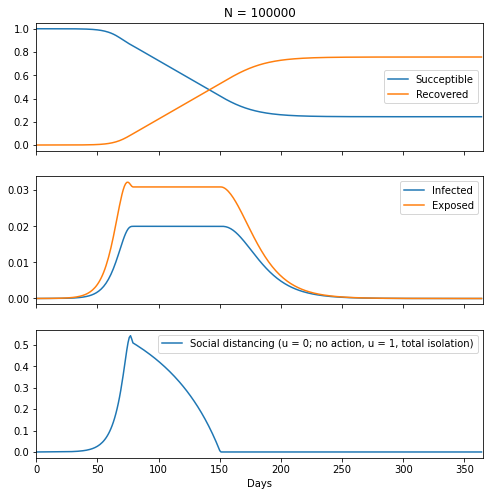

In [212]:
fig, axes = plt.subplots(3,1, figsize=(8,8), sharex=True)

axes[0].set_title("N = 100000")

sim[["s", "r"]].plot(ax=axes[0])
axes[0].legend(["Succeptible", "Recovered"])


sim[["i", "e"]].plot(ax=axes[1])
axes[1].legend(["Infected", "Exposed"])

sim[["u"]].plot(ax=axes[2])
axes[2].legend(["Social distancing (u = 0; no action, u = 1, total isolation)"])

axes[2].set_xlim([0, 365])
axes[2].set_xlabel("Days")

fig.savefig("SEIR_MPC_365_no_disturbance.png")
#sim.plot()